<a href="https://colab.research.google.com/github/clachevv/neuro-match-project/blob/main/notebooks/alex_net_layer_extration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Terms of Use
By using this colab to download the brain dataset (i.e., data including fMRI, images, labels), you agree to the following terms:

1. You will use the Datasets only for non-commercial research and educational purposes.
2. You will NOT distribute the Datasets or any parts thereof.
3. Massachusetts Institute of Technology make no representations or warranties regarding the datasets, including but not limited to warranties of non-infringement or fitness for a particular purpose.
4. You accept full responsibility for your use of the datasets and shall defend and indemnify Massachusetts Institute of Technology and International Business Machines Corporation, including its employees, officers and agents, against any and all claims arising from your use of the datasets, including but not limited to your use of any copyrighted images that you may create from the datasets.
5. You will treat people appearing in this data with respect and dignity.
6. This data comes with no warranty or guarantee of any kind, and you accept full liability.

# Predicting fMRI responses from Algonauts2021 dataset

**Goal:** Here we show how to prepare submission for Algonauts 2021 challenge using AlexNet as an example.

This notebook is organized as follows:

1. Loading fMRI responses to videos and visualizing in glass brain using nilearn.
2. Feedforward the videos from stimulus set to the AlexNet model pretrained on Imagenet dataset to extract AlexNet activations from different layers and apply PCA for dimensionality reduction.
3.   Train a linear regression to predict fMRI responses from AlexNet activations.
4.   Evaluate the model by comparing the correlation between predicted and recorded fMRI responses on validation set.
5. Generate predicted fMRI responses to test videos for all subjects all ROIs
6. Preparing submission files for codalab



In [1]:
#@title Installations
%%capture

!pip install nilearn
!pip install decord

In [2]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu

Get the dropbox link to download dataset by filling this [google form](https://forms.gle/qq9uqqu6SwN8ytxQ9).

In [3]:
#@title Enter the download link and run the cell
download_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1' #@param {type:"string"}
os.environ["download_link"] = download_link
!echo $download_link
!wget -O participants_data.zip -c $download_link
!unzip participants_data.zip
!wget -O example.nii -c https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt

https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1
--2024-07-22 23:29:04--  https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/85ifoemb95h4s849gfz3w/participants_data.zip?rlkey=jvxrlrdf8b1doyldyzzei74h8&dl=1 [following]
--2024-07-22 23:29:04--  https://www.dropbox.com/scl/fi/85ifoemb95h4s849gfz3w/participants_data.zip?rlkey=jvxrlrdf8b1doyldyzzei74h8&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1d04e0d687fc14ce4ac1c70e42.dl.dropboxusercontent.com/cd/0/inline/CXOrlqrxm5qhWhhBLL8PAwOr9aiWLlKlHzx2tn3gbAcClboVyl_N2DePfatbmjoUeBnl6mlHXkV9fD5UWepDTfaBBOrHkFqEtKqhI6y7zwKKh7vWbHAZOT2aVkaqiJpSLisLqIEKOPcBX6fZbhEPeXYF/file?dl=

#fMRI Data

The Algonauts dataset provides human brain responses to a set of 1,102 3-s long video clips of everyday events. The brain responses are measured with functional magnetic resonance imaging (fMRI). fMRI is a widely used brain imaging technique with high spatial resolution that measures blood flow changes associated with neural responses.

The training set consists of 1,000 video clips and the associated brain responses. The brain responses are provided here in two tracks corresponding to two independent tracks in the Algonauts challenge.

In the **full track**, brain responses provided are from selected voxels across the whole brain showing reliable responses to videos. The figure below shows the reliability values of different voxels in the brain.


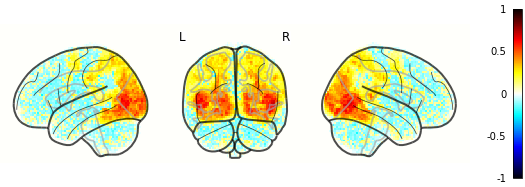

In the **mini track**, brain responses provided are from a set of specific regions of interest (ROIs) known to play a key role in visual perception. These ROIs start in early and mid-level visual cortex (V1, V2, V3, and V4) and extend into higher-level cortex that responds preferentially to all objects or particular categories (Body- EBA; Face - FFA, STS; Object - LOC; Scene - PPA). In the figure below we show the masks of the above mentioned ROIs for an example subject.


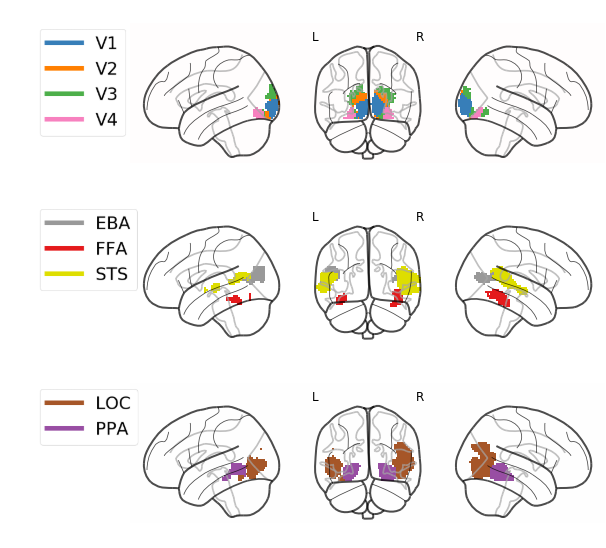

#Loading fMRI data
The trainig dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set.

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI.

In [4]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
  fmri_dir = './participants_data_v2021'
  track = "full_track"
  results_dir = '/content/'
  track_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(track_dir, sub)
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB")
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
  brain_mask = '/content/example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

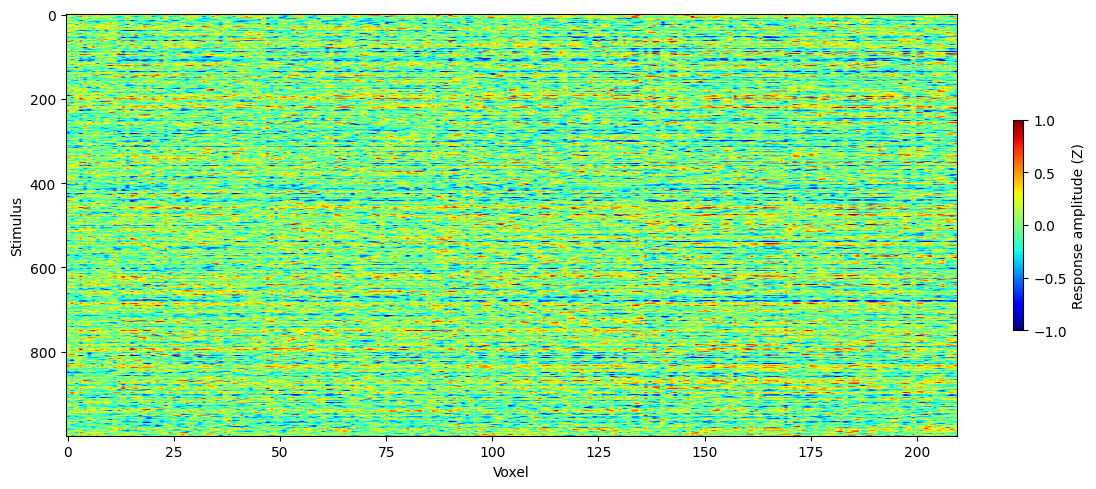

In [5]:
#@title Loading fMRI data and inspecting dimensions
sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]

ROI = 'FFA'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

######## fMRI data loader wrapper code ###################################
fmri_dir = '/content/participants_data_v2021'
if ROI == "WB":
    track = "full_track"
else:
    track = "mini_track"
results_dir = '/content/'
track_dir = os.path.join(fmri_dir, track)
sub_fmri_dir = os.path.join(track_dir, sub)
if track == "full_track":
    fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
else:
    fmri_train_all = get_fmri(sub_fmri_dir,ROI)

######## fMRI data loader wrapper code ###################################


f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The above matrix shows each individual voxel's (columns) response to 1000 videos (rows). To find out more details about how the fMRI data were preprocessed please click [here](http://algonauts.csail.mit.edu/brainmappingandanalysis.html).

Visualize a given video (with id from 0-999) and its corresponding brain activity

In [6]:
#@title Visualize video
vid_id = 266 #@param {type: "integer"}
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'

########### Video display code #################################################
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()

#visualize_brain_activity(video_dir,fmri_train_all,vid_id)
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_list[vid_id],'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)
########### Video display code #################################################

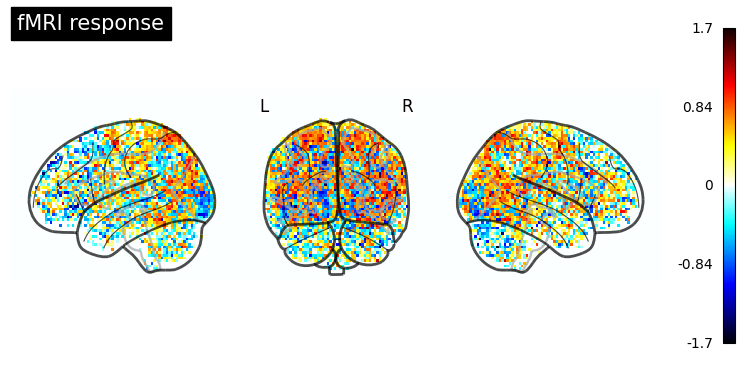

In [7]:
#@title Visualize corresponding brain response
visualize_activity(vid_id,sub)

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos.

# Vision Model definition (AlexNet)

Run the next cell to define the architecture of the model using pytorch.

BETTER VERSION OF ALEXNET USING LEAKY RELU WITH NEGATIVE SLOPES TO AVOID "Dying" ReLU Problem, PLEASE SEE HERE FOR MORE DETAILS: https://medium.com/@sreeku.ralla/activation-functions-relu-vs-leaky-relu-b8272dc0b1be

In [28]:
#@title AlexNet
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),

            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),

            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),

            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),

            nn.LeakyReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),

            )
        self.fc8 = nn.Sequential(
            nn.LeakyReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." `_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model


#Feature Extraction
Run the next cell to extract Alexnet activations on the videos from the stimulus set. We will use these later to train a regression for predicting fMRI responses.

In [29]:
#@title Functions for loading videos and extracting features
seed = 42
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """


    model = alexnet()
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model

def print_alexnet_predictions(output):
    with open('class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]

    # sort the probability vector in descending order
    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0
    # obtain the first 5 classes (with the highest probability) the input belongs to
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    for i in range(5):
        print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
    return results


def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images,num_frames

def get_activations_and_save(model, video_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    video_list : list
        the list contains path to all videos.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    results_dict = {}

    for video_file in tqdm(video_list):
        vid,num_frames = sample_video_from_mp4(video_file)
        video_file_name = os.path.split(video_file)[-1].split(".")[0]
        activations = []
        for frame,img in enumerate(vid):
            input_img = V(resize_normalize(img).unsqueeze(0))
            if torch.cuda.is_available():
                input_img=input_img.cuda()
            x = model.forward(input_img)
            for i,feat in enumerate(x):
                if frame==0:
                    if i==7:

                        print("\nTop-5 Predictions for the video id: ", video_file_name)
                        results = print_alexnet_predictions(feat) #results var
                        #results_dict[video_file] = results
                        #print(results_dict)
                    activations.append(feat.data.cpu().numpy().ravel())
                else:
                    activations[i] =  activations[i] + feat.data.cpu().numpy().ravel()
        results_dict[video_file] = results
        #print(results)

        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, video_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            avg_layer_activation = activations[layer]/float(num_frames)
            np.save(save_path,avg_layer_activation)
    return results_dict

def do_PCA_and_save(activations_dir, save_dir):
    """This function preprocesses Neural Network features using PCA and save the results
    in  a specified directory
.
    Parameters
    ----------
    activations_dir : str
        save path for extracted features.
    save_dir : str
        save path for extracted PCA features.
    """

    layers = ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']
    n_components = 100
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    train, test = {},{}
    for layer in tqdm(layers):
        activations_file_list = glob.glob(activations_dir +'/*'+layer+'.npy')
        activations_file_list.sort()
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp
        x_train = x[:1000,:]
        x_test = x[1000:,:]

        start_time = time.time()
        x_test = StandardScaler().fit_transform(x_test)
        x_train = StandardScaler().fit_transform(x_train)
        ipca = PCA(n_components=n_components,random_state=seed)
        ipca.fit(x_train)

        x_train = ipca.transform(x_train)
        x_test = ipca.transform(x_test)
        train[layer] = x_train
        test[layer] = x_test
        train_save_path = os.path.join(save_dir,"train_"+layer)
        test_save_path = os.path.join(save_dir,"test_"+layer)
        np.save(train_save_path,x_train)
        np.save(test_save_path,x_test)
    return train, test

In [30]:
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
print('Total Number of Videos: ', len(video_list))

Total Number of Videos:  1102


In [31]:
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()
print('Total Number of Videos: ', len(video_list))
save_dir = "/content/activations_alexnet"
# load Alexnet
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = "/content/alexnet.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, "/content/alexnet.pth")
model = load_alexnet(checkpoint_path)

# get and save activations

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
results_dict = get_activations_and_save(model, video_list, activations_dir)

Total Number of Videos:  1102
-------------Saving activations ----------------------------


  0%|          | 0/1102 [00:00<?, ?it/s]


Top-5 Predictions for the video id:  0001_0-0-1-6-7-2-8-0-17500167280
red-breasted merganser, Mergus serrator: 81.4041%
American coot, marsh hen, mud hen, water hen, Fulica americana: 15.6792%
drake: 1.2368%
oystercatcher, oyster catcher: 1.0613%
dowitcher: 0.1558%


  0%|          | 1/1102 [00:01<24:14,  1.32s/it]


Top-5 Predictions for the video id:  0002_0-0-4-3146384004
tractor: 26.5261%
thresher, thrasher, threshing machine: 19.6208%
Bouvier des Flandres, Bouviers des Flandres: 16.4204%
ambulance: 8.2731%
harvester, reaper: 3.7288%


  0%|          | 2/1102 [00:02<25:08,  1.37s/it]


Top-5 Predictions for the video id:  0003_0-0-8-1-2-4-0-0-3500812400
croquet ball: 96.9808%
golf ball: 1.7850%
soccer ball: 0.2362%
Bouvier des Flandres, Bouviers des Flandres: 0.1949%
lawn mower, mower: 0.1489%


  0%|          | 3/1102 [00:04<25:59,  1.42s/it]


Top-5 Predictions for the video id:  0004_0-1-2-9-1-9-9-5-2401291995
bobsled, bobsleigh, bob: 60.6530%
snowmobile: 34.6050%
dogsled, dog sled, dog sleigh: 4.2445%
ski: 0.2011%
swing: 0.1601%


  0%|          | 4/1102 [00:05<27:22,  1.50s/it]


Top-5 Predictions for the video id:  0005_0-1-7-8-3-6-4-8-4401783648
toyshop: 83.6062%
bobsled, bobsleigh, bob: 8.6515%
unicycle, monocycle: 1.7552%
volleyball: 1.6561%
torch: 0.8415%


  0%|          | 5/1102 [00:07<28:30,  1.56s/it]


Top-5 Predictions for the video id:  0006_0-1-9-9-8-6-5-9-4701998659
space bar: 86.7321%
library: 3.0149%
crossword puzzle, crossword: 2.3183%
grocery store, grocery, food market, market: 1.7571%
menu: 1.4186%


  1%|          | 6/1102 [00:09<28:14,  1.55s/it]


Top-5 Predictions for the video id:  0007_0-2-3-14056753023
restaurant, eating house, eating place, eatery: 99.1039%
cello, violoncello: 0.2257%
academic gown, academic robe, judge's robe: 0.0902%
fire screen, fireguard: 0.0809%
stove: 0.0470%


  1%|          | 7/1102 [00:10<25:10,  1.38s/it]


Top-5 Predictions for the video id:  0008_0-2-9-6-5-7-2-3-16002965723_1
desk: 60.7610%
microwave, microwave oven: 5.7430%
perfume, essence: 4.2947%
laptop, laptop computer: 3.9705%
notebook, notebook computer: 2.3472%


  1%|          | 8/1102 [00:11<22:53,  1.26s/it]


Top-5 Predictions for the video id:  0009_0-3-5-4-1-3-6-2-8603541362
plastic bag: 12.8296%
candle, taper, wax light: 12.2118%
table lamp: 7.2349%
oxygen mask: 6.6415%
triceratops: 6.2645%


  1%|          | 9/1102 [00:12<21:31,  1.18s/it]


Top-5 Predictions for the video id:  0010_0-3-6-10842732036
restaurant, eating house, eating place, eatery: 67.6771%
theater curtain, theatre curtain: 19.8556%
bassoon: 6.4001%
marimba, xylophone: 2.0875%
cello, violoncello: 0.8712%


  1%|          | 10/1102 [00:13<20:27,  1.12s/it]


Top-5 Predictions for the video id:  0011_0-3-6-2-3-3-4-4-8103623344
restaurant, eating house, eating place, eatery: 58.4697%
desk: 8.9994%
dining table, board: 7.3768%
ocarina, sweet potato: 6.7248%
library: 2.6046%


  1%|          | 11/1102 [00:14<19:48,  1.09s/it]


Top-5 Predictions for the video id:  0012_0-5-3-7-6-2-8-4-24105376284
moving van: 41.0492%
limousine, limo: 13.1831%
minibus: 13.1305%
bullet train, bullet: 7.6653%
passenger car, coach, carriage: 6.5481%


  1%|          | 12/1102 [00:15<19:18,  1.06s/it]


Top-5 Predictions for the video id:  0013_0-5-3-8-6-8-2-6-4805386826
Welsh springer spaniel: 56.5930%
Brittany spaniel: 32.8916%
gyromitra: 5.7428%
wire-haired fox terrier: 1.1652%
beagle: 1.0228%


  1%|          | 13/1102 [00:16<18:56,  1.04s/it]


Top-5 Predictions for the video id:  0014_0-5-6-8272016056_edit
potter's wheel: 86.7708%
stretcher: 5.5849%
lab coat, laboratory coat: 3.8212%
oxygen mask: 1.5113%
neck brace: 0.6125%


  1%|▏         | 14/1102 [00:17<18:43,  1.03s/it]


Top-5 Predictions for the video id:  0015_0-6-1-9759583061
pool table, billiard table, snooker table: 63.7087%
goldfish, Carassius auratus: 9.4513%
wall clock: 7.7536%
Petri dish: 5.1615%
croquet ball: 3.0341%


  1%|▏         | 15/1102 [00:18<18:43,  1.03s/it]


Top-5 Predictions for the video id:  0016_0-6-6-1-5-8-2-5-14806615825
iron, smoothing iron: 52.9312%
potter's wheel: 32.0111%
beaker: 5.8857%
candle, taper, wax light: 4.0432%
nipple: 2.9168%


  1%|▏         | 16/1102 [00:19<18:42,  1.03s/it]


Top-5 Predictions for the video id:  0017_0-7-3-5856076073
toyshop: 26.8081%
fire engine, fire truck: 15.1542%
lifeboat: 14.0590%
scoreboard: 7.4926%
tennis ball: 5.9790%


  2%|▏         | 17/1102 [00:20<20:45,  1.15s/it]


Top-5 Predictions for the video id:  0018_0-7-7-9-8-1-7-4-24407798174
ski: 74.9804%
bobsled, bobsleigh, bob: 19.0418%
stretcher: 2.6751%
dogsled, dog sled, dog sleigh: 1.7004%
snowmobile: 0.9953%


  2%|▏         | 18/1102 [00:22<26:58,  1.49s/it]


Top-5 Predictions for the video id:  0019_0-7-9-9-7-7-1-5-4307997715
fox squirrel, eastern fox squirrel, Sciurus niger: 98.7453%
grey fox, gray fox, Urocyon cinereoargenteus: 1.2231%
kit fox, Vulpes macrotis: 0.0305%
wood rabbit, cottontail, cottontail rabbit: 0.0009%
hare: 0.0001%


  2%|▏         | 19/1102 [00:24<28:09,  1.56s/it]


Top-5 Predictions for the video id:  0020_0-8-0-0-3-9-3-9-7108003939
balance beam, beam: 37.5823%
piggy bank, penny bank: 22.1316%
pajama, pyjama, pj's, jammies: 9.2547%
photocopier: 4.4128%
pinwheel: 2.4244%


  2%|▏         | 20/1102 [00:26<28:50,  1.60s/it]


Top-5 Predictions for the video id:  0021_0-8-0-8-6-5-4-5-4708086545
agama: 20.3853%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 10.2418%
marmot: 7.6302%
mongoose: 4.7895%
water ouzel, dipper: 4.6248%


  2%|▏         | 21/1102 [00:28<32:46,  1.82s/it]


Top-5 Predictions for the video id:  0022_0-8-7-7-9-6-5-5-6508779655
restaurant, eating house, eating place, eatery: 37.4688%
plate: 35.6072%
Crock Pot: 8.5464%
dining table, board: 4.2365%
consomme: 3.7557%


  2%|▏         | 22/1102 [00:31<39:50,  2.21s/it]


Top-5 Predictions for the video id:  0023_0-8-8-7346836088
ping-pong ball: 67.9397%
neck brace: 7.5985%
volleyball: 5.7632%
bathing cap, swimming cap: 2.7008%
whistle: 2.5163%


  2%|▏         | 23/1102 [00:33<36:06,  2.01s/it]


Top-5 Predictions for the video id:  0024_0-9-3-5943645093
African elephant, Loxodonta africana: 84.6349%
Indian elephant, Elephas maximus: 14.7162%
tusker: 0.3206%
swimming trunks, bathing trunks: 0.1746%
dugong, Dugong dugon: 0.0392%


  2%|▏         | 24/1102 [00:34<30:40,  1.71s/it]


Top-5 Predictions for the video id:  0025_0-9-5-1-8-2-6-6-4009518266
airliner: 51.2784%
warplane, military plane: 47.5131%
wing: 0.6781%
aircraft carrier, carrier, flattop, attack aircraft carrier: 0.2197%
space shuttle: 0.2008%


  2%|▏         | 25/1102 [00:35<26:45,  1.49s/it]


Top-5 Predictions for the video id:  0026_0-9-9-8-0-5-8-5-4909980585
ambulance: 37.8311%
minibus: 18.9128%
limousine, limo: 14.0423%
recreational vehicle, RV, R.V.: 11.7955%
stretcher: 7.3118%


  2%|▏         | 26/1102 [00:36<24:11,  1.35s/it]


Top-5 Predictions for the video id:  0027_03chvdioZYI_85
trombone: 25.8053%
oboe, hautboy, hautbois: 17.9852%
flute, transverse flute: 15.1014%
stage: 14.1909%
cornet, horn, trumpet, trump: 11.7009%


  2%|▏         | 27/1102 [00:37<22:17,  1.24s/it]


Top-5 Predictions for the video id:  0028_0P6FNr_6XWo_35
oxygen mask: 27.4214%
jinrikisha, ricksha, rickshaw: 18.9612%
stretcher: 12.0996%
bearskin, busby, shako: 4.5091%
Indian cobra, Naja naja: 3.1708%


  3%|▎         | 28/1102 [00:38<20:50,  1.16s/it]


Top-5 Predictions for the video id:  0029_1-0-7-2-7-1-8-6-2810727186
potter's wheel: 51.6490%
toyshop: 23.7835%
eggnog: 10.9070%
maraca: 4.2459%
punching bag, punch bag, punching ball, punchball: 1.1356%


  3%|▎         | 29/1102 [00:39<19:58,  1.12s/it]


Top-5 Predictions for the video id:  0030_1-1-5-6-1-6-5-2-2811561652
piggy bank, penny bank: 34.1131%
hair slide: 26.4057%
maraca: 13.9783%
crib, cot: 6.0520%
toyshop: 3.3434%


  3%|▎         | 30/1102 [00:40<19:21,  1.08s/it]


Top-5 Predictions for the video id:  0031_1-1-8-8-3-2-8-3-13711883283
ski: 99.2431%
puck, hockey puck: 0.3337%
aircraft carrier, carrier, flattop, attack aircraft carrier: 0.0643%
snowmobile: 0.0537%
reel: 0.0516%


  3%|▎         | 31/1102 [00:41<18:49,  1.05s/it]


Top-5 Predictions for the video id:  0032_1-2-0-9-0-9-1-6-3812090916_61
corkscrew, bottle screw: 26.9024%
Polaroid camera, Polaroid Land camera: 16.3558%
whistle: 13.2832%
pick, plectrum, plectron: 12.5995%
plane, carpenter's plane, woodworking plane: 5.6151%


  3%|▎         | 32/1102 [00:42<18:28,  1.04s/it]


Top-5 Predictions for the video id:  0033_1-2-5-1-2-7-6-2-2512512762
speedboat: 15.1819%
convertible: 9.5411%
go-kart: 9.1071%
lakeside, lakeshore: 8.6991%
airship, dirigible: 5.2068%


  3%|▎         | 33/1102 [00:43<18:57,  1.06s/it]


Top-5 Predictions for the video id:  0034_1-2-5-3344278125
bicycle-built-for-two, tandem bicycle, tandem: 99.5920%
mountain bike, all-terrain bike, off-roader: 0.2876%
tricycle, trike, velocipede: 0.0607%
moped: 0.0434%
jinrikisha, ricksha, rickshaw: 0.0141%


  3%|▎         | 34/1102 [00:44<20:35,  1.16s/it]


Top-5 Predictions for the video id:  0035_1-2-6-3176369126
snowmobile: 63.8712%
ski: 22.2783%
dogsled, dog sled, dog sleigh: 12.2691%
bobsled, bobsleigh, bob: 1.1034%
alp: 0.1365%


  3%|▎         | 35/1102 [00:46<21:54,  1.23s/it]


Top-5 Predictions for the video id:  0036_1-2-6-9-6-8-2-1-22212696821
tabby, tabby cat: 42.3692%
Egyptian cat: 21.3808%
tiger cat: 11.9103%
shower cap: 2.9266%
plastic bag: 2.6128%


  3%|▎         | 36/1102 [00:47<23:18,  1.31s/it]


Top-5 Predictions for the video id:  0037_1-3-9-9-9-6-4-3-3213999643
hot pot, hotpot: 54.8703%
plate: 42.6341%
potpie: 0.9587%
restaurant, eating house, eating place, eatery: 0.8141%
waffle iron: 0.1863%


  3%|▎         | 37/1102 [00:49<24:50,  1.40s/it]


Top-5 Predictions for the video id:  0038_1-4-3-5-8-6-2-5-3114358625
ski: 89.9727%
alp: 5.3783%
snowplow, snowplough: 2.0537%
drilling platform, offshore rig: 0.4642%
parachute, chute: 0.4260%


  3%|▎         | 38/1102 [00:50<25:44,  1.45s/it]


Top-5 Predictions for the video id:  0039_1-4-4-4086629144
solar dish, solar collector, solar furnace: 18.9273%
catamaran: 18.4348%
radio telescope, radio reflector: 13.0335%
water tower: 12.4916%
schooner: 4.6435%


  4%|▎         | 39/1102 [00:52<25:14,  1.42s/it]


Top-5 Predictions for the video id:  0040_1-4-8-8-7-8-7-5-3914887875_56
four-poster: 54.5068%
mosquito net: 10.0718%
screen, CRT screen: 9.7513%
binder, ring-binder: 7.5759%
envelope: 3.3772%


  4%|▎         | 40/1102 [00:53<22:57,  1.30s/it]


Top-5 Predictions for the video id:  0041_1-5-0-0-4-9-7-8-2915004978_2
lawn mower, mower: 90.2000%
golfcart, golf cart: 5.1980%
go-kart: 1.4867%
tractor: 1.0760%
Model T: 0.5951%


  4%|▎         | 41/1102 [00:54<21:24,  1.21s/it]


Top-5 Predictions for the video id:  0042_1-5-8-9-2-4-5-4-7815892454
balance beam, beam: 55.0363%
horizontal bar, high bar: 35.0474%
racket, racquet: 2.6266%
parallel bars, bars: 1.7248%
basketball: 1.1208%


  4%|▍         | 42/1102 [00:55<20:18,  1.15s/it]


Top-5 Predictions for the video id:  0043_1-6-0-2796094160
scuba diver: 99.9985%
tiger shark, Galeocerdo cuvieri: 0.0005%
sea snake: 0.0005%
coral reef: 0.0003%
sea cucumber, holothurian: 0.0001%


  4%|▍         | 43/1102 [00:56<19:40,  1.11s/it]


Top-5 Predictions for the video id:  0044_1-6-0-7-7-6-4-6-7816077646
planetarium: 89.4415%
lakeside, lakeshore: 2.5119%
alp: 2.2535%
parachute, chute: 0.7878%
airship, dirigible: 0.7878%


  4%|▍         | 44/1102 [00:57<19:08,  1.09s/it]


Top-5 Predictions for the video id:  0045_1-6-8-0-7-6-7-4-3816807674
neck brace: 42.6337%
nipple: 11.1033%
whistle: 7.8640%
stethoscope: 6.9667%
maraca: 4.3569%


  4%|▍         | 45/1102 [00:58<18:40,  1.06s/it]


Top-5 Predictions for the video id:  0046_1-6-8-5795643168
valley, vale: 57.8320%
geyser: 39.7067%
cliff, drop, drop-off: 0.8006%
promontory, headland, head, foreland: 0.4301%
yawl: 0.2429%


  4%|▍         | 46/1102 [00:59<18:24,  1.05s/it]


Top-5 Predictions for the video id:  0047_1-7-1-8-6-3-6-2-3417186362
warplane, military plane: 71.8537%
aircraft carrier, carrier, flattop, attack aircraft carrier: 19.1708%
liner, ocean liner: 2.4586%
projectile, missile: 1.1422%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 0.5214%


  4%|▍         | 47/1102 [01:00<18:03,  1.03s/it]


Top-5 Predictions for the video id:  0048_1-7-2-5-5-0-7-5-25617255075
abaya: 21.3169%
parallel bars, bars: 11.2661%
stretcher: 7.7398%
cliff dwelling: 7.0611%
bulletproof vest: 5.7934%


  4%|▍         | 48/1102 [01:01<17:55,  1.02s/it]


Top-5 Predictions for the video id:  0049_1-7-4-5-3-8-3-6-3017453836
stage: 53.3897%
steel drum: 23.1669%
unicycle, monocycle: 5.6957%
rugby ball: 3.1817%
torch: 2.2908%


  4%|▍         | 49/1102 [01:02<18:28,  1.05s/it]


Top-5 Predictions for the video id:  0050_1-8-5-7127344185
tennis ball: 60.7426%
trimaran: 8.8204%
catamaran: 7.6029%
swimming trunks, bathing trunks: 3.0223%
racket, racquet: 2.6843%


  5%|▍         | 50/1102 [01:03<20:09,  1.15s/it]


Top-5 Predictions for the video id:  0051_1-8-7-1-1-9-6-6-5418711966
snowplow, snowplough: 97.9361%
snowmobile: 1.7925%
bobsled, bobsleigh, bob: 0.0700%
lawn mower, mower: 0.0627%
tractor: 0.0579%


  5%|▍         | 51/1102 [01:05<22:21,  1.28s/it]


Top-5 Predictions for the video id:  0052_1-9-3-0-9-4-6-4-4719309464
oxcart: 83.4817%
Arabian camel, dromedary, Camelus dromedarius: 14.5310%
Indian elephant, Elephas maximus: 1.3819%
horse cart, horse-cart: 0.3512%
tusker: 0.1267%


  5%|▍         | 52/1102 [01:06<23:52,  1.36s/it]


Top-5 Predictions for the video id:  0053_1-9-3-2-8-0-1-3-3919328013
comic book: 82.6695%
Afghan hound, Afghan: 3.2678%
tennis ball: 2.5328%
tractor: 1.4406%
stretcher: 1.1311%


  5%|▍         | 53/1102 [01:08<25:34,  1.46s/it]


Top-5 Predictions for the video id:  0054_1-9-3-9-3-8-2-2-23719393822
water tower: 48.2780%
seashore, coast, seacoast, sea-coast: 20.2450%
fountain: 12.4789%
lakeside, lakeshore: 7.9490%
mosque: 2.4576%


  5%|▍         | 54/1102 [01:10<26:26,  1.51s/it]


Top-5 Predictions for the video id:  0055_1-9-6-7-5-1-9-8-3119675198
potter's wheel: 90.2212%
shoe shop, shoe-shop, shoe store: 3.6325%
toyshop: 2.2228%
restaurant, eating house, eating place, eatery: 1.9461%
eggnog: 0.3720%


  5%|▍         | 55/1102 [01:11<27:45,  1.59s/it]


Top-5 Predictions for the video id:  0056_2-0-0-3614591200
promontory, headland, head, foreland: 79.8702%
seashore, coast, seacoast, sea-coast: 11.4845%
cliff, drop, drop-off: 4.2570%
geyser: 1.5975%
valley, vale: 0.6051%


  5%|▌         | 56/1102 [01:13<28:44,  1.65s/it]


Top-5 Predictions for the video id:  0057_2-0-9-8159444209
dam, dike, dyke: 99.2446%
fireboat: 0.3775%
lakeside, lakeshore: 0.1524%
geyser: 0.0790%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.0386%


  5%|▌         | 57/1102 [01:15<28:51,  1.66s/it]


Top-5 Predictions for the video id:  0058_2-4-3-5345273243
stage: 96.0333%
theater curtain, theatre curtain: 0.9273%
academic gown, academic robe, judge's robe: 0.6409%
unicycle, monocycle: 0.2359%
suit, suit of clothes: 0.1574%


  5%|▌         | 58/1102 [01:17<28:36,  1.64s/it]


Top-5 Predictions for the video id:  0059_2-5-7-6889839257
ski: 75.8593%
alp: 5.3586%
stretcher: 3.2165%
snowplow, snowplough: 1.4412%
ambulance: 1.2283%


  5%|▌         | 59/1102 [01:18<27:01,  1.55s/it]


Top-5 Predictions for the video id:  0060_2-6-5-12330534265
eggnog: 19.2606%
toyshop: 16.2160%
medicine chest, medicine cabinet: 12.4647%
dining table, board: 8.9410%
soap dispenser: 6.1420%


  5%|▌         | 60/1102 [01:19<24:14,  1.40s/it]


Top-5 Predictions for the video id:  0061_2-9-5-4309863295
barbershop: 34.3873%
oxygen mask: 21.0816%
power drill: 15.6012%
dumbbell: 8.1043%
jersey, T-shirt, tee shirt: 3.0702%


  6%|▌         | 61/1102 [01:20<22:15,  1.28s/it]


Top-5 Predictions for the video id:  0062_2EMSeADyrrQ_35
shopping basket: 51.7891%
tennis ball: 16.4245%
space heater: 12.5028%
can opener, tin opener: 2.7853%
rock beauty, Holocanthus tricolor: 2.6738%


  6%|▌         | 62/1102 [01:21<20:49,  1.20s/it]


Top-5 Predictions for the video id:  0063_2Ng8UYBFhbU_91
dishrag, dishcloth: 31.6915%
meat loaf, meatloaf: 30.1975%
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 20.0684%
African chameleon, Chamaeleo chamaeleon: 3.1568%
pot, flowerpot: 1.9864%


  6%|▌         | 63/1102 [01:22<19:47,  1.14s/it]


Top-5 Predictions for the video id:  0064_2Tm26dLw29A_69
harvester, reaper: 50.4062%
lawn mower, mower: 14.6731%
mobile home, manufactured home: 14.6429%
tractor: 10.5684%
solar dish, solar collector, solar furnace: 1.4957%


  6%|▌         | 64/1102 [01:23<19:03,  1.10s/it]


Top-5 Predictions for the video id:  0065_2aG9AaxuGSU_148
television, television system: 66.9022%
home theater, home theatre: 16.6745%
monitor: 14.3396%
screen, CRT screen: 0.8158%
desktop computer: 0.4978%


  6%|▌         | 65/1102 [01:24<18:32,  1.07s/it]


Top-5 Predictions for the video id:  0066_2cCnDHUV0W8_35
miniskirt, mini: 66.8205%
abaya: 12.9509%
overskirt: 9.3461%
trench coat: 3.2630%
kimono: 2.9621%


  6%|▌         | 66/1102 [01:25<18:06,  1.05s/it]


Top-5 Predictions for the video id:  0067_2h1Mj2ymyj8_121
unicycle, monocycle: 48.8794%
jinrikisha, ricksha, rickshaw: 20.5649%
bicycle-built-for-two, tandem bicycle, tandem: 9.1473%
tricycle, trike, velocipede: 4.9096%
oxcart: 3.9119%


  6%|▌         | 67/1102 [01:26<19:18,  1.12s/it]


Top-5 Predictions for the video id:  0068_3-0-4-4343808304
grocery store, grocery, food market, market: 58.5811%
toyshop: 27.6601%
confectionery, confectionary, candy store: 12.9788%
vending machine: 0.2269%
packet: 0.2033%


  6%|▌         | 68/1102 [01:28<20:49,  1.21s/it]


Top-5 Predictions for the video id:  0069_3-0-5-3-4-3-5-2-4730534352
oxcart: 75.2859%
stretcher: 9.9557%
potter's wheel: 5.3566%
thresher, thrasher, threshing machine: 1.8852%
tractor: 1.4626%


  6%|▋         | 69/1102 [01:29<22:10,  1.29s/it]


Top-5 Predictions for the video id:  0070_3-3-6-8-2-7-6-6-3533682766
vizsla, Hungarian pointer: 44.1838%
bloodhound, sleuthhound: 17.3901%
Rhodesian ridgeback: 15.2896%
bull mastiff: 4.0440%
malinois: 3.2556%


  6%|▋         | 70/1102 [01:31<23:51,  1.39s/it]


Top-5 Predictions for the video id:  0071_3-4-9-8-4-7-4-8-4434984748
airliner: 83.0173%
sports car, sport car: 4.7551%
racer, race car, racing car: 3.0314%
speedboat: 1.5777%
warplane, military plane: 1.4658%


  6%|▋         | 71/1102 [01:32<25:01,  1.46s/it]


Top-5 Predictions for the video id:  0072_3-5-0-4261181350
library: 36.2765%
toyshop: 28.6664%
potter's wheel: 20.8400%
guinea pig, Cavia cobaya: 5.6698%
barbershop: 1.4092%


  7%|▋         | 72/1102 [01:34<25:25,  1.48s/it]


Top-5 Predictions for the video id:  0073_3-5-8-9-9-5-9-8-4335899598
ski: 44.9614%
shovel: 32.6884%
ski mask: 16.9430%
bobsled, bobsleigh, bob: 2.1424%
Mexican hairless: 1.2716%


  7%|▋         | 73/1102 [01:35<23:16,  1.36s/it]


Top-5 Predictions for the video id:  0074_3-6-5-3-3-4-4-5-23036533445
toyshop: 75.1596%
kimono: 3.7627%
maillot, tank suit: 3.0254%
maillot: 2.4328%
jersey, T-shirt, tee shirt: 2.0913%


  7%|▋         | 74/1102 [01:36<21:24,  1.25s/it]


Top-5 Predictions for the video id:  0075_3-7-0-7-1-5-3-0-4937071530
spaghetti squash: 27.6923%
ping-pong ball: 16.2380%
butternut squash: 5.3181%
nipple: 5.1207%
diaper, nappy, napkin: 4.5398%


  7%|▋         | 75/1102 [01:37<20:11,  1.18s/it]


Top-5 Predictions for the video id:  0076_3-7-3-13269577373
lifeboat: 65.9227%
speedboat: 24.7344%
trimaran: 6.8204%
fireboat: 1.4193%
yawl: 0.5241%


  7%|▋         | 76/1102 [01:38<19:15,  1.13s/it]


Top-5 Predictions for the video id:  0077_3-7-3-7-1-7-0-1-2537371701
parallel bars, bars: 18.2908%
potter's wheel: 18.0983%
maraca: 7.6916%
dumbbell: 7.1908%
gasmask, respirator, gas helmet: 5.4645%


  7%|▋         | 77/1102 [01:39<18:34,  1.09s/it]


Top-5 Predictions for the video id:  0078_3-7-5-4-7-7-8-9-8037547789
studio couch, day bed: 46.0049%
four-poster: 31.5632%
desk: 4.8506%
library: 3.3811%
restaurant, eating house, eating place, eatery: 2.5170%


  7%|▋         | 78/1102 [01:40<18:09,  1.06s/it]


Top-5 Predictions for the video id:  0079_3-7-5-6-6-4-1-7-3437566417
bicycle-built-for-two, tandem bicycle, tandem: 62.0081%
motor scooter, scooter: 17.8614%
moped: 9.0987%
crash helmet: 3.6768%
unicycle, monocycle: 3.1576%


  7%|▋         | 79/1102 [01:41<17:53,  1.05s/it]


Top-5 Predictions for the video id:  0080_3-9-0-6-4-2-6-6-3339064266
parallel bars, bars: 27.2636%
horizontal bar, high bar: 26.8946%
tricycle, trike, velocipede: 10.6507%
barbell: 9.5941%
punching bag, punch bag, punching ball, punchball: 5.1708%


  7%|▋         | 80/1102 [01:42<17:38,  1.04s/it]


Top-5 Predictions for the video id:  0081_4-0-6-7-6-1-4-5-4540676145
hamster: 49.2182%
axolotl, mud puppy, Ambystoma mexicanum: 31.8936%
piggy bank, penny bank: 4.8706%
nipple: 3.1058%
candle, taper, wax light: 1.4778%


  7%|▋         | 81/1102 [01:43<17:26,  1.03s/it]


Top-5 Predictions for the video id:  0082_4-2-5-6-5-3-6-5-16342565365
acoustic guitar: 95.8780%
electric guitar: 3.6898%
pick, plectrum, plectron: 0.2104%
neck brace: 0.1208%
violin, fiddle: 0.0251%


  7%|▋         | 82/1102 [01:44<17:17,  1.02s/it]


Top-5 Predictions for the video id:  0083_4-3-3-1-0-6-4-0-8743310640
beaker: 42.1072%
water jug: 25.2677%
hourglass: 10.5235%
Petri dish: 3.4796%
espresso maker: 3.4775%


  8%|▊         | 83/1102 [01:45<18:46,  1.11s/it]


Top-5 Predictions for the video id:  0084_4-3-4-8736778434
joystick: 45.0307%
lorikeet: 6.6723%
remote control, remote: 4.7705%
hand-held computer, hand-held microcomputer: 4.2074%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 3.7680%


  8%|▊         | 84/1102 [01:47<20:15,  1.19s/it]


Top-5 Predictions for the video id:  0085_4-3-5-6-0-8-0-8-5543560808
bobsled, bobsleigh, bob: 40.7479%
shovel: 11.9893%
punching bag, punch bag, punching ball, punchball: 8.1993%
desk: 3.0818%
yurt: 2.7053%


  8%|▊         | 85/1102 [01:48<21:32,  1.27s/it]


Top-5 Predictions for the video id:  0086_4-3-5-9059723435
nipple: 93.8124%
diaper, nappy, napkin: 1.6003%
cradle: 1.1302%
tub, vat: 0.7926%
ping-pong ball: 0.7809%


  8%|▊         | 86/1102 [01:50<22:51,  1.35s/it]


Top-5 Predictions for the video id:  0087_4-3-7-4396869437
bobsled, bobsleigh, bob: 45.1922%
ski: 37.3662%
dogsled, dog sled, dog sleigh: 8.6309%
snowmobile: 7.3408%
sea lion: 0.3165%


  8%|▊         | 87/1102 [01:51<24:00,  1.42s/it]


Top-5 Predictions for the video id:  0088_4-3-7-4889733437
power drill: 18.1194%
vacuum, vacuum cleaner: 9.4571%
joystick: 5.1754%
shoe shop, shoe-shop, shoe store: 4.4943%
dumbbell: 4.4060%


  8%|▊         | 88/1102 [01:53<24:33,  1.45s/it]


Top-5 Predictions for the video id:  0089_4-3-8-2-7-7-4-3-9043827743
valley, vale: 97.2319%
lakeside, lakeshore: 1.5259%
head cabbage: 0.5100%
alp: 0.1162%
cauliflower: 0.0907%


  8%|▊         | 89/1102 [01:54<22:42,  1.35s/it]


Top-5 Predictions for the video id:  0090_4-4-7-5-2-9-5-4-4744752954
paddle, boat paddle: 88.5700%
canoe: 11.0881%
yawl: 0.1256%
barracouta, snoek: 0.1004%
catamaran: 0.0426%


  8%|▊         | 90/1102 [01:55<20:59,  1.24s/it]


Top-5 Predictions for the video id:  0091_4-5-0-1-4-3-5-1-15645014351
snowplow, snowplough: 56.7799%
bobsled, bobsleigh, bob: 15.8301%
parallel bars, bars: 9.8455%
amphibian, amphibious vehicle: 5.3256%
puck, hockey puck: 3.1112%


  8%|▊         | 91/1102 [01:56<19:51,  1.18s/it]


Top-5 Predictions for the video id:  0092_4-5-7-1-7-9-4-4-5945717944
warplane, military plane: 93.5403%
airliner: 3.2262%
wing: 2.7360%
space shuttle: 0.3054%
airship, dirigible: 0.0544%


  8%|▊         | 92/1102 [01:57<18:54,  1.12s/it]


Top-5 Predictions for the video id:  0093_4-5-7-5265004457
plate: 35.6259%
candle, taper, wax light: 19.5758%
hair slide: 6.7978%
ice cream, icecream: 5.4258%
carbonara: 3.8261%


  8%|▊         | 93/1102 [01:58<18:17,  1.09s/it]


Top-5 Predictions for the video id:  0094_4-5-9-2-3-0-7-9-15245923079
sturgeon: 65.8406%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 7.7831%
gar, garfish, garpike, billfish, Lepisosteus osseus: 7.5008%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 5.3491%
barracouta, snoek: 5.3166%


  9%|▊         | 94/1102 [01:59<17:52,  1.06s/it]


Top-5 Predictions for the video id:  0095_4-6-1-9-8-5-2-4-25546198524
ballplayer, baseball player: 95.9443%
baseball: 3.1002%
scoreboard: 0.5026%
horizontal bar, high bar: 0.2530%
racket, racquet: 0.0692%


  9%|▊         | 95/1102 [02:00<17:30,  1.04s/it]


Top-5 Predictions for the video id:  0096_4-7-1-1-2-8-3-0-25247112830
speedboat: 98.8379%
catamaran: 0.3940%
sandbar, sand bar: 0.3553%
canoe: 0.1303%
amphibian, amphibious vehicle: 0.0736%


  9%|▊         | 96/1102 [02:01<17:17,  1.03s/it]


Top-5 Predictions for the video id:  0097_4-7-9-4959184479
theater curtain, theatre curtain: 37.3734%
torch: 25.2670%
Afghan hound, Afghan: 9.3676%
unicycle, monocycle: 3.9907%
volleyball: 2.6228%


  9%|▉         | 97/1102 [02:02<17:10,  1.02s/it]


Top-5 Predictions for the video id:  0098_4-7-9-5224564479
bookcase: 59.9725%
punching bag, punch bag, punching ball, punchball: 9.1914%
turnstile: 6.7823%
library: 6.0918%
barbell: 3.1475%


  9%|▉         | 98/1102 [02:03<17:00,  1.02s/it]


Top-5 Predictions for the video id:  0099_4-7-9-5897473479
stretcher: 91.4397%
broom: 2.6560%
maypole: 2.3632%
academic gown, academic robe, judge's robe: 1.0757%
jinrikisha, ricksha, rickshaw: 0.4183%


  9%|▉         | 99/1102 [02:04<18:42,  1.12s/it]


Top-5 Predictions for the video id:  0100_4-7-9-7-6-5-8-0-2647976580
balance beam, beam: 64.3813%
ping-pong ball: 9.8267%
horizontal bar, high bar: 8.5335%
bathing cap, swimming cap: 7.4249%
maillot, tank suit: 4.2979%


  9%|▉         | 100/1102 [02:06<20:11,  1.21s/it]


Top-5 Predictions for the video id:  0101_4-8-4-5-2-8-6-4-12748452864
geyser: 93.8851%
volcano: 1.0984%
airship, dirigible: 0.8608%
wing: 0.4068%
beacon, lighthouse, beacon light, pharos: 0.3301%


  9%|▉         | 101/1102 [02:07<21:38,  1.30s/it]


Top-5 Predictions for the video id:  0102_4-8-9-2-5-7-3-1-3848925731
ice lolly, lolly, lollipop, popsicle: 48.1781%
maraca: 30.1959%
nipple: 7.9171%
diaper, nappy, napkin: 3.1569%
whistle: 1.2803%


  9%|▉         | 102/1102 [02:09<23:18,  1.40s/it]


Top-5 Predictions for the video id:  0103_4-9-0-4-8-4-8-7-3949048487
geyser: 99.9987%
volcano: 0.0005%
beacon, lighthouse, beacon light, pharos: 0.0003%
seashore, coast, seacoast, sea-coast: 0.0001%
planetarium: 0.0001%


  9%|▉         | 103/1102 [02:10<24:11,  1.45s/it]


Top-5 Predictions for the video id:  0104_4_mAU3U33fU_224
fire engine, fire truck: 46.9311%
thresher, thrasher, threshing machine: 20.2817%
snowplow, snowplough: 14.5442%
tractor: 8.0232%
harvester, reaper: 6.6547%


  9%|▉         | 104/1102 [02:12<23:02,  1.39s/it]


Top-5 Predictions for the video id:  0105_5-0-2-9044555502
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 25.9010%
recreational vehicle, RV, R.V.: 17.2493%
limousine, limo: 16.7453%
tow truck, tow car, wrecker: 8.9072%
garbage truck, dustcart: 6.4747%


 10%|▉         | 105/1102 [02:13<21:04,  1.27s/it]


Top-5 Predictions for the video id:  0106_5-0-6-7-7-5-7-6-14950677576_1
mobile home, manufactured home: 85.0157%
go-kart: 2.1570%
recreational vehicle, RV, R.V.: 2.0158%
garbage truck, dustcart: 1.9260%
lakeside, lakeshore: 1.0829%


 10%|▉         | 106/1102 [02:14<19:46,  1.19s/it]


Top-5 Predictions for the video id:  0107_5-2-4-5-8-0-7-9-4752458079
fireboat: 18.8330%
mobile home, manufactured home: 17.9267%
fire engine, fire truck: 9.7668%
guillotine: 7.5816%
tow truck, tow car, wrecker: 4.6720%


 10%|▉         | 107/1102 [02:15<18:48,  1.13s/it]


Top-5 Predictions for the video id:  0108_5-3-4-9966677534
speedboat: 42.6370%
canoe: 26.2828%
lifeboat: 16.6873%
fireboat: 8.3078%
snorkel: 2.5551%


 10%|▉         | 108/1102 [02:16<18:10,  1.10s/it]


Top-5 Predictions for the video id:  0109_5-3-7-1-9-2-1-2-3453719212
plate: 52.7217%
printer: 11.9903%
toaster: 5.5197%
cleaver, meat cleaver, chopper: 4.8947%
photocopier: 4.3618%


 10%|▉         | 109/1102 [02:17<17:40,  1.07s/it]


Top-5 Predictions for the video id:  0110_5-4-0-2405298540
trimaran: 93.9359%
catamaran: 5.3846%
speedboat: 0.3855%
yawl: 0.2168%
schooner: 0.0198%


 10%|▉         | 110/1102 [02:18<17:16,  1.04s/it]


Top-5 Predictions for the video id:  0111_5-4-2-6-1-5-0-7-5654261507
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 40.2411%
Norwegian elkhound, elkhound: 16.3466%
ox: 9.3230%
oxcart: 3.3484%
dogsled, dog sled, dog sleigh: 3.3080%


 10%|█         | 111/1102 [02:19<17:05,  1.04s/it]


Top-5 Predictions for the video id:  0112_5-4-2-6-3-7-5-4-7854263754
skunk, polecat, wood pussy: 34.0704%
Old English sheepdog, bobtail: 28.7732%
valley, vale: 25.7900%
komondor: 2.1514%
American alligator, Alligator mississipiensis: 1.6768%


 10%|█         | 112/1102 [02:20<16:55,  1.03s/it]


Top-5 Predictions for the video id:  0113_5-4-3-5-0-8-5-4-13654350854_22
laptop, laptop computer: 48.8297%
library: 18.6959%
potter's wheel: 6.0572%
washer, automatic washer, washing machine: 5.5344%
stethoscope: 4.1930%


 10%|█         | 113/1102 [02:21<16:48,  1.02s/it]


Top-5 Predictions for the video id:  0114_5-4-5-2-2-4-8-5-8454522485
hot pot, hotpot: 86.3690%
plate: 6.3419%
consomme: 4.0592%
frying pan, frypan, skillet: 0.7894%
Dutch oven: 0.4841%


 10%|█         | 114/1102 [02:22<17:45,  1.08s/it]


Top-5 Predictions for the video id:  0115_5-4-5-4-1-8-6-5-8254541865_29
Sussex spaniel: 64.1037%
briard: 13.1625%
Irish setter, red setter: 12.2896%
Airedale, Airedale terrier: 2.2946%
macaque: 1.2475%


 10%|█         | 115/1102 [02:23<19:25,  1.18s/it]


Top-5 Predictions for the video id:  0116_5-6-5-5-1-6-7-5-23256551675
consomme: 51.2899%
face powder: 47.4853%
espresso: 0.9225%
Petri dish: 0.0960%
eggnog: 0.0474%


 11%|█         | 116/1102 [02:25<20:29,  1.25s/it]


Top-5 Predictions for the video id:  0117_5-6-6-3042970566
standard poodle: 19.6855%
solar dish, solar collector, solar furnace: 12.4219%
hoopskirt, crinoline: 7.3079%
king penguin, Aptenodytes patagonica: 6.0918%
steel drum: 3.5138%


 11%|█         | 117/1102 [02:26<21:58,  1.34s/it]


Top-5 Predictions for the video id:  0118_5-6-7-7-6-0-9-9-3756776099
apiary, bee house: 25.6296%
lawn mower, mower: 17.2209%
milk can: 10.8611%
sundial: 9.4400%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 9.2350%


 11%|█         | 118/1102 [02:28<23:10,  1.41s/it]


Top-5 Predictions for the video id:  0119_5-7-0-7-8-9-1-3-4257078913
vestment: 46.8331%
theater curtain, theatre curtain: 41.2540%
academic gown, academic robe, judge's robe: 5.1546%
stage: 2.7580%
altar: 1.7397%


 11%|█         | 119/1102 [02:30<24:25,  1.49s/it]


Top-5 Predictions for the video id:  0120_5-7-5-3760841575
canoe: 40.5378%
speedboat: 24.7830%
sandbar, sand bar: 9.6087%
paddle, boat paddle: 7.4469%
lakeside, lakeshore: 5.4085%


 11%|█         | 120/1102 [02:31<22:50,  1.40s/it]


Top-5 Predictions for the video id:  0121_5-7-6-1-2-1-4-3-17357612143
jacamar: 75.1319%
bulbul: 19.0710%
squirrel monkey, Saimiri sciureus: 1.7872%
brambling, Fringilla montifringilla: 1.5327%
bee eater: 0.6820%


 11%|█         | 121/1102 [02:32<20:51,  1.28s/it]


Top-5 Predictions for the video id:  0122_5-7-6-9-5-4-8-2-5457695482
diaper, nappy, napkin: 35.7928%
swimming trunks, bathing trunks: 14.7961%
bathtub, bathing tub, bath, tub: 10.4706%
parallel bars, bars: 9.9151%
balance beam, beam: 9.2167%


 11%|█         | 122/1102 [02:33<19:29,  1.19s/it]


Top-5 Predictions for the video id:  0123_5-9-0-1-9-6-9-0-5259019690
pinwheel: 97.7587%
whistle: 1.0850%
rubber eraser, rubber, pencil eraser: 0.7270%
jigsaw puzzle: 0.0975%
pick, plectrum, plectron: 0.0793%


 11%|█         | 123/1102 [02:34<18:29,  1.13s/it]


Top-5 Predictions for the video id:  0124_5-9-1-5611850591
bobsled, bobsleigh, bob: 26.8013%
barbell: 18.7234%
balance beam, beam: 12.4628%
television, television system: 9.7570%
golfcart, golf cart: 5.4110%


 11%|█▏        | 124/1102 [02:35<17:50,  1.09s/it]


Top-5 Predictions for the video id:  0125_5-9-4-9166960594
maypole: 83.3981%
jinrikisha, ricksha, rickshaw: 4.3299%
bearskin, busby, shako: 3.2468%
unicycle, monocycle: 2.5759%
ski: 2.0190%


 11%|█▏        | 125/1102 [02:36<17:27,  1.07s/it]


Top-5 Predictions for the video id:  0126_5-9-7-5-7-9-9-8-2859757998
valley, vale: 79.1165%
cliff, drop, drop-off: 11.4167%
fountain: 5.7834%
indri, indris, Indri indri, Indri brevicaudatus: 1.5250%
geyser: 0.5579%


 11%|█▏        | 126/1102 [02:37<17:14,  1.06s/it]


Top-5 Predictions for the video id:  0127_5541389947
bobsled, bobsleigh, bob: 93.2016%
maillot: 2.6510%
kimono: 1.2178%
football helmet: 0.5680%
basketball: 0.5276%


 12%|█▏        | 127/1102 [02:38<17:10,  1.06s/it]


Top-5 Predictions for the video id:  0128_5948238182
bathtub, bathing tub, bath, tub: 20.4981%
balance beam, beam: 13.4349%
cradle: 9.8631%
tub, vat: 9.4356%
mixing bowl: 5.6358%


 12%|█▏        | 128/1102 [02:39<17:02,  1.05s/it]


Top-5 Predictions for the video id:  0129_5pZ8Z7icwxE_276
library: 44.3651%
bookshop, bookstore, bookstall: 38.4550%
bookcase: 6.2539%
medicine chest, medicine cabinet: 1.7454%
comic book: 1.3718%


 12%|█▏        | 129/1102 [02:40<16:50,  1.04s/it]


Top-5 Predictions for the video id:  0130_6-0-7-6496350607
soccer ball: 46.1516%
rugby ball: 17.6019%
football helmet: 11.5379%
croquet ball: 10.8864%
Saluki, gazelle hound: 6.4339%


 12%|█▏        | 130/1102 [02:41<18:08,  1.12s/it]


Top-5 Predictions for the video id:  0131_6-0-9-5-1-4-3-4-3260951434
ocarina, sweet potato: 33.4317%
hair slide: 9.4590%
can opener, tin opener: 8.2696%
cleaver, meat cleaver, chopper: 5.5038%
acorn squash: 4.3127%


 12%|█▏        | 131/1102 [02:43<19:26,  1.20s/it]


Top-5 Predictions for the video id:  0132_6-1-0-8-4-3-3-3-2461084333
candle, taper, wax light: 23.6579%
hair slide: 13.3102%
trifle: 6.6003%
consomme: 5.7199%
Petri dish: 5.4971%


 12%|█▏        | 132/1102 [02:44<20:39,  1.28s/it]


Top-5 Predictions for the video id:  0133_6-2-2-4-7-1-0-3-6562247103
dumbbell: 36.5682%
parallel bars, bars: 15.6952%
notebook, notebook computer: 8.9269%
horizontal bar, high bar: 8.6919%
balance beam, beam: 7.6968%


 12%|█▏        | 133/1102 [02:46<21:58,  1.36s/it]


Top-5 Predictions for the video id:  0134_6-3-7-7169142637
electric locomotive: 97.2081%
passenger car, coach, carriage: 2.1840%
streetcar, tram, tramcar, trolley, trolley car: 0.4144%
garbage truck, dustcart: 0.0752%
steam locomotive: 0.0247%


 12%|█▏        | 134/1102 [02:47<23:05,  1.43s/it]


Top-5 Predictions for the video id:  0135_6-4-0-3-0-0-4-4-22064030044
basketball: 93.1351%
football helmet: 4.3962%
volleyball: 0.7058%
German shepherd, German shepherd dog, German police dog, alsatian: 0.3352%
scoreboard: 0.3333%


 12%|█▏        | 135/1102 [02:49<23:47,  1.48s/it]


Top-5 Predictions for the video id:  0136_6-4-4-8-8-6-2-5-8164488625
wok: 24.8110%
caldron, cauldron: 23.1711%
frying pan, frypan, skillet: 21.3251%
stove: 7.4374%
barrow, garden cart, lawn cart, wheelbarrow: 4.8823%


 12%|█▏        | 136/1102 [02:50<22:02,  1.37s/it]


Top-5 Predictions for the video id:  0137_6-5-9-3859686659
steel drum: 63.4336%
toyshop: 20.3526%
confectionery, confectionary, candy store: 2.7477%
hair spray: 2.7043%
altar: 1.4379%


 12%|█▏        | 137/1102 [02:51<20:19,  1.26s/it]


Top-5 Predictions for the video id:  0138_6-6-1-2641881661
canoe: 64.1168%
paddle, boat paddle: 20.2648%
drilling platform, offshore rig: 7.0238%
lakeside, lakeshore: 1.9336%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 1.4242%


 13%|█▎        | 138/1102 [02:52<19:05,  1.19s/it]


Top-5 Predictions for the video id:  0139_6-6-6-7-7-0-2-9-6866677029_1
stingray: 48.4786%
snorkel: 20.5887%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 8.9345%
swimming trunks, bathing trunks: 3.3512%
bathing cap, swimming cap: 2.3126%


 13%|█▎        | 139/1102 [02:53<18:17,  1.14s/it]


Top-5 Predictions for the video id:  0140_6-6-8-7-5-4-8-7-8066875487_24
police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria: 28.8365%
ambulance: 25.0562%
cab, hack, taxi, taxicab: 23.8054%
racer, race car, racing car: 9.9773%
streetcar, tram, tramcar, trolley, trolley car: 6.8616%


 13%|█▎        | 140/1102 [02:54<17:36,  1.10s/it]


Top-5 Predictions for the video id:  0141_6-7-0-1-4-8-8-0-9267014880
bee: 94.5199%
ant, emmet, pismire: 3.1547%
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle: 0.9447%
hair slide: 0.3752%
cauliflower: 0.1824%


 13%|█▎        | 141/1102 [02:55<17:09,  1.07s/it]


Top-5 Predictions for the video id:  0142_6-8-1-3-0-3-6-5-11768130365
oxcart: 54.8464%
horse cart, horse-cart: 41.0950%
dogsled, dog sled, dog sleigh: 3.5098%
Great Dane: 0.1609%
jinrikisha, ricksha, rickshaw: 0.1453%


 13%|█▎        | 142/1102 [02:56<17:00,  1.06s/it]


Top-5 Predictions for the video id:  0143_6-8-5-2652653685
limousine, limo: 24.1052%
tow truck, tow car, wrecker: 17.4532%
mobile home, manufactured home: 15.8080%
amphibian, amphibious vehicle: 13.4763%
recreational vehicle, RV, R.V.: 4.2917%


 13%|█▎        | 143/1102 [02:57<16:42,  1.05s/it]


Top-5 Predictions for the video id:  0144_6-gEVb8H_fk_649
envelope: 67.5457%
sunglass: 4.5161%
rubber eraser, rubber, pencil eraser: 4.4747%
mortarboard: 2.7514%
bib: 2.6156%


 13%|█▎        | 144/1102 [02:58<16:27,  1.03s/it]


Top-5 Predictions for the video id:  0145_7-0-7-8-4-7-5-8-14570784758
Irish wolfhound: 26.9506%
croquet ball: 24.7632%
chain saw, chainsaw: 16.9823%
Airedale, Airedale terrier: 5.0273%
Bouvier des Flandres, Bouviers des Flandres: 3.2081%


 13%|█▎        | 145/1102 [02:59<16:23,  1.03s/it]


Top-5 Predictions for the video id:  0146_7-1-5-1-5-3-3-7-7171515337
capuchin, ringtail, Cebus capucinus: 71.6468%
titi, titi monkey: 15.9397%
macaque: 6.3559%
gibbon, Hylobates lar: 2.7568%
squirrel monkey, Saimiri sciureus: 1.1560%


 13%|█▎        | 146/1102 [03:00<18:09,  1.14s/it]


Top-5 Predictions for the video id:  0147_7-1-6-7637947716
bearskin, busby, shako: 12.0005%
moving van: 8.7823%
police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria: 7.7868%
ambulance: 7.7752%
accordion, piano accordion, squeeze box: 7.4002%


 13%|█▎        | 147/1102 [03:02<19:30,  1.23s/it]


Top-5 Predictions for the video id:  0148_7-1-8-0-6-6-5-3-2471806653
feather boa, boa: 13.7947%
diaper, nappy, napkin: 11.1746%
horizontal bar, high bar: 9.5609%
brassiere, bra, bandeau: 9.1322%
swing: 5.2304%


 13%|█▎        | 148/1102 [03:03<20:46,  1.31s/it]


Top-5 Predictions for the video id:  0149_7-1-8-7-4-8-0-6-2471874806
marimba, xylophone: 75.6871%
restaurant, eating house, eating place, eatery: 3.9168%
military uniform: 3.5500%
jinrikisha, ricksha, rickshaw: 3.2764%
planetarium: 1.5713%


 14%|█▎        | 149/1102 [03:05<22:19,  1.41s/it]


Top-5 Predictions for the video id:  0150_7-2-3-4-0-4-6-7-3872340467
Dutch oven: 92.4616%
frying pan, frypan, skillet: 5.0355%
hot pot, hotpot: 0.9219%
wok: 0.7359%
caldron, cauldron: 0.3563%


 14%|█▎        | 150/1102 [03:07<23:15,  1.47s/it]


Top-5 Predictions for the video id:  0151_7-2-5-2-4-9-1-1-3572524911
diaper, nappy, napkin: 24.8392%
candle, taper, wax light: 20.9118%
nipple: 17.2831%
piggy bank, penny bank: 10.5510%
bathtub, bathing tub, bath, tub: 6.3861%


 14%|█▎        | 151/1102 [03:08<23:05,  1.46s/it]


Top-5 Predictions for the video id:  0152_7-3-2-8-5-5-7-0-2773285570_7
lionfish: 21.5269%
electric ray, crampfish, numbfish, torpedo: 21.0302%
sea snake: 19.2178%
spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish: 16.1321%
stingray: 9.7090%


 14%|█▍        | 152/1102 [03:09<21:14,  1.34s/it]


Top-5 Predictions for the video id:  0153_7-3-3-3-1-1-7-8-5973331178
turnstile: 53.9658%
balance beam, beam: 6.5110%
horizontal bar, high bar: 3.3328%
apron: 2.7875%
pole: 2.6323%


 14%|█▍        | 153/1102 [03:10<19:35,  1.24s/it]


Top-5 Predictions for the video id:  0154_7-3-3-8-1-7-0-5-5773381705
hot pot, hotpot: 78.6521%
American lobster, Northern lobster, Maine lobster, Homarus americanus: 8.5082%
gyromitra: 4.4187%
potpie: 3.8374%
rotisserie: 1.5422%


 14%|█▍        | 154/1102 [03:11<18:24,  1.16s/it]


Top-5 Predictions for the video id:  0155_7-3-3-9823355733
croquet ball: 26.4885%
unicycle, monocycle: 25.0121%
Scottish deerhound, deerhound: 12.3298%
ballplayer, baseball player: 5.0183%
parachute, chute: 4.5324%


 14%|█▍        | 155/1102 [03:12<17:34,  1.11s/it]


Top-5 Predictions for the video id:  0156_7-3-8-8-3-3-3-0-6873883330_5
coral reef: 57.3805%
stingray: 13.5844%
scuba diver: 6.9408%
electric ray, crampfish, numbfish, torpedo: 5.5613%
hammerhead, hammerhead shark: 4.8889%


 14%|█▍        | 156/1102 [03:13<17:08,  1.09s/it]


Top-5 Predictions for the video id:  0157_7-4-3-9701238743
racket, racquet: 62.7598%
croquet ball: 6.1149%
golf ball: 4.2276%
ballplayer, baseball player: 3.4409%
volleyball: 3.1347%


 14%|█▍        | 157/1102 [03:14<16:42,  1.06s/it]


Top-5 Predictions for the video id:  0158_7-5-4-8-3-8-3-6-25975483836
ballplayer, baseball player: 97.6828%
baseball: 2.1646%
racket, racquet: 0.0688%
basenji: 0.0366%
volleyball: 0.0097%


 14%|█▍        | 158/1102 [03:15<16:23,  1.04s/it]


Top-5 Predictions for the video id:  0159_7-6-3-1-6-7-9-2-7876316792_13
umbrella: 20.7059%
geyser: 13.3820%
swab, swob, mop: 9.1446%
shovel: 8.9226%
crutch: 4.7244%


 14%|█▍        | 159/1102 [03:16<16:08,  1.03s/it]


Top-5 Predictions for the video id:  0160_7-7-0-2652639770
bicycle-built-for-two, tandem bicycle, tandem: 87.6516%
mountain bike, all-terrain bike, off-roader: 12.0685%
unicycle, monocycle: 0.0868%
tricycle, trike, velocipede: 0.0526%
Arabian camel, dromedary, Camelus dromedarius: 0.0456%


 15%|█▍        | 160/1102 [03:17<16:09,  1.03s/it]


Top-5 Predictions for the video id:  0161_7-7-2-8-9-8-8-7-3077289887
grocery store, grocery, food market, market: 71.8955%
toyshop: 27.1894%
confectionery, confectionary, candy store: 0.3986%
tobacco shop, tobacconist shop, tobacconist: 0.1318%
butcher shop, meat market: 0.1171%


 15%|█▍        | 161/1102 [03:19<18:24,  1.17s/it]


Top-5 Predictions for the video id:  0162_7-7-4-0-8-2-3-2-21577408232
croquet ball: 33.5343%
soccer ball: 10.7525%
Rhodesian ridgeback: 8.0041%
Italian greyhound: 5.9654%
whippet: 3.9191%


 15%|█▍        | 162/1102 [03:20<20:00,  1.28s/it]


Top-5 Predictions for the video id:  0163_7-8-4-11617872784
coral reef: 98.9010%
scuba diver: 0.3769%
sea snake: 0.3460%
brain coral: 0.1640%
rock beauty, Holocanthus tricolor: 0.1516%


 15%|█▍        | 163/1102 [03:22<21:54,  1.40s/it]


Top-5 Predictions for the video id:  0164_7-8-4-4-0-9-0-9-3778440909
garbage truck, dustcart: 79.1943%
thresher, thrasher, threshing machine: 10.5532%
horse cart, horse-cart: 2.2045%
tractor: 0.6806%
oxcart: 0.6798%


 15%|█▍        | 164/1102 [03:23<22:55,  1.47s/it]


Top-5 Predictions for the video id:  0165_7-8-5-4189422785
maypole: 76.2598%
croquet ball: 16.4856%
lawn mower, mower: 1.2394%
soccer ball: 1.0348%
tricycle, trike, velocipede: 0.8625%


 15%|█▍        | 165/1102 [03:25<24:15,  1.55s/it]


Top-5 Predictions for the video id:  0166_7-9-1-9-1-3-1-5-5879191315
swing: 70.6758%
bow: 8.4283%
horizontal bar, high bar: 7.4558%
ballplayer, baseball player: 6.6756%
volleyball: 2.2584%


 15%|█▌        | 166/1102 [03:27<24:58,  1.60s/it]


Top-5 Predictions for the video id:  0167_7-9-2-5805821792
toyshop: 87.2294%
shoe shop, shoe-shop, shoe store: 5.4914%
grocery store, grocery, food market, market: 2.3065%
tobacco shop, tobacconist shop, tobacconist: 1.5456%
library: 1.3688%


 15%|█▌        | 167/1102 [03:29<25:33,  1.64s/it]


Top-5 Predictions for the video id:  0168_7-9-2-6804993792
croquet ball: 58.2220%
ballplayer, baseball player: 13.5055%
Irish wolfhound: 7.4145%
parachute, chute: 3.6394%
Saluki, gazelle hound: 3.4568%


 15%|█▌        | 168/1102 [03:30<26:06,  1.68s/it]


Top-5 Predictions for the video id:  0169_7-9-4-13012552794
dugong, Dugong dugon: 26.0074%
hammerhead, hammerhead shark: 20.9125%
coral reef: 12.5829%
tiger shark, Galeocerdo cuvieri: 6.2046%
scuba diver: 4.0022%


 15%|█▌        | 169/1102 [03:32<25:57,  1.67s/it]


Top-5 Predictions for the video id:  0170_75FvTr78rVo_238
pinwheel: 66.3106%
rubber eraser, rubber, pencil eraser: 12.7433%
confectionery, confectionary, candy store: 5.8340%
piggy bank, penny bank: 4.4457%
whistle: 3.0024%


 15%|█▌        | 170/1102 [03:33<24:06,  1.55s/it]


Top-5 Predictions for the video id:  0171_8-1-0-2784666810
trimaran: 85.6274%
catamaran: 14.2671%
yawl: 0.0744%
schooner: 0.0148%
aircraft carrier, carrier, flattop, attack aircraft carrier: 0.0054%


 16%|█▌        | 171/1102 [03:34<21:25,  1.38s/it]


Top-5 Predictions for the video id:  0172_8-3-1-7-3-3-2-6-3583173326_54
golfcart, golf cart: 25.8837%
stretcher: 9.5277%
barbell: 8.4791%
punching bag, punch bag, punching ball, punchball: 7.6634%
dumbbell: 7.3273%


 16%|█▌        | 172/1102 [03:35<19:36,  1.27s/it]


Top-5 Predictions for the video id:  0173_8-5-6-13941149856
Appenzeller: 28.0846%
Border collie: 11.3512%
Saluki, gazelle hound: 10.9293%
standard schnauzer: 9.3362%
toy terrier: 6.4236%


 16%|█▌        | 173/1102 [03:36<18:23,  1.19s/it]


Top-5 Predictions for the video id:  0174_8-6-1-3575610861
tricycle, trike, velocipede: 27.5060%
maraca: 12.0771%
stretcher: 9.6943%
neck brace: 6.1856%
pay-phone, pay-station: 4.5946%


 16%|█▌        | 174/1102 [03:37<17:30,  1.13s/it]


Top-5 Predictions for the video id:  0175_8-6-7-3034848867
Indian cobra, Naja naja: 13.9527%
hair spray: 10.9620%
punching bag, punch bag, punching ball, punchball: 10.7723%
oxygen mask: 5.3174%
neck brace: 4.8727%


 16%|█▌        | 175/1102 [03:38<16:55,  1.10s/it]


Top-5 Predictions for the video id:  0176_8-7-1-7072478871
parallel bars, bars: 34.2642%
balance beam, beam: 21.1316%
swimming trunks, bathing trunks: 8.6041%
library: 5.8515%
sarong: 5.1818%


 16%|█▌        | 176/1102 [03:39<16:35,  1.08s/it]


Top-5 Predictions for the video id:  0177_8-7-5-4-7-4-9-9-6687547499
neck brace: 32.7699%
maraca: 20.9301%
balance beam, beam: 11.1671%
hair spray: 6.7366%
pajama, pyjama, pj's, jammies: 6.0889%


 16%|█▌        | 177/1102 [03:40<16:13,  1.05s/it]


Top-5 Predictions for the video id:  0178_8-7-8-2585165878
grocery store, grocery, food market, market: 77.5302%
library: 7.5409%
toyshop: 6.4732%
shopping basket: 2.6725%
tobacco shop, tobacconist shop, tobacconist: 1.6689%


 16%|█▌        | 178/1102 [03:41<16:05,  1.05s/it]


Top-5 Predictions for the video id:  0179_8-7-8-4802252878
tricycle, trike, velocipede: 99.1692%
lawn mower, mower: 0.4092%
swing: 0.4006%
croquet ball: 0.0065%
soccer ball: 0.0057%


 16%|█▌        | 179/1102 [03:42<15:54,  1.03s/it]


Top-5 Predictions for the video id:  0180_8-8-1-8014192881
comic book: 52.9675%
snorkel: 23.8890%
swimming trunks, bathing trunks: 9.1230%
stretcher: 6.7149%
toyshop: 1.4145%


 16%|█▋        | 180/1102 [03:44<16:45,  1.09s/it]


Top-5 Predictions for the video id:  0181_8-9-0-3381035890
library: 73.9131%
parallel bars, bars: 10.7630%
bullet train, bullet: 2.7656%
desk: 1.3395%
bannister, banister, balustrade, balusters, handrail: 1.3099%


 16%|█▋        | 181/1102 [03:45<18:10,  1.18s/it]


Top-5 Predictions for the video id:  0182_8-9-7-3822181897
golfcart, golf cart: 24.0455%
dumbbell: 21.5264%
barbell: 12.3863%
neck brace: 8.2328%
volleyball: 8.1482%


 17%|█▋        | 182/1102 [03:47<19:31,  1.27s/it]


Top-5 Predictions for the video id:  0183_8709292427
potter's wheel: 28.1361%
library: 23.7042%
toyshop: 9.0742%
oxygen mask: 7.3157%
candle, taper, wax light: 5.1250%


 17%|█▋        | 183/1102 [03:48<20:57,  1.37s/it]


Top-5 Predictions for the video id:  0184_8bbL5ZTo8J4_322
spaghetti squash: 54.4156%
conch: 8.8026%
space bar: 6.6183%
butternut squash: 5.6165%
ear, spike, capitulum: 3.2772%


 17%|█▋        | 184/1102 [03:50<22:00,  1.44s/it]


Top-5 Predictions for the video id:  0185_9-0-0-5-1-3-8-3-14090051383
geyser: 99.7236%
volcano: 0.2723%
seashore, coast, seacoast, sea-coast: 0.0022%
alp: 0.0002%
valley, vale: 0.0002%


 17%|█▋        | 185/1102 [03:51<22:38,  1.48s/it]


Top-5 Predictions for the video id:  0186_9-0-3-0-6-1-0-2-16890306102
maypole: 42.4261%
paddle, boat paddle: 23.1537%
canoe: 22.3046%
volleyball: 3.4944%
go-kart: 1.5393%


 17%|█▋        | 186/1102 [03:53<21:35,  1.41s/it]


Top-5 Predictions for the video id:  0187_9-1-4-8-0-4-3-2-4391480432
toyshop: 49.0072%
library: 28.2596%
tobacco shop, tobacconist shop, tobacconist: 7.7942%
grocery store, grocery, food market, market: 6.9555%
stretcher: 2.3777%


 17%|█▋        | 187/1102 [03:54<19:48,  1.30s/it]


Top-5 Predictions for the video id:  0188_9-1-6-3-6-9-9-7-4791636997
scuba diver: 88.4633%
snorkel: 7.2659%
dugong, Dugong dugon: 2.4875%
tiger shark, Galeocerdo cuvieri: 0.4591%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 0.3442%


 17%|█▋        | 188/1102 [03:55<18:29,  1.21s/it]


Top-5 Predictions for the video id:  0189_9-3-3-3-4-8-5-2-3193334852
geyser: 99.6468%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.2305%
volcano: 0.0848%
seashore, coast, seacoast, sea-coast: 0.0156%
fireboat: 0.0059%


 17%|█▋        | 189/1102 [03:56<17:29,  1.15s/it]


Top-5 Predictions for the video id:  0190_9-3-6-5336600936
shovel: 71.9662%
ski: 18.6425%
snorkel: 4.0299%
catamaran: 1.3195%
scuba diver: 0.5886%


 17%|█▋        | 190/1102 [03:57<17:00,  1.12s/it]


Top-5 Predictions for the video id:  0191_9-3-7-9-4-7-7-2-15393794772
scuba diver: 67.0574%
hammerhead, hammerhead shark: 9.3038%
jellyfish: 9.1764%
coral reef: 4.0329%
dugong, Dugong dugon: 3.8030%


 17%|█▋        | 191/1102 [03:58<16:29,  1.09s/it]


Top-5 Predictions for the video id:  0192_9-4-9-8061428949
ballplayer, baseball player: 51.5150%
feather boa, boa: 6.0086%
swimming trunks, bathing trunks: 4.5382%
eggnog: 4.3689%
standard poodle: 3.0888%


 17%|█▋        | 192/1102 [03:59<16:08,  1.06s/it]


Top-5 Predictions for the video id:  0193_9-5-5-4087587955
balance beam, beam: 30.3913%
potter's wheel: 21.0438%
hair spray: 6.9181%
dumbbell: 6.7587%
paddle, boat paddle: 6.7314%


 18%|█▊        | 193/1102 [04:00<15:56,  1.05s/it]


Top-5 Predictions for the video id:  0194_9-6-0-4-3-8-6-5-17196043865
library: 55.3486%
barbell: 22.5116%
balance beam, beam: 6.6297%
barbershop: 2.5808%
dumbbell: 2.4411%


 18%|█▊        | 194/1102 [04:01<15:53,  1.05s/it]


Top-5 Predictions for the video id:  0195_9-8-1-5713854981
bobsled, bobsleigh, bob: 51.9124%
balloon: 19.4227%
punching bag, punch bag, punching ball, punchball: 15.3171%
toyshop: 3.6730%
parallel bars, bars: 1.5869%


 18%|█▊        | 195/1102 [04:02<15:42,  1.04s/it]


Top-5 Predictions for the video id:  0196_9-8-8-3-3-0-9-9-3998833099
library: 29.8514%
academic gown, academic robe, judge's robe: 19.7649%
barbershop: 13.6139%
bobsled, bobsleigh, bob: 10.2632%
laptop, laptop computer: 5.7742%


 18%|█▊        | 196/1102 [04:03<16:38,  1.10s/it]


Top-5 Predictions for the video id:  0197_C_T0k4u1WVA_6
pool table, billiard table, snooker table: 45.2633%
stretcher: 18.2537%
bobsled, bobsleigh, bob: 7.5679%
television, television system: 6.2266%
punching bag, punch bag, punching ball, punchball: 3.9242%


 18%|█▊        | 197/1102 [04:04<17:53,  1.19s/it]


Top-5 Predictions for the video id:  0198_HK42zQTEb1g_232
stage: 95.7431%
bassoon: 1.4974%
trombone: 0.8198%
cornet, horn, trumpet, trump: 0.5817%
drumstick: 0.2041%


 18%|█▊        | 198/1102 [04:06<19:06,  1.27s/it]


Top-5 Predictions for the video id:  0199_KrKLuEmzcBM_26
hamper: 26.0262%
quilt, comforter, comfort, puff: 24.7613%
Chihuahua: 11.7900%
trifle: 4.3021%
Indian cobra, Naja naja: 3.8748%


 18%|█▊        | 199/1102 [04:07<20:11,  1.34s/it]


Top-5 Predictions for the video id:  0200_L0axrvyv6co_40
dumbbell: 81.7764%
barbell: 3.3933%
jinrikisha, ricksha, rickshaw: 2.7651%
punching bag, punch bag, punching ball, punchball: 2.5618%
parallel bars, bars: 1.7206%


 18%|█▊        | 200/1102 [04:09<21:25,  1.43s/it]


Top-5 Predictions for the video id:  0201_LnIGqQ6uIls_28
cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM: 82.3030%
barbell: 9.2961%
moving van: 2.6752%
web site, website, internet site, site: 2.4235%
ping-pong ball: 1.9831%


 18%|█▊        | 201/1102 [04:11<21:56,  1.46s/it]


Top-5 Predictions for the video id:  0202_OeYnX9NwB1k_7
beagle: 95.9249%
basset, basset hound: 2.8380%
Blenheim spaniel: 0.3127%
boxer: 0.2605%
Brittany spaniel: 0.1949%


 18%|█▊        | 202/1102 [04:12<20:18,  1.35s/it]


Top-5 Predictions for the video id:  0203_VJkSUu4f83Q_50
snowplow, snowplough: 46.4418%
tractor: 45.8368%
half track: 2.5953%
harvester, reaper: 1.8781%
thresher, thrasher, threshing machine: 1.3080%


 18%|█▊        | 203/1102 [04:13<18:45,  1.25s/it]


Top-5 Predictions for the video id:  0204_a7hMxItSNjQ_99
parallel bars, bars: 38.9959%
jinrikisha, ricksha, rickshaw: 21.9629%
barbell: 9.2900%
volleyball: 6.2976%
bearskin, busby, shako: 5.3423%


 19%|█▊        | 204/1102 [04:14<17:40,  1.18s/it]


Top-5 Predictions for the video id:  0205_aahG-A2T4Ro_192
rubber eraser, rubber, pencil eraser: 81.7634%
pill bottle: 10.6094%
pinwheel: 3.2410%
pick, plectrum, plectron: 1.3787%
ping-pong ball: 1.2641%


 19%|█▊        | 205/1102 [04:15<16:50,  1.13s/it]


Top-5 Predictions for the video id:  0206_attsYxVO2pM_122
balance beam, beam: 53.9701%
barbell: 10.2216%
horizontal bar, high bar: 6.2328%
stage: 5.5400%
carpenter's kit, tool kit: 2.7096%


 19%|█▊        | 206/1102 [04:16<16:16,  1.09s/it]


Top-5 Predictions for the video id:  0207_bing-www_dailymotion_com_video_x68vowz_2
axolotl, mud puppy, Ambystoma mexicanum: 97.8699%
brassiere, bra, bandeau: 0.3462%
earthstar: 0.2186%
hog, pig, grunter, squealer, Sus scrofa: 0.2092%
ice cream, icecream: 0.1693%


 19%|█▉        | 207/1102 [04:17<15:48,  1.06s/it]


Top-5 Predictions for the video id:  0208_bing-www_facebook_com_sewwhatalicia_videos_1148889631878967__612
neck brace: 13.3372%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 12.0510%
oxygen mask: 8.5496%
cradle: 8.5490%
maillot: 6.2333%


 19%|█▉        | 208/1102 [04:18<15:31,  1.04s/it]


Top-5 Predictions for the video id:  0209_bing-www_wikihow_com_Button-a-Suit_82
seat belt, seatbelt: 81.2005%
suit, suit of clothes: 2.5169%
parallel bars, bars: 2.1126%
maillot, tank suit: 2.0410%
lab coat, laboratory coat: 1.0334%


 19%|█▉        | 209/1102 [04:19<15:21,  1.03s/it]


Top-5 Predictions for the video id:  0210_dwxnKkVw4Z0_143
crib, cot: 36.6939%
dumbbell: 12.6928%
parallel bars, bars: 11.9593%
barbell: 7.4791%
horizontal bar, high bar: 5.2110%


 19%|█▉        | 210/1102 [04:20<15:15,  1.03s/it]


Top-5 Predictions for the video id:  0211_flickr-0-0-0-0-3-1-1-4-16000003114_1
croquet ball: 39.6343%
chimpanzee, chimp, Pan troglodytes: 14.4824%
curly-coated retriever: 9.7895%
baseball: 6.3474%
Staffordshire bullterrier, Staffordshire bull terrier: 2.2497%


 19%|█▉        | 211/1102 [04:21<15:05,  1.02s/it]


Top-5 Predictions for the video id:  0212_flickr-0-0-0-1-9-7-6-6-5700019766_5
swing: 61.6700%
wire-haired fox terrier: 13.4353%
maypole: 8.1254%
horizontal bar, high bar: 7.7824%
standard schnauzer: 1.8094%


 19%|█▉        | 212/1102 [04:22<16:31,  1.11s/it]


Top-5 Predictions for the video id:  0213_flickr-0-0-2-0-8-2-2-8-2400208228_3
American lobster, Northern lobster, Maine lobster, Homarus americanus: 87.6356%
crayfish, crawfish, crawdad, crawdaddy: 3.4686%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 2.7250%
hot pot, hotpot: 1.8074%
wok: 0.9241%


 19%|█▉        | 213/1102 [04:23<17:48,  1.20s/it]


Top-5 Predictions for the video id:  0214_flickr-0-0-2-6-5-7-8-4-10900265784_27
punching bag, punch bag, punching ball, punchball: 24.6322%
oxygen mask: 13.4908%
barbershop: 10.9505%
potter's wheel: 6.5661%
hair spray: 5.6610%


 19%|█▉        | 214/1102 [04:25<19:24,  1.31s/it]


Top-5 Predictions for the video id:  0215_flickr-0-0-3-7-1-7-7-4-10300371774_13
racer, race car, racing car: 89.8546%
go-kart: 5.8488%
sports car, sport car: 2.1561%
bobsled, bobsleigh, bob: 1.2779%
stretcher: 0.2444%


 20%|█▉        | 215/1102 [04:27<20:42,  1.40s/it]


Top-5 Predictions for the video id:  0216_flickr-0-0-3-8-0-2-1-4-7000380214_32
alp: 88.8815%
seashore, coast, seacoast, sea-coast: 6.3680%
aircraft carrier, carrier, flattop, attack aircraft carrier: 1.0037%
lakeside, lakeshore: 0.6843%
valley, vale: 0.6267%


 20%|█▉        | 216/1102 [04:28<21:35,  1.46s/it]


Top-5 Predictions for the video id:  0217_flickr-0-0-3-8-6-7-6-9-18500386769_7
swimming trunks, bathing trunks: 91.2910%
bikini, two-piece: 5.6640%
bathing cap, swimming cap: 1.6990%
maillot, tank suit: 0.4934%
maillot: 0.2484%


 20%|█▉        | 217/1102 [04:30<21:33,  1.46s/it]


Top-5 Predictions for the video id:  0218_flickr-0-0-3-9-1-2-6-1-2600391261_12
sandbar, sand bar: 57.9576%
speedboat: 16.1714%
seashore, coast, seacoast, sea-coast: 10.8655%
canoe: 6.5606%
catamaran: 2.9910%


 20%|█▉        | 218/1102 [04:31<19:35,  1.33s/it]


Top-5 Predictions for the video id:  0219_flickr-0-0-5-0-5-7-9-5-4200505795_2
snowmobile: 91.2246%
black grouse: 2.3079%
Appenzeller: 1.6114%
ski: 1.3900%
bobsled, bobsleigh, bob: 1.0353%


 20%|█▉        | 219/1102 [04:32<18:10,  1.23s/it]


Top-5 Predictions for the video id:  0220_flickr-0-0-5-7-8-8-8-6-4800578886_8
pick, plectrum, plectron: 15.3184%
plunger, plumber's helper: 11.1523%
swab, swob, mop: 11.1494%
vacuum, vacuum cleaner: 7.3697%
sleeping bag: 5.9610%


 20%|█▉        | 220/1102 [04:33<17:09,  1.17s/it]


Top-5 Predictions for the video id:  0221_flickr-0-0-6-6-3-9-4-5-4900663945_62
tray: 23.8008%
beer glass: 14.7859%
refrigerator, icebox: 8.6510%
beaker: 8.5783%
ping-pong ball: 8.0775%


 20%|██        | 221/1102 [04:34<16:22,  1.11s/it]


Top-5 Predictions for the video id:  0222_flickr-0-0-6-8-8-6-4-9-18100688649_2
bicycle-built-for-two, tandem bicycle, tandem: 25.7238%
stretcher: 24.4966%
unicycle, monocycle: 21.7599%
lorikeet: 5.2140%
bobsled, bobsleigh, bob: 3.7805%


 20%|██        | 222/1102 [04:35<16:00,  1.09s/it]


Top-5 Predictions for the video id:  0223_flickr-0-0-8-4-5-7-3-6-3000845736_3
shower curtain: 49.5530%
jigsaw puzzle: 20.8484%
tray: 7.9160%
bib: 3.9676%
quilt, comforter, comfort, puff: 3.9661%


 20%|██        | 223/1102 [04:36<15:37,  1.07s/it]


Top-5 Predictions for the video id:  0224_flickr-0-0-8-6-3-9-7-8-4700863978_6
lifeboat: 20.7824%
canoe: 17.7718%
paddle, boat paddle: 17.6006%
sandbar, sand bar: 12.9300%
fireboat: 4.7323%


 20%|██        | 224/1102 [04:37<15:34,  1.06s/it]


Top-5 Predictions for the video id:  0225_flickr-0-0-9-0-4-3-5-7-14400904357_12
porcupine, hedgehog: 32.5798%
eggnog: 16.1139%
trilobite: 10.1434%
gong, tam-tam: 6.0379%
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 3.8211%


 20%|██        | 225/1102 [04:38<15:31,  1.06s/it]


Top-5 Predictions for the video id:  0226_flickr-0-1-1-4-7-8-8-0-2801147880_27
maillot: 38.9121%
maillot, tank suit: 23.1203%
bikini, two-piece: 8.8972%
paddle, boat paddle: 7.7034%
sunscreen, sunblock, sun blocker: 4.4884%


 21%|██        | 226/1102 [04:39<15:24,  1.06s/it]


Top-5 Predictions for the video id:  0227_flickr-0-1-6-1-8-9-0-0-5601618900_7
toyshop: 32.5728%
balloon: 16.5253%
swing: 13.0964%
stretcher: 8.6002%
whistle: 8.5424%


 21%|██        | 227/1102 [04:40<15:54,  1.09s/it]


Top-5 Predictions for the video id:  0228_flickr-0-1-6-4-5-9-7-4-12301645974_3
English springer, English springer spaniel: 46.5460%
shovel: 12.1863%
standard poodle: 5.8891%
ski: 5.3935%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 4.3096%


 21%|██        | 228/1102 [04:42<17:25,  1.20s/it]


Top-5 Predictions for the video id:  0229_flickr-0-1-6-5-6-1-9-9-4701656199_6
hot pot, hotpot: 93.3584%
consomme: 4.0770%
wok: 0.8151%
plate: 0.6294%
frying pan, frypan, skillet: 0.5256%


 21%|██        | 229/1102 [04:43<18:26,  1.27s/it]


Top-5 Predictions for the video id:  0230_flickr-0-1-7-9-2-7-7-4-16001792774_3
stretcher: 32.7586%
Bouvier des Flandres, Bouviers des Flandres: 20.0519%
croquet ball: 16.5340%
barrow, garden cart, lawn cart, wheelbarrow: 6.2373%
apiary, bee house: 5.5537%


 21%|██        | 230/1102 [04:44<19:22,  1.33s/it]


Top-5 Predictions for the video id:  0231_flickr-0-2-0-6-5-9-0-9-2402065909_10
snowmobile: 18.8589%
bathing cap, swimming cap: 12.6322%
snowplow, snowplough: 7.6691%
shovel: 6.8272%
swimming trunks, bathing trunks: 5.1087%


 21%|██        | 231/1102 [04:46<20:44,  1.43s/it]


Top-5 Predictions for the video id:  0232_flickr-0-2-3-12544471023_3_edit
paddle, boat paddle: 55.5876%
canoe: 44.2665%
snorkel: 0.0775%
stretcher: 0.0496%
bikini, two-piece: 0.0069%


 21%|██        | 232/1102 [04:48<21:29,  1.48s/it]


Top-5 Predictions for the video id:  0233_flickr-0-2-4-5-1-7-7-2-15002451772_20
tricycle, trike, velocipede: 19.6609%
cradle: 16.8276%
diaper, nappy, napkin: 12.3325%
maraca: 5.2582%
parallel bars, bars: 4.6354%


 21%|██        | 233/1102 [04:49<20:14,  1.40s/it]


Top-5 Predictions for the video id:  0234_flickr-0-2-5-2-4-5-4-3-2402524543_23
potter's wheel: 75.6345%
hand-held computer, hand-held microcomputer: 16.3361%
neck brace: 1.7917%
oxygen mask: 0.5997%
comic book: 0.4355%


 21%|██        | 234/1102 [04:50<18:26,  1.28s/it]


Top-5 Predictions for the video id:  0235_flickr-0-2-5-6-0-1-4-0-2602560140_2
tiger shark, Galeocerdo cuvieri: 29.6321%
hammerhead, hammerhead shark: 11.1745%
shower cap: 7.9649%
barracouta, snoek: 7.3313%
sturgeon: 7.1822%


 21%|██▏       | 235/1102 [04:51<17:24,  1.20s/it]


Top-5 Predictions for the video id:  0236_flickr-0-2-8-1-1-8-8-3-5502811883_2
butcher shop, meat market: 36.8851%
grocery store, grocery, food market, market: 23.3961%
restaurant, eating house, eating place, eatery: 21.2724%
confectionery, confectionary, candy store: 7.1872%
bakery, bakeshop, bakehouse: 5.1622%


 21%|██▏       | 236/1102 [04:52<16:40,  1.16s/it]


Top-5 Predictions for the video id:  0237_flickr-0-2-8-2-2-8-3-3-16002822833_4
barrow, garden cart, lawn cart, wheelbarrow: 51.6157%
curly-coated retriever: 23.3414%
tench, Tinca tinca: 13.4941%
croquet ball: 0.7532%
academic gown, academic robe, judge's robe: 0.7287%


 22%|██▏       | 237/1102 [04:53<16:01,  1.11s/it]


Top-5 Predictions for the video id:  0238_flickr-0-2-8-4-3-6-5-9-4702843659_25
maraca: 42.7025%
piggy bank, penny bank: 29.8166%
rubber eraser, rubber, pencil eraser: 3.2414%
nipple: 2.9320%
balloon: 2.3309%


 22%|██▏       | 238/1102 [04:54<16:03,  1.12s/it]


Top-5 Predictions for the video id:  0239_flickr-0-2-8-6-7-4-1-6-2502867416_28
maypole: 43.8342%
Afghan hound, Afghan: 11.5697%
torch: 7.7015%
vestment: 5.6670%
unicycle, monocycle: 3.4422%


 22%|██▏       | 239/1102 [04:55<15:41,  1.09s/it]


Top-5 Predictions for the video id:  0240_flickr-0-2-9-8-3-1-1-8-14302983118_5
Petri dish: 36.0839%
frying pan, frypan, skillet: 12.4163%
hair slide: 8.0189%
medicine chest, medicine cabinet: 6.6733%
toilet seat: 3.2037%


 22%|██▏       | 240/1102 [04:56<15:20,  1.07s/it]


Top-5 Predictions for the video id:  0241_flickr-0-2-9-9-4-2-5-2-6002994252_14
maypole: 76.4531%
bearskin, busby, shako: 17.3630%
academic gown, academic robe, judge's robe: 2.3974%
stretcher: 0.4273%
bow: 0.4137%


 22%|██▏       | 241/1102 [04:57<15:12,  1.06s/it]


Top-5 Predictions for the video id:  0242_flickr-0-3-0-7-9-7-3-7-15303079737_5
library: 73.7873%
bookshop, bookstore, bookstall: 25.0262%
bookcase: 1.1563%
tobacco shop, tobacconist shop, tobacconist: 0.0157%
comic book: 0.0029%


 22%|██▏       | 242/1102 [04:58<15:01,  1.05s/it]


Top-5 Predictions for the video id:  0243_flickr-0-3-1-9-1-9-8-3-16003191983_3
nipple: 37.9056%
diaper, nappy, napkin: 35.2704%
Band Aid: 6.7058%
soap dispenser: 5.6152%
brassiere, bra, bandeau: 2.9796%


 22%|██▏       | 243/1102 [05:00<17:11,  1.20s/it]


Top-5 Predictions for the video id:  0244_flickr-0-3-4-0-6-1-0-2-4203406102_32
ski: 51.8045%
dogsled, dog sled, dog sleigh: 43.8656%
snowmobile: 2.3910%
puck, hockey puck: 1.5040%
shovel: 0.2758%


 22%|██▏       | 244/1102 [05:01<18:03,  1.26s/it]


Top-5 Predictions for the video id:  0245_flickr-0-3-5-7-4-0-5-2-7303574052_27
Chihuahua: 14.7697%
Ibizan hound, Ibizan Podenco: 13.9416%
Pekinese, Pekingese, Peke: 12.8645%
diaper, nappy, napkin: 5.2070%
Saint Bernard, St Bernard: 4.2838%


 22%|██▏       | 245/1102 [05:03<19:24,  1.36s/it]


Top-5 Predictions for the video id:  0246_flickr-0-3-5-8-0-4-5-4-5603580454_12
tank, army tank, armored combat vehicle, armoured combat vehicle: 76.9515%
tow truck, tow car, wrecker: 9.8579%
snowplow, snowplough: 7.3624%
amphibian, amphibious vehicle: 2.5290%
half track: 1.4059%


 22%|██▏       | 246/1102 [05:04<20:20,  1.43s/it]


Top-5 Predictions for the video id:  0247_flickr-0-3-6-1-2-6-1-2-8603612612_3
nipple: 68.4727%
maraca: 20.2935%
diaper, nappy, napkin: 5.3315%
ear, spike, capitulum: 1.0515%
oxygen mask: 0.6041%


 22%|██▏       | 247/1102 [05:06<21:00,  1.47s/it]


Top-5 Predictions for the video id:  0248_flickr-0-3-6-8-9-9-8-3-5603689983_73
balance beam, beam: 68.5845%
parallel bars, bars: 22.2096%
horizontal bar, high bar: 5.1053%
broom: 3.2564%
swab, swob, mop: 0.2461%


 23%|██▎       | 248/1102 [05:07<19:41,  1.38s/it]


Top-5 Predictions for the video id:  0249_flickr-0-3-7-0-8-2-3-6-4803708236_1
bison: 49.3651%
hartebeest: 30.2510%
African elephant, Loxodonta africana: 3.3955%
warthog: 3.3791%
hay: 2.7225%


 23%|██▎       | 249/1102 [05:08<17:58,  1.26s/it]


Top-5 Predictions for the video id:  0250_flickr-0-3-7-4-5-4-2-7-3103745427_3
Afghan hound, Afghan: 34.9409%
vizsla, Hungarian pointer: 19.8151%
Rhodesian ridgeback: 8.3320%
golden retriever: 6.1750%
Irish wolfhound: 6.1631%


 23%|██▎       | 250/1102 [05:09<16:53,  1.19s/it]


Top-5 Predictions for the video id:  0251_flickr-0-3-7-7-5-2-7-4-4103775274_4
speedboat: 79.9898%
mountain tent: 6.4519%
lakeside, lakeshore: 3.3597%
canoe: 1.8899%
valley, vale: 1.5888%


 23%|██▎       | 251/1102 [05:10<16:03,  1.13s/it]


Top-5 Predictions for the video id:  0252_flickr-0-3-8-9-3-9-2-3-21303893923_17
medicine chest, medicine cabinet: 48.3048%
refrigerator, icebox: 36.5285%
desk: 7.5989%
toyshop: 3.7981%
joystick: 1.3407%


 23%|██▎       | 252/1102 [05:11<15:32,  1.10s/it]


Top-5 Predictions for the video id:  0253_flickr-0-4-0-4-6-6-0-7-5504046607_55
warplane, military plane: 50.8002%
space shuttle: 23.5825%
crane: 17.4047%
wing: 2.1867%
pirate, pirate ship: 2.1364%


 23%|██▎       | 253/1102 [05:12<15:14,  1.08s/it]


Top-5 Predictions for the video id:  0254_flickr-0-4-0-8-8-1-7-2-14904088172_6
computer keyboard, keypad: 88.7385%
space bar: 5.9300%
typewriter keyboard: 5.2921%
switch, electric switch, electrical switch: 0.0133%
jigsaw puzzle: 0.0110%


 23%|██▎       | 254/1102 [05:13<14:51,  1.05s/it]


Top-5 Predictions for the video id:  0255_flickr-0-4-1-8-7-1-9-3-5404187193_18
Staffordshire bullterrier, Staffordshire bull terrier: 48.3535%
black grouse: 9.6938%
Great Dane: 7.5580%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 5.3896%
French bulldog: 5.0849%


 23%|██▎       | 255/1102 [05:14<14:36,  1.04s/it]


Top-5 Predictions for the video id:  0256_flickr-0-4-2-3-4-8-2-7-2704234827_48
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 32.4222%
gar, garfish, garpike, billfish, Lepisosteus osseus: 27.7258%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 21.4182%
barracouta, snoek: 4.9756%
lakeside, lakeshore: 4.2632%


 23%|██▎       | 256/1102 [05:15<14:37,  1.04s/it]


Top-5 Predictions for the video id:  0257_flickr-0-4-2-5-3-4-5-6-2804253456_5
stage: 96.5685%
candle, taper, wax light: 1.9659%
beaker: 0.3590%
perfume, essence: 0.2146%
microphone, mike: 0.1612%


 23%|██▎       | 257/1102 [05:16<14:30,  1.03s/it]


Top-5 Predictions for the video id:  0258_flickr-0-4-2-8-4-5-1-8-7404284518_3
bathing cap, swimming cap: 66.8905%
snorkel: 17.0749%
tub, vat: 7.4193%
stingray: 4.4484%
maillot, tank suit: 0.4206%


 23%|██▎       | 258/1102 [05:17<15:36,  1.11s/it]


Top-5 Predictions for the video id:  0259_flickr-0-4-2-9-9-2-1-2-5704299212_23
chickadee: 15.1434%
bulbul: 6.3163%
colobus, colobus monkey: 5.8544%
basset, basset hound: 4.1599%
guenon, guenon monkey: 3.9774%


 24%|██▎       | 259/1102 [05:19<16:47,  1.20s/it]


Top-5 Predictions for the video id:  0260_flickr-0-4-3-3-2-9-6-0-6004332960_22
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 82.0054%
aircraft carrier, carrier, flattop, attack aircraft carrier: 5.4069%
sandbar, sand bar: 1.7427%
seashore, coast, seacoast, sea-coast: 1.5977%
pelican: 1.0630%


 24%|██▎       | 260/1102 [05:20<18:10,  1.30s/it]


Top-5 Predictions for the video id:  0261_flickr-0-4-3-8586022043_54
Angora, Angora rabbit: 60.8118%
Japanese spaniel: 25.8428%
Maltese dog, Maltese terrier, Maltese: 2.9804%
dalmatian, coach dog, carriage dog: 1.2641%
Great Dane: 1.2238%


 24%|██▎       | 261/1102 [05:22<19:11,  1.37s/it]


Top-5 Predictions for the video id:  0262_flickr-0-4-6-7-5-5-6-8-4104675568_14
pinwheel: 29.9614%
swing: 19.8598%
sarong: 11.5232%
ice lolly, lolly, lollipop, popsicle: 6.0787%
swimming trunks, bathing trunks: 5.2465%


 24%|██▍       | 262/1102 [05:24<20:18,  1.45s/it]


Top-5 Predictions for the video id:  0263_flickr-0-4-7-4-3-5-2-3-16004743523_7
nipple: 68.5946%
beaker: 5.5954%
soap dispenser: 3.8059%
shopping basket: 2.5959%
candle, taper, wax light: 2.4974%


 24%|██▍       | 263/1102 [05:25<20:39,  1.48s/it]


Top-5 Predictions for the video id:  0264_flickr-0-4-9-8-1-8-2-0-2604981820_14
paddle, boat paddle: 26.5854%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 24.5782%
snorkel: 12.1434%
canoe: 9.5124%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 8.6507%


 24%|██▍       | 264/1102 [05:26<19:30,  1.40s/it]


Top-5 Predictions for the video id:  0265_flickr-0-5-1-4-4-8-1-6-14805144816_10
paddle, boat paddle: 55.6990%
speedboat: 21.5660%
snowmobile: 15.4022%
canoe: 6.5499%
lifeboat: 0.4202%


 24%|██▍       | 265/1102 [05:27<18:04,  1.30s/it]


Top-5 Predictions for the video id:  0266_flickr-0-5-1-8-3-4-4-6-2405183446_28
dishwasher, dish washer, dishwashing machine: 31.6150%
volleyball: 23.3203%
miniskirt, mini: 15.9796%
photocopier: 8.2433%
knee pad: 4.6657%


 24%|██▍       | 266/1102 [05:28<16:56,  1.22s/it]


Top-5 Predictions for the video id:  0267_flickr-0-5-2-0-1-7-0-1-2605201701_15
paddle, boat paddle: 37.6705%
bathing cap, swimming cap: 29.2605%
motor scooter, scooter: 18.6697%
snorkel: 2.4520%
water bottle: 1.4832%


 24%|██▍       | 267/1102 [05:29<16:07,  1.16s/it]


Top-5 Predictions for the video id:  0268_flickr-0-5-3-3-8-8-4-5-2805338845_4
albatross, mollymawk: 17.0171%
seashore, coast, seacoast, sea-coast: 12.4524%
oystercatcher, oyster catcher: 8.6909%
red-breasted merganser, Mergus serrator: 8.1330%
ruddy turnstone, Arenaria interpres: 5.6056%


 24%|██▍       | 268/1102 [05:31<16:36,  1.19s/it]


Top-5 Predictions for the video id:  0269_flickr-0-5-3-6-8-4-1-5-6605368415_74
stretcher: 42.4249%
park bench: 12.6886%
lawn mower, mower: 12.6861%
unicycle, monocycle: 9.0586%
ballplayer, baseball player: 3.7104%


 24%|██▍       | 269/1102 [05:32<17:43,  1.28s/it]


Top-5 Predictions for the video id:  0270_flickr-0-5-4-1-6-2-4-5-25805416245_171
king penguin, Aptenodytes patagonica: 99.7283%
albatross, mollymawk: 0.0682%
goose: 0.0612%
hornbill: 0.0495%
ballplayer, baseball player: 0.0141%


 25%|██▍       | 270/1102 [05:34<18:32,  1.34s/it]


Top-5 Predictions for the video id:  0271_flickr-0-5-5-2-9-5-2-0-4605529520_17
snowplow, snowplough: 37.5107%
bobsled, bobsleigh, bob: 26.2821%
amphibian, amphibious vehicle: 23.1728%
racer, race car, racing car: 5.2914%
drilling platform, offshore rig: 2.3253%


 25%|██▍       | 271/1102 [05:35<19:46,  1.43s/it]


Top-5 Predictions for the video id:  0272_flickr-0-5-6-9-8-9-1-3-3105698913_9
vizsla, Hungarian pointer: 38.6663%
redbone: 12.5123%
bloodhound, sleuthhound: 8.1763%
Rhodesian ridgeback: 6.3799%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 3.9544%


 25%|██▍       | 272/1102 [05:37<21:03,  1.52s/it]


Top-5 Predictions for the video id:  0273_flickr-0-5-7-2-5-7-0-9-4505725709_54
acoustic guitar: 97.0244%
banjo: 1.3108%
drumstick: 0.9956%
violin, fiddle: 0.3187%
cello, violoncello: 0.2519%


 25%|██▍       | 273/1102 [05:39<21:27,  1.55s/it]


Top-5 Predictions for the video id:  0274_flickr-0-5-8-4899813058_1
bobsled, bobsleigh, bob: 90.1472%
go-kart: 4.8061%
canoe: 3.9292%
balance beam, beam: 0.4134%
restaurant, eating house, eating place, eatery: 0.0896%


 25%|██▍       | 274/1102 [05:40<22:24,  1.62s/it]


Top-5 Predictions for the video id:  0275_flickr-0-5-8-8-4-5-7-1-3605884571_1
school bus: 57.3376%
unicycle, monocycle: 23.6561%
volleyball: 2.9286%
moped: 2.7390%
tricycle, trike, velocipede: 2.3872%


 25%|██▍       | 275/1102 [05:42<21:59,  1.60s/it]


Top-5 Predictions for the video id:  0276_flickr-0-5-9-1-7-6-0-8-4605917608_13
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 49.0694%
beaver: 11.4107%
otter: 9.4867%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 4.7450%
sea lion: 4.3315%


 25%|██▌       | 276/1102 [05:44<22:11,  1.61s/it]


Top-5 Predictions for the video id:  0277_flickr-0-5-9-2-3-9-0-6-2905923906_6
catamaran: 71.2301%
trimaran: 17.2486%
yawl: 5.5963%
schooner: 1.3533%
seashore, coast, seacoast, sea-coast: 0.8737%


 25%|██▌       | 277/1102 [05:45<22:12,  1.62s/it]


Top-5 Predictions for the video id:  0278_flickr-0-5-9-4073111059_5
comic book: 42.1288%
ping-pong ball: 22.8127%
stretcher: 11.3912%
toyshop: 8.2936%
neck brace: 2.6207%


 25%|██▌       | 278/1102 [05:47<21:46,  1.59s/it]


Top-5 Predictions for the video id:  0279_flickr-0-5-9-9-5-4-2-9-8005995429_13
barbell: 22.3623%
parallel bars, bars: 12.3330%
prison, prison house: 9.2545%
barber chair: 5.7158%
steel drum: 5.7050%


 25%|██▌       | 279/1102 [05:48<19:17,  1.41s/it]


Top-5 Predictions for the video id:  0280_flickr-0-6-0-2-0-2-0-7-7106020207_5
bee eater: 61.0441%
coucal: 11.8628%
house finch, linnet, Carpodacus mexicanus: 6.9249%
orangutan, orang, orangutang, Pongo pygmaeus: 5.1650%
hummingbird: 4.2224%


 25%|██▌       | 280/1102 [05:49<17:37,  1.29s/it]


Top-5 Predictions for the video id:  0281_flickr-0-6-0-2-7-3-3-7-2606027337_1
cliff, drop, drop-off: 88.3160%
bikini, two-piece: 3.0783%
sarong: 2.5171%
cliff dwelling: 1.5373%
necklace: 1.2961%


 25%|██▌       | 281/1102 [05:50<16:28,  1.20s/it]


Top-5 Predictions for the video id:  0282_flickr-0-6-0-4-8-3-3-3-18406048333_4
king penguin, Aptenodytes patagonica: 72.8740%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 3.6295%
jacamar: 3.5179%
knee pad: 2.6675%
bobsled, bobsleigh, bob: 2.0261%


 26%|██▌       | 282/1102 [05:51<15:44,  1.15s/it]


Top-5 Predictions for the video id:  0283_flickr-0-6-2-7-5-3-8-1-2406275381_10
toyshop: 86.4229%
bakery, bakeshop, bakehouse: 10.9228%
teapot: 1.3432%
sewing machine: 0.1166%
shoe shop, shoe-shop, shoe store: 0.1147%


 26%|██▌       | 283/1102 [05:52<15:20,  1.12s/it]


Top-5 Predictions for the video id:  0284_flickr-0-6-3-9-5-7-1-3-2406395713_3
promontory, headland, head, foreland: 40.2917%
seashore, coast, seacoast, sea-coast: 24.4886%
lakeside, lakeshore: 11.8726%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 8.5285%
speedboat: 5.2792%


 26%|██▌       | 284/1102 [05:53<15:02,  1.10s/it]


Top-5 Predictions for the video id:  0285_flickr-0-6-6-8-2-5-3-7-4606682537_18
stage: 24.0868%
home theater, home theatre: 20.6825%
cinema, movie theater, movie theatre, movie house, picture palace: 8.7396%
candle, taper, wax light: 8.1715%
academic gown, academic robe, judge's robe: 7.6365%


 26%|██▌       | 285/1102 [05:54<14:46,  1.09s/it]


Top-5 Predictions for the video id:  0286_flickr-0-6-8-3-0-7-4-5-7006830745_2
swing: 48.4087%
gar, garfish, garpike, billfish, Lepisosteus osseus: 25.2109%
orangutan, orang, orangutang, Pongo pygmaeus: 9.3739%
horizontal bar, high bar: 2.2799%
suspension bridge: 2.0572%


 26%|██▌       | 286/1102 [05:55<14:36,  1.07s/it]


Top-5 Predictions for the video id:  0287_flickr-0-6-9-0-8-5-4-6-4106908546_2
power drill: 46.3915%
tricycle, trike, velocipede: 43.6054%
go-kart: 2.5573%
candle, taper, wax light: 2.1177%
toyshop: 1.1871%


 26%|██▌       | 287/1102 [05:56<14:26,  1.06s/it]


Top-5 Predictions for the video id:  0288_flickr-0-6-9-2-6-4-2-4-7206926424_6
Rottweiler: 84.5318%
Doberman, Doberman pinscher: 6.1874%
kelpie: 5.0697%
miniature pinscher: 3.5609%
black-and-tan coonhound: 0.3959%


 26%|██▌       | 288/1102 [05:57<14:56,  1.10s/it]


Top-5 Predictions for the video id:  0289_flickr-0-6-9-4-4-0-1-4-2406944014_44
dugong, Dugong dugon: 51.8178%
electric ray, crampfish, numbfish, torpedo: 20.3527%
hammerhead, hammerhead shark: 11.0952%
stingray: 7.7429%
tiger shark, Galeocerdo cuvieri: 6.7873%


 26%|██▌       | 289/1102 [05:59<16:08,  1.19s/it]


Top-5 Predictions for the video id:  0290_flickr-0-7-0-1-1-7-8-1-4007011781_26
trimaran: 50.1013%
fireboat: 13.8074%
paddle, boat paddle: 10.0411%
canoe: 5.9981%
sandbar, sand bar: 4.1277%


 26%|██▋       | 290/1102 [06:00<17:14,  1.27s/it]


Top-5 Predictions for the video id:  0291_flickr-0-7-5-8-6-6-9-6-16307586696_12
basketball: 33.8759%
volleyball: 14.1146%
horizontal bar, high bar: 12.8063%
medicine chest, medicine cabinet: 11.6972%
parallel bars, bars: 8.1084%


 26%|██▋       | 291/1102 [06:02<18:15,  1.35s/it]


Top-5 Predictions for the video id:  0292_flickr-0-7-6-1-6-9-6-4-18707616964_18
library: 42.9447%
barbershop: 16.4650%
violin, fiddle: 9.3915%
cello, violoncello: 3.6549%
shoe shop, shoe-shop, shoe store: 2.8361%


 26%|██▋       | 292/1102 [06:03<19:25,  1.44s/it]


Top-5 Predictions for the video id:  0293_flickr-0-8-0-5-8-5-6-3-8608058563_4
parallel bars, bars: 26.4067%
balance beam, beam: 13.4797%
mountain tent: 7.0609%
swing: 5.8256%
umbrella: 5.7297%


 27%|██▋       | 293/1102 [06:05<20:12,  1.50s/it]


Top-5 Predictions for the video id:  0294_flickr-0-8-0-9-2-1-8-6-4408092186_1
knee pad: 84.8140%
Boston bull, Boston terrier: 4.5031%
tricycle, trike, velocipede: 1.2233%
piggy bank, penny bank: 0.7619%
sock: 0.7404%


 27%|██▋       | 294/1102 [06:06<19:34,  1.45s/it]


Top-5 Predictions for the video id:  0295_flickr-0-8-1-3-1-2-7-5-20908131275_19
abacus: 58.2438%
oxcart: 11.0297%
confectionery, confectionary, candy store: 9.8630%
packet: 3.4700%
balloon: 2.7505%


 27%|██▋       | 295/1102 [06:07<17:53,  1.33s/it]


Top-5 Predictions for the video id:  0296_flickr-0-8-2-9-9-5-7-5-2508299575_5
lab coat, laboratory coat: 53.5389%
yawl: 14.1980%
catamaran: 13.7430%
trimaran: 4.9595%
schooner: 4.5627%


 27%|██▋       | 296/1102 [06:08<16:38,  1.24s/it]


Top-5 Predictions for the video id:  0297_flickr-0-8-3-1-3-9-9-3-5608313993_3
dumbbell: 27.5430%
barbell: 23.9252%
balloon: 4.6184%
knee pad: 4.2726%
rugby ball: 4.2465%


 27%|██▋       | 297/1102 [06:09<15:43,  1.17s/it]


Top-5 Predictions for the video id:  0298_flickr-0-8-6-3-0-1-7-9-2708630179_6
snorkel: 53.5772%
tricycle, trike, velocipede: 14.3664%
rain barrel: 10.3692%
motor scooter, scooter: 5.5915%
bucket, pail: 4.9229%


 27%|██▋       | 298/1102 [06:10<15:08,  1.13s/it]


Top-5 Predictions for the video id:  0299_flickr-0-8-6-7264391086_18
projectile, missile: 32.1196%
warplane, military plane: 27.0740%
alp: 18.3073%
missile: 8.7214%
wing: 3.2553%


 27%|██▋       | 299/1102 [06:11<14:35,  1.09s/it]


Top-5 Predictions for the video id:  0300_flickr-0-8-7-2-7-6-5-9-4808727659_1
balance beam, beam: 42.1138%
airliner: 19.0812%
parallel bars, bars: 10.3485%
flagpole, flagstaff: 4.0442%
binder, ring-binder: 3.2615%


 27%|██▋       | 300/1102 [06:12<14:16,  1.07s/it]


Top-5 Predictions for the video id:  0301_flickr-0-8-8-7-2-4-7-2-5808872472_8
volcano: 98.4558%
black grouse: 0.9455%
torch: 0.2945%
hornbill: 0.0549%
toucan: 0.0354%


 27%|██▋       | 301/1102 [06:13<14:00,  1.05s/it]


Top-5 Predictions for the video id:  0302_flickr-0-8-8-9-8-5-8-9-5808898589_41
brassiere, bra, bandeau: 25.6084%
piggy bank, penny bank: 18.1163%
stethoscope: 4.5898%
diaper, nappy, napkin: 3.1183%
iron, smoothing iron: 2.7161%


 27%|██▋       | 302/1102 [06:14<13:46,  1.03s/it]


Top-5 Predictions for the video id:  0303_flickr-0-8-9-4-7-3-8-1-25008947381_2
sewing machine: 44.7075%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 16.8299%
desk: 12.6355%
joystick: 3.4788%
projector: 3.4580%


 27%|██▋       | 303/1102 [06:15<13:36,  1.02s/it]


Top-5 Predictions for the video id:  0304_flickr-0-8-9-6-3-0-0-2-4108963002_3
paddle, boat paddle: 89.4587%
speedboat: 4.8076%
lifeboat: 3.9220%
canoe: 1.8038%
amphibian, amphibious vehicle: 0.0072%


 28%|██▊       | 304/1102 [06:17<14:26,  1.09s/it]


Top-5 Predictions for the video id:  0305_flickr-0-9-0-2-4-0-8-5-2709024085_14
grocery store, grocery, food market, market: 75.8656%
shopping basket: 13.0023%
confectionery, confectionary, candy store: 3.1810%
shopping cart: 2.2422%
toyshop: 1.6821%


 28%|██▊       | 305/1102 [06:18<15:45,  1.19s/it]


Top-5 Predictions for the video id:  0306_flickr-0-9-0-4-0-9-6-9-3109040969_4
restaurant, eating house, eating place, eatery: 52.3408%
Crock Pot: 16.3610%
desk: 11.3892%
lab coat, laboratory coat: 4.4566%
library: 4.3640%


 28%|██▊       | 306/1102 [06:20<16:53,  1.27s/it]


Top-5 Predictions for the video id:  0307_flickr-0-9-3-0-3-3-6-8-2409303368_2
bathing cap, swimming cap: 26.2748%
maillot, tank suit: 23.4590%
swimming trunks, bathing trunks: 16.4620%
canoe: 11.0793%
bikini, two-piece: 4.9293%


 28%|██▊       | 307/1102 [06:21<18:03,  1.36s/it]


Top-5 Predictions for the video id:  0308_flickr-0-9-5-2-0-1-3-0-2609520130_68
bell pepper: 36.4114%
whistle: 9.5315%
punching bag, punch bag, punching ball, punchball: 7.1214%
ice lolly, lolly, lollipop, popsicle: 6.7924%
goldfish, Carassius auratus: 5.6894%


 28%|██▊       | 308/1102 [06:23<18:54,  1.43s/it]


Top-5 Predictions for the video id:  0309_flickr-0-9-5-2-6-8-5-8-3309526858_1
airship, dirigible: 11.5238%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 9.8525%
balloon: 8.9983%
toyshop: 7.9263%
lakeside, lakeshore: 5.9981%


 28%|██▊       | 309/1102 [06:24<19:34,  1.48s/it]


Top-5 Predictions for the video id:  0310_flickr-0-9-6-6-7-2-0-5-5909667205_1
ruddy turnstone, Arenaria interpres: 13.7794%
American coot, marsh hen, mud hen, water hen, Fulica americana: 9.1676%
oystercatcher, oyster catcher: 8.2217%
black swan, Cygnus atratus: 6.9941%
sandbar, sand bar: 6.0148%


 28%|██▊       | 310/1102 [06:25<18:19,  1.39s/it]


Top-5 Predictions for the video id:  0311_flickr-0-9-7-4-9-5-4-8-3109749548_27
mountain bike, all-terrain bike, off-roader: 99.1121%
bicycle-built-for-two, tandem bicycle, tandem: 0.5255%
moped: 0.1450%
plow, plough: 0.0756%
tractor: 0.0626%


 28%|██▊       | 311/1102 [06:27<16:52,  1.28s/it]


Top-5 Predictions for the video id:  0312_flickr-0-9-7-5-3-6-5-6-13909753656_75
sports car, sport car: 68.2027%
racer, race car, racing car: 13.4373%
cab, hack, taxi, taxicab: 7.5682%
convertible: 2.6572%
go-kart: 1.9639%


 28%|██▊       | 312/1102 [06:28<15:51,  1.20s/it]


Top-5 Predictions for the video id:  0313_flickr-0-9-7-5-8-5-1-2-7909758512_7
torch: 36.5452%
toyshop: 33.0425%
pinwheel: 5.3893%
unicycle, monocycle: 4.6171%
altar: 3.7393%


 28%|██▊       | 313/1102 [06:29<15:11,  1.16s/it]


Top-5 Predictions for the video id:  0314_flickr-0-9-9-0-5-6-3-4-8609905634_4
turnstile: 38.4385%
parallel bars, bars: 16.7450%
steel drum: 11.8778%
patio, terrace: 4.0380%
mobile home, manufactured home: 3.0584%


 28%|██▊       | 314/1102 [06:30<14:35,  1.11s/it]


Top-5 Predictions for the video id:  0315_flickr-0-9-9-3-9-2-4-8-7409939248_27
lawn mower, mower: 36.5957%
apiary, bee house: 24.1768%
military uniform: 7.0192%
chain saw, chainsaw: 5.4840%
bicycle-built-for-two, tandem bicycle, tandem: 4.2115%


 29%|██▊       | 315/1102 [06:31<14:14,  1.09s/it]


Top-5 Predictions for the video id:  0316_flickr-0-9-9-9-1-2-4-8-2909991248_1
balance beam, beam: 67.6580%
catamaran: 7.5937%
parallel bars, bars: 6.6199%
canoe: 3.4505%
bow: 3.1263%


 29%|██▊       | 316/1102 [06:32<13:54,  1.06s/it]


Top-5 Predictions for the video id:  0317_flickr-0-9-9-9-4-8-9-4-3509994894_14
ice lolly, lolly, lollipop, popsicle: 31.5709%
ocarina, sweet potato: 31.4095%
nipple: 13.0034%
lipstick, lip rouge: 6.0157%
harmonica, mouth organ, harp, mouth harp: 2.5659%


 29%|██▉       | 317/1102 [06:33<13:41,  1.05s/it]


Top-5 Predictions for the video id:  0318_flickr-1-0-0-6-5-9-6-0-8310065960_10
American lobster, Northern lobster, Maine lobster, Homarus americanus: 74.8995%
oxygen mask: 10.6270%
crayfish, crawfish, crawdad, crawdaddy: 4.5650%
Dungeness crab, Cancer magister: 2.0909%
fiddler crab: 1.5204%


 29%|██▉       | 318/1102 [06:34<13:30,  1.03s/it]


Top-5 Predictions for the video id:  0319_flickr-1-0-3-6-5-6-5-1-4210365651_58
fox squirrel, eastern fox squirrel, Sciurus niger: 29.5832%
titi, titi monkey: 28.8004%
macaque: 19.9727%
squirrel monkey, Saimiri sciureus: 14.1738%
spider monkey, Ateles geoffroyi: 2.7639%


 29%|██▉       | 319/1102 [06:35<13:26,  1.03s/it]


Top-5 Predictions for the video id:  0320_flickr-1-0-6-4-2-3-3-2-5710642332_15
toyshop: 98.6360%
maraca: 0.2689%
steel drum: 0.2456%
slot, one-armed bandit: 0.2445%
confectionery, confectionary, candy store: 0.1802%


 29%|██▉       | 320/1102 [06:36<14:54,  1.14s/it]


Top-5 Predictions for the video id:  0321_flickr-1-0-7-5-8-2-0-5-9110758205_15
rotisserie: 62.7187%
fire engine, fire truck: 17.4605%
pool table, billiard table, snooker table: 9.9661%
stretcher: 2.4322%
ambulance: 1.7660%


 29%|██▉       | 321/1102 [06:38<16:04,  1.23s/it]


Top-5 Predictions for the video id:  0322_flickr-1-0-7-9-0-2-7-3-5310790273_65
volleyball: 90.6084%
unicycle, monocycle: 6.1160%
parallel bars, bars: 0.7964%
shoe shop, shoe-shop, shoe store: 0.6883%
puck, hockey puck: 0.4185%


 29%|██▉       | 322/1102 [06:39<17:04,  1.31s/it]


Top-5 Predictions for the video id:  0323_flickr-1-1-3-3-0-6-5-4-5611330654_24
French horn, horn: 74.0852%
chambered nautilus, pearly nautilus, nautilus: 12.2368%
Petri dish: 3.6197%
teapot: 2.4552%
buckle: 1.5859%


 29%|██▉       | 323/1102 [06:41<18:23,  1.42s/it]


Top-5 Predictions for the video id:  0324_flickr-1-1-4-7-0-2-2-7-14611470227_3
harvester, reaper: 62.2954%
thresher, thrasher, threshing machine: 27.2088%
ballplayer, baseball player: 5.0841%
warplane, military plane: 2.3407%
plow, plough: 1.4758%


 29%|██▉       | 324/1102 [06:42<19:02,  1.47s/it]


Top-5 Predictions for the video id:  0325_flickr-1-1-4-9-2-7-0-5-17311492705_6
trifle: 56.7276%
plate: 15.4977%
chocolate sauce, chocolate syrup: 7.0135%
consomme: 6.1163%
red wine: 3.9336%


 29%|██▉       | 325/1102 [06:44<18:42,  1.44s/it]


Top-5 Predictions for the video id:  0326_flickr-1-1-5-8-1-6-0-2-3511581602_10
nipple: 46.3144%
diaper, nappy, napkin: 24.8951%
spaghetti squash: 12.0553%
butternut squash: 11.4839%
acorn squash: 1.6341%


 30%|██▉       | 326/1102 [06:45<17:01,  1.32s/it]


Top-5 Predictions for the video id:  0327_flickr-1-1-8-0-0-2-8-3-5311800283_51
red-backed sandpiper, dunlin, Erolia alpina: 72.5322%
lakeside, lakeshore: 16.5967%
seashore, coast, seacoast, sea-coast: 4.6754%
albatross, mollymawk: 3.3372%
spoonbill: 1.1229%


 30%|██▉       | 327/1102 [06:46<16:01,  1.24s/it]


Top-5 Predictions for the video id:  0328_flickr-1-2-5-8694421125_8
lab coat, laboratory coat: 80.7046%
photocopier: 4.3677%
desk: 3.1334%
notebook, notebook computer: 2.7217%
laptop, laptop computer: 2.3718%


 30%|██▉       | 328/1102 [06:47<15:06,  1.17s/it]


Top-5 Predictions for the video id:  0329_flickr-1-2-5-9-6-3-3-4-11912596334_16
volleyball: 80.4564%
dumbbell: 11.0686%
punching bag, punch bag, punching ball, punchball: 3.7389%
library: 0.7342%
shoe shop, shoe-shop, shoe store: 0.6347%


 30%|██▉       | 329/1102 [06:48<14:24,  1.12s/it]


Top-5 Predictions for the video id:  0330_flickr-1-2-6-6021305126_23
plane, carpenter's plane, woodworking plane: 82.1769%
joystick: 5.0773%
mousetrap: 2.4398%
convertible: 1.3197%
switch, electric switch, electrical switch: 1.2081%


 30%|██▉       | 330/1102 [06:49<13:58,  1.09s/it]


Top-5 Predictions for the video id:  0331_flickr-1-2-6-9-2-7-6-4-5312692764_5
military uniform: 85.0856%
marimba, xylophone: 3.1386%
steel drum: 2.6527%
maypole: 1.1377%
bearskin, busby, shako: 1.0445%


 30%|███       | 331/1102 [06:50<13:41,  1.07s/it]


Top-5 Predictions for the video id:  0332_flickr-1-2-9-4-2-2-9-8-7712942298_13
tractor: 48.5074%
mobile home, manufactured home: 12.0176%
lawn mower, mower: 10.8138%
croquet ball: 4.6548%
harvester, reaper: 4.3896%


 30%|███       | 332/1102 [06:51<13:29,  1.05s/it]


Top-5 Predictions for the video id:  0333_flickr-1-3-1-6-4-6-6-3-3813164663_1
parallel bars, bars: 74.0378%
horizontal bar, high bar: 11.8618%
swing: 4.6019%
golfcart, golf cart: 1.5967%
amphibian, amphibious vehicle: 1.0557%


 30%|███       | 333/1102 [06:52<13:18,  1.04s/it]


Top-5 Predictions for the video id:  0334_flickr-1-3-1-7-4-9-0-5-4613174905_9
television, television system: 39.4471%
web site, website, internet site, site: 22.3581%
screen, CRT screen: 14.2008%
dugong, Dugong dugon: 4.8263%
monitor: 3.1143%


 30%|███       | 334/1102 [06:53<13:13,  1.03s/it]


Top-5 Predictions for the video id:  0335_flickr-1-3-3-9-7-7-8-7-4613397787_41
jinrikisha, ricksha, rickshaw: 41.3684%
police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria: 13.6114%
military uniform: 9.7268%
bearskin, busby, shako: 9.3224%
maypole: 9.2035%


 30%|███       | 335/1102 [06:54<13:47,  1.08s/it]


Top-5 Predictions for the video id:  0336_flickr-1-3-9-6679895139_93
nipple: 57.0591%
ear, spike, capitulum: 9.4697%
potter's wheel: 6.0451%
diaper, nappy, napkin: 4.5126%
ocarina, sweet potato: 3.2297%


 30%|███       | 336/1102 [06:55<14:59,  1.17s/it]


Top-5 Predictions for the video id:  0337_flickr-1-4-0-2-9-9-3-6-6114029936_15
cab, hack, taxi, taxicab: 31.0613%
snowplow, snowplough: 26.4378%
trolleybus, trolley coach, trackless trolley: 9.3184%
ambulance: 6.9275%
tow truck, tow car, wrecker: 6.1074%


 31%|███       | 337/1102 [06:57<16:08,  1.27s/it]


Top-5 Predictions for the video id:  0338_flickr-1-4-0-7-8-1-9-3-6114078193_31
limousine, limo: 23.1612%
streetcar, tram, tramcar, trolley, trolley car: 15.8622%
trolleybus, trolley coach, trackless trolley: 12.4872%
water tower: 11.2354%
mosque: 4.8089%


 31%|███       | 338/1102 [06:58<17:22,  1.36s/it]


Top-5 Predictions for the video id:  0339_flickr-1-4-1-6-7-5-8-9-5414167589_43
bicycle-built-for-two, tandem bicycle, tandem: 42.6001%
mountain bike, all-terrain bike, off-roader: 27.4879%
unicycle, monocycle: 12.0069%
swing: 6.1056%
jinrikisha, ricksha, rickshaw: 1.5364%


 31%|███       | 339/1102 [07:00<18:32,  1.46s/it]


Top-5 Predictions for the video id:  0340_flickr-1-4-2-5-6-9-3-9-5214256939_3
swab, swob, mop: 24.8254%
file, file cabinet, filing cabinet: 23.8618%
vacuum, vacuum cleaner: 5.6867%
basketball: 3.9254%
parallel bars, bars: 3.8714%


 31%|███       | 340/1102 [07:02<18:59,  1.49s/it]


Top-5 Predictions for the video id:  0341_flickr-1-4-3-6815990143_3
weasel: 35.3859%
wood rabbit, cottontail, cottontail rabbit: 14.3358%
hare: 7.0568%
Ibizan hound, Ibizan Podenco: 7.0155%
dhole, Cuon alpinus: 4.5798%


 31%|███       | 341/1102 [07:03<17:24,  1.37s/it]


Top-5 Predictions for the video id:  0342_flickr-1-4-6-8-8-2-1-1-4314688211_37
piggy bank, penny bank: 98.2585%
saltshaker, salt shaker: 0.9140%
pencil sharpener: 0.2887%
ocarina, sweet potato: 0.2054%
rubber eraser, rubber, pencil eraser: 0.1095%


 31%|███       | 342/1102 [07:04<16:01,  1.26s/it]


Top-5 Predictions for the video id:  0343_flickr-1-4-6-9-7-5-3-3-3414697533_9
otter: 94.9588%
American coot, marsh hen, mud hen, water hen, Fulica americana: 3.1356%
beaver: 0.8281%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 0.2518%
sea lion: 0.1399%


 31%|███       | 343/1102 [07:05<15:08,  1.20s/it]


Top-5 Predictions for the video id:  0344_flickr-1-4-7-9-7-0-4-4-11814797044_8
bakery, bakeshop, bakehouse: 38.0075%
abacus: 37.9953%
jackfruit, jak, jack: 7.6834%
grocery store, grocery, food market, market: 5.6669%
carbonara: 1.8495%


 31%|███       | 344/1102 [07:06<14:23,  1.14s/it]


Top-5 Predictions for the video id:  0345_flickr-1-5-2-5-5-2-4-9-5115255249_1
horse cart, horse-cart: 74.0548%
swing: 11.2678%
unicycle, monocycle: 4.4651%
palace: 2.9348%
oxcart: 1.8350%


 31%|███▏      | 345/1102 [07:07<13:53,  1.10s/it]


Top-5 Predictions for the video id:  0346_flickr-1-5-2-7-8-9-2-5-5515278925_11
orange: 99.7623%
volcano: 0.0557%
lemon: 0.0498%
honeycomb: 0.0390%
sarong: 0.0295%


 31%|███▏      | 346/1102 [07:08<13:35,  1.08s/it]


Top-5 Predictions for the video id:  0347_flickr-1-5-2-9-9-5-0-6-3115299506_11
snowmobile: 56.8209%
snowplow, snowplough: 20.9621%
alp: 9.2443%
geyser: 2.0380%
lakeside, lakeshore: 1.4836%


 31%|███▏      | 347/1102 [07:09<13:17,  1.06s/it]


Top-5 Predictions for the video id:  0348_flickr-1-5-3-8-7-3-3-9-2715387339_1
redbone: 29.7780%
Labrador retriever: 28.0057%
English foxhound: 16.0448%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 7.2421%
beagle: 4.8219%


 32%|███▏      | 348/1102 [07:10<13:08,  1.05s/it]


Top-5 Predictions for the video id:  0349_flickr-1-5-4-4-2-2-8-9-3315442289_5
scoreboard: 79.2312%
ballplayer, baseball player: 14.7035%
container ship, containership, container vessel: 3.3422%
horizontal bar, high bar: 1.4170%
racer, race car, racing car: 0.4556%


 32%|███▏      | 349/1102 [07:11<13:06,  1.04s/it]


Top-5 Predictions for the video id:  0350_flickr-1-5-4-6-6-9-4-2-2815466942_13
unicycle, monocycle: 89.8398%
balance beam, beam: 2.9149%
paddle, boat paddle: 2.1214%
stretcher: 1.7279%
soccer ball: 0.6758%


 32%|███▏      | 350/1102 [07:12<13:09,  1.05s/it]


Top-5 Predictions for the video id:  0351_flickr-1-5-4-8-5-6-8-7-5415485687_9
shovel: 63.6308%
snowmobile: 16.5122%
ski: 12.0896%
yurt: 2.1041%
ski mask: 0.8992%


 32%|███▏      | 351/1102 [07:13<14:27,  1.16s/it]


Top-5 Predictions for the video id:  0352_flickr-1-5-6-8-7-5-1-6-18715687516_8
stretcher: 19.9422%
steel drum: 18.1479%
Kerry blue terrier: 8.2839%
potter's wheel: 7.3548%
bobsled, bobsleigh, bob: 5.5464%


 32%|███▏      | 352/1102 [07:15<15:25,  1.23s/it]


Top-5 Predictions for the video id:  0353_flickr-1-5-6-9-2-2-5-4-7815692254_29
bonnet, poke bonnet: 54.1510%
swing: 11.2410%
mortarboard: 9.8424%
vestment: 7.4598%
academic gown, academic robe, judge's robe: 4.9055%


 32%|███▏      | 353/1102 [07:16<16:34,  1.33s/it]


Top-5 Predictions for the video id:  0354_flickr-1-5-6-9-7-0-2-3-4915697023_1
black grouse: 20.6990%
French bulldog: 13.3463%
Boston bull, Boston terrier: 7.9911%
English springer, English springer spaniel: 5.9450%
Great Dane: 4.3410%


 32%|███▏      | 354/1102 [07:18<17:39,  1.42s/it]


Top-5 Predictions for the video id:  0355_flickr-1-5-7-7-5-1-1-1-2415775111_2
scale, weighing machine: 16.2145%
dishwasher, dish washer, dishwashing machine: 14.8186%
space bar: 10.2436%
tobacco shop, tobacconist shop, tobacconist: 9.6575%
typewriter keyboard: 7.4233%


 32%|███▏      | 355/1102 [07:20<18:15,  1.47s/it]


Top-5 Predictions for the video id:  0356_flickr-1-5-9-9-6-4-8-5-23815996485_6
scale, weighing machine: 59.0221%
swab, swob, mop: 15.8372%
plow, plough: 6.7906%
parallel bars, bars: 3.9728%
sewing machine: 2.5032%


 32%|███▏      | 356/1102 [07:21<18:24,  1.48s/it]


Top-5 Predictions for the video id:  0357_flickr-1-6-1-2-3-2-2-6-4316123226_14
feather boa, boa: 67.0251%
ocarina, sweet potato: 23.5220%
stage: 1.8357%
shoe shop, shoe-shop, shoe store: 1.6143%
toyshop: 1.4517%


 32%|███▏      | 357/1102 [07:22<16:45,  1.35s/it]


Top-5 Predictions for the video id:  0358_flickr-1-6-1-8-6-6-4-5-8316186645_17
stove: 34.4052%
microwave, microwave oven: 17.8849%
wok: 16.7920%
waffle iron: 5.5947%
frying pan, frypan, skillet: 4.0991%


 32%|███▏      | 358/1102 [07:23<15:27,  1.25s/it]


Top-5 Predictions for the video id:  0359_flickr-1-6-2-3-0-0-5-1-5016230051_8
chiton, coat-of-mail shell, sea cradle, polyplacophore: 45.9839%
shower cap: 13.5327%
tray: 9.7220%
vase: 9.4744%
bonnet, poke bonnet: 2.3762%


 33%|███▎      | 359/1102 [07:24<14:33,  1.18s/it]


Top-5 Predictions for the video id:  0360_flickr-1-6-2-3-9-1-3-3-7016239133_10
geyser: 87.6806%
valley, vale: 5.8228%
cliff, drop, drop-off: 3.7856%
dam, dike, dyke: 1.2513%
fountain: 0.8219%


 33%|███▎      | 360/1102 [07:25<13:59,  1.13s/it]


Top-5 Predictions for the video id:  0361_flickr-1-6-5-4-8-1-5-8-3816548158_2
pajama, pyjama, pj's, jammies: 25.3923%
maillot, tank suit: 12.4842%
sarong: 5.1850%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 3.8985%
swab, swob, mop: 3.7729%


 33%|███▎      | 361/1102 [07:26<13:34,  1.10s/it]


Top-5 Predictions for the video id:  0362_flickr-1-6-8-5-1-5-0-6-5016851506_19
chiton, coat-of-mail shell, sea cradle, polyplacophore: 57.4891%
jellyfish: 22.1581%
candle, taper, wax light: 7.9325%
perfume, essence: 1.7895%
cup: 1.5439%


 33%|███▎      | 362/1102 [07:27<13:13,  1.07s/it]


Top-5 Predictions for the video id:  0363_flickr-1-7-1-1-6-6-4-3-6517116643_4
torch: 26.7367%
toyshop: 17.5028%
maraca: 9.5783%
hair spray: 9.5783%
bathing cap, swimming cap: 8.4036%


 33%|███▎      | 363/1102 [07:28<13:09,  1.07s/it]


Top-5 Predictions for the video id:  0364_flickr-1-7-3-5-9-5-8-4-9617359584_7
balance beam, beam: 30.7933%
ping-pong ball: 13.8833%
shoji: 11.9581%
prison, prison house: 9.1677%
horizontal bar, high bar: 7.6940%


 33%|███▎      | 364/1102 [07:29<12:54,  1.05s/it]


Top-5 Predictions for the video id:  0365_flickr-1-7-4-9-9-0-5-7-2917499057_2
swing: 73.5480%
oxcart: 12.4733%
horizontal bar, high bar: 9.7847%
parallel bars, bars: 0.7235%
bow: 0.5354%


 33%|███▎      | 365/1102 [07:30<12:47,  1.04s/it]


Top-5 Predictions for the video id:  0366_flickr-1-7-6-8-9-2-5-6-3117689256_10
oxygen mask: 78.8399%
potter's wheel: 5.5721%
neck brace: 4.9627%
gasmask, respirator, gas helmet: 2.3805%
nipple: 1.2287%


 33%|███▎      | 366/1102 [07:31<13:05,  1.07s/it]


Top-5 Predictions for the video id:  0367_flickr-1-7-6-9-4-6-4-5-5617694645_23
nipple: 38.5187%
diaper, nappy, napkin: 16.5156%
maraca: 4.5681%
tub, vat: 3.7906%
whistle: 3.3981%


 33%|███▎      | 367/1102 [07:33<14:11,  1.16s/it]


Top-5 Predictions for the video id:  0368_flickr-1-7-7-4-9-3-9-0-3617749390_25
volleyball: 45.0869%
parallel bars, bars: 36.8155%
horizontal bar, high bar: 9.5625%
soccer ball: 4.0974%
balance beam, beam: 1.8031%


 33%|███▎      | 368/1102 [07:34<15:11,  1.24s/it]


Top-5 Predictions for the video id:  0369_flickr-1-7-8-3-7-4-8-7-2817837487_1
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 58.6371%
snorkel: 24.4246%
gar, garfish, garpike, billfish, Lepisosteus osseus: 10.8253%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 2.3448%
canoe: 0.7689%


 33%|███▎      | 369/1102 [07:36<16:28,  1.35s/it]


Top-5 Predictions for the video id:  0370_flickr-1-7-9-4-4-9-4-4-7617944944_22
tench, Tinca tinca: 72.6222%
vizsla, Hungarian pointer: 13.7258%
malinois: 1.7347%
Staffordshire bullterrier, Staffordshire bull terrier: 1.1509%
Norwich terrier: 1.0194%


 34%|███▎      | 370/1102 [07:38<17:34,  1.44s/it]


Top-5 Predictions for the video id:  0371_flickr-1-7-9-5-9-9-4-8-22417959948_18
hot pot, hotpot: 36.6157%
consomme: 28.1602%
soup bowl: 10.5693%
wok: 6.0434%
caldron, cauldron: 3.5180%


 34%|███▎      | 371/1102 [07:39<18:08,  1.49s/it]


Top-5 Predictions for the video id:  0372_flickr-1-8-0-2-3-9-5-9-4918023959_4
eggnog: 59.5901%
plate: 13.9804%
hot pot, hotpot: 11.4429%
restaurant, eating house, eating place, eatery: 3.0907%
butternut squash: 2.8351%


 34%|███▍      | 372/1102 [07:40<16:46,  1.38s/it]


Top-5 Predictions for the video id:  0373_flickr-1-8-7-4-5-1-0-5-4518745105_8
tusker: 73.4902%
African elephant, Loxodonta africana: 10.0709%
Indian elephant, Elephas maximus: 2.8608%
toyshop: 2.0440%
Arabian camel, dromedary, Camelus dromedarius: 1.5177%


 34%|███▍      | 373/1102 [07:41<15:25,  1.27s/it]


Top-5 Predictions for the video id:  0374_flickr-1-9-1-9-7-1-5-5-17219197155_2_edit
ballplayer, baseball player: 98.2246%
baseball: 0.9697%
soccer ball: 0.4396%
parachute, chute: 0.3006%
flagpole, flagstaff: 0.0140%


 34%|███▍      | 374/1102 [07:42<14:28,  1.19s/it]


Top-5 Predictions for the video id:  0375_flickr-1-9-5-5-9-4-1-2-6119559412_17
ballplayer, baseball player: 60.7043%
unicycle, monocycle: 30.6969%
racket, racquet: 3.5967%
maze, labyrinth: 1.8300%
basketball: 1.5103%


 34%|███▍      | 375/1102 [07:44<14:50,  1.22s/it]


Top-5 Predictions for the video id:  0376_flickr-1-9-6-8-8-5-8-2-15619688582_87
racer, race car, racing car: 84.2959%
sports car, sport car: 8.7710%
go-kart: 6.8804%
tow truck, tow car, wrecker: 0.0114%
ambulance: 0.0090%


 34%|███▍      | 376/1102 [07:45<15:25,  1.27s/it]


Top-5 Predictions for the video id:  0377_flickr-1-9-9-7-1-3-5-0-5419971350_12
valley, vale: 60.2386%
cliff, drop, drop-off: 21.4466%
stretcher: 5.2554%
alp: 3.3931%
megalith, megalithic structure: 2.4546%


 34%|███▍      | 377/1102 [07:46<16:09,  1.34s/it]


Top-5 Predictions for the video id:  0378_flickr-2-0-2-8568328202_159
snorkel: 64.3320%
stingray: 33.3281%
bathing cap, swimming cap: 1.4707%
swimming trunks, bathing trunks: 0.4000%
bikini, two-piece: 0.2483%


 34%|███▍      | 378/1102 [07:48<17:02,  1.41s/it]


Top-5 Predictions for the video id:  0379_flickr-2-0-5-10028691205_3
bearskin, busby, shako: 54.7268%
ballplayer, baseball player: 11.8997%
volleyball: 9.5710%
torch: 9.4871%
knee pad: 5.1475%


 34%|███▍      | 379/1102 [07:50<17:52,  1.48s/it]


Top-5 Predictions for the video id:  0380_flickr-2-0-5-8313532205_4
toyshop: 77.8606%
hamper: 7.3475%
confectionery, confectionary, candy store: 2.1378%
bubble: 1.4822%
balance beam, beam: 1.1231%


 34%|███▍      | 380/1102 [07:51<18:33,  1.54s/it]


Top-5 Predictions for the video id:  0381_flickr-2-0-6-0-5-8-8-4-20420605884_112
potter's wheel: 80.0037%
stretcher: 10.3421%
mortar: 1.1117%
wok: 1.1117%
croquet ball: 0.7796%


 35%|███▍      | 381/1102 [07:53<18:35,  1.55s/it]


Top-5 Predictions for the video id:  0382_flickr-2-0-8-2-2-5-4-6-22620822546_96
stretcher: 34.0021%
soccer ball: 20.5638%
parachute, chute: 20.4258%
mortarboard: 4.4321%
torch: 2.3507%


 35%|███▍      | 382/1102 [07:54<18:09,  1.51s/it]


Top-5 Predictions for the video id:  0383_flickr-2-0-8-3-2-4-0-4-15920832404_19
potter's wheel: 17.1590%
soap dispenser: 16.3007%
cradle: 14.4623%
nipple: 12.4986%
candle, taper, wax light: 5.5440%


 35%|███▍      | 383/1102 [07:56<18:04,  1.51s/it]


Top-5 Predictions for the video id:  0384_flickr-2-0-9-4-2-3-5-8-8320942358_28
baseball: 70.3714%
pool table, billiard table, snooker table: 6.0540%
ballplayer, baseball player: 4.7091%
rugby ball: 2.3313%
go-kart: 2.0298%


 35%|███▍      | 384/1102 [07:57<18:24,  1.54s/it]


Top-5 Predictions for the video id:  0385_flickr-2-1-0-9-1-4-7-1-16621091471_6
trolleybus, trolley coach, trackless trolley: 25.9170%
fire engine, fire truck: 18.0172%
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 16.4341%
streetcar, tram, tramcar, trolley, trolley car: 13.1771%
moving van: 12.8359%


 35%|███▍      | 385/1102 [07:59<18:29,  1.55s/it]


Top-5 Predictions for the video id:  0386_flickr-2-1-2-2-8-3-9-1-15721228391_4
trifle: 31.3613%
plate: 8.6849%
cheeseburger: 7.1102%
bagel, beigel: 5.1498%
bakery, bakeshop, bakehouse: 4.5920%


 35%|███▌      | 386/1102 [08:00<17:37,  1.48s/it]


Top-5 Predictions for the video id:  0387_flickr-2-1-4-1-7-8-4-4-3321417844_2
ski: 94.3677%
snowmobile: 3.1788%
bobsled, bobsleigh, bob: 0.9518%
dogsled, dog sled, dog sleigh: 0.7897%
snowplow, snowplough: 0.3619%


 35%|███▌      | 387/1102 [08:01<15:55,  1.34s/it]


Top-5 Predictions for the video id:  0388_flickr-2-1-5-9-7-4-5-7-15121597457_4
stretcher: 38.2217%
sports car, sport car: 9.8118%
speedboat: 8.7657%
croquet ball: 5.2925%
torch: 2.9207%


 35%|███▌      | 388/1102 [08:02<14:44,  1.24s/it]


Top-5 Predictions for the video id:  0389_flickr-2-1-6-5-5-0-2-7-4021655027_12
plate: 56.9482%
spaghetti squash: 9.9449%
grocery store, grocery, food market, market: 6.8085%
pineapple, ananas: 4.0929%
dining table, board: 3.2348%


 35%|███▌      | 389/1102 [08:03<13:54,  1.17s/it]


Top-5 Predictions for the video id:  0390_flickr-2-1-7-9-2-7-6-1-16621792761_12
notebook, notebook computer: 26.1474%
television, television system: 12.8020%
mouse, computer mouse: 7.9295%
car mirror: 4.8549%
ping-pong ball: 3.7380%


 35%|███▌      | 390/1102 [08:04<13:13,  1.11s/it]


Top-5 Predictions for the video id:  0391_flickr-2-1-8-9-8-3-7-6-2621898376_13
rubber eraser, rubber, pencil eraser: 34.6508%
soap dispenser: 14.4999%
diaper, nappy, napkin: 8.3105%
hourglass: 4.3080%
bakery, bakeshop, bakehouse: 4.0807%


 35%|███▌      | 391/1102 [08:05<12:47,  1.08s/it]


Top-5 Predictions for the video id:  0392_flickr-2-2-3-3-5-1-1-5-16622335115_8
sandbar, sand bar: 43.9341%
seashore, coast, seacoast, sea-coast: 23.0168%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 10.5612%
swimming trunks, bathing trunks: 7.9006%
promontory, headland, head, foreland: 4.0578%


 36%|███▌      | 392/1102 [08:06<12:28,  1.05s/it]


Top-5 Predictions for the video id:  0393_flickr-2-2-4-0-5-4-2-0-8322405420_55
nipple: 22.6824%
bassinet: 17.0946%
potter's wheel: 12.2297%
diaper, nappy, napkin: 10.5760%
cradle: 5.5593%


 36%|███▌      | 393/1102 [08:07<12:17,  1.04s/it]


Top-5 Predictions for the video id:  0394_flickr-2-2-5-9-2-6-8-7-5222592687_13
bell pepper: 81.2041%
ear, spike, capitulum: 3.3356%
whistle: 3.2662%
spaghetti squash: 1.1105%
grocery store, grocery, food market, market: 0.8733%


 36%|███▌      | 394/1102 [08:08<12:09,  1.03s/it]


Top-5 Predictions for the video id:  0395_flickr-2-2-6-9-9-3-0-8-3422699308_1
puck, hockey puck: 99.9503%
broom: 0.0475%
ski: 0.0014%
balance beam, beam: 0.0002%
stretcher: 0.0002%


 36%|███▌      | 395/1102 [08:09<12:07,  1.03s/it]


Top-5 Predictions for the video id:  0396_flickr-2-2-9-7975460229_7
balance beam, beam: 74.3293%
parallel bars, bars: 12.0973%
shoe shop, shoe-shop, shoe store: 9.6029%
horizontal bar, high bar: 1.8440%
barbell: 0.6531%


 36%|███▌      | 396/1102 [08:11<12:39,  1.08s/it]


Top-5 Predictions for the video id:  0397_flickr-2-3-2-4-2-2-1-8-5323242218_7
hot pot, hotpot: 52.2530%
goldfish, Carassius auratus: 29.5379%
wok: 10.0424%
robin, American robin, Turdus migratorius: 1.7254%
caldron, cauldron: 1.1167%


 36%|███▌      | 397/1102 [08:12<13:50,  1.18s/it]


Top-5 Predictions for the video id:  0398_flickr-2-3-3-6-7-8-6-6-15123367866_15
sarong: 22.3751%
catamaran: 8.2717%
Indian cobra, Naja naja: 8.1035%
sturgeon: 6.9835%
maillot, tank suit: 6.2766%


 36%|███▌      | 398/1102 [08:13<14:55,  1.27s/it]


Top-5 Predictions for the video id:  0399_flickr-2-3-5-4-6-5-5-2-6923546552_6
bullet train, bullet: 68.4142%
parallel bars, bars: 11.5958%
puck, hockey puck: 9.4843%
airliner: 4.1668%
projectile, missile: 2.1599%


 36%|███▌      | 399/1102 [08:15<16:07,  1.38s/it]


Top-5 Predictions for the video id:  0400_flickr-2-3-7-2-1-7-0-1-16623721701_7
red-breasted merganser, Mergus serrator: 27.0559%
redshank, Tringa totanus: 19.4753%
hummingbird: 15.6250%
dowitcher: 14.4687%
house finch, linnet, Carpodacus mexicanus: 14.1105%


 36%|███▋      | 400/1102 [08:17<16:57,  1.45s/it]


Top-5 Predictions for the video id:  0401_flickr-2-3-7-2-4-7-9-5-5823724795_5
Welsh springer spaniel: 82.3021%
clumber, clumber spaniel: 3.7081%
Brittany spaniel: 3.5416%
English springer, English springer spaniel: 2.9730%
Sussex spaniel: 2.3990%


 36%|███▋      | 401/1102 [08:18<17:01,  1.46s/it]


Top-5 Predictions for the video id:  0402_flickr-2-3-7-9-4-9-7-6-2923794976_16
gar, garfish, garpike, billfish, Lepisosteus osseus: 20.3149%
ice lolly, lolly, lollipop, popsicle: 18.6226%
bow: 9.1348%
swimming trunks, bathing trunks: 8.4221%
paddle, boat paddle: 6.9672%


 36%|███▋      | 402/1102 [08:19<15:28,  1.33s/it]


Top-5 Predictions for the video id:  0403_flickr-2-3-8-2-3-9-0-2-15823823902_19
paddle, boat paddle: 76.1675%
barracouta, snoek: 14.4244%
sturgeon: 2.6967%
gar, garfish, garpike, billfish, Lepisosteus osseus: 2.0819%
canoe: 1.6599%


 37%|███▋      | 403/1102 [08:20<14:49,  1.27s/it]


Top-5 Predictions for the video id:  0404_flickr-2-4-0-2-2-7-7-1-2424022771_4
snorkel: 30.1375%
bathing cap, swimming cap: 28.0797%
paddle, boat paddle: 24.4138%
barracouta, snoek: 4.7603%
speedboat: 2.9950%


 37%|███▋      | 404/1102 [08:21<13:56,  1.20s/it]


Top-5 Predictions for the video id:  0405_flickr-2-4-1-5-4-5-5-4-4724154554_8
torch: 22.6310%
punching bag, punch bag, punching ball, punchball: 20.2478%
fire engine, fire truck: 8.3104%
balance beam, beam: 7.8783%
jinrikisha, ricksha, rickshaw: 4.3316%


 37%|███▋      | 405/1102 [08:22<13:17,  1.14s/it]


Top-5 Predictions for the video id:  0406_flickr-2-4-2-2-5-5-1-5-16624225515_5
magpie: 7.6125%
Boston bull, Boston terrier: 6.2769%
paddle, boat paddle: 4.6421%
schipperke: 4.4254%
goose: 2.8290%


 37%|███▋      | 406/1102 [08:23<12:45,  1.10s/it]


Top-5 Predictions for the video id:  0407_flickr-2-4-2-4-4-5-5-1-6524244551_4
ski: 97.1674%
dogsled, dog sled, dog sleigh: 1.2653%
alp: 1.1687%
snowmobile: 0.2099%
shovel: 0.1169%


 37%|███▋      | 407/1102 [08:24<12:28,  1.08s/it]


Top-5 Predictions for the video id:  0408_flickr-2-4-2-6-7-9-3-0-4524267930_1
waffle iron: 27.3871%
dumbbell: 20.7725%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 3.2154%
potter's wheel: 2.8834%
espresso maker: 2.4572%


 37%|███▋      | 408/1102 [08:25<12:15,  1.06s/it]


Top-5 Predictions for the video id:  0409_flickr-2-4-8-2436811248_77
hand-held computer, hand-held microcomputer: 76.0723%
pay-phone, pay-station: 9.4818%
laptop, laptop computer: 6.1436%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 2.0787%
iPod: 1.3197%


 37%|███▋      | 409/1102 [08:26<12:07,  1.05s/it]


Top-5 Predictions for the video id:  0410_flickr-2-4-8-7-5-8-8-0-2424875880_4
puck, hockey puck: 50.3956%
broom: 27.2073%
stretcher: 6.7040%
ski: 6.3050%
basketball: 3.5545%


 37%|███▋      | 410/1102 [08:27<11:59,  1.04s/it]


Top-5 Predictions for the video id:  0411_flickr-2-4-9-3-6-1-9-4-14024936194_35
hot pot, hotpot: 82.4462%
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 7.3028%
acorn squash: 3.6626%
custard apple: 2.8571%
fig: 0.7031%


 37%|███▋      | 411/1102 [08:29<12:35,  1.09s/it]


Top-5 Predictions for the video id:  0412_flickr-2-4-9-8-1-0-6-8-3224981068_1
desk: 37.5771%
golfcart, golf cart: 9.3107%
barber chair: 9.2829%
ping-pong ball: 7.1626%
dumbbell: 3.0684%


 37%|███▋      | 412/1102 [08:30<13:39,  1.19s/it]


Top-5 Predictions for the video id:  0413_flickr-2-4-9-8-7-4-7-9-24224987479_4
snowplow, snowplough: 19.4080%
black widow, Latrodectus mactans: 6.1055%
caldron, cauldron: 5.5700%
barrow, garden cart, lawn cart, wheelbarrow: 4.8501%
canoe: 3.1704%


 37%|███▋      | 413/1102 [08:32<14:40,  1.28s/it]


Top-5 Predictions for the video id:  0414_flickr-2-5-4-4-3-9-5-9-8625443959_8
parallel bars, bars: 24.3650%
volleyball: 19.2238%
horizontal bar, high bar: 18.6430%
lifeboat: 7.5037%
toyshop: 5.3860%


 38%|███▊      | 414/1102 [08:33<15:32,  1.36s/it]


Top-5 Predictions for the video id:  0415_flickr-2-5-7-0-8-8-8-8-6225708888_12
snowplow, snowplough: 96.5023%
ambulance: 0.9888%
cab, hack, taxi, taxicab: 0.4688%
tow truck, tow car, wrecker: 0.4666%
racer, race car, racing car: 0.2717%


 38%|███▊      | 415/1102 [08:35<16:17,  1.42s/it]


Top-5 Predictions for the video id:  0416_flickr-2-5-9-0-7-1-0-7-6225907107_10
Angora, Angora rabbit: 42.0258%
hamster: 14.0995%
hare: 12.0707%
polecat, fitch, foulmart, foumart, Mustela putorius: 8.5656%
Arctic fox, white fox, Alopex lagopus: 5.9470%


 38%|███▊      | 416/1102 [08:36<16:52,  1.48s/it]


Top-5 Predictions for the video id:  0417_flickr-2-5-9-4-2-0-8-5-4425942085_11
hot pot, hotpot: 53.0389%
corn: 19.1953%
axolotl, mud puppy, Ambystoma mexicanum: 10.5563%
consomme: 1.8491%
hamper: 1.6902%


 38%|███▊      | 417/1102 [08:38<15:52,  1.39s/it]


Top-5 Predictions for the video id:  0418_flickr-2-6-6-4784306266_9
redbone: 28.4405%
coucal: 14.9399%
vizsla, Hungarian pointer: 13.1299%
Brabancon griffon: 11.5434%
Rhodesian ridgeback: 8.9443%


 38%|███▊      | 418/1102 [08:39<14:33,  1.28s/it]


Top-5 Predictions for the video id:  0419_flickr-2-6-6-6-6-4-6-1-19826666461_117
Mexican hairless: 28.2539%
basenji: 15.3210%
toy terrier: 10.7227%
barber chair: 5.7675%
cello, violoncello: 4.5401%


 38%|███▊      | 419/1102 [08:40<13:40,  1.20s/it]


Top-5 Predictions for the video id:  0420_flickr-2-6-7-0-3-1-7-5-24326703175_2
red-breasted merganser, Mergus serrator: 35.4397%
goose: 15.1959%
drake: 11.5101%
speedboat: 7.8628%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 6.0802%


 38%|███▊      | 420/1102 [08:41<12:58,  1.14s/it]


Top-5 Predictions for the video id:  0421_flickr-2-6-7-1-1-7-8-3-14526711783_2
pole: 29.8719%
flagpole, flagstaff: 11.4698%
golfcart, golf cart: 8.2604%
warplane, military plane: 7.5017%
seashore, coast, seacoast, sea-coast: 7.0257%


 38%|███▊      | 421/1102 [08:42<12:28,  1.10s/it]


Top-5 Predictions for the video id:  0422_flickr-2-6-7-4396444267_6
brassiere, bra, bandeau: 27.7700%
toilet seat: 12.4031%
hammerhead, hammerhead shark: 5.1782%
soap dispenser: 5.1422%
gasmask, respirator, gas helmet: 4.9584%


 38%|███▊      | 422/1102 [08:43<12:10,  1.07s/it]


Top-5 Predictions for the video id:  0423_flickr-2-7-0-5-3-0-2-1-3127053021_6
go-kart: 62.6154%
pool table, billiard table, snooker table: 6.0797%
tricycle, trike, velocipede: 3.9762%
stretcher: 3.6467%
abacus: 3.5168%


 38%|███▊      | 423/1102 [08:44<11:57,  1.06s/it]


Top-5 Predictions for the video id:  0424_flickr-2-7-1-1-4-5-2-6-4027114526_68
Petri dish: 62.6884%
can opener, tin opener: 9.7613%
eggnog: 8.3173%
face powder: 5.2856%
loupe, jeweler's loupe: 4.7513%


 38%|███▊      | 424/1102 [08:45<11:44,  1.04s/it]


Top-5 Predictions for the video id:  0425_flickr-2-7-4-4-6-6-4-5-3427446645_2
mountain bike, all-terrain bike, off-roader: 36.3128%
bicycle-built-for-two, tandem bicycle, tandem: 9.5152%
horizontal bar, high bar: 8.1558%
chain saw, chainsaw: 7.6852%
patas, hussar monkey, Erythrocebus patas: 6.2958%


 39%|███▊      | 425/1102 [08:46<11:42,  1.04s/it]


Top-5 Predictions for the video id:  0426_flickr-2-7-4-8-7-0-5-5-20127487055_45
balance beam, beam: 15.5487%
horizontal bar, high bar: 8.8134%
parallel bars, bars: 6.5340%
drumstick: 5.2177%
projectile, missile: 3.6346%


 39%|███▊      | 426/1102 [08:47<11:32,  1.02s/it]


Top-5 Predictions for the video id:  0427_flickr-2-7-6-1-5-5-9-1-9127615591_2
sorrel: 85.8556%
oxcart: 8.0067%
hartebeest: 4.9836%
ox: 0.6512%
Rhodesian ridgeback: 0.2621%


 39%|███▊      | 427/1102 [08:48<12:25,  1.10s/it]


Top-5 Predictions for the video id:  0428_flickr-2-7-7-2-1-6-8-8-5327721688_3
sorrel: 82.3781%
horse cart, horse-cart: 13.2393%
oxcart: 1.7391%
Great Dane: 1.1098%
English foxhound: 0.8642%


 39%|███▉      | 428/1102 [08:49<13:25,  1.20s/it]


Top-5 Predictions for the video id:  0429_flickr-2-7-8-2-3-7-0-7-7127823707_44
suit, suit of clothes: 39.9545%
king penguin, Aptenodytes patagonica: 31.8559%
Windsor tie: 7.1111%
trench coat: 5.1031%
maillot, tank suit: 3.6570%


 39%|███▉      | 429/1102 [08:51<14:16,  1.27s/it]


Top-5 Predictions for the video id:  0430_flickr-2-8-0-0-8-7-9-3-23628008793_8
hot pot, hotpot: 42.2385%
wok: 27.2720%
frying pan, frypan, skillet: 18.7905%
consomme: 6.1530%
wooden spoon: 1.9220%


 39%|███▉      | 430/1102 [08:52<15:13,  1.36s/it]


Top-5 Predictions for the video id:  0431_flickr-2-8-1-7183499281_5
scuba diver: 47.6695%
coral reef: 36.5435%
snorkel: 3.5313%
jellyfish: 2.4246%
sea snake: 2.0863%


 39%|███▉      | 431/1102 [08:54<16:02,  1.43s/it]


Top-5 Predictions for the video id:  0432_flickr-2-8-5-8-1-6-8-0-4128581680_9
steel drum: 34.6143%
library: 22.5710%
academic gown, academic robe, judge's robe: 19.2066%
bearskin, busby, shako: 8.5706%
maypole: 3.0986%


 39%|███▉      | 432/1102 [08:56<16:32,  1.48s/it]


Top-5 Predictions for the video id:  0433_flickr-2-8-8-7-2-7-0-1-4828872701_1
pajama, pyjama, pj's, jammies: 39.9945%
neck brace: 15.4901%
diaper, nappy, napkin: 10.1772%
jigsaw puzzle: 6.6322%
oxygen mask: 5.9928%


 39%|███▉      | 433/1102 [08:57<15:10,  1.36s/it]


Top-5 Predictions for the video id:  0434_flickr-2-9-0-7-9-9-3-3-16529079933_1
altar: 49.5974%
toyshop: 33.3105%
library: 2.9133%
milk can: 1.6743%
lotion: 1.4291%


 39%|███▉      | 434/1102 [08:58<14:02,  1.26s/it]


Top-5 Predictions for the video id:  0435_flickr-2-9-0-9-0-5-4-2-3229090542_33
quilt, comforter, comfort, puff: 39.5083%
refrigerator, icebox: 14.6982%
library: 8.4096%
racer, race car, racing car: 4.0851%
printer: 4.0745%


 39%|███▉      | 435/1102 [08:59<13:22,  1.20s/it]


Top-5 Predictions for the video id:  0436_flickr-2-9-0-9-7-4-0-3-20129097403_59
Petri dish: 14.9766%
croquet ball: 13.3107%
American coot, marsh hen, mud hen, water hen, Fulica americana: 7.9400%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 4.8550%
black swan, Cygnus atratus: 4.6474%


 40%|███▉      | 436/1102 [09:00<12:47,  1.15s/it]


Top-5 Predictions for the video id:  0437_flickr-2-9-3-0-2-4-6-0-3529302460_36
sorrel: 40.2370%
oxcart: 30.9266%
horse cart, horse-cart: 28.3467%
ox: 0.3281%
plow, plough: 0.0427%


 40%|███▉      | 437/1102 [09:01<12:19,  1.11s/it]


Top-5 Predictions for the video id:  0438_flickr-2-9-5-0-5-0-4-6-5329505046_38
mountain bike, all-terrain bike, off-roader: 34.9660%
chain saw, chainsaw: 12.6490%
barracouta, snoek: 9.5565%
bicycle-built-for-two, tandem bicycle, tandem: 4.2106%
standard schnauzer: 2.9978%


 40%|███▉      | 438/1102 [09:02<11:57,  1.08s/it]


Top-5 Predictions for the video id:  0439_flickr-2-9-5-4347204295_14
ski: 51.1539%
bobsled, bobsleigh, bob: 22.8856%
dogsled, dog sled, dog sleigh: 7.2715%
ski mask: 6.5661%
puck, hockey puck: 3.4649%


 40%|███▉      | 439/1102 [09:03<11:43,  1.06s/it]


Top-5 Predictions for the video id:  0440_flickr-2-9-8-3-2-1-2-0-9129832120_20
baboon: 30.7646%
swimming trunks, bathing trunks: 13.7950%
tricycle, trike, velocipede: 10.5818%
macaque: 8.7817%
bikini, two-piece: 8.7713%


 40%|███▉      | 440/1102 [09:04<11:29,  1.04s/it]


Top-5 Predictions for the video id:  0441_flickr-2-9-9-5-9-0-8-4-7929959084_4
restaurant, eating house, eating place, eatery: 65.1078%
candle, taper, wax light: 16.0644%
confectionery, confectionary, candy store: 5.8539%
grocery store, grocery, food market, market: 4.6316%
hot pot, hotpot: 1.8314%


 40%|████      | 441/1102 [09:05<11:22,  1.03s/it]


Top-5 Predictions for the video id:  0442_flickr-2-9-9-8-3-0-1-7-4329983017_15
wild boar, boar, Sus scrofa: 33.3352%
American black bear, black bear, Ursus americanus, Euarctos americanus: 18.3621%
warthog: 10.8709%
hare: 5.1214%
brown bear, bruin, Ursus arctos: 4.7540%


 40%|████      | 442/1102 [09:06<11:12,  1.02s/it]


Top-5 Predictions for the video id:  0443_flickr-3-0-0-8-9-8-3-5-16230089835_5
stingray: 60.5244%
electric ray, crampfish, numbfish, torpedo: 24.7274%
loggerhead, loggerhead turtle, Caretta caretta: 10.7493%
jellyfish: 1.5627%
tiger shark, Galeocerdo cuvieri: 1.1927%


 40%|████      | 443/1102 [09:07<12:27,  1.13s/it]


Top-5 Predictions for the video id:  0444_flickr-3-0-1-3006399301_11
toyshop: 42.5973%
tricycle, trike, velocipede: 15.8648%
lifeboat: 9.8630%
balloon: 8.2630%
soccer ball: 4.0687%


 40%|████      | 444/1102 [09:09<13:21,  1.22s/it]


Top-5 Predictions for the video id:  0445_flickr-3-0-2-0-1-8-7-4-2530201874_12
candle, taper, wax light: 16.7641%
grocery store, grocery, food market, market: 8.3763%
tobacco shop, tobacconist shop, tobacconist: 6.9290%
restaurant, eating house, eating place, eatery: 5.5918%
lighter, light, igniter, ignitor: 3.5902%


 40%|████      | 445/1102 [09:10<14:15,  1.30s/it]


Top-5 Predictions for the video id:  0446_flickr-3-0-2-2-2-9-5-2-18130222952_49
carton: 10.4296%
mosquito net: 9.1066%
Band Aid: 7.1237%
crib, cot: 6.6734%
photocopier: 5.5049%


 40%|████      | 446/1102 [09:12<15:45,  1.44s/it]


Top-5 Predictions for the video id:  0447_flickr-3-0-2-8-4-3-3-1-3630284331_26
pajama, pyjama, pj's, jammies: 47.0902%
piggy bank, penny bank: 31.7797%
crib, cot: 2.9331%
rocking chair, rocker: 1.8864%
water jug: 1.6910%


 41%|████      | 447/1102 [09:13<16:14,  1.49s/it]


Top-5 Predictions for the video id:  0448_flickr-3-0-3-4-4-0-5-9-2430344059_11
mountain bike, all-terrain bike, off-roader: 83.9642%
bicycle-built-for-two, tandem bicycle, tandem: 12.3073%
alp: 1.6065%
unicycle, monocycle: 1.4872%
maypole: 0.4070%


 41%|████      | 448/1102 [09:15<16:20,  1.50s/it]


Top-5 Predictions for the video id:  0449_flickr-3-0-3-4844566303_17
carpenter's kit, tool kit: 26.1886%
binder, ring-binder: 13.3554%
trimaran: 12.4331%
plane, carpenter's plane, woodworking plane: 12.0644%
ballpoint, ballpoint pen, ballpen, Biro: 5.4837%


 41%|████      | 449/1102 [09:16<14:42,  1.35s/it]


Top-5 Predictions for the video id:  0450_flickr-3-0-4-4997186304_22
toyshop: 72.0058%
balloon: 15.4657%
butternut squash: 1.8441%
nipple: 1.2774%
maraca: 1.2241%


 41%|████      | 450/1102 [09:17<13:35,  1.25s/it]


Top-5 Predictions for the video id:  0451_flickr-3-0-8-9-1-7-0-3-5530891703_51
hot pot, hotpot: 76.8305%
eggnog: 3.6603%
wok: 3.3470%
Dutch oven: 3.0774%
caldron, cauldron: 1.8402%


 41%|████      | 451/1102 [09:18<12:51,  1.19s/it]


Top-5 Predictions for the video id:  0452_flickr-3-1-0-1-7-3-6-2-7831017362_46
soap dispenser: 46.5121%
sewing machine: 22.5533%
hair spray: 6.4414%
medicine chest, medicine cabinet: 6.1844%
lipstick, lip rouge: 2.7512%


 41%|████      | 452/1102 [09:19<12:14,  1.13s/it]


Top-5 Predictions for the video id:  0453_flickr-3-1-1-1-2-7-9-5-3931112795_7
llama: 84.6691%
Pekinese, Pekingese, Peke: 3.8635%
gibbon, Hylobates lar: 2.6497%
Persian cat: 1.3914%
white wolf, Arctic wolf, Canis lupus tundrarum: 1.1911%


 41%|████      | 453/1102 [09:20<11:51,  1.10s/it]


Top-5 Predictions for the video id:  0454_flickr-3-1-6-1-3-5-5-2-15131613552_40
solar dish, solar collector, solar furnace: 42.5299%
maze, labyrinth: 16.8330%
balance beam, beam: 7.5347%
swimming trunks, bathing trunks: 5.3318%
swing: 5.1725%


 41%|████      | 454/1102 [09:21<11:58,  1.11s/it]


Top-5 Predictions for the video id:  0455_flickr-3-1-6-5690390316_5
basketball: 94.3654%
bobsled, bobsleigh, bob: 1.8663%
parallel bars, bars: 0.6071%
balance beam, beam: 0.5938%
stretcher: 0.5530%


 41%|████▏     | 455/1102 [09:22<11:34,  1.07s/it]


Top-5 Predictions for the video id:  0456_flickr-3-1-6-8-0-3-4-3-2531680343_3
basketball: 90.3064%
horizontal bar, high bar: 5.6457%
parallel bars, bars: 2.3468%
volleyball: 1.3334%
balance beam, beam: 0.3173%


 41%|████▏     | 456/1102 [09:23<11:20,  1.05s/it]


Top-5 Predictions for the video id:  0457_flickr-3-1-7-9-4-5-7-6-23631794576_15
jinrikisha, ricksha, rickshaw: 24.6440%
racket, racquet: 23.1730%
miniskirt, mini: 22.9002%
crutch: 13.5816%
torch: 11.5639%


 41%|████▏     | 457/1102 [09:24<11:15,  1.05s/it]


Top-5 Predictions for the video id:  0458_flickr-3-1-8-0-9-1-9-5-2731809195_2
Indian elephant, Elephas maximus: 79.0338%
African elephant, Loxodonta africana: 20.6236%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 0.1307%
oxcart: 0.1022%
tusker: 0.0668%


 42%|████▏     | 458/1102 [09:25<11:41,  1.09s/it]


Top-5 Predictions for the video id:  0459_flickr-3-1-8-7-5-2-2-4-19231875224_17
bucket, pail: 91.3134%
mortar: 3.4294%
rain barrel: 1.3117%
pitcher, ewer: 0.6636%
sundial: 0.6078%


 42%|████▏     | 459/1102 [09:27<12:47,  1.19s/it]


Top-5 Predictions for the video id:  0460_flickr-3-1-9-3-3-8-8-1-5331933881_2
swimming trunks, bathing trunks: 65.4086%
bikini, two-piece: 13.4571%
paddle, boat paddle: 9.2490%
bathing cap, swimming cap: 3.1968%
maillot, tank suit: 2.7317%


 42%|████▏     | 460/1102 [09:28<13:38,  1.28s/it]


Top-5 Predictions for the video id:  0461_flickr-3-2-1-3-8-8-5-0-4132138850_1
basketball: 37.9063%
toyshop: 13.1505%
barbell: 9.5736%
volleyball: 8.0345%
unicycle, monocycle: 5.4882%


 42%|████▏     | 461/1102 [09:30<14:27,  1.35s/it]


Top-5 Predictions for the video id:  0462_flickr-3-2-5-5905609325_2
dogsled, dog sled, dog sleigh: 38.4960%
snowmobile: 35.9298%
yawl: 3.5533%
paddle, boat paddle: 1.6806%
alp: 1.5693%


 42%|████▏     | 462/1102 [09:31<15:11,  1.42s/it]


Top-5 Predictions for the video id:  0463_flickr-3-2-5-6-3-4-7-3-13532563473_69
swing: 35.5971%
harvester, reaper: 14.7965%
shovel: 14.7523%
pinwheel: 8.5264%
maypole: 6.6234%


 42%|████▏     | 463/1102 [09:33<15:58,  1.50s/it]


Top-5 Predictions for the video id:  0464_flickr-3-2-6-1-3-2-1-4-11532613214_32
oxcart: 35.4861%
snorkel: 18.5505%
bathing cap, swimming cap: 14.6563%
swimming trunks, bathing trunks: 8.5896%
bikini, two-piece: 7.5703%


 42%|████▏     | 464/1102 [09:34<15:12,  1.43s/it]


Top-5 Predictions for the video id:  0465_flickr-3-2-7-8-5-7-8-0-4532785780_3
white wolf, Arctic wolf, Canis lupus tundrarum: 31.7095%
warthog: 15.9366%
Arctic fox, white fox, Alopex lagopus: 7.2159%
kuvasz: 7.0037%
Saluki, gazelle hound: 6.8919%


 42%|████▏     | 465/1102 [09:35<13:50,  1.30s/it]


Top-5 Predictions for the video id:  0466_flickr-3-2-8-2-1-7-3-6-26332821736_9
pajama, pyjama, pj's, jammies: 24.4149%
crib, cot: 16.9311%
paper towel: 7.4305%
diaper, nappy, napkin: 7.2755%
toilet tissue, toilet paper, bathroom tissue: 4.2274%


 42%|████▏     | 466/1102 [09:36<12:55,  1.22s/it]


Top-5 Predictions for the video id:  0467_flickr-3-2-9-8272259329_11
hand-held computer, hand-held microcomputer: 32.4545%
potter's wheel: 16.8134%
steel drum: 13.2818%
bulletproof vest: 5.2836%
academic gown, academic robe, judge's robe: 4.8173%


 42%|████▏     | 467/1102 [09:37<12:09,  1.15s/it]


Top-5 Predictions for the video id:  0468_flickr-3-3-1-5-3-1-6-2-4133153162_54
trimaran: 57.3157%
catamaran: 32.0954%
yawl: 8.5361%
airliner: 2.0283%
schooner: 0.0157%


 42%|████▏     | 468/1102 [09:38<11:39,  1.10s/it]


Top-5 Predictions for the video id:  0469_flickr-3-3-3-4-7-1-3-6-2733347136_6
crib, cot: 89.1278%
bassinet: 2.3403%
rocking chair, rocker: 1.6824%
pajama, pyjama, pj's, jammies: 1.5408%
cradle: 1.1116%


 43%|████▎     | 469/1102 [09:39<11:28,  1.09s/it]


Top-5 Predictions for the video id:  0470_flickr-3-3-6-0-8-7-1-3-2933608713_1
hammerhead, hammerhead shark: 50.9728%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 11.3763%
speedboat: 8.4991%
stingray: 7.7907%
tiger shark, Galeocerdo cuvieri: 5.8497%


 43%|████▎     | 470/1102 [09:40<11:12,  1.06s/it]


Top-5 Predictions for the video id:  0471_flickr-3-3-7-3-7-9-2-7-2633737927_23
swimming trunks, bathing trunks: 56.1756%
snorkel: 15.3863%
bathing cap, swimming cap: 7.2726%
stingray: 5.5704%
sandbar, sand bar: 5.2682%


 43%|████▎     | 471/1102 [09:41<11:06,  1.06s/it]


Top-5 Predictions for the video id:  0472_flickr-3-3-9-0-0-5-9-8-4333900598_9
tank, army tank, armored combat vehicle, armoured combat vehicle: 63.7927%
tow truck, tow car, wrecker: 30.8864%
amphibian, amphibious vehicle: 1.1948%
missile: 0.8930%
trimaran: 0.6433%


 43%|████▎     | 472/1102 [09:43<11:00,  1.05s/it]


Top-5 Predictions for the video id:  0473_flickr-3-3-9-5-2-7-5-7-3833952757_3
Ibizan hound, Ibizan Podenco: 91.5142%
Brittany spaniel: 4.0553%
basset, basset hound: 1.2139%
Welsh springer spaniel: 0.6664%
beagle: 0.5174%


 43%|████▎     | 473/1102 [09:44<10:56,  1.04s/it]


Top-5 Predictions for the video id:  0474_flickr-3-4-4-10578385344_4
balance beam, beam: 48.5354%
ping-pong ball: 45.0010%
desk: 2.5495%
pool table, billiard table, snooker table: 1.2819%
television, television system: 0.6946%


 43%|████▎     | 474/1102 [09:45<11:39,  1.11s/it]


Top-5 Predictions for the video id:  0475_flickr-3-4-4-6-6-4-5-6-4534466456_16
toyshop: 78.8027%
pinwheel: 9.4712%
steel drum: 2.9474%
whistle: 2.4509%
kimono: 2.3152%


 43%|████▎     | 475/1102 [09:46<12:48,  1.23s/it]


Top-5 Predictions for the video id:  0476_flickr-3-4-5-8-0-0-0-8-2934580008_12
chain saw, chainsaw: 25.3127%
unicycle, monocycle: 16.7658%
bluetick: 10.2464%
head cabbage: 7.4679%
assault rifle, assault gun: 6.2144%


 43%|████▎     | 476/1102 [09:48<13:44,  1.32s/it]


Top-5 Predictions for the video id:  0477_flickr-3-4-7-3-3-3-3-9-6034733339_21
oscilloscope, scope, cathode-ray oscilloscope, CRO: 72.2455%
barber chair: 7.3098%
barbershop: 6.1181%
library: 4.0435%
golfcart, golf cart: 1.5448%


 43%|████▎     | 477/1102 [09:49<14:34,  1.40s/it]


Top-5 Predictions for the video id:  0478_flickr-3-5-4-0-1-6-6-0-16435401660_9
bikini, two-piece: 35.0866%
swimming trunks, bathing trunks: 13.4640%
maillot: 10.8105%
maillot, tank suit: 6.4581%
bathing cap, swimming cap: 6.2812%


 43%|████▎     | 478/1102 [09:51<15:10,  1.46s/it]


Top-5 Predictions for the video id:  0479_flickr-3-5-4-8-7-5-4-5-6735487545_33
giant schnauzer: 56.0327%
standard poodle: 13.1268%
park bench: 11.9065%
shovel: 3.0873%
swing: 3.0100%


 43%|████▎     | 479/1102 [09:53<15:21,  1.48s/it]


Top-5 Predictions for the video id:  0480_flickr-3-5-7-9-3-0-7-2-16035793072_4
parachute, chute: 16.8927%
barrow, garden cart, lawn cart, wheelbarrow: 13.7421%
golfcart, golf cart: 9.0113%
stretcher: 7.2855%
mountain tent: 6.2045%


 44%|████▎     | 480/1102 [09:54<14:10,  1.37s/it]


Top-5 Predictions for the video id:  0481_flickr-3-5-8-7-6-6-7-1-8035876671_24
horizontal bar, high bar: 90.6567%
parallel bars, bars: 4.7180%
balance beam, beam: 4.5441%
barbell: 0.0472%
fire engine, fire truck: 0.0083%


 44%|████▎     | 481/1102 [09:55<13:02,  1.26s/it]


Top-5 Predictions for the video id:  0482_flickr-3-6-1-5-3-4-7-1-4736153471_25
leaf beetle, chrysomelid: 22.9540%
European gallinule, Porphyrio porphyrio: 16.0814%
cardoon: 15.2354%
bee: 8.5775%
fly: 5.0688%


 44%|████▎     | 482/1102 [09:56<12:27,  1.21s/it]


Top-5 Predictions for the video id:  0483_flickr-3-6-2-8-2-8-1-0-2436282810_3
snorkel: 32.6185%
jellyfish: 20.5145%
swimming trunks, bathing trunks: 9.2475%
candle, taper, wax light: 6.5728%
bathing cap, swimming cap: 3.8606%


 44%|████▍     | 483/1102 [09:57<12:27,  1.21s/it]


Top-5 Predictions for the video id:  0484_flickr-3-6-3-5-3-2-4-9-2536353249_3
kimono: 38.9987%
bonnet, poke bonnet: 12.7047%
coffeepot: 6.6489%
tricycle, trike, velocipede: 5.6706%
apiary, bee house: 5.2726%


 44%|████▍     | 484/1102 [09:58<13:14,  1.29s/it]


Top-5 Predictions for the video id:  0485_flickr-3-6-5-3-6-4-5-4-3436536454_4
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi: 31.2313%
garbage truck, dustcart: 15.4629%
golfcart, golf cart: 11.7376%
fire engine, fire truck: 7.3051%
moped: 6.3492%


 44%|████▍     | 485/1102 [10:00<13:44,  1.34s/it]


Top-5 Predictions for the video id:  0486_flickr-3-6-6-0-6-4-2-9-5636606429_16
soap dispenser: 41.5239%
hoopskirt, crinoline: 15.5872%
dining table, board: 11.4432%
dishwasher, dish washer, dishwashing machine: 4.8741%
desk: 4.7462%


 44%|████▍     | 486/1102 [10:01<14:26,  1.41s/it]


Top-5 Predictions for the video id:  0487_flickr-3-6-7-6-1-2-9-0-16436761290_7
academic gown, academic robe, judge's robe: 17.4669%
gown: 9.4031%
mortarboard: 7.9929%
red wine: 4.5252%
miniskirt, mini: 4.2799%


 44%|████▍     | 487/1102 [10:03<14:53,  1.45s/it]


Top-5 Predictions for the video id:  0488_flickr-3-6-7-9-2-2-8-9-25236792289_3
barber chair: 65.1589%
barbershop: 32.6669%
goblet: 0.5443%
plunger, plumber's helper: 0.3833%
potter's wheel: 0.3783%


 44%|████▍     | 488/1102 [10:05<15:51,  1.55s/it]


Top-5 Predictions for the video id:  0489_flickr-3-7-0-3-0-2-0-2-4837030202_4
Great Pyrenees: 32.3282%
borzoi, Russian wolfhound: 27.7623%
clumber, clumber spaniel: 14.1840%
kuvasz: 12.4222%
golden retriever: 5.4614%


 44%|████▍     | 489/1102 [10:06<16:06,  1.58s/it]


Top-5 Predictions for the video id:  0490_flickr-3-7-0-9-9-8-0-5-2937099805_4
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 24.7596%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 17.8437%
hammerhead, hammerhead shark: 13.7734%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 5.3435%
water snake: 4.6030%


 44%|████▍     | 490/1102 [10:08<15:59,  1.57s/it]


Top-5 Predictions for the video id:  0491_flickr-3-7-3-4-7-6-3-9-16437347639_5
bathing cap, swimming cap: 58.6970%
ping-pong ball: 9.2293%
soccer ball: 8.3605%
volleyball: 8.3286%
maraca: 3.3091%


 45%|████▍     | 491/1102 [10:10<15:55,  1.56s/it]


Top-5 Predictions for the video id:  0492_flickr-3-7-4-6-0-0-6-1-2837460061_26
shower cap: 19.3694%
bathing cap, swimming cap: 14.7556%
bucket, pail: 8.1615%
barrow, garden cart, lawn cart, wheelbarrow: 8.0341%
canoe: 6.5477%


 45%|████▍     | 492/1102 [10:11<16:12,  1.59s/it]


Top-5 Predictions for the video id:  0493_flickr-3-7-5-0-5-7-1-0-24837505710_1
hair spray: 8.6313%
gasmask, respirator, gas helmet: 8.5517%
ping-pong ball: 5.2702%
shoe shop, shoe-shop, shoe store: 4.2595%
maraca: 3.9494%


 45%|████▍     | 493/1102 [10:13<16:13,  1.60s/it]


Top-5 Predictions for the video id:  0494_flickr-3-7-5-3-3-0-5-9-4037533059_4
tub, vat: 74.9817%
bathtub, bathing tub, bath, tub: 21.8674%
diaper, nappy, napkin: 1.5902%
ice lolly, lolly, lollipop, popsicle: 0.5361%
sunscreen, sunblock, sun blocker: 0.1370%


 45%|████▍     | 494/1102 [10:14<14:58,  1.48s/it]


Top-5 Predictions for the video id:  0495_flickr-3-7-7-4-2-5-7-6-14437742576_59
torch: 22.8810%
pajama, pyjama, pj's, jammies: 20.7393%
unicycle, monocycle: 7.1841%
pinwheel: 5.6868%
kimono: 5.1805%


 45%|████▍     | 495/1102 [10:15<13:34,  1.34s/it]


Top-5 Predictions for the video id:  0496_flickr-3-7-7-4-3-9-9-6-6337743996_11
hippopotamus, hippo, river horse, Hippopotamus amphibius: 86.6090%
Chesapeake Bay retriever: 3.2685%
macaque: 2.7438%
tusker: 2.2125%
otter: 1.1821%


 45%|████▌     | 496/1102 [10:16<12:42,  1.26s/it]


Top-5 Predictions for the video id:  0497_flickr-3-7-8-4-8-3-4-9-3637848349_1
Doberman, Doberman pinscher: 39.1354%
Labrador retriever: 24.3281%
Great Dane: 8.0335%
flat-coated retriever: 6.4305%
Weimaraner: 5.8924%


 45%|████▌     | 497/1102 [10:17<11:56,  1.18s/it]


Top-5 Predictions for the video id:  0498_flickr-3-8-1-6-3-8-6-8-5438163868_20
library: 44.2787%
laptop, laptop computer: 6.9494%
oxygen mask: 5.1742%
joystick: 4.7379%
hand-held computer, hand-held microcomputer: 3.8282%


 45%|████▌     | 498/1102 [10:18<11:25,  1.14s/it]


Top-5 Predictions for the video id:  0499_flickr-3-8-4-0-9-5-4-6-2938409546_11
goldfish, Carassius auratus: 46.5136%
candle, taper, wax light: 11.3963%
nipple: 8.1292%
maraca: 7.9270%
whistle: 5.7478%


 45%|████▌     | 499/1102 [10:19<11:01,  1.10s/it]


Top-5 Predictions for the video id:  0500_flickr-3-8-5-1-6-3-6-9-16538516369_2
stretcher: 37.9236%
knee pad: 13.0603%
cello, violoncello: 10.9750%
stage: 10.5767%
torch: 4.5467%


 45%|████▌     | 500/1102 [10:20<10:48,  1.08s/it]


Top-5 Predictions for the video id:  0501_flickr-3-8-5-7-5-9-3-9-16038575939_43_edit
candle, taper, wax light: 99.7397%
butternut squash: 0.0792%
pomegranate: 0.0488%
bikini, two-piece: 0.0367%
ice cream, icecream: 0.0105%


 45%|████▌     | 501/1102 [10:21<10:57,  1.09s/it]


Top-5 Predictions for the video id:  0502_flickr-3-8-5-9-3-8-0-6-4938593806_4
sandbar, sand bar: 45.4281%
seashore, coast, seacoast, sea-coast: 38.7601%
speedboat: 6.5089%
projectile, missile: 2.0905%
missile: 2.0654%


 46%|████▌     | 502/1102 [10:22<10:38,  1.06s/it]


Top-5 Predictions for the video id:  0503_flickr-3-8-6-7-0-4-9-6-2838670496_41
vestment: 82.4110%
lab coat, laboratory coat: 17.0133%
altar: 0.2441%
groom, bridegroom: 0.0668%
kimono: 0.0420%


 46%|████▌     | 503/1102 [10:23<10:30,  1.05s/it]


Top-5 Predictions for the video id:  0504_flickr-3-8-7-3-0-7-3-4-3838730734_35
steel arch bridge: 22.3623%
boathouse: 19.2574%
dam, dike, dyke: 12.5011%
plow, plough: 8.0318%
patio, terrace: 5.9269%


 46%|████▌     | 504/1102 [10:25<11:22,  1.14s/it]


Top-5 Predictions for the video id:  0505_flickr-3-8-7-3-9-3-4-2-3138739342_35
piggy bank, penny bank: 57.8598%
pinwheel: 12.2554%
sea slug, nudibranch: 7.9800%
toy terrier: 4.6010%
goldfish, Carassius auratus: 2.4454%


 46%|████▌     | 505/1102 [10:26<12:13,  1.23s/it]


Top-5 Predictions for the video id:  0506_flickr-3-8-8-6-3-7-5-7-9538863757_48
consomme: 53.2571%
piggy bank, penny bank: 27.7737%
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 9.7263%
bathtub, bathing tub, bath, tub: 1.9171%
plate: 1.3651%


 46%|████▌     | 506/1102 [10:28<12:52,  1.30s/it]


Top-5 Predictions for the video id:  0507_flickr-3-9-0-9-6-4-0-2-25839096402_143
acoustic guitar: 55.0281%
banjo: 42.4997%
electric guitar: 2.2957%
cello, violoncello: 0.1431%
violin, fiddle: 0.0220%


 46%|████▌     | 507/1102 [10:29<13:41,  1.38s/it]


Top-5 Predictions for the video id:  0508_flickr-3-9-1-6-8-5-2-5-12039168525_1
ski: 69.0892%
paddle, boat paddle: 10.7158%
gar, garfish, garpike, billfish, Lepisosteus osseus: 8.9217%
barracouta, snoek: 2.9015%
canoe: 1.9848%


 46%|████▌     | 508/1102 [10:31<14:14,  1.44s/it]


Top-5 Predictions for the video id:  0509_flickr-3-9-3-3-6-0-2-5-16839336025_13
diaper, nappy, napkin: 63.6097%
Christmas stocking: 24.0877%
pajama, pyjama, pj's, jammies: 6.7917%
swimming trunks, bathing trunks: 2.2266%
shower cap: 0.3468%


 46%|████▌     | 509/1102 [10:32<14:34,  1.48s/it]


Top-5 Predictions for the video id:  0510_flickr-3-9-3-5-6-4-7-1-3139356471_14
desk: 68.0670%
file, file cabinet, filing cabinet: 16.8880%
monitor: 3.4430%
desktop computer: 2.0625%
television, television system: 1.5920%


 46%|████▋     | 510/1102 [10:33<13:24,  1.36s/it]


Top-5 Predictions for the video id:  0511_flickr-3-9-4-0-1-1-7-3-9939401173_11
potter's wheel: 58.1151%
dough: 12.2082%
library: 4.3789%
paper towel: 3.8379%
lab coat, laboratory coat: 3.4009%


 46%|████▋     | 511/1102 [10:34<12:19,  1.25s/it]


Top-5 Predictions for the video id:  0512_flickr-3-9-5-3668296395_18
diaper, nappy, napkin: 71.9960%
shower cap: 6.9201%
bathtub, bathing tub, bath, tub: 2.9028%
nipple: 2.5185%
piggy bank, penny bank: 2.4918%


 46%|████▋     | 512/1102 [10:35<11:34,  1.18s/it]


Top-5 Predictions for the video id:  0513_flickr-3-9-6-7367078396_14
tricycle, trike, velocipede: 79.5552%
balance beam, beam: 8.7176%
overskirt: 3.4580%
parallel bars, bars: 1.1698%
knee pad: 1.0881%


 47%|████▋     | 513/1102 [10:36<11:01,  1.12s/it]


Top-5 Predictions for the video id:  0514_flickr-3-9-7-8-1-6-2-9-22639781629_108
croquet ball: 34.5391%
canoe: 28.6799%
parallel bars, bars: 16.0202%
horizontal bar, high bar: 4.0398%
missile: 2.8451%


 47%|████▋     | 514/1102 [10:37<10:39,  1.09s/it]


Top-5 Predictions for the video id:  0515_flickr-4-0-0-0-4-8-9-6-2440004896_51
ski: 95.9931%
snowmobile: 1.1597%
dogsled, dog sled, dog sleigh: 0.4611%
maillot, tank suit: 0.4254%
drilling platform, offshore rig: 0.2314%


 47%|████▋     | 515/1102 [10:38<10:24,  1.06s/it]


Top-5 Predictions for the video id:  0516_flickr-4-0-0-2-8-6-9-6-3140028696_6-converted_edit
spaghetti squash: 46.8713%
potpie: 25.6817%
bolete: 4.8219%
carbonara: 4.5206%
French loaf: 2.8361%


 47%|████▋     | 516/1102 [10:39<10:19,  1.06s/it]


Top-5 Predictions for the video id:  0517_flickr-4-0-1-6-2-7-4-6-7640162746_3
tricycle, trike, velocipede: 99.9706%
unicycle, monocycle: 0.0152%
knee pad: 0.0069%
barbell: 0.0033%
motor scooter, scooter: 0.0025%


 47%|████▋     | 517/1102 [10:40<10:09,  1.04s/it]


Top-5 Predictions for the video id:  0518_flickr-4-0-1-8-0-2-5-3-3640180253_53
stretcher: 25.9606%
dogsled, dog sled, dog sleigh: 14.3724%
limousine, limo: 13.1153%
bobsled, bobsleigh, bob: 10.0649%
knee pad: 3.9707%


 47%|████▋     | 518/1102 [10:41<10:02,  1.03s/it]


Top-5 Predictions for the video id:  0519_flickr-4-0-1-9-9-8-9-0-3940199890_39
gar, garfish, garpike, billfish, Lepisosteus osseus: 58.4423%
barracouta, snoek: 14.3462%
whiptail, whiptail lizard: 11.6922%
eel: 2.2571%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 1.8847%


 47%|████▋     | 519/1102 [10:42<09:58,  1.03s/it]


Top-5 Predictions for the video id:  0520_flickr-4-0-4-2-6-8-8-4-2540426884_8
goldfish, Carassius auratus: 99.2950%
terrapin: 0.1816%
Petri dish: 0.1397%
guacamole: 0.1389%
shower cap: 0.0292%


 47%|████▋     | 520/1102 [10:44<11:10,  1.15s/it]


Top-5 Predictions for the video id:  0521_flickr-4-0-5-9928892405_17
ballplayer, baseball player: 92.5636%
parachute, chute: 1.6905%
basketball: 1.4822%
lawn mower, mower: 1.3780%
unicycle, monocycle: 0.5206%


 47%|████▋     | 521/1102 [10:45<12:00,  1.24s/it]


Top-5 Predictions for the video id:  0522_flickr-4-0-7-1-3-2-0-4-3340713204_7
geyser: 98.3382%
fountain: 1.1617%
missile: 0.1599%
projectile, missile: 0.0743%
steam locomotive: 0.0736%


 47%|████▋     | 522/1102 [10:47<12:47,  1.32s/it]


Top-5 Predictions for the video id:  0523_flickr-4-0-7-7-3-4-9-6-2840773496_13
diaper, nappy, napkin: 63.1473%
nipple: 18.5560%
bassinet: 5.8104%
crib, cot: 1.9473%
neck brace: 1.8019%


 47%|████▋     | 523/1102 [10:48<13:32,  1.40s/it]


Top-5 Predictions for the video id:  0524_flickr-4-0-8-5-1-2-1-4-2540851214_1
punching bag, punch bag, punching ball, punchball: 51.8982%
bobsled, bobsleigh, bob: 15.5154%
torch: 8.8133%
barbell: 6.4244%
volleyball: 5.7336%


 48%|████▊     | 524/1102 [10:50<14:09,  1.47s/it]


Top-5 Predictions for the video id:  0525_flickr-4-0-9-5-6-4-6-6-2840956466_18
toyshop: 58.4704%
hamper: 19.3494%
screen, CRT screen: 2.8174%
candle, taper, wax light: 2.5258%
potter's wheel: 2.4446%


 48%|████▊     | 525/1102 [10:52<14:07,  1.47s/it]


Top-5 Predictions for the video id:  0526_flickr-4-1-1-0-3-6-8-6-10341103686_12
sewing machine: 51.1223%
photocopier: 28.3097%
desk: 14.0983%
printer: 1.8187%
projector: 1.4119%


 48%|████▊     | 526/1102 [10:53<12:46,  1.33s/it]


Top-5 Predictions for the video id:  0527_flickr-4-1-1-5-3-8-8-3-4141153883_14
steam locomotive: 81.4477%
tank, army tank, armored combat vehicle, armoured combat vehicle: 3.2762%
passenger car, coach, carriage: 2.8329%
dam, dike, dyke: 2.6090%
freight car: 1.9760%


 48%|████▊     | 527/1102 [10:54<11:53,  1.24s/it]


Top-5 Predictions for the video id:  0528_flickr-4-1-1-6-0-8-2-4-5441160824_31
limousine, limo: 22.9861%
seashore, coast, seacoast, sea-coast: 8.6508%
airship, dirigible: 7.1805%
projectile, missile: 7.1286%
missile: 6.7778%


 48%|████▊     | 528/1102 [10:55<11:11,  1.17s/it]


Top-5 Predictions for the video id:  0529_flickr-4-1-3-0-4-6-0-6-9141304606_6
maraca: 21.7341%
tricycle, trike, velocipede: 6.6355%
bubble: 6.1777%
mixing bowl: 5.8415%
bucket, pail: 5.5652%


 48%|████▊     | 529/1102 [10:56<10:43,  1.12s/it]


Top-5 Predictions for the video id:  0530_flickr-4-1-4-5-3-3-2-0-9641453320_11
shoe shop, shoe-shop, shoe store: 21.7976%
unicycle, monocycle: 21.5899%
maypole: 13.9200%
toyshop: 13.3488%
Saluki, gazelle hound: 3.3877%


 48%|████▊     | 530/1102 [10:57<10:26,  1.10s/it]


Top-5 Predictions for the video id:  0531_flickr-4-1-4-7-9-0-4-4-13341479044_23
sarong: 81.2041%
hoopskirt, crinoline: 1.7932%
pajama, pyjama, pj's, jammies: 1.5221%
overskirt: 1.4419%
kimono: 1.4219%


 48%|████▊     | 531/1102 [10:58<10:13,  1.07s/it]


Top-5 Predictions for the video id:  0532_flickr-4-1-4-8-3-2-0-0-7341483200_27
library: 20.3398%
shoe shop, shoe-shop, shoe store: 20.1489%
golfcart, golf cart: 9.9767%
butcher shop, meat market: 8.7625%
grocery store, grocery, food market, market: 8.3842%


 48%|████▊     | 532/1102 [10:59<10:10,  1.07s/it]


Top-5 Predictions for the video id:  0533_flickr-4-2-0-7-1-7-2-3-12442071723_2_edit
scuba diver: 99.9702%
snorkel: 0.0136%
sea lion: 0.0043%
dugong, Dugong dugon: 0.0031%
conch: 0.0029%


 48%|████▊     | 533/1102 [11:00<09:57,  1.05s/it]


Top-5 Predictions for the video id:  0534_flickr-4-2-2-9-5-4-1-5-3342295415_45
briard: 20.5217%
wombat: 16.0945%
standard schnauzer: 13.7240%
bull mastiff: 12.0090%
Border terrier: 8.0541%


 48%|████▊     | 534/1102 [11:01<09:53,  1.04s/it]


Top-5 Predictions for the video id:  0535_flickr-4-2-3-1-9-6-3-6-8642319636_7
stage: 90.1816%
perfume, essence: 1.7901%
marimba, xylophone: 1.2094%
sax, saxophone: 0.8461%
beaker: 0.8365%


 49%|████▊     | 535/1102 [11:02<10:12,  1.08s/it]


Top-5 Predictions for the video id:  0536_flickr-4-2-4-0-9-0-5-6-17342409056_7
torch: 29.2034%
racket, racquet: 28.3060%
volleyball: 8.9117%
basketball: 8.3004%
miniskirt, mini: 5.9914%


 49%|████▊     | 536/1102 [11:03<11:16,  1.20s/it]


Top-5 Predictions for the video id:  0537_flickr-4-2-4-7-5-5-8-7-15242475587_2
catamaran: 30.7257%
airliner: 16.9849%
wing: 9.9646%
warplane, military plane: 7.7287%
airship, dirigible: 7.1066%


 49%|████▊     | 537/1102 [11:05<11:57,  1.27s/it]


Top-5 Predictions for the video id:  0538_flickr-4-2-5-9-6-5-4-7-4042596547_9
paddlewheel, paddle wheel: 65.5069%
matchstick: 3.9969%
pinwheel: 3.0260%
rubber eraser, rubber, pencil eraser: 2.3952%
horizontal bar, high bar: 1.6214%


 49%|████▉     | 538/1102 [11:06<12:56,  1.38s/it]


Top-5 Predictions for the video id:  0539_flickr-4-2-6-2-3-1-4-5-12742623145_12
catamaran: 90.5510%
trimaran: 8.5184%
yawl: 0.4335%
airliner: 0.1902%
wing: 0.0945%


 49%|████▉     | 539/1102 [11:08<13:33,  1.44s/it]


Top-5 Predictions for the video id:  0540_flickr-4-2-8-3-4-7-9-1-19442834791_112
beaver: 40.8819%
black swan, Cygnus atratus: 14.8570%
otter: 10.7487%
oystercatcher, oyster catcher: 5.2602%
American coot, marsh hen, mud hen, water hen, Fulica americana: 5.2461%


 49%|████▉     | 540/1102 [11:10<13:56,  1.49s/it]


Top-5 Predictions for the video id:  0541_flickr-4-2-8-7574522428_16
ballplayer, baseball player: 93.2026%
baseball: 6.5835%
soccer ball: 0.1174%
croquet ball: 0.0322%
scoreboard: 0.0286%


 49%|████▉     | 541/1102 [11:11<12:50,  1.37s/it]


Top-5 Predictions for the video id:  0542_flickr-4-2-8-9-8-2-3-8-14142898238_5
German shepherd, German shepherd dog, German police dog, alsatian: 24.8478%
malinois: 15.5078%
bloodhound, sleuthhound: 14.2481%
basset, basset hound: 8.3974%
Doberman, Doberman pinscher: 4.9050%


 49%|████▉     | 542/1102 [11:12<11:47,  1.26s/it]


Top-5 Predictions for the video id:  0543_flickr-4-2-9-1-4-9-3-3-24542914933_8
Scotch terrier, Scottish terrier, Scottie: 51.6695%
Bouvier des Flandres, Bouviers des Flandres: 19.4827%
giant schnauzer: 11.3286%
briard: 6.0443%
Kerry blue terrier: 2.6203%


 49%|████▉     | 543/1102 [11:13<11:02,  1.19s/it]


Top-5 Predictions for the video id:  0544_flickr-4-2-9-6476110429_3
bikini, two-piece: 53.0183%
maillot, tank suit: 20.5422%
swimming trunks, bathing trunks: 14.1983%
maillot: 7.9754%
bathing cap, swimming cap: 1.9908%


 49%|████▉     | 544/1102 [11:14<10:34,  1.14s/it]


Top-5 Predictions for the video id:  0545_flickr-4-3-1-2-5-0-5-4-7443125054_16
torch: 21.8046%
toyshop: 14.1691%
maypole: 13.6447%
plunger, plumber's helper: 6.9302%
pinwheel: 4.8680%


 49%|████▉     | 545/1102 [11:15<10:12,  1.10s/it]


Top-5 Predictions for the video id:  0546_flickr-4-3-2-2-6-4-7-0-15243226470_5
sorrel: 94.9903%
ox: 1.2378%
assault rifle, assault gun: 1.0764%
cowboy hat, ten-gallon hat: 0.4400%
plow, plough: 0.4147%


 50%|████▉     | 546/1102 [11:16<09:55,  1.07s/it]


Top-5 Predictions for the video id:  0547_flickr-4-3-3-9-2-5-8-9-5943392589_2
desk: 20.6278%
stretcher: 19.6084%
trimaran: 15.4940%
catamaran: 12.1727%
beaker: 9.0534%


 50%|████▉     | 547/1102 [11:17<09:43,  1.05s/it]


Top-5 Predictions for the video id:  0548_flickr-4-3-4-4-1-3-1-2-2743441312_3
drum, membranophone, tympan: 13.7390%
gong, tam-tam: 13.6438%
bobsled, bobsleigh, bob: 13.1507%
shield, buckler: 7.3060%
toyshop: 6.0337%


 50%|████▉     | 548/1102 [11:18<09:34,  1.04s/it]


Top-5 Predictions for the video id:  0549_flickr-4-3-5-10101990435_3
comic book: 24.4009%
whistle: 16.8967%
papillon: 7.8472%
rubber eraser, rubber, pencil eraser: 7.5136%
Chihuahua: 3.6899%


 50%|████▉     | 549/1102 [11:19<09:29,  1.03s/it]


Top-5 Predictions for the video id:  0550_flickr-4-3-5-3-4-3-2-2-16143534322_17
stethoscope: 30.4898%
wig: 18.9461%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 10.6410%
ping-pong ball: 10.3952%
hair spray: 4.2340%


 50%|████▉     | 550/1102 [11:20<09:25,  1.03s/it]


Top-5 Predictions for the video id:  0551_flickr-4-3-5-9-2-1-9-9-5943592199_28_edit
speedboat: 75.5640%
canoe: 21.2941%
paddle, boat paddle: 1.9984%
sandbar, sand bar: 0.5550%
amphibian, amphibious vehicle: 0.0965%


 50%|█████     | 551/1102 [11:21<10:22,  1.13s/it]


Top-5 Predictions for the video id:  0552_flickr-4-3-6-5-9-2-5-4-2843659254_1-converted_edit
seashore, coast, seacoast, sea-coast: 60.5853%
racer, race car, racing car: 17.1205%
sandbar, sand bar: 12.8106%
speedboat: 3.0544%
amphibian, amphibious vehicle: 2.2636%


 50%|█████     | 552/1102 [11:23<11:07,  1.21s/it]


Top-5 Predictions for the video id:  0553_flickr-4-3-9-3-7-8-6-2-23543937862_5
ear, spike, capitulum: 14.9691%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 12.2915%
head cabbage: 10.1626%
three-toed sloth, ai, Bradypus tridactylus: 6.9964%
tiger, Panthera tigris: 6.6988%


 50%|█████     | 553/1102 [11:24<11:45,  1.29s/it]


Top-5 Predictions for the video id:  0554_flickr-4-4-0-2-8-4-0-5-14244028405_17
maraca: 64.6616%
confectionery, confectionary, candy store: 13.7385%
toyshop: 6.7739%
piggy bank, penny bank: 5.1831%
pinwheel: 4.4674%


 50%|█████     | 554/1102 [11:26<12:39,  1.39s/it]


Top-5 Predictions for the video id:  0555_flickr-4-4-1-5-9-1-8-3-4944159183_18
racer, race car, racing car: 89.1969%
cab, hack, taxi, taxicab: 4.1550%
fire engine, fire truck: 0.8661%
go-kart: 0.7893%
lawn mower, mower: 0.7510%


 50%|█████     | 555/1102 [11:27<13:17,  1.46s/it]


Top-5 Predictions for the video id:  0556_flickr-4-4-3-3-5-8-1-3-9144335813_7
Mexican hairless: 42.9557%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 13.0410%
African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 12.6374%
Great Dane: 8.1751%
impala, Aepyceros melampus: 5.8708%


 50%|█████     | 556/1102 [11:29<13:41,  1.51s/it]


Top-5 Predictions for the video id:  0557_flickr-4-4-4-0-2-3-4-0-7444402340_17
hand blower, blow dryer, blow drier, hair dryer, hair drier: 14.8181%
pay-phone, pay-station: 13.9297%
hair spray: 8.3651%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 8.1237%
plunger, plumber's helper: 5.1097%


 51%|█████     | 557/1102 [11:30<12:39,  1.39s/it]


Top-5 Predictions for the video id:  0558_flickr-4-4-5-3-3-5-4-4-8244533544_3
Weimaraner: 36.8012%
Mexican hairless: 35.8795%
Chesapeake Bay retriever: 8.5362%
oxygen mask: 3.9541%
redbone: 2.9390%


 51%|█████     | 558/1102 [11:31<11:36,  1.28s/it]


Top-5 Predictions for the video id:  0559_flickr-4-4-5-9-9-2-0-5-9644599205_13
acoustic guitar: 68.0728%
tench, Tinca tinca: 22.9047%
swing: 5.2317%
spaghetti squash: 1.7606%
golfcart, golf cart: 0.3402%


 51%|█████     | 559/1102 [11:32<10:54,  1.21s/it]


Top-5 Predictions for the video id:  0560_flickr-4-4-7-6-0-0-6-2-3544760062_29
bicycle-built-for-two, tandem bicycle, tandem: 89.0243%
solar dish, solar collector, solar furnace: 3.1588%
bannister, banister, balustrade, balusters, handrail: 3.0881%
park bench: 1.8190%
steel drum: 1.1220%


 51%|█████     | 560/1102 [11:33<10:26,  1.16s/it]


Top-5 Predictions for the video id:  0561_flickr-4-4-7-8-4-8-5-4-16644784854_1
oxcart: 97.2178%
plow, plough: 0.7511%
jinrikisha, ricksha, rickshaw: 0.2785%
horse cart, horse-cart: 0.2659%
ox: 0.2509%


 51%|█████     | 561/1102 [11:34<10:04,  1.12s/it]


Top-5 Predictions for the video id:  0562_flickr-4-5-1-1-8-8-1-1-5545118811_54
brassiere, bra, bandeau: 60.0943%
diaper, nappy, napkin: 30.4647%
bathing cap, swimming cap: 2.0048%
Band Aid: 1.4926%
swimming trunks, bathing trunks: 1.4573%


 51%|█████     | 562/1102 [11:35<09:45,  1.08s/it]


Top-5 Predictions for the video id:  0563_flickr-4-5-2-3-9-5-1-6-5845239516_2
steel drum: 47.2272%
golfcart, golf cart: 16.2947%
Model T: 3.7621%
barrow, garden cart, lawn cart, wheelbarrow: 3.3374%
thresher, thrasher, threshing machine: 3.0908%


 51%|█████     | 563/1102 [11:36<09:39,  1.08s/it]


Top-5 Predictions for the video id:  0564_flickr-4-5-2-5-9-5-8-0-19845259580_58
ostrich, Struthio camelus: 82.1348%
Madagascar cat, ring-tailed lemur, Lemur catta: 3.0650%
lynx, catamount: 3.0627%
spider monkey, Ateles geoffroyi: 2.6102%
snow leopard, ounce, Panthera uncia: 2.4478%


 51%|█████     | 564/1102 [11:37<09:29,  1.06s/it]


Top-5 Predictions for the video id:  0565_flickr-4-5-8-8-7-8-6-6-2945887866_2
swing: 41.4091%
horizontal bar, high bar: 9.0593%
Dutch oven: 7.1152%
parallel bars, bars: 4.0642%
jean, blue jean, denim: 3.9893%


 51%|█████▏    | 565/1102 [11:38<09:27,  1.06s/it]


Top-5 Predictions for the video id:  0566_flickr-4-5-9-0-9-4-8-6-11445909486_36
pajama, pyjama, pj's, jammies: 36.7440%
apron: 23.5579%
sarong: 9.5741%
purse: 4.2419%
comic book: 3.8011%


 51%|█████▏    | 566/1102 [11:39<09:28,  1.06s/it]


Top-5 Predictions for the video id:  0567_flickr-4-5-9-4-3-5-9-8-5045943598_15_edit
academic gown, academic robe, judge's robe: 88.4556%
jersey, T-shirt, tee shirt: 3.9440%
sweatshirt: 2.5522%
abaya: 1.3235%
kimono: 1.0965%


 51%|█████▏    | 567/1102 [11:41<10:29,  1.18s/it]


Top-5 Predictions for the video id:  0568_flickr-4-6-1-6-2-8-2-7-9646162827_8
football helmet: 40.5108%
bearskin, busby, shako: 16.8901%
soccer ball: 10.6678%
pinwheel: 9.1546%
hummingbird: 4.7713%


 52%|█████▏    | 568/1102 [11:42<11:16,  1.27s/it]


Top-5 Predictions for the video id:  0569_flickr-4-6-2-1-0-7-8-1-5246210781_26
tricycle, trike, velocipede: 58.5254%
unicycle, monocycle: 19.7438%
bicycle-built-for-two, tandem bicycle, tandem: 13.3945%
jinrikisha, ricksha, rickshaw: 3.4883%
moped: 1.7943%


 52%|█████▏    | 569/1102 [11:44<12:00,  1.35s/it]


Top-5 Predictions for the video id:  0570_flickr-4-6-2-1-2-2-3-1-15246212231_2
unicycle, monocycle: 72.4944%
bicycle-built-for-two, tandem bicycle, tandem: 21.7488%
bathing cap, swimming cap: 2.2166%
mountain bike, all-terrain bike, off-roader: 1.2565%
alp: 0.3188%


 52%|█████▏    | 570/1102 [11:45<12:43,  1.43s/it]


Top-5 Predictions for the video id:  0571_flickr-4-6-2-4-4-1-5-1-4646244151_28
speedboat: 44.6537%
sports car, sport car: 16.3764%
convertible: 11.2426%
catamaran: 5.9552%
restaurant, eating house, eating place, eatery: 5.9518%


 52%|█████▏    | 571/1102 [11:47<13:18,  1.50s/it]


Top-5 Predictions for the video id:  0572_flickr-4-6-2-6-6-9-8-1-3346266981_3
piggy bank, penny bank: 47.8229%
pencil sharpener: 8.5419%
rubber eraser, rubber, pencil eraser: 8.2549%
candle, taper, wax light: 6.0398%
thimble: 4.1337%


 52%|█████▏    | 572/1102 [11:48<12:23,  1.40s/it]


Top-5 Predictions for the video id:  0573_flickr-4-6-2-9160936462_48
wing: 46.5105%
envelope: 21.2610%
radio telescope, radio reflector: 12.9371%
binder, ring-binder: 6.4190%
rubber eraser, rubber, pencil eraser: 6.1812%


 52%|█████▏    | 573/1102 [11:49<11:21,  1.29s/it]


Top-5 Predictions for the video id:  0574_flickr-4-6-5-0-2-9-7-8-6946502978_14
harvester, reaper: 29.6033%
tractor: 28.0732%
toyshop: 11.5305%
drilling platform, offshore rig: 10.7009%
thresher, thrasher, threshing machine: 6.2601%


 52%|█████▏    | 574/1102 [11:50<10:40,  1.21s/it]


Top-5 Predictions for the video id:  0575_flickr-4-6-5-8-1-4-3-1-4646581431_6
consomme: 74.7259%
caldron, cauldron: 7.6479%
soup bowl: 6.8020%
mixing bowl: 1.9639%
wooden spoon: 1.7302%


 52%|█████▏    | 575/1102 [11:51<10:07,  1.15s/it]


Top-5 Predictions for the video id:  0576_flickr-4-6-6-1-8-2-5-7-4646618257_2
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 56.7730%
artichoke, globe artichoke: 15.7747%
butternut squash: 11.0454%
pill bottle: 1.3471%
mashed potato: 1.0908%


 52%|█████▏    | 576/1102 [11:52<09:47,  1.12s/it]


Top-5 Predictions for the video id:  0577_flickr-4-6-6-8-9-2-5-6-23946689256_4
basenji: 26.2226%
Pembroke, Pembroke Welsh corgi: 14.6960%
dumbbell: 8.9442%
barbell: 6.5718%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 5.3597%


 52%|█████▏    | 577/1102 [11:53<09:32,  1.09s/it]


Top-5 Predictions for the video id:  0578_flickr-4-6-8-9-0-0-6-2-7946890062_17
crate: 55.8904%
abacus: 22.0757%
pill bottle: 8.7797%
computer keyboard, keypad: 2.6118%
butternut squash: 1.8762%


 52%|█████▏    | 578/1102 [11:54<09:19,  1.07s/it]


Top-5 Predictions for the video id:  0579_flickr-4-6-9-7-7-2-5-4-6046977254_12
swing: 65.5338%
shower cap: 3.1226%
balloon: 2.8671%
poncho: 2.7145%
maypole: 2.6561%


 53%|█████▎    | 579/1102 [11:55<09:09,  1.05s/it]


Top-5 Predictions for the video id:  0580_flickr-4-7-1-2-3-5-5-9-6347123559_19
steel drum: 34.1256%
library: 17.3416%
streetcar, tram, tramcar, trolley, trolley car: 9.5127%
barbershop: 4.9181%
barbell: 2.9679%


 53%|█████▎    | 580/1102 [11:57<09:08,  1.05s/it]


Top-5 Predictions for the video id:  0581_flickr-4-7-2-1-3-3-5-4-7347213354_3
parallel bars, bars: 38.4185%
bobsled, bobsleigh, bob: 27.9797%
balance beam, beam: 19.6229%
horizontal bar, high bar: 7.9521%
swimming trunks, bathing trunks: 1.1538%


 53%|█████▎    | 581/1102 [11:58<09:04,  1.05s/it]


Top-5 Predictions for the video id:  0582_flickr-4-7-4-2-1-4-5-0-20047421450_1
swimming trunks, bathing trunks: 65.4122%
horizontal bar, high bar: 3.7098%
maze, labyrinth: 2.3571%
golfcart, golf cart: 1.8517%
ice lolly, lolly, lollipop, popsicle: 1.7588%


 53%|█████▎    | 582/1102 [11:59<09:57,  1.15s/it]


Top-5 Predictions for the video id:  0583_flickr-4-7-5-4-1-0-8-5-11147541085_15
airliner: 88.9205%
wing: 6.5737%
warplane, military plane: 3.9688%
space shuttle: 0.4224%
airship, dirigible: 0.0447%


 53%|█████▎    | 583/1102 [12:00<10:40,  1.23s/it]


Top-5 Predictions for the video id:  0584_flickr-4-7-6-2-6-0-4-0-2947626040_6
potter's wheel: 42.4457%
notebook, notebook computer: 9.8525%
shoe shop, shoe-shop, shoe store: 6.2454%
projector: 5.9298%
plane, carpenter's plane, woodworking plane: 2.5478%


 53%|█████▎    | 584/1102 [12:02<11:54,  1.38s/it]


Top-5 Predictions for the video id:  0585_flickr-4-8-1-0-1-0-5-1-20748101051_2
canoe: 93.0780%
lakeside, lakeshore: 2.7909%
plow, plough: 1.4085%
sandbar, sand bar: 0.7611%
lumbermill, sawmill: 0.1847%


 53%|█████▎    | 585/1102 [12:04<12:20,  1.43s/it]


Top-5 Predictions for the video id:  0586_flickr-4-8-7-6475562487_18
barber chair: 27.7749%
restaurant, eating house, eating place, eatery: 23.6494%
toyshop: 18.6054%
barbershop: 4.7353%
comic book: 4.0332%


 53%|█████▎    | 586/1102 [12:05<12:48,  1.49s/it]


Top-5 Predictions for the video id:  0587_flickr-4-9-0-3-2-4-7-2-4649032472_3
go-kart: 64.3975%
canoe: 19.9061%
sports car, sport car: 4.7732%
bobsled, bobsleigh, bob: 2.0790%
amphibian, amphibious vehicle: 1.6640%


 53%|█████▎    | 587/1102 [12:07<12:41,  1.48s/it]


Top-5 Predictions for the video id:  0588_flickr-4-9-1-0-5-9-7-6-3849105976_4
cliff, drop, drop-off: 59.4972%
valley, vale: 16.3663%
ibex, Capra ibex: 3.4348%
bald eagle, American eagle, Haliaeetus leucocephalus: 3.3812%
bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis: 3.2424%


 53%|█████▎    | 588/1102 [12:08<11:29,  1.34s/it]


Top-5 Predictions for the video id:  0589_flickr-4-9-1-1-4-5-0-7-8849114507_2
Boston bull, Boston terrier: 45.1114%
Cardigan, Cardigan Welsh corgi: 8.8868%
Appenzeller: 8.1128%
Border collie: 6.7423%
kelpie: 5.5330%


 53%|█████▎    | 589/1102 [12:09<10:38,  1.25s/it]


Top-5 Predictions for the video id:  0590_flickr-4-9-2-4-9-0-9-6-2949249096_23
orangutan, orang, orangutang, Pongo pygmaeus: 29.7824%
proboscis monkey, Nasalis larvatus: 13.7043%
titi, titi monkey: 11.9049%
squirrel monkey, Saimiri sciureus: 9.9963%
patas, hussar monkey, Erythrocebus patas: 5.6923%


 54%|█████▎    | 590/1102 [12:10<10:20,  1.21s/it]


Top-5 Predictions for the video id:  0591_flickr-4-9-2-9111895492_1
unicycle, monocycle: 56.3152%
bicycle-built-for-two, tandem bicycle, tandem: 27.1880%
canoe: 10.4471%
parachute, chute: 1.7238%
swimming trunks, bathing trunks: 0.6712%


 54%|█████▎    | 591/1102 [12:11<10:54,  1.28s/it]


Top-5 Predictions for the video id:  0592_flickr-4-9-3-3-4-9-1-9-3349334919_4
restaurant, eating house, eating place, eatery: 20.4998%
carousel, carrousel, merry-go-round, roundabout, whirligig: 20.1427%
confectionery, confectionary, candy store: 17.2955%
grocery store, grocery, food market, market: 7.8549%
toyshop: 5.2492%


 54%|█████▎    | 592/1102 [12:13<11:23,  1.34s/it]


Top-5 Predictions for the video id:  0593_flickr-4-9-4-4-6-8-6-6-18849446866_1
syringe: 21.9363%
bassoon: 8.4865%
oboe, hautboy, hautbois: 7.3125%
binder, ring-binder: 6.7500%
quill, quill pen: 6.0425%


 54%|█████▍    | 593/1102 [12:14<11:51,  1.40s/it]


Top-5 Predictions for the video id:  0594_flickr-4-9-5-6-3-2-2-1-8749563221_8
spaghetti squash: 14.1319%
barrow, garden cart, lawn cart, wheelbarrow: 11.6255%
computer keyboard, keypad: 10.6484%
thresher, thrasher, threshing machine: 6.5706%
moped: 3.9095%


 54%|█████▍    | 594/1102 [12:16<12:26,  1.47s/it]


Top-5 Predictions for the video id:  0595_flickr-4-9-5-6-6-6-4-0-8549566640_7
chain saw, chainsaw: 73.3361%
lawn mower, mower: 8.3414%
Bouvier des Flandres, Bouviers des Flandres: 2.8710%
plow, plough: 2.1370%
head cabbage: 1.7507%


 54%|█████▍    | 595/1102 [12:18<13:03,  1.54s/it]


Top-5 Predictions for the video id:  0596_flickr-4-9-6-1-7-1-9-2-2949617192_8
diaper, nappy, napkin: 86.9769%
nipple: 3.9452%
bath towel: 2.7881%
crossword puzzle, crossword: 1.8789%
dough: 0.7227%


 54%|█████▍    | 596/1102 [12:19<13:07,  1.56s/it]


Top-5 Predictions for the video id:  0597_flickr-4-9-6-3589026496_2
unicycle, monocycle: 80.8127%
cliff, drop, drop-off: 8.9573%
mountain bike, all-terrain bike, off-roader: 5.6969%
kite: 1.2233%
black grouse: 1.1247%


 54%|█████▍    | 597/1102 [12:21<12:54,  1.53s/it]


Top-5 Predictions for the video id:  0598_flickr-4-9-6-9737299496_2
paddle, boat paddle: 69.1483%
canoe: 13.5715%
bathing cap, swimming cap: 6.2297%
lifeboat: 4.5841%
tricycle, trike, velocipede: 1.9641%


 54%|█████▍    | 598/1102 [12:22<12:55,  1.54s/it]


Top-5 Predictions for the video id:  0599_flickr-4-9-9-2-0-8-6-2-4049920862_34
hare: 37.6184%
water ouzel, dipper: 27.8820%
bulbul: 8.0379%
guenon, guenon monkey: 5.4245%
king penguin, Aptenodytes patagonica: 3.0874%


 54%|█████▍    | 599/1102 [12:24<13:02,  1.56s/it]


Top-5 Predictions for the video id:  0600_flickr-5-0-0-3-7-5-4-9-8850037549_16
croquet ball: 55.4551%
panpipe, pandean pipe, syrinx: 17.0138%
lawn mower, mower: 5.8021%
German shepherd, German shepherd dog, German police dog, alsatian: 5.4722%
barrow, garden cart, lawn cart, wheelbarrow: 4.9677%


 54%|█████▍    | 600/1102 [12:26<13:14,  1.58s/it]


Top-5 Predictions for the video id:  0601_flickr-5-0-1-5152849501_55
volcano: 99.8658%
rotisserie: 0.0493%
fire screen, fireguard: 0.0376%
torch: 0.0167%
caldron, cauldron: 0.0082%


 55%|█████▍    | 601/1102 [12:27<12:51,  1.54s/it]


Top-5 Predictions for the video id:  0602_flickr-5-0-1-9-8-5-1-5-26450198515_4
nipple: 41.4567%
bib: 11.2986%
diaper, nappy, napkin: 6.5391%
bathing cap, swimming cap: 5.4164%
pajama, pyjama, pj's, jammies: 5.1469%


 55%|█████▍    | 602/1102 [12:28<11:32,  1.38s/it]


Top-5 Predictions for the video id:  0603_flickr-5-0-2-4-2-0-0-0-7450242000_21
peacock: 99.8740%
porcupine, hedgehog: 0.0341%
beaver: 0.0112%
solar dish, solar collector, solar furnace: 0.0094%
skunk, polecat, wood pussy: 0.0092%


 55%|█████▍    | 603/1102 [12:29<10:39,  1.28s/it]


Top-5 Predictions for the video id:  0604_flickr-5-0-4-1-7-5-9-5-5150417595_7
speedboat: 26.7507%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 22.0661%
sandbar, sand bar: 11.4280%
lakeside, lakeshore: 11.1112%
trimaran: 6.1234%


 55%|█████▍    | 604/1102 [12:30<10:03,  1.21s/it]


Top-5 Predictions for the video id:  0605_flickr-5-0-5-1-7-4-1-2-2750517412_23
jellyfish: 91.7673%
goldfish, Carassius auratus: 1.9685%
coral reef: 1.6695%
scuba diver: 0.9160%
snorkel: 0.7201%


 55%|█████▍    | 605/1102 [12:31<09:37,  1.16s/it]


Top-5 Predictions for the video id:  0606_flickr-5-0-5-8-9-7-7-0-3450589770_38
toyshop: 91.9648%
bobsled, bobsleigh, bob: 2.7400%
punching bag, punch bag, punching ball, punchball: 1.1639%
carousel, carrousel, merry-go-round, roundabout, whirligig: 0.7832%
stretcher: 0.5020%


 55%|█████▍    | 606/1102 [12:32<09:13,  1.12s/it]


Top-5 Predictions for the video id:  0607_flickr-5-0-7-3-7-8-4-9-20050737849_11
bucket, pail: 26.3597%
bubble: 13.0630%
balloon: 11.3828%
bathtub, bathing tub, bath, tub: 9.4130%
tub, vat: 9.3879%


 55%|█████▌    | 607/1102 [12:33<08:59,  1.09s/it]


Top-5 Predictions for the video id:  0608_flickr-5-0-7-6-4-9-8-4-4050764984_13
jellyfish: 73.3284%
scuba diver: 9.9430%
loggerhead, loggerhead turtle, Caretta caretta: 4.5376%
dugong, Dugong dugon: 4.3913%
electric ray, crampfish, numbfish, torpedo: 4.3221%


 55%|█████▌    | 608/1102 [12:34<08:47,  1.07s/it]


Top-5 Predictions for the video id:  0609_flickr-5-0-8-2-3-0-8-6-3350823086_9
mobile home, manufactured home: 34.2961%
recreational vehicle, RV, R.V.: 18.4579%
photocopier: 17.8536%
desk: 5.2274%
microwave, microwave oven: 3.1078%


 55%|█████▌    | 609/1102 [12:35<08:41,  1.06s/it]


Top-5 Predictions for the video id:  0610_flickr-5-0-8-8-6-8-9-4-8550886894_2
toyshop: 17.4691%
tricycle, trike, velocipede: 13.8771%
stretcher: 12.5626%
potter's wheel: 9.1798%
candle, taper, wax light: 5.6475%


 55%|█████▌    | 610/1102 [12:36<08:38,  1.05s/it]


Top-5 Predictions for the video id:  0611_flickr-5-0-8-9-2-3-6-3-3350892363_15_edit
puck, hockey puck: 95.8312%
knee pad: 4.0432%
tripod: 0.0747%
ski: 0.0204%
broom: 0.0084%


 55%|█████▌    | 611/1102 [12:38<09:10,  1.12s/it]


Top-5 Predictions for the video id:  0612_flickr-5-1-3-7-3-0-4-0-3151373040_12
scuba diver: 99.4749%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 0.2293%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 0.0802%
tiger shark, Galeocerdo cuvieri: 0.0653%
hammerhead, hammerhead shark: 0.0416%


 56%|█████▌    | 612/1102 [12:39<10:00,  1.23s/it]


Top-5 Predictions for the video id:  0613_flickr-5-1-4-5-0-6-7-1-8551450671_8
ballplayer, baseball player: 99.2753%
baseball: 0.6693%
scoreboard: 0.0494%
racket, racquet: 0.0031%
bow: 0.0007%


 56%|█████▌    | 613/1102 [12:41<10:36,  1.30s/it]


Top-5 Predictions for the video id:  0614_flickr-5-1-5-7-0-3-9-1-14951570391_13
brown bear, bruin, Ursus arctos: 64.1853%
otter: 26.9493%
tusker: 3.3633%
Chesapeake Bay retriever: 2.1963%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 0.5003%


 56%|█████▌    | 614/1102 [12:42<11:23,  1.40s/it]


Top-5 Predictions for the video id:  0615_flickr-5-1-7-7-8-5-2-2-7351778522_15
toyshop: 95.2282%
sewing machine: 0.6954%
lawn mower, mower: 0.6225%
stretcher: 0.4219%
shopping basket: 0.3110%


 56%|█████▌    | 615/1102 [12:44<11:57,  1.47s/it]


Top-5 Predictions for the video id:  0616_flickr-5-1-7-8-1-3-7-8-14351781378_2
lakeside, lakeshore: 80.5663%
boathouse: 6.6691%
dam, dike, dyke: 2.3966%
canoe: 2.2918%
valley, vale: 1.4669%


 56%|█████▌    | 616/1102 [12:45<12:13,  1.51s/it]


Top-5 Predictions for the video id:  0617_flickr-5-1-8-8-1-9-9-9-14951881999_13
shoji: 47.2334%
redbone: 8.0052%
swab, swob, mop: 7.2639%
bloodhound, sleuthhound: 3.4974%
vizsla, Hungarian pointer: 2.8074%


 56%|█████▌    | 617/1102 [12:47<11:19,  1.40s/it]


Top-5 Predictions for the video id:  0618_flickr-5-1-8-9-4-5-0-6-4551894506_22
horse cart, horse-cart: 85.1857%
oxcart: 13.6363%
plow, plough: 0.6319%
ox: 0.2037%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 0.1235%


 56%|█████▌    | 618/1102 [12:48<10:23,  1.29s/it]


Top-5 Predictions for the video id:  0619_flickr-5-1-9-5-4-7-6-7-4751954767_87
Windsor tie: 19.3136%
potter's wheel: 19.2157%
hand-held computer, hand-held microcomputer: 14.2078%
lab coat, laboratory coat: 5.4495%
neck brace: 5.0688%


 56%|█████▌    | 619/1102 [12:49<09:42,  1.21s/it]


Top-5 Predictions for the video id:  0620_flickr-5-2-1-9-1-4-7-5-6452191475_7
assault rifle, assault gun: 15.3873%
revolver, six-gun, six-shooter: 10.1628%
barber chair: 9.4433%
unicycle, monocycle: 6.3913%
barracouta, snoek: 4.1578%


 56%|█████▋    | 620/1102 [12:50<09:13,  1.15s/it]


Top-5 Predictions for the video id:  0621_flickr-5-2-3-7-4-4-5-9-5452374459_35
photocopier: 50.2135%
printer: 15.2306%
oxygen mask: 7.3159%
desk: 4.2195%
maillot, tank suit: 3.2118%


 56%|█████▋    | 621/1102 [12:51<08:53,  1.11s/it]


Top-5 Predictions for the video id:  0622_flickr-5-2-4-4-4-5-4-5-2752444545_4
ox: 30.0918%
bubble: 16.0464%
bathing cap, swimming cap: 6.6210%
Indian cobra, Naja naja: 3.9643%
swimming trunks, bathing trunks: 3.0777%


 56%|█████▋    | 622/1102 [12:52<08:40,  1.08s/it]


Top-5 Predictions for the video id:  0623_flickr-5-2-5-4-2-9-7-7-8052542977_33
oxygen mask: 57.8140%
lab coat, laboratory coat: 4.8208%
diaper, nappy, napkin: 4.7699%
crib, cot: 4.4897%
barbershop: 3.5247%


 57%|█████▋    | 623/1102 [12:53<08:28,  1.06s/it]


Top-5 Predictions for the video id:  0624_flickr-5-2-8-9-7-4-1-5-5352897415_4
oxygen mask: 87.9685%
nipple: 1.6355%
carousel, carrousel, merry-go-round, roundabout, whirligig: 1.4751%
perfume, essence: 1.0470%
beer glass: 0.6122%


 57%|█████▋    | 624/1102 [12:54<08:23,  1.05s/it]


Top-5 Predictions for the video id:  0625_flickr-5-2-9-9-5-4-1-6-4452995416_6
puck, hockey puck: 97.5364%
broom: 1.9151%
ski: 0.2058%
stretcher: 0.1823%
ambulance: 0.0909%


 57%|█████▋    | 625/1102 [12:55<08:16,  1.04s/it]


Top-5 Predictions for the video id:  0626_flickr-5-3-3-10202267533_4
pinwheel: 80.0617%
plastic bag: 2.5246%
kimono: 2.2587%
maillot: 1.7661%
overskirt: 1.7484%


 57%|█████▋    | 626/1102 [12:56<08:12,  1.03s/it]


Top-5 Predictions for the video id:  0627_flickr-5-3-4-2-3-6-6-6-8353423666_1
pier: 58.2996%
bannister, banister, balustrade, balusters, handrail: 10.7984%
parallel bars, bars: 6.5342%
boathouse: 5.9114%
steel arch bridge: 4.7903%


 57%|█████▋    | 627/1102 [12:57<09:03,  1.14s/it]


Top-5 Predictions for the video id:  0628_flickr-5-3-4-9-7-8-5-0-3453497850_42
bullet train, bullet: 18.4553%
bobsled, bobsleigh, bob: 14.9961%
bannister, banister, balustrade, balusters, handrail: 7.5357%
car mirror: 6.2543%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 6.1733%


 57%|█████▋    | 628/1102 [12:59<09:44,  1.23s/it]


Top-5 Predictions for the video id:  0629_flickr-5-3-5-1-6-0-8-8-15953516088_13
toyshop: 88.5067%
swing: 3.1209%
parallel bars, bars: 1.7360%
quilt, comforter, comfort, puff: 0.8404%
diaper, nappy, napkin: 0.4996%


 57%|█████▋    | 629/1102 [13:00<10:39,  1.35s/it]


Top-5 Predictions for the video id:  0630_flickr-5-3-5-7-0-4-7-3-5253570473_4
gown: 19.4245%
harp: 15.8005%
theater curtain, theatre curtain: 15.3936%
vestment: 9.0948%
hoopskirt, crinoline: 7.5236%


 57%|█████▋    | 630/1102 [13:02<11:23,  1.45s/it]


Top-5 Predictions for the video id:  0631_flickr-5-3-6-6-5-9-1-6-5153665916_19
tricycle, trike, velocipede: 92.6557%
bucket, pail: 1.7070%
pinwheel: 1.0059%
maillot: 0.4864%
knee pad: 0.4805%


 57%|█████▋    | 631/1102 [13:03<11:45,  1.50s/it]


Top-5 Predictions for the video id:  0632_flickr-5-3-7-9-4-3-2-4-4353794324_6
barn: 40.4932%
fountain: 8.2855%
suspension bridge: 7.9294%
church, church building: 4.4115%
radio telescope, radio reflector: 3.9469%


 57%|█████▋    | 632/1102 [13:05<10:57,  1.40s/it]


Top-5 Predictions for the video id:  0633_flickr-5-3-8-3932851538_3
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 18.3345%
electric ray, crampfish, numbfish, torpedo: 11.8292%
rock crab, Cancer irroratus: 10.7817%
banded gecko: 10.6410%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 9.0030%


 57%|█████▋    | 633/1102 [13:06<10:01,  1.28s/it]


Top-5 Predictions for the video id:  0634_flickr-5-4-2-0-4-8-3-1-3554204831_56
Bouvier des Flandres, Bouviers des Flandres: 21.1505%
bluetick: 11.0864%
croquet ball: 10.7881%
German short-haired pointer: 8.5797%
chain saw, chainsaw: 5.4204%


 58%|█████▊    | 634/1102 [13:07<09:21,  1.20s/it]


Top-5 Predictions for the video id:  0635_flickr-5-4-3-9-3-0-0-6-3254393006_9
clumber, clumber spaniel: 16.4585%
macaque: 12.7092%
Great Pyrenees: 11.5163%
Samoyed, Samoyede: 8.2379%
Welsh springer spaniel: 4.8333%


 58%|█████▊    | 635/1102 [13:08<08:56,  1.15s/it]


Top-5 Predictions for the video id:  0636_flickr-5-4-4-0-5-6-5-5-8054405655_3
swing: 22.6210%
toyshop: 18.4922%
pajama, pyjama, pj's, jammies: 10.2155%
kimono: 10.0280%
goldfish, Carassius auratus: 5.8345%


 58%|█████▊    | 636/1102 [13:09<08:36,  1.11s/it]


Top-5 Predictions for the video id:  0637_flickr-5-4-4-2-4-3-9-4-2554424394_19
barbershop: 23.2977%
barber chair: 9.7321%
carton: 8.5706%
solar dish, solar collector, solar furnace: 5.5114%
steel drum: 5.2840%


 58%|█████▊    | 637/1102 [13:10<08:24,  1.09s/it]


Top-5 Predictions for the video id:  0638_flickr-5-4-4-4-0-9-2-6-12054440926_113
mousetrap: 51.6471%
power drill: 14.1253%
shoe shop, shoe-shop, shoe store: 10.6631%
joystick: 5.5097%
toyshop: 3.3748%


 58%|█████▊    | 638/1102 [13:11<08:14,  1.07s/it]


Top-5 Predictions for the video id:  0639_flickr-5-4-4-8-6-3-6-9-15354486369_1
spoonbill: 79.8046%
goose: 12.6586%
pelican: 3.3496%
flamingo: 2.7707%
American egret, great white heron, Egretta albus: 0.7326%


 58%|█████▊    | 639/1102 [13:12<08:07,  1.05s/it]


Top-5 Predictions for the video id:  0640_flickr-5-4-8-8-9-6-3-3-4454889633_12
organ, pipe organ: 33.0019%
upright, upright piano: 28.4096%
accordion, piano accordion, squeeze box: 12.0455%
shoe shop, shoe-shop, shoe store: 4.4025%
potpie: 1.7110%


 58%|█████▊    | 640/1102 [13:13<08:06,  1.05s/it]


Top-5 Predictions for the video id:  0641_flickr-5-4-9-5-5-9-2-5-4354955925_9
ice lolly, lolly, lollipop, popsicle: 30.5622%
bikini, two-piece: 27.3059%
swimming trunks, bathing trunks: 10.3657%
sunscreen, sunblock, sun blocker: 8.1299%
bathing cap, swimming cap: 7.2540%


 58%|█████▊    | 641/1102 [13:14<08:00,  1.04s/it]


Top-5 Predictions for the video id:  0642_flickr-5-4-9-6-8-3-3-0-5254968330_29
Mexican hairless: 21.5397%
Staffordshire bullterrier, Staffordshire bull terrier: 9.9784%
flat-coated retriever: 7.3172%
acorn squash: 5.1150%
Angora, Angora rabbit: 4.9723%


 58%|█████▊    | 642/1102 [13:15<08:39,  1.13s/it]


Top-5 Predictions for the video id:  0643_flickr-5-5-0-6-7-0-3-5-9155067035_2
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 92.6680%
promontory, headland, head, foreland: 2.6463%
seashore, coast, seacoast, sea-coast: 1.4121%
sea lion: 1.3648%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 0.5409%


 58%|█████▊    | 643/1102 [13:17<09:23,  1.23s/it]


Top-5 Predictions for the video id:  0644_flickr-5-5-1-2-1-1-0-9-4255121109_4
puck, hockey puck: 98.2230%
parallel bars, bars: 0.5839%
stretcher: 0.3399%
ski: 0.3114%
broom: 0.3024%


 58%|█████▊    | 644/1102 [13:18<09:59,  1.31s/it]


Top-5 Predictions for the video id:  0645_flickr-5-5-2-0-0-6-5-7-6655200657_1
butcher shop, meat market: 28.8908%
dough: 16.2752%
power drill: 13.1540%
scale, weighing machine: 10.1954%
lumbermill, sawmill: 9.9987%


 59%|█████▊    | 645/1102 [13:20<10:48,  1.42s/it]


Top-5 Predictions for the video id:  0646_flickr-5-5-2-4-1-5-8-8-14255241588_5
geyser: 95.7624%
sea lion: 0.8651%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 0.5174%
conch: 0.4608%
loggerhead, loggerhead turtle, Caretta caretta: 0.2969%


 59%|█████▊    | 646/1102 [13:21<11:17,  1.49s/it]


Top-5 Predictions for the video id:  0647_flickr-5-5-3-7-6-7-0-5-2955376705_11
lumbermill, sawmill: 69.5842%
thresher, thrasher, threshing machine: 11.3528%
harvester, reaper: 10.2020%
canoe: 2.0936%
plow, plough: 2.0351%


 59%|█████▊    | 647/1102 [13:23<10:53,  1.44s/it]


Top-5 Predictions for the video id:  0648_flickr-5-5-4-13308123554_20
passenger car, coach, carriage: 85.6523%
trolleybus, trolley coach, trackless trolley: 5.2050%
minibus: 2.8572%
electric locomotive: 2.6980%
streetcar, tram, tramcar, trolley, trolley car: 0.9243%


 59%|█████▉    | 648/1102 [13:24<09:51,  1.30s/it]


Top-5 Predictions for the video id:  0649_flickr-5-5-4-4-4-4-3-7-2455444437_14
pajama, pyjama, pj's, jammies: 23.3091%
confectionery, confectionary, candy store: 16.3762%
diaper, nappy, napkin: 8.2764%
dining table, board: 6.3555%
rocking chair, rocker: 3.9991%


 59%|█████▉    | 649/1102 [13:25<09:10,  1.22s/it]


Top-5 Predictions for the video id:  0650_flickr-5-5-4-8-2-0-0-3-6455482003_2
bucket, pail: 93.2501%
mixing bowl: 4.5641%
sports car, sport car: 0.6410%
soup bowl: 0.4700%
cup: 0.4476%


 59%|█████▉    | 650/1102 [13:26<08:42,  1.16s/it]


Top-5 Predictions for the video id:  0651_flickr-5-5-6-3-5-9-7-7-3855635977_36
electric ray, crampfish, numbfish, torpedo: 32.5107%
hammerhead, hammerhead shark: 25.0834%
stingray: 21.4619%
tiger shark, Galeocerdo cuvieri: 9.0770%
scuba diver: 5.0117%


 59%|█████▉    | 651/1102 [13:27<08:25,  1.12s/it]


Top-5 Predictions for the video id:  0652_flickr-5-5-7-0-2-5-1-8-7555702518_5
European gallinule, Porphyrio porphyrio: 79.9737%
goldfinch, Carduelis carduelis: 10.2740%
American coot, marsh hen, mud hen, water hen, Fulica americana: 3.7465%
toucan: 1.4899%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 0.4310%


 59%|█████▉    | 652/1102 [13:28<08:11,  1.09s/it]


Top-5 Predictions for the video id:  0653_flickr-5-5-7-6-1-9-9-5-4055761995_29
sewing machine: 97.4626%
desk: 1.2017%
photocopier: 0.5305%
soap dispenser: 0.2237%
refrigerator, icebox: 0.1876%


 59%|█████▉    | 653/1102 [13:29<07:58,  1.07s/it]


Top-5 Predictions for the video id:  0654_flickr-5-6-0-6-6-0-3-1-8156066031_8
feather boa, boa: 89.0139%
altar: 8.2028%
theater curtain, theatre curtain: 1.4455%
stage: 0.5842%
confectionery, confectionary, candy store: 0.3175%


 59%|█████▉    | 654/1102 [13:30<07:55,  1.06s/it]


Top-5 Predictions for the video id:  0655_flickr-5-6-1-9-0-0-9-3-8456190093_44
ski: 99.7534%
tricycle, trike, velocipede: 0.0392%
parachute, chute: 0.0220%
bucket, pail: 0.0168%
shovel: 0.0166%


 59%|█████▉    | 655/1102 [13:31<07:48,  1.05s/it]


Top-5 Predictions for the video id:  0656_flickr-5-6-3-8-9-9-2-3-4156389923_2
sandbar, sand bar: 67.2914%
seashore, coast, seacoast, sea-coast: 18.1430%
go-kart: 7.6698%
amphibian, amphibious vehicle: 2.4945%
speedboat: 1.3429%


 60%|█████▉    | 656/1102 [13:32<07:42,  1.04s/it]


Top-5 Predictions for the video id:  0657_flickr-5-6-4-6989037564_35
bow: 71.9617%
grocery store, grocery, food market, market: 3.6813%
marimba, xylophone: 2.6776%
restaurant, eating house, eating place, eatery: 1.9460%
Rhodesian ridgeback: 1.6810%


 60%|█████▉    | 657/1102 [13:33<08:10,  1.10s/it]


Top-5 Predictions for the video id:  0658_flickr-5-6-5-8-9-7-1-8-4756589718_2
sandbar, sand bar: 37.0861%
maze, labyrinth: 26.0578%
seashore, coast, seacoast, sea-coast: 10.1311%
bucket, pail: 6.4682%
water bottle: 5.3439%


 60%|█████▉    | 658/1102 [13:35<08:53,  1.20s/it]


Top-5 Predictions for the video id:  0659_flickr-5-6-7-4-0-2-3-9-8856740239_22
bicycle-built-for-two, tandem bicycle, tandem: 30.9571%
steel drum: 24.5755%
Dutch oven: 13.9888%
oxcart: 5.0056%
unicycle, monocycle: 4.6229%


 60%|█████▉    | 659/1102 [13:36<09:28,  1.28s/it]


Top-5 Predictions for the video id:  0660_flickr-5-6-7-9255629567_11_edit
library: 35.5188%
potter's wheel: 15.9669%
barbershop: 6.6028%
toyshop: 6.1125%
shoe shop, shoe-shop, shoe store: 3.5228%


 60%|█████▉    | 660/1102 [13:38<10:11,  1.38s/it]


Top-5 Predictions for the video id:  0661_flickr-5-6-8-7-7-1-1-3-5356877113_9
aircraft carrier, carrier, flattop, attack aircraft carrier: 52.3716%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 14.0624%
seashore, coast, seacoast, sea-coast: 3.9324%
lakeside, lakeshore: 2.7669%
pier: 2.0254%


 60%|█████▉    | 661/1102 [13:39<10:46,  1.47s/it]


Top-5 Predictions for the video id:  0662_flickr-5-7-0-6-7-7-0-4-7457067704_11
banana: 67.8999%
butternut squash: 10.5864%
hummingbird: 7.7760%
jack-o'-lantern: 5.1579%
ocarina, sweet potato: 1.1229%


 60%|██████    | 662/1102 [13:41<10:52,  1.48s/it]


Top-5 Predictions for the video id:  0663_flickr-5-7-1-2-8-4-9-1-8257128491_71
Mexican hairless: 54.2597%
black-and-tan coonhound: 17.5220%
Doberman, Doberman pinscher: 12.4581%
kelpie: 7.0692%
miniature pinscher: 2.4955%


 60%|██████    | 663/1102 [13:42<09:53,  1.35s/it]


Top-5 Predictions for the video id:  0664_flickr-5-7-2-7-6-4-0-0-2457276400_12
abacus: 19.8568%
power drill: 6.4655%
ping-pong ball: 4.9119%
candle, taper, wax light: 3.9368%
library: 3.9298%


 60%|██████    | 664/1102 [13:43<09:10,  1.26s/it]


Top-5 Predictions for the video id:  0665_flickr-5-7-3-1-2-3-5-2-3157312352_6
lakeside, lakeshore: 29.3655%
seashore, coast, seacoast, sea-coast: 27.6809%
catamaran: 6.4569%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 4.9343%
trimaran: 4.6929%


 60%|██████    | 665/1102 [13:44<08:42,  1.20s/it]


Top-5 Predictions for the video id:  0666_flickr-5-7-5-0-7-7-8-8-20957507788_15
lakeside, lakeshore: 47.8325%
canoe: 19.0747%
boathouse: 12.3271%
valley, vale: 7.6454%
paddle, boat paddle: 2.9844%


 60%|██████    | 666/1102 [13:45<08:25,  1.16s/it]


Top-5 Predictions for the video id:  0667_flickr-5-7-5-1-6-9-7-1-22357516971_3
scuba diver: 99.9855%
snorkel: 0.0132%
sea snake: 0.0004%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 0.0003%
sea lion: 0.0002%


 61%|██████    | 667/1102 [13:46<08:04,  1.11s/it]


Top-5 Predictions for the video id:  0668_flickr-5-7-6-2-0-8-5-4-4357620854_2
ski: 99.3276%
alp: 0.5216%
shovel: 0.0729%
dogsled, dog sled, dog sleigh: 0.0269%
bobsled, bobsleigh, bob: 0.0217%


 61%|██████    | 668/1102 [13:47<07:52,  1.09s/it]


Top-5 Predictions for the video id:  0669_flickr-5-7-6-2-9-6-8-2-4757629682_11
Model T: 29.4281%
moped: 24.6826%
go-kart: 8.4620%
motor scooter, scooter: 8.1539%
snowmobile: 4.5392%


 61%|██████    | 669/1102 [13:48<07:43,  1.07s/it]


Top-5 Predictions for the video id:  0670_flickr-5-7-7-5-4-6-5-8-7657754658_4
warplane, military plane: 93.2695%
airliner: 4.6347%
wing: 1.1840%
space shuttle: 0.2184%
airship, dirigible: 0.2097%


 61%|██████    | 670/1102 [13:49<07:36,  1.06s/it]


Top-5 Predictions for the video id:  0671_flickr-5-7-8-5-9-7-7-5-10657859775_33
black grouse: 38.7874%
hornbill: 33.2643%
American black bear, black bear, Ursus americanus, Euarctos americanus: 13.9563%
siamang, Hylobates syndactylus, Symphalangus syndactylus: 2.6369%
vulture: 2.3071%


 61%|██████    | 671/1102 [13:50<07:29,  1.04s/it]


Top-5 Predictions for the video id:  0672_flickr-5-7-8-9-9-9-7-6-12157899976_11
dowitcher: 61.6420%
red-backed sandpiper, dunlin, Erolia alpina: 11.7713%
brambling, Fringilla montifringilla: 8.7448%
hammerhead, hammerhead shark: 2.2125%
redshank, Tringa totanus: 1.5771%


 61%|██████    | 672/1102 [13:51<07:56,  1.11s/it]


Top-5 Predictions for the video id:  0673_flickr-5-8-0-3-5-0-6-6-6058035066_3
geyser: 57.7966%
fountain: 41.3634%
valley, vale: 0.4782%
maze, labyrinth: 0.2085%
obelisk: 0.1408%


 61%|██████    | 673/1102 [13:53<08:35,  1.20s/it]


Top-5 Predictions for the video id:  0674_flickr-5-8-0-9-4-5-0-3-7058094503_11
magpie: 90.4202%
goose: 5.6624%
black stork, Ciconia nigra: 2.1108%
crane: 0.8559%
red-breasted merganser, Mergus serrator: 0.3776%


 61%|██████    | 674/1102 [13:54<09:04,  1.27s/it]


Top-5 Predictions for the video id:  0675_flickr-5-8-1-0-4-9-2-6-9058104926_36
scuba diver: 87.3029%
snorkel: 4.9202%
dugong, Dugong dugon: 1.9813%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 1.6259%
electric ray, crampfish, numbfish, torpedo: 1.4200%


 61%|██████▏   | 675/1102 [13:56<09:40,  1.36s/it]


Top-5 Predictions for the video id:  0676_flickr-5-8-2-1-4-1-4-4-3058214144_1
neck brace: 42.7131%
cradle: 19.7183%
nipple: 6.9571%
diaper, nappy, napkin: 6.4071%
bathtub, bathing tub, bath, tub: 6.0480%


 61%|██████▏   | 676/1102 [13:58<10:14,  1.44s/it]


Top-5 Predictions for the video id:  0677_flickr-5-8-3-1-8-7-2-5-4658318725_12
balance beam, beam: 43.7133%
rocking chair, rocker: 15.4827%
parallel bars, bars: 13.0532%
cradle: 2.7906%
potter's wheel: 2.2432%


 61%|██████▏   | 677/1102 [13:59<10:43,  1.51s/it]


Top-5 Predictions for the video id:  0678_flickr-5-8-3-9-1-7-0-0-4358391700_8
basenji: 65.3658%
Italian greyhound: 27.3167%
Ibizan hound, Ibizan Podenco: 4.5207%
whippet: 1.3344%
Walker hound, Walker foxhound: 0.3423%


 62%|██████▏   | 678/1102 [14:00<10:08,  1.43s/it]


Top-5 Predictions for the video id:  0679_flickr-5-8-4-2-3-3-7-9-15958423379_7
dumbbell: 22.9590%
soccer ball: 10.6841%
racket, racquet: 7.2311%
seashore, coast, seacoast, sea-coast: 6.9601%
aircraft carrier, carrier, flattop, attack aircraft carrier: 5.8340%


 62%|██████▏   | 679/1102 [14:02<09:21,  1.33s/it]


Top-5 Predictions for the video id:  0680_flickr-5-8-4-6-8-2-6-4-3458468264_8
seashore, coast, seacoast, sea-coast: 49.8610%
promontory, headland, head, foreland: 37.8429%
sandbar, sand bar: 7.3809%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 2.8938%
cliff, drop, drop-off: 0.5521%


 62%|██████▏   | 680/1102 [14:03<08:46,  1.25s/it]


Top-5 Predictions for the video id:  0681_flickr-5-8-4-9-9-9-4-9-4358499949_13
parachute, chute: 54.4884%
swing: 8.1429%
barrow, garden cart, lawn cart, wheelbarrow: 6.2208%
tricycle, trike, velocipede: 4.6340%
volleyball: 3.1582%


 62%|██████▏   | 681/1102 [14:04<08:19,  1.19s/it]


Top-5 Predictions for the video id:  0682_flickr-5-8-5-10246196585_2
monarch, monarch butterfly, milkweed butterfly, Danaus plexippus: 28.2659%
thresher, thrasher, threshing machine: 18.3238%
sulphur butterfly, sulfur butterfly: 8.9610%
damselfly: 4.1109%
ant, emmet, pismire: 4.0919%


 62%|██████▏   | 682/1102 [14:05<08:00,  1.15s/it]


Top-5 Predictions for the video id:  0683_flickr-5-8-5-5-7-1-4-1-2558557141_49
potter's wheel: 70.1863%
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 2.8623%
bonnet, poke bonnet: 2.8134%
diaper, nappy, napkin: 2.1130%
English setter: 1.5312%


 62%|██████▏   | 683/1102 [14:06<07:45,  1.11s/it]


Top-5 Predictions for the video id:  0684_flickr-5-8-5-6-0-0-3-1-8758560031_55
swing: 56.0188%
ear, spike, capitulum: 9.3950%
chain saw, chainsaw: 5.3647%
greenhouse, nursery, glasshouse: 5.0732%
sarong: 3.4251%


 62%|██████▏   | 684/1102 [14:07<07:35,  1.09s/it]


Top-5 Predictions for the video id:  0685_flickr-5-8-6-6-5-8-2-1-4958665821_12
Shih-Tzu: 23.2403%
Tibetan terrier, chrysanthemum dog: 23.0444%
Maltese dog, Maltese terrier, Maltese: 15.3463%
Old English sheepdog, bobtail: 12.8631%
Sealyham terrier, Sealyham: 6.0613%


 62%|██████▏   | 685/1102 [14:08<07:24,  1.07s/it]


Top-5 Predictions for the video id:  0686_flickr-5-8-7-0-3-2-6-8-3658703268_2
Irish wolfhound: 12.6663%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 10.2166%
Bouvier des Flandres, Bouviers des Flandres: 9.7276%
Gordon setter: 7.1958%
groenendael: 5.7935%


 62%|██████▏   | 686/1102 [14:09<07:22,  1.06s/it]


Top-5 Predictions for the video id:  0687_flickr-5-8-9-2-8-2-5-3-17858928253_69
Dandie Dinmont, Dandie Dinmont terrier: 58.2815%
Tibetan terrier, chrysanthemum dog: 12.2165%
Shih-Tzu: 6.8800%
miniature schnauzer: 4.7423%
Old English sheepdog, bobtail: 3.9191%


 62%|██████▏   | 687/1102 [14:10<07:18,  1.06s/it]


Top-5 Predictions for the video id:  0688_flickr-5-9-1-1-0-3-4-7-6759110347_27
oxygen mask: 22.7067%
horizontal bar, high bar: 11.2555%
bathtub, bathing tub, bath, tub: 8.8528%
tub, vat: 5.4925%
racket, racquet: 5.0638%


 62%|██████▏   | 688/1102 [14:11<08:03,  1.17s/it]


Top-5 Predictions for the video id:  0689_flickr-5-9-1-8-3-4-9-3-24059183493_14
bicycle-built-for-two, tandem bicycle, tandem: 83.4262%
moped: 6.9974%
mountain bike, all-terrain bike, off-roader: 6.6345%
motor scooter, scooter: 1.5750%
tricycle, trike, velocipede: 0.7834%


 63%|██████▎   | 689/1102 [14:13<08:40,  1.26s/it]


Top-5 Predictions for the video id:  0690_flickr-5-9-3-9-5-4-6-4-8659395464_5
swing: 99.9284%
parallel bars, bars: 0.0263%
pinwheel: 0.0214%
horizontal bar, high bar: 0.0133%
maypole: 0.0034%


 63%|██████▎   | 690/1102 [14:14<09:22,  1.36s/it]


Top-5 Predictions for the video id:  0691_flickr-5-9-6-3-0-5-7-1-5459630571_4
volleyball: 63.5960%
basketball: 33.7453%
unicycle, monocycle: 2.3889%
knee pad: 0.1174%
dumbbell: 0.0394%


 63%|██████▎   | 691/1102 [14:16<10:01,  1.46s/it]


Top-5 Predictions for the video id:  0692_flickr-5-9-7-5-7-7-6-3-2559757763_3
mountain bike, all-terrain bike, off-roader: 99.7658%
unicycle, monocycle: 0.0713%
bicycle-built-for-two, tandem bicycle, tandem: 0.0408%
moped: 0.0299%
horse cart, horse-cart: 0.0219%


 63%|██████▎   | 692/1102 [14:18<10:26,  1.53s/it]


Top-5 Predictions for the video id:  0693_flickr-5-9-7-7-1-8-9-6-3859771896_17
waffle iron: 24.7725%
mousetrap: 15.1612%
nipple: 9.2700%
can opener, tin opener: 8.8586%
plunger, plumber's helper: 7.1285%


 63%|██████▎   | 693/1102 [14:19<09:34,  1.41s/it]


Top-5 Predictions for the video id:  0694_flickr-5-9-7-8-5-3-1-8-5359785318_14
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 99.6485%
water snake: 0.1356%
terrapin: 0.0946%
consomme: 0.0396%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 0.0225%


 63%|██████▎   | 694/1102 [14:20<08:48,  1.30s/it]


Top-5 Predictions for the video id:  0695_flickr-5-9-8-7-4-6-3-8-7559874638_28
toucan: 90.2781%
lorikeet: 9.2518%
African grey, African gray, Psittacus erithacus: 0.1225%
macaw: 0.1059%
hen: 0.0683%


 63%|██████▎   | 695/1102 [14:21<08:16,  1.22s/it]


Top-5 Predictions for the video id:  0696_flickr-51283549@N02-23064904264_16
bearskin, busby, shako: 53.5163%
fire engine, fire truck: 14.1041%
Saluki, gazelle hound: 8.4773%
Tibetan mastiff: 5.7675%
giant schnauzer: 3.5207%


 63%|██████▎   | 696/1102 [14:22<07:53,  1.17s/it]


Top-5 Predictions for the video id:  0697_flickr-6-0-4-0-9-5-0-1-2560409501_7
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 27.7728%
African crocodile, Nile crocodile, Crocodylus niloticus: 13.6786%
stone wall: 6.7981%
seashore, coast, seacoast, sea-coast: 6.0001%
promontory, headland, head, foreland: 5.3015%


 63%|██████▎   | 697/1102 [14:23<07:34,  1.12s/it]


Top-5 Predictions for the video id:  0698_flickr-6-0-7-3-1-6-5-2-8660731652_43
kimono: 21.2161%
tricycle, trike, velocipede: 19.2652%
stage: 17.8902%
unicycle, monocycle: 8.5603%
violin, fiddle: 6.3409%


 63%|██████▎   | 698/1102 [14:24<07:22,  1.10s/it]


Top-5 Predictions for the video id:  0699_flickr-6-0-9-1-3-0-1-3-3560913013_9
ice cream, icecream: 29.8701%
soup bowl: 16.0809%
mixing bowl: 11.1746%
mortar: 5.2882%
eggnog: 5.2541%


 63%|██████▎   | 699/1102 [14:25<07:19,  1.09s/it]


Top-5 Predictions for the video id:  0700_flickr-6-0-9-4-1-4-4-5-2760941445_8
hamster: 11.8127%
wombat: 9.8066%
white wolf, Arctic wolf, Canis lupus tundrarum: 6.6869%
axolotl, mud puppy, Ambystoma mexicanum: 5.1399%
Egyptian cat: 4.8632%


 64%|██████▎   | 700/1102 [14:27<08:02,  1.20s/it]


Top-5 Predictions for the video id:  0701_flickr-6-1-4-8-9-0-6-4-3261489064_13
hot pot, hotpot: 72.6515%
wok: 24.3718%
frying pan, frypan, skillet: 2.1701%
Dutch oven: 0.2348%
caldron, cauldron: 0.2230%


 64%|██████▎   | 701/1102 [14:28<08:38,  1.29s/it]


Top-5 Predictions for the video id:  0702_flickr-6-2-0-1-7-6-9-4-9362017694_4
balance beam, beam: 75.3045%
horizontal bar, high bar: 11.8776%
barbell: 9.8559%
parallel bars, bars: 2.6866%
sea lion: 0.1062%


 64%|██████▎   | 702/1102 [14:30<09:08,  1.37s/it]


Top-5 Predictions for the video id:  0703_flickr-6-2-8-5-7-5-8-8-2762857588_38
bubble: 20.1009%
pajama, pyjama, pj's, jammies: 10.2316%
nipple: 8.7313%
ice lolly, lolly, lollipop, popsicle: 7.9252%
maraca: 7.4085%


 64%|██████▍   | 703/1102 [14:31<09:41,  1.46s/it]


Top-5 Predictions for the video id:  0704_flickr-6-3-1-3-6-8-5-1-2863136851_38
steel drum: 95.7083%
wok: 3.0154%
motor scooter, scooter: 0.3905%
milk can: 0.1758%
gong, tam-tam: 0.1605%


 64%|██████▍   | 704/1102 [14:33<10:22,  1.56s/it]


Top-5 Predictions for the video id:  0705_flickr-6-3-4-9-8-3-9-6-7463498396_4
bikini, two-piece: 59.1919%
paddle, boat paddle: 15.4634%
swimming trunks, bathing trunks: 7.8475%
maillot, tank suit: 7.4408%
maillot: 1.9986%


 64%|██████▍   | 705/1102 [14:35<10:29,  1.59s/it]


Top-5 Predictions for the video id:  0706_flickr-6-4-3-6-4-9-1-7-2464364917_1
forklift: 13.7700%
fire engine, fire truck: 11.9459%
lumbermill, sawmill: 9.1339%
horse cart, horse-cart: 8.4170%
school bus: 5.1850%


 64%|██████▍   | 706/1102 [14:36<10:35,  1.61s/it]


Top-5 Predictions for the video id:  0707_flickr-6-4-4-0-8-9-0-8-3864408908_12
alp: 60.8822%
ski: 18.9925%
dogsled, dog sled, dog sleigh: 3.0898%
warplane, military plane: 3.0265%
snowmobile: 1.5939%


 64%|██████▍   | 707/1102 [14:38<10:45,  1.63s/it]


Top-5 Predictions for the video id:  0708_flickr-6-4-4-7-1-1-9-6-8864471196_31
torch: 29.3843%
swimming trunks, bathing trunks: 22.4353%
parallel bars, bars: 8.8481%
volleyball: 4.2945%
bikini, two-piece: 3.5584%


 64%|██████▍   | 708/1102 [14:40<10:49,  1.65s/it]


Top-5 Predictions for the video id:  0709_flickr-6-4-6-5-1-5-9-8-4164651598_57
plane, carpenter's plane, woodworking plane: 58.3622%
nipple: 7.7252%
piggy bank, penny bank: 4.8206%
potter's wheel: 3.6078%
candle, taper, wax light: 3.4176%


 64%|██████▍   | 709/1102 [14:41<10:43,  1.64s/it]


Top-5 Predictions for the video id:  0710_flickr-6-5-0-1-2-9-3-9-2865012939_78
library: 97.7573%
potter's wheel: 0.7531%
diaper, nappy, napkin: 0.4556%
groom, bridegroom: 0.2546%
restaurant, eating house, eating place, eatery: 0.2066%


 64%|██████▍   | 710/1102 [14:43<10:11,  1.56s/it]


Top-5 Predictions for the video id:  0711_flickr-6-5-1-3-5-5-9-3-2765135593_11
pencil sharpener: 14.2709%
plastic bag: 9.5731%
shower cap: 6.5982%
shower curtain: 4.0429%
iron, smoothing iron: 3.8734%


 65%|██████▍   | 711/1102 [14:44<09:05,  1.39s/it]


Top-5 Predictions for the video id:  0712_flickr-6-5-1-5-5-5-6-8-4565155568_13
toyshop: 50.5938%
punching bag, punch bag, punching ball, punchball: 11.3510%
barbell: 7.5424%
balance beam, beam: 4.1720%
parallel bars, bars: 3.7675%


 65%|██████▍   | 712/1102 [14:45<08:19,  1.28s/it]


Top-5 Predictions for the video id:  0713_flickr-6-5-5-9-4-4-0-1-3365594401_30
turnstile: 75.6704%
restaurant, eating house, eating place, eatery: 4.3678%
library: 2.4576%
crutch: 1.6548%
toyshop: 1.6093%


 65%|██████▍   | 713/1102 [14:46<07:50,  1.21s/it]


Top-5 Predictions for the video id:  0714_flickr-6-5-6-7-3-7-0-8-20565673708_10
coral reef: 93.8982%
sea snake: 1.0641%
hammerhead, hammerhead shark: 0.9790%
stingray: 0.9239%
loggerhead, loggerhead turtle, Caretta caretta: 0.7577%


 65%|██████▍   | 714/1102 [14:47<07:31,  1.16s/it]


Top-5 Predictions for the video id:  0715_flickr-6-6-3-2-8-7-4-4-3566328744_18
dam, dike, dyke: 36.0759%
mosquito net: 23.7458%
fountain: 8.4639%
maze, labyrinth: 4.0370%
valley, vale: 3.8458%


 65%|██████▍   | 715/1102 [14:48<07:16,  1.13s/it]


Top-5 Predictions for the video id:  0716_flickr-6-6-3-5-5-6-9-2-25766355692_6
bullet train, bullet: 29.8286%
trolleybus, trolley coach, trackless trolley: 27.4306%
electric locomotive: 17.9225%
passenger car, coach, carriage: 14.0385%
streetcar, tram, tramcar, trolley, trolley car: 8.1714%


 65%|██████▍   | 716/1102 [14:49<07:05,  1.10s/it]


Top-5 Predictions for the video id:  0717_flickr-6-6-5-2-7-5-8-4-7866527584_4
water ouzel, dipper: 23.2574%
valley, vale: 6.2514%
jay: 5.2669%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 4.0769%
European fire salamander, Salamandra salamandra: 3.3156%


 65%|██████▌   | 717/1102 [14:50<07:01,  1.10s/it]


Top-5 Predictions for the video id:  0718_flickr-6-6-5-8607289665_4_edit
lumbermill, sawmill: 26.1166%
parallel bars, bars: 17.3743%
vacuum, vacuum cleaner: 6.9192%
swing: 5.1694%
horizontal bar, high bar: 4.0091%


 65%|██████▌   | 718/1102 [14:51<06:56,  1.08s/it]


Top-5 Predictions for the video id:  0719_flickr-6-6-6-4-4-3-4-3-4366644343_2
ski: 43.1264%
umbrella: 34.8824%
parachute, chute: 20.3173%
shovel: 0.3116%
alp: 0.1966%


 65%|██████▌   | 719/1102 [14:52<06:47,  1.07s/it]


Top-5 Predictions for the video id:  0720_flickr-6-6-6-4-7-4-5-9-9666647459_2
alp: 41.5245%
mountain bike, all-terrain bike, off-roader: 35.1431%
cliff, drop, drop-off: 15.4328%
promontory, headland, head, foreland: 2.3345%
lakeside, lakeshore: 2.0518%


 65%|██████▌   | 720/1102 [14:53<07:10,  1.13s/it]


Top-5 Predictions for the video id:  0721_flickr-6-7-0-4-0-7-1-2-25667040712_2
potter's wheel: 23.4307%
balance beam, beam: 11.6453%
punching bag, punch bag, punching ball, punchball: 9.9531%
neck brace: 9.5043%
basketball: 6.1878%


 65%|██████▌   | 721/1102 [14:55<07:46,  1.22s/it]


Top-5 Predictions for the video id:  0722_flickr-6-7-1-1-2-6-2-3-3667112623_51
ballplayer, baseball player: 87.5540%
racket, racquet: 8.1324%
scoreboard: 3.0476%
tennis ball: 0.9001%
baseball: 0.3452%


 66%|██████▌   | 722/1102 [14:56<08:16,  1.31s/it]


Top-5 Predictions for the video id:  0723_flickr-6-7-1-8-0-2-1-6-21767180216_28
parachute, chute: 87.5509%
knee pad: 6.2127%
stretcher: 1.1360%
Bernese mountain dog: 0.8194%
horizontal bar, high bar: 0.7081%


 66%|██████▌   | 723/1102 [14:58<08:48,  1.39s/it]


Top-5 Predictions for the video id:  0724_flickr-6-7-3-8-4-2-3-8-3767384238_7
magpie: 13.9209%
teapot: 8.0752%
toucan: 6.4506%
bullet train, bullet: 3.7111%
bee: 3.5730%


 66%|██████▌   | 724/1102 [15:00<09:14,  1.47s/it]


Top-5 Predictions for the video id:  0725_flickr-6-7-4-3-7-4-1-8-6967437418_12
tractor: 75.7425%
Model T: 14.8807%
half track: 2.2512%
tow truck, tow car, wrecker: 1.8869%
go-kart: 1.3489%


 66%|██████▌   | 725/1102 [15:01<09:32,  1.52s/it]


Top-5 Predictions for the video id:  0726_flickr-6-7-5-1-5-0-1-4-4867515014_2
lawn mower, mower: 57.0420%
tractor: 33.3421%
go-kart: 5.3400%
parachute, chute: 1.7484%
harvester, reaper: 0.9663%


 66%|██████▌   | 726/1102 [15:02<08:52,  1.42s/it]


Top-5 Predictions for the video id:  0727_flickr-6-7-8-0-8-8-2-7-4267808827_81
Appenzeller: 58.2278%
football helmet: 8.4462%
lawn mower, mower: 5.1068%
school bus: 4.5723%
swing: 3.1721%


 66%|██████▌   | 727/1102 [15:03<08:05,  1.29s/it]


Top-5 Predictions for the video id:  0728_flickr-6-8-0-9-2-2-2-3-2468092223_7
dumbbell: 38.7392%
horizontal bar, high bar: 11.2453%
torch: 7.1231%
Dandie Dinmont, Dandie Dinmont terrier: 3.7872%
Kerry blue terrier: 3.7257%


 66%|██████▌   | 728/1102 [15:04<07:32,  1.21s/it]


Top-5 Predictions for the video id:  0729_flickr-6-8-4-0-1-9-4-7-5468401947_37
cello, violoncello: 52.8363%
violin, fiddle: 35.0742%
stage: 8.4624%
acoustic guitar: 1.9235%
bow: 0.3295%


 66%|██████▌   | 729/1102 [15:05<07:09,  1.15s/it]


Top-5 Predictions for the video id:  0730_flickr-6-8-4-2-0-1-1-3-12368420113_158
lorikeet: 44.4134%
hip, rose hip, rosehip: 25.9082%
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle: 7.8654%
coucal: 4.0927%
monarch, monarch butterfly, milkweed butterfly, Danaus plexippus: 2.2766%


 66%|██████▌   | 730/1102 [15:06<06:53,  1.11s/it]


Top-5 Predictions for the video id:  0731_flickr-6-8-8-6-7-5-8-2-5568867582_36
dough: 49.1794%
mixing bowl: 8.3433%
burrito: 7.0089%
jigsaw puzzle: 2.8838%
diaper, nappy, napkin: 2.8487%


 66%|██████▋   | 731/1102 [15:07<06:42,  1.08s/it]


Top-5 Predictions for the video id:  0732_flickr-6-8-9-9-0-2-0-3-19168990203_2
croquet ball: 84.9505%
golf ball: 13.0706%
soccer ball: 1.3575%
Bouvier des Flandres, Bouviers des Flandres: 0.0979%
volleyball: 0.0720%


 66%|██████▋   | 732/1102 [15:08<06:32,  1.06s/it]


Top-5 Predictions for the video id:  0733_flickr-6-9-0-8-7-0-3-6-18169087036_4
patio, terrace: 30.3295%
Mexican hairless: 12.0172%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 10.0531%
Siberian husky: 7.7825%
oxcart: 5.2011%


 67%|██████▋   | 733/1102 [15:10<06:28,  1.05s/it]


Top-5 Predictions for the video id:  0734_flickr-6-9-2-8-4-2-2-7-6669284227_51
lumbermill, sawmill: 55.5200%
guillotine: 13.8972%
thresher, thrasher, threshing machine: 12.3936%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 3.5845%
hog, pig, grunter, squealer, Sus scrofa: 2.7028%


 67%|██████▋   | 734/1102 [15:11<06:22,  1.04s/it]


Top-5 Predictions for the video id:  0735_flickr-6-9-3-8-3-6-4-5-5869383645_1
barber chair: 32.4603%
desk: 13.1595%
screen, CRT screen: 11.2485%
espresso maker: 7.0662%
dishwasher, dish washer, dishwashing machine: 6.8692%


 67%|██████▋   | 735/1102 [15:12<06:20,  1.04s/it]


Top-5 Predictions for the video id:  0736_flickr-6-9-4-3-0-2-6-6-2869430266_26
geyser: 87.4041%
fireboat: 6.9425%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 2.2338%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 0.6316%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 0.3552%


 67%|██████▋   | 736/1102 [15:13<06:54,  1.13s/it]


Top-5 Predictions for the video id:  0737_flickr-6-9-5-1-2-3-5-1-6869512351_8
hamster: 53.4340%
Pekinese, Pekingese, Peke: 6.3703%
Pembroke, Pembroke Welsh corgi: 4.4031%
Persian cat: 2.9665%
Angora, Angora rabbit: 2.9127%


 67%|██████▋   | 737/1102 [15:14<07:31,  1.24s/it]


Top-5 Predictions for the video id:  0738_flickr-6-9-5-3-7-3-5-6-5469537356_55
upright, upright piano: 50.2703%
grand piano, grand: 47.5069%
organ, pipe organ: 0.6586%
vacuum, vacuum cleaner: 0.3639%
rubber eraser, rubber, pencil eraser: 0.2071%


 67%|██████▋   | 738/1102 [15:16<07:54,  1.30s/it]


Top-5 Predictions for the video id:  0739_flickr-7-0-3-8-4-6-7-0-5870384670_9
bow tie, bow-tie, bowtie: 16.7843%
gasmask, respirator, gas helmet: 9.9162%
brassiere, bra, bandeau: 6.1876%
crash helmet: 5.9189%
sandal: 3.4401%


 67%|██████▋   | 739/1102 [15:17<08:23,  1.39s/it]


Top-5 Predictions for the video id:  0740_flickr-7-0-4-0-7-1-5-2-17370407152_4
horse cart, horse-cart: 43.3769%
bicycle-built-for-two, tandem bicycle, tandem: 32.7404%
jinrikisha, ricksha, rickshaw: 18.8952%
Model T: 1.3696%
unicycle, monocycle: 1.2876%


 67%|██████▋   | 740/1102 [15:19<08:50,  1.47s/it]


Top-5 Predictions for the video id:  0741_flickr-7-0-5-1-4-0-9-6-17370514096_4
plastic bag: 27.9411%
jellyfish: 21.1867%
stingray: 8.1487%
sturgeon: 6.3809%
shower cap: 5.1778%


 67%|██████▋   | 741/1102 [15:21<08:49,  1.47s/it]


Top-5 Predictions for the video id:  0742_flickr-7-0-5-4-0-7-7-1-4670540771_81
amphibian, amphibious vehicle: 17.8319%
cliff, drop, drop-off: 9.1659%
tank, army tank, armored combat vehicle, armoured combat vehicle: 7.1524%
alp: 6.8340%
patas, hussar monkey, Erythrocebus patas: 6.0946%


 67%|██████▋   | 742/1102 [15:22<07:59,  1.33s/it]


Top-5 Predictions for the video id:  0743_flickr-7-0-9-2-0-7-8-2-15270920782_46
birdhouse: 35.0085%
fox squirrel, eastern fox squirrel, Sciurus niger: 16.4938%
bolete: 10.3079%
worm fence, snake fence, snake-rail fence, Virginia fence: 8.6695%
jay: 8.4175%


 67%|██████▋   | 743/1102 [15:23<07:25,  1.24s/it]


Top-5 Predictions for the video id:  0744_flickr-7-1-0-0-6-9-2-0-2471006920_7
hammerhead, hammerhead shark: 69.8804%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 4.1507%
polecat, fitch, foulmart, foumart, Mustela putorius: 2.9879%
wallaby, brush kangaroo: 2.7806%
black grouse: 2.3663%


 68%|██████▊   | 744/1102 [15:24<07:06,  1.19s/it]


Top-5 Predictions for the video id:  0745_flickr-7-1-0-0-9-7-3-3-14571009733_1
ram, tup: 76.5715%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 11.6457%
ox: 2.1828%
hog, pig, grunter, squealer, Sus scrofa: 1.6014%
oxcart: 1.1686%


 68%|██████▊   | 745/1102 [15:25<06:51,  1.15s/it]


Top-5 Predictions for the video id:  0746_flickr-7-1-2-9-1-9-8-8-4671291988_6
paper towel: 40.7143%
desk: 5.7484%
iron, smoothing iron: 4.8660%
iPod: 4.7925%
soap dispenser: 3.6236%


 68%|██████▊   | 746/1102 [15:26<06:41,  1.13s/it]


Top-5 Predictions for the video id:  0747_flickr-7-1-6-8-2-8-4-5-6271682845_16
tusker: 86.6703%
African elephant, Loxodonta africana: 9.8449%
Indian elephant, Elephas maximus: 3.4669%
bison: 0.0110%
warthog: 0.0033%


 68%|██████▊   | 747/1102 [15:27<06:31,  1.10s/it]


Top-5 Predictions for the video id:  0748_flickr-7-2-1-2-5-5-4-7-3272125547_3
stretcher: 41.4417%
steel drum: 12.5696%
rapeseed: 11.9741%
bicycle-built-for-two, tandem bicycle, tandem: 5.0524%
academic gown, academic robe, judge's robe: 3.7902%


 68%|██████▊   | 748/1102 [15:28<06:37,  1.12s/it]


Top-5 Predictions for the video id:  0749_flickr-7-2-1-5-8-7-0-3-3072158703_40
horizontal bar, high bar: 42.0423%
parallel bars, bars: 41.8443%
volleyball: 9.4454%
balance beam, beam: 4.4777%
dumbbell: 0.8195%


 68%|██████▊   | 749/1102 [15:29<06:28,  1.10s/it]


Top-5 Predictions for the video id:  0750_flickr-7-2-1-7-2-3-6-6-4872172366_20
vestment: 17.6002%
lab coat, laboratory coat: 14.7860%
oxygen mask: 11.8317%
neck brace: 7.8243%
barber chair: 5.9054%


 68%|██████▊   | 750/1102 [15:30<06:25,  1.10s/it]


Top-5 Predictions for the video id:  0751_flickr-7-2-3-1-9-3-4-5-5072319345_33
volleyball: 60.8306%
basketball: 18.2277%
soccer ball: 6.3791%
toyshop: 4.1094%
teddy, teddy bear: 1.7095%


 68%|██████▊   | 751/1102 [15:31<06:49,  1.17s/it]


Top-5 Predictions for the video id:  0752_flickr-7-2-4-9-4-1-2-2-3372494122_13
conch: 35.4710%
swimming trunks, bathing trunks: 31.1543%
sunscreen, sunblock, sun blocker: 12.3822%
ice lolly, lolly, lollipop, popsicle: 5.7510%
bikini, two-piece: 3.2968%


 68%|██████▊   | 752/1102 [15:33<07:20,  1.26s/it]


Top-5 Predictions for the video id:  0753_flickr-7-2-5-3-9-6-4-1-3772539641_4
Angora, Angora rabbit: 61.1872%
sea anemone, anemone: 9.9155%
anemone fish: 8.1896%
axolotl, mud puppy, Ambystoma mexicanum: 4.0828%
Pomeranian: 2.4404%


 68%|██████▊   | 753/1102 [15:34<07:46,  1.34s/it]


Top-5 Predictions for the video id:  0754_flickr-7-2-5-7-9-7-7-5-4472579775_6
pencil sharpener: 36.7679%
pill bottle: 10.1598%
piggy bank, penny bank: 7.7417%
rubber eraser, rubber, pencil eraser: 6.9377%
sock: 5.5444%


 68%|██████▊   | 754/1102 [15:36<08:13,  1.42s/it]


Top-5 Predictions for the video id:  0755_flickr-7-2-7-9-3-7-9-9-3272793799_6
toyshop: 61.5856%
teddy, teddy bear: 10.6718%
stretcher: 8.8514%
shoe shop, shoe-shop, shoe store: 2.1811%
bobsled, bobsleigh, bob: 1.9687%


 69%|██████▊   | 755/1102 [15:38<08:39,  1.50s/it]


Top-5 Predictions for the video id:  0756_flickr-7-2-8-9-9-5-8-2-6272899582_36
Italian greyhound: 46.5449%
whippet: 13.4839%
pug, pug-dog: 13.4680%
horizontal bar, high bar: 2.2572%
stretcher: 2.1752%


 69%|██████▊   | 756/1102 [15:39<08:38,  1.50s/it]


Top-5 Predictions for the video id:  0757_flickr-7-2-9-0-0-9-3-0-3972900930_25
library: 50.1156%
bookshop, bookstore, bookstall: 37.9273%
bookcase: 11.9402%
comic book: 0.0068%
restaurant, eating house, eating place, eatery: 0.0036%


 69%|██████▊   | 757/1102 [15:40<07:51,  1.37s/it]


Top-5 Predictions for the video id:  0758_flickr-7-3-1-8-7-2-9-3-5073187293_6
balloon: 99.9977%
goldfish, Carassius auratus: 0.0021%
airship, dirigible: 0.0001%
parachute, chute: 0.0000%
jellyfish: 0.0000%


 69%|██████▉   | 758/1102 [15:41<07:13,  1.26s/it]


Top-5 Predictions for the video id:  0759_flickr-7-3-1-8-7-6-3-3-3573187633_13
soup bowl: 17.1747%
ice cream, icecream: 15.0133%
bottlecap: 9.4754%
plate: 6.0871%
rugby ball: 5.2524%


 69%|██████▉   | 759/1102 [15:42<06:47,  1.19s/it]


Top-5 Predictions for the video id:  0760_flickr-7-3-2-2-2-3-9-8-3173222398_1
electric ray, crampfish, numbfish, torpedo: 11.1948%
hammerhead, hammerhead shark: 9.6744%
gar, garfish, garpike, billfish, Lepisosteus osseus: 7.4083%
sea snake: 7.2323%
syringe: 6.3102%


 69%|██████▉   | 760/1102 [15:43<06:28,  1.13s/it]


Top-5 Predictions for the video id:  0761_flickr-7-3-3-6-4-9-2-8-8373364928_15
binoculars, field glasses, opera glasses: 13.3558%
tench, Tinca tinca: 5.2530%
sunglass: 4.9488%
parachute, chute: 4.3545%
croquet ball: 4.1153%


 69%|██████▉   | 761/1102 [15:44<06:14,  1.10s/it]


Top-5 Predictions for the video id:  0762_flickr-7-3-3-7-5-9-2-3-3873375923_22
diaper, nappy, napkin: 51.0010%
nipple: 42.5066%
Band Aid: 1.9774%
computer keyboard, keypad: 1.2126%
bath towel: 0.6003%


 69%|██████▉   | 762/1102 [15:45<06:06,  1.08s/it]


Top-5 Predictions for the video id:  0763_flickr-7-3-4-1-3-5-4-6-4673413546_4
lakeside, lakeshore: 93.9714%
seashore, coast, seacoast, sea-coast: 3.2540%
solar dish, solar collector, solar furnace: 0.7063%
safety pin: 0.2546%
parachute, chute: 0.2472%


 69%|██████▉   | 763/1102 [15:46<05:59,  1.06s/it]


Top-5 Predictions for the video id:  0764_flickr-7-3-5-7-1-6-9-3-4773571693_5
mobile home, manufactured home: 66.3948%
fire engine, fire truck: 12.5218%
Model T: 7.3540%
streetcar, tram, tramcar, trolley, trolley car: 2.1778%
minibus: 2.0516%


 69%|██████▉   | 764/1102 [15:47<05:52,  1.04s/it]


Top-5 Predictions for the video id:  0765_flickr-7-3-6-8-4-4-4-3-5573684443_19
ice lolly, lolly, lollipop, popsicle: 93.1648%
nipple: 3.6491%
whistle: 1.0165%
harmonica, mouth organ, harp, mouth harp: 0.4779%
corn: 0.4125%


 69%|██████▉   | 765/1102 [15:48<05:47,  1.03s/it]


Top-5 Predictions for the video id:  0766_flickr-7-3-7-1-4-6-0-3-5673714603_5
iron, smoothing iron: 72.0769%
folding chair: 5.0691%
dining table, board: 4.5001%
restaurant, eating house, eating place, eatery: 3.5399%
diaper, nappy, napkin: 3.1193%


 70%|██████▉   | 766/1102 [15:50<06:01,  1.08s/it]


Top-5 Predictions for the video id:  0767_flickr-7-3-8-5-3-5-9-5-3573853595_5
piggy bank, penny bank: 33.2533%
toyshop: 18.1072%
dumbbell: 17.1179%
saltshaker, salt shaker: 7.8229%
maraca: 2.2240%


 70%|██████▉   | 767/1102 [15:51<06:34,  1.18s/it]


Top-5 Predictions for the video id:  0768_flickr-7-3-9-0-8-1-0-9-21873908109_37
lawn mower, mower: 63.4567%
tractor: 9.1440%
jeep, landrover: 7.5571%
steam locomotive: 2.7875%
barrow, garden cart, lawn cart, wheelbarrow: 1.9987%


 70%|██████▉   | 768/1102 [15:53<07:07,  1.28s/it]


Top-5 Predictions for the video id:  0769_flickr-7-3-9-7-0-0-9-8-3373970098_1
desk: 40.5650%
dining table, board: 12.5063%
patio, terrace: 9.2013%
entertainment center: 9.1956%
turnstile: 8.6918%


 70%|██████▉   | 769/1102 [15:54<07:39,  1.38s/it]


Top-5 Predictions for the video id:  0770_flickr-7-4-2-6-7-4-4-7-8474267447_52
toyshop: 81.5464%
go-kart: 12.2297%
saltshaker, salt shaker: 1.7041%
crash helmet: 0.9838%
tricycle, trike, velocipede: 0.7055%


 70%|██████▉   | 770/1102 [15:56<08:04,  1.46s/it]


Top-5 Predictions for the video id:  0771_flickr-7-4-2-8-4-6-5-3-5674284653_24
sandbar, sand bar: 24.4756%
tub, vat: 22.3646%
patio, terrace: 11.6499%
golfcart, golf cart: 6.5609%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 4.5819%


 70%|██████▉   | 771/1102 [15:57<08:22,  1.52s/it]


Top-5 Predictions for the video id:  0772_flickr-7-4-3-7085402743_61
balance beam, beam: 44.3396%
stretcher: 26.6558%
parallel bars, bars: 6.1872%
punching bag, punch bag, punching ball, punchball: 5.6845%
balloon: 2.7429%


 70%|███████   | 772/1102 [15:59<07:41,  1.40s/it]


Top-5 Predictions for the video id:  0773_flickr-7-4-4-5-8-9-9-8-2974458998_13
tricycle, trike, velocipede: 11.3732%
swab, swob, mop: 10.0015%
bucket, pail: 9.1454%
running shoe: 6.2839%
plastic bag: 5.3726%


 70%|███████   | 773/1102 [16:00<07:04,  1.29s/it]


Top-5 Predictions for the video id:  0774_flickr-7-4-4-7-4-4-5-6-4374474456_5
Mexican hairless: 49.0953%
titi, titi monkey: 5.1104%
acoustic guitar: 3.2797%
Italian greyhound: 3.2228%
Pomeranian: 3.0549%


 70%|███████   | 774/1102 [16:01<06:42,  1.23s/it]


Top-5 Predictions for the video id:  0775_flickr-7-4-4-9-1-4-5-9-4474491459_26
parachute, chute: 33.8104%
screwdriver: 27.7169%
hair slide: 6.1303%
ballpoint, ballpoint pen, ballpen, Biro: 4.7344%
paintbrush: 3.4780%


 70%|███████   | 775/1102 [16:02<06:21,  1.17s/it]


Top-5 Predictions for the video id:  0776_flickr-7-4-6-4-3-2-3-7-3374643237_41
bassinet: 48.6737%
diaper, nappy, napkin: 15.7383%
cradle: 7.4833%
nipple: 6.8555%
jigsaw puzzle: 2.7362%


 70%|███████   | 776/1102 [16:03<06:04,  1.12s/it]


Top-5 Predictions for the video id:  0777_flickr-7-4-6-7-4-7-9-3-12574674793_14
cello, violoncello: 77.4470%
drum, membranophone, tympan: 6.9923%
bearskin, busby, shako: 5.5065%
lifeboat: 4.1459%
stage: 1.4998%


 71%|███████   | 777/1102 [16:04<05:52,  1.08s/it]


Top-5 Predictions for the video id:  0778_flickr-7-4-6-8-3-5-4-7-5674683547_1
toyshop: 25.1995%
ambulance: 15.4119%
steel drum: 13.6217%
parallel bars, bars: 10.3861%
horizontal bar, high bar: 4.7366%


 71%|███████   | 778/1102 [16:05<05:45,  1.07s/it]


Top-5 Predictions for the video id:  0779_flickr-7-4-6-9-4-0-3-4-2874694034_3
oxcart: 39.0422%
mountain bike, all-terrain bike, off-roader: 34.9589%
chain saw, chainsaw: 4.3515%
bicycle-built-for-two, tandem bicycle, tandem: 3.2193%
barrow, garden cart, lawn cart, wheelbarrow: 2.5512%


 71%|███████   | 779/1102 [16:06<05:41,  1.06s/it]


Top-5 Predictions for the video id:  0780_flickr-7-4-7-1-1-7-2-0-4974711720_67
potter's wheel: 17.0172%
barbershop: 12.1911%
lumbermill, sawmill: 11.4134%
rotisserie: 9.4783%
dough: 7.8618%


 71%|███████   | 780/1102 [16:07<05:36,  1.04s/it]


Top-5 Predictions for the video id:  0781_flickr-7-4-8-9-7-8-7-8-4974897878_5
yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum: 45.8658%
bee: 19.9963%
fly: 12.1229%
sulphur butterfly, sulfur butterfly: 4.1673%
ant, emmet, pismire: 1.8199%


 71%|███████   | 781/1102 [16:08<05:36,  1.05s/it]


Top-5 Predictions for the video id:  0782_flickr-7-4-9-4-2-8-6-0-4474942860_37
sports car, sport car: 56.1966%
racer, race car, racing car: 19.8929%
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon: 3.6209%
pickup, pickup truck: 2.7029%
recreational vehicle, RV, R.V.: 2.4562%


 71%|███████   | 782/1102 [16:09<06:11,  1.16s/it]


Top-5 Predictions for the video id:  0783_flickr-7-4-9-7-1-8-2-2-4174971822_15
potter's wheel: 50.2999%
beaker: 11.3596%
lab coat, laboratory coat: 11.1671%
diaper, nappy, napkin: 9.9091%
neck brace: 2.2732%


 71%|███████   | 783/1102 [16:11<06:44,  1.27s/it]


Top-5 Predictions for the video id:  0784_flickr-7-4-9-8-3-1-1-4-2674983114_6
speedboat: 22.9875%
lakeside, lakeshore: 13.5560%
seashore, coast, seacoast, sea-coast: 11.4741%
web site, website, internet site, site: 7.0960%
monitor: 6.2050%


 71%|███████   | 784/1102 [16:12<07:07,  1.34s/it]


Top-5 Predictions for the video id:  0785_flickr-7-5-0-9-7-1-8-4-6775097184_8
ski: 30.0977%
shovel: 11.1504%
suit, suit of clothes: 8.9438%
ski mask: 6.6736%
cowboy hat, ten-gallon hat: 5.8962%


 71%|███████   | 785/1102 [16:14<07:31,  1.42s/it]


Top-5 Predictions for the video id:  0786_flickr-7-5-1-2-1-4-4-9-14375121449_39
bobsled, bobsleigh, bob: 23.8527%
ping-pong ball: 17.6619%
pool table, billiard table, snooker table: 14.2269%
binder, ring-binder: 10.7066%
comic book: 5.3558%


 71%|███████▏  | 786/1102 [16:16<07:46,  1.48s/it]


Top-5 Predictions for the video id:  0787_flickr-7-5-1-3-3-0-6-2-3075133062_18
Angora, Angora rabbit: 55.8675%
Great Pyrenees: 8.8496%
Pekinese, Pekingese, Peke: 4.6945%
Maltese dog, Maltese terrier, Maltese: 4.0023%
Pomeranian: 3.1691%


 71%|███████▏  | 787/1102 [16:17<07:51,  1.50s/it]


Top-5 Predictions for the video id:  0788_flickr-7-5-3-0-4-7-5-0-2975304750_79
greenhouse, nursery, glasshouse: 31.7123%
pot, flowerpot: 30.4350%
indigo bunting, indigo finch, indigo bird, Passerina cyanea: 10.5901%
patio, terrace: 4.4887%
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 2.4409%


 72%|███████▏  | 788/1102 [16:18<07:06,  1.36s/it]


Top-5 Predictions for the video id:  0789_flickr-7-5-3-6-0-0-7-9-6575360079_13
grocery store, grocery, food market, market: 61.8782%
butcher shop, meat market: 11.5232%
restaurant, eating house, eating place, eatery: 7.7115%
toyshop: 4.0405%
stretcher: 2.8897%


 72%|███████▏  | 789/1102 [16:19<06:34,  1.26s/it]


Top-5 Predictions for the video id:  0790_flickr-7-5-4-8-2-4-6-0-2675482460_6
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 99.3547%
capuchin, ringtail, Cebus capucinus: 0.4817%
indri, indris, Indri indri, Indri brevicaudatus: 0.0721%
marmoset: 0.0188%
gibbon, Hylobates lar: 0.0171%


 72%|███████▏  | 790/1102 [16:20<06:13,  1.20s/it]


Top-5 Predictions for the video id:  0791_flickr-7-5-4-8-5-9-8-3-2975485983_2
redbone: 49.2633%
vizsla, Hungarian pointer: 17.2401%
Rhodesian ridgeback: 10.2267%
golden retriever: 4.9956%
malinois: 4.2949%


 72%|███████▏  | 791/1102 [16:21<05:57,  1.15s/it]


Top-5 Predictions for the video id:  0792_flickr-7-5-4-8109762754_37
toyshop: 81.6133%
punching bag, punch bag, punching ball, punchball: 3.4136%
standard poodle: 2.2997%
ocarina, sweet potato: 1.9556%
hoopskirt, crinoline: 1.3337%


 72%|███████▏  | 792/1102 [16:22<05:44,  1.11s/it]


Top-5 Predictions for the video id:  0793_flickr-7-5-6-1-8-1-8-7-15975618187_24
swimming trunks, bathing trunks: 46.8259%
bathing cap, swimming cap: 20.7650%
sandbar, sand bar: 17.5859%
canoe: 4.9602%
bikini, two-piece: 3.6515%


 72%|███████▏  | 793/1102 [16:23<05:36,  1.09s/it]


Top-5 Predictions for the video id:  0794_flickr-7-5-7-3-0-0-5-1-20675730051_8
barbell: 23.7270%
parallel bars, bars: 13.3142%
redbone: 11.7660%
horizontal bar, high bar: 7.1435%
dumbbell: 5.2784%


 72%|███████▏  | 794/1102 [16:24<05:27,  1.06s/it]


Top-5 Predictions for the video id:  0795_flickr-7-5-7-9-7-6-0-5-2775797605_29
parallel bars, bars: 29.0354%
balance beam, beam: 17.4728%
dumbbell: 11.8452%
punching bag, punch bag, punching ball, punchball: 7.8277%
ping-pong ball: 4.9641%


 72%|███████▏  | 795/1102 [16:25<05:22,  1.05s/it]


Top-5 Predictions for the video id:  0796_flickr-7-6-1-0-2-8-6-4-3876102864_32
scuba diver: 97.3042%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 1.0595%
tiger shark, Galeocerdo cuvieri: 0.4663%
hammerhead, hammerhead shark: 0.3843%
electric ray, crampfish, numbfish, torpedo: 0.2809%


 72%|███████▏  | 796/1102 [16:26<05:18,  1.04s/it]


Top-5 Predictions for the video id:  0797_flickr-7-6-3-8-0-8-0-4-4976380804_2
vestment: 24.4076%
overskirt: 9.3015%
lab coat, laboratory coat: 8.7855%
hair spray: 5.5362%
sarong: 5.5043%


 72%|███████▏  | 797/1102 [16:28<05:30,  1.09s/it]


Top-5 Predictions for the video id:  0798_flickr-7-6-5-2659065765_4
croquet ball: 48.1962%
bow: 30.9175%
swing: 14.6021%
parallel bars, bars: 3.0417%
lawn mower, mower: 1.0416%


 72%|███████▏  | 798/1102 [16:29<06:04,  1.20s/it]


Top-5 Predictions for the video id:  0799_flickr-7-6-7-0-7-4-5-4-13676707454_41
ping-pong ball: 39.6910%
notebook, notebook computer: 13.2898%
potter's wheel: 11.5378%
laptop, laptop computer: 9.6929%
measuring cup: 2.7406%


 73%|███████▎  | 799/1102 [16:30<06:23,  1.27s/it]


Top-5 Predictions for the video id:  0800_flickr-7-6-8-6-5-1-3-3-2976865133_11
scoreboard: 99.7368%
gas pump, gasoline pump, petrol pump, island dispenser: 0.0357%
television, television system: 0.0303%
tennis ball: 0.0247%
school bus: 0.0246%


 73%|███████▎  | 800/1102 [16:32<06:53,  1.37s/it]


Top-5 Predictions for the video id:  0801_flickr-7-6-8-6-8-0-1-4-4776868014_18
hamster: 39.0001%
carbonara: 20.4875%
wooden spoon: 4.2924%
strainer: 3.1480%
Samoyed, Samoyede: 2.5090%


 73%|███████▎  | 801/1102 [16:34<07:12,  1.44s/it]


Top-5 Predictions for the video id:  0802_flickr-7-7-1-9-1-6-1-7-2777191617_17
parallel bars, bars: 16.2820%
shoji: 15.4966%
volleyball: 14.8446%
dining table, board: 9.5331%
horizontal bar, high bar: 4.3295%


 73%|███████▎  | 802/1102 [16:35<07:24,  1.48s/it]


Top-5 Predictions for the video id:  0803_flickr-7-7-1-9-7-4-8-1-2877197481_36
canoe: 74.0628%
paddle, boat paddle: 24.3144%
sleeping bag: 0.4386%
gondola: 0.2895%
sarong: 0.1630%


 73%|███████▎  | 803/1102 [16:36<06:57,  1.40s/it]


Top-5 Predictions for the video id:  0804_flickr-7-7-2-3-6-1-4-2-4577236142_6
valley, vale: 70.7861%
dam, dike, dyke: 7.4603%
promontory, headland, head, foreland: 5.7603%
geyser: 2.4302%
alp: 2.3026%


 73%|███████▎  | 804/1102 [16:37<06:23,  1.29s/it]


Top-5 Predictions for the video id:  0805_flickr-7-7-6-9-0-4-6-9-6077690469_72
bathing cap, swimming cap: 59.8280%
snorkel: 22.0177%
oxygen mask: 4.2790%
tub, vat: 3.7374%
ping-pong ball: 1.3718%


 73%|███████▎  | 805/1102 [16:38<06:02,  1.22s/it]


Top-5 Predictions for the video id:  0806_flickr-7-7-7-3-7-7-9-9-3477737799_2
swing: 16.5280%
plastic bag: 15.2249%
cliff dwelling: 6.9383%
cairn, cairn terrier: 5.0134%
komondor: 4.9028%


 73%|███████▎  | 806/1102 [16:40<05:47,  1.17s/it]


Top-5 Predictions for the video id:  0807_flickr-7-7-8-8-3-9-1-1-6877883911_78
snorkel: 98.8217%
stingray: 0.4044%
scuba diver: 0.1795%
American coot, marsh hen, mud hen, water hen, Fulica americana: 0.1001%
drake: 0.0796%


 73%|███████▎  | 807/1102 [16:41<05:48,  1.18s/it]


Top-5 Predictions for the video id:  0808_flickr-7-7-9-1-4-0-6-3-9577914063_2
croquet ball: 77.4472%
maypole: 19.3383%
volleyball: 1.5236%
Saluki, gazelle hound: 0.3125%
swing: 0.2113%


 73%|███████▎  | 808/1102 [16:42<06:09,  1.26s/it]


Top-5 Predictions for the video id:  0809_flickr-7-7-9-6-0-1-7-7-9577960177_3
maze, labyrinth: 43.7675%
maypole: 20.2447%
stretcher: 17.7946%
croquet ball: 14.4320%
mountain tent: 2.3427%


 73%|███████▎  | 809/1102 [16:44<06:28,  1.33s/it]


Top-5 Predictions for the video id:  0810_flickr-7-8-0-2-4-7-2-6-24478024726_43
ballplayer, baseball player: 52.6543%
parallel bars, bars: 8.4318%
horizontal bar, high bar: 6.9162%
basketball: 4.9763%
soccer ball: 4.0378%


 74%|███████▎  | 810/1102 [16:45<06:45,  1.39s/it]


Top-5 Predictions for the video id:  0811_flickr-7-8-0-6-3-9-2-0-4878063920_7
wing: 34.1338%
warplane, military plane: 32.9567%
airliner: 12.7222%
airship, dirigible: 9.0648%
space shuttle: 7.1494%


 74%|███████▎  | 811/1102 [16:47<07:06,  1.46s/it]


Top-5 Predictions for the video id:  0812_flickr-7-8-0-9-1-0-0-0-2678091000_3
swimming trunks, bathing trunks: 39.1212%
bow: 7.2872%
balance beam, beam: 5.3599%
croquet ball: 5.3466%
maypole: 4.7462%


 74%|███████▎  | 812/1102 [16:49<07:23,  1.53s/it]


Top-5 Predictions for the video id:  0813_flickr-7-8-1-0-6-6-1-4-2578106614_9
piggy bank, penny bank: 39.9271%
teapot: 38.3126%
cup: 7.4034%
joystick: 5.7333%
bubble: 0.9588%


 74%|███████▍  | 813/1102 [16:50<07:40,  1.59s/it]


Top-5 Predictions for the video id:  0814_flickr-7-8-1-6-9-7-7-7-6578169777_34
stage: 76.3313%
folding chair: 9.5720%
maypole: 4.0446%
planetarium: 1.7086%
bathing cap, swimming cap: 1.4088%


 74%|███████▍  | 814/1102 [16:52<07:45,  1.62s/it]


Top-5 Predictions for the video id:  0815_flickr-7-8-2-0-8-9-8-7-5278208987_13
fox squirrel, eastern fox squirrel, Sciurus niger: 71.2312%
koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus: 11.0164%
wood rabbit, cottontail, cottontail rabbit: 5.9377%
titi, titi monkey: 5.1871%
guenon, guenon monkey: 3.9910%


 74%|███████▍  | 815/1102 [16:54<07:41,  1.61s/it]


Top-5 Predictions for the video id:  0816_flickr-7-8-2-4-2-8-5-6-6078242856_41
bathing cap, swimming cap: 36.4896%
tub, vat: 16.2069%
goldfish, Carassius auratus: 8.1022%
rock beauty, Holocanthus tricolor: 6.0339%
snorkel: 5.9480%


 74%|███████▍  | 816/1102 [16:55<07:44,  1.63s/it]


Top-5 Predictions for the video id:  0817_flickr-7-8-3-3-5-9-9-4-4378335994_19
nipple: 52.8834%
oxygen mask: 12.2030%
diaper, nappy, napkin: 6.6975%
butternut squash: 5.3886%
Petri dish: 4.5939%


 74%|███████▍  | 817/1102 [16:57<07:39,  1.61s/it]


Top-5 Predictions for the video id:  0818_flickr-7-8-3-5-4-5-0-8-3378354508_7
wallaby, brush kangaroo: 42.2855%
timber wolf, grey wolf, gray wolf, Canis lupus: 6.1868%
wood rabbit, cottontail, cottontail rabbit: 6.0418%
wild boar, boar, Sus scrofa: 5.4135%
African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 5.3181%


 74%|███████▍  | 818/1102 [16:58<07:08,  1.51s/it]


Top-5 Predictions for the video id:  0819_flickr-7-8-5-8-5-9-8-9-5878585989_16
go-kart: 97.9712%
racer, race car, racing car: 1.9376%
warplane, military plane: 0.0352%
sports car, sport car: 0.0215%
speedboat: 0.0164%


 74%|███████▍  | 819/1102 [16:59<06:26,  1.37s/it]


Top-5 Predictions for the video id:  0820_flickr-7-8-6-0-9-1-3-9-4078609139_13
basketball: 19.4147%
night snake, Hypsiglena torquata: 15.4213%
wig: 5.3186%
stretcher: 5.2361%
sombrero: 4.5209%


 74%|███████▍  | 820/1102 [17:00<05:58,  1.27s/it]


Top-5 Predictions for the video id:  0821_flickr-7-8-6-6-8-9-1-8-2678668918_16
croquet ball: 63.2644%
maypole: 12.6625%
lawn mower, mower: 8.4104%
swing: 3.6555%
canoe: 2.0409%


 75%|███████▍  | 821/1102 [17:01<05:39,  1.21s/it]


Top-5 Predictions for the video id:  0822_flickr-7-8-6-9-4-4-0-0-7578694400_52
toyshop: 14.7009%
volleyball: 11.1351%
ice lolly, lolly, lollipop, popsicle: 8.2697%
shopping basket: 7.4437%
bathing cap, swimming cap: 6.0459%


 75%|███████▍  | 822/1102 [17:02<05:23,  1.16s/it]


Top-5 Predictions for the video id:  0823_flickr-7-8-7-2-1-4-7-4-3378721474_30
warplane, military plane: 89.6536%
wing: 8.3775%
ballplayer, baseball player: 1.3345%
football helmet: 0.3462%
scoreboard: 0.1092%


 75%|███████▍  | 823/1102 [17:03<05:12,  1.12s/it]


Top-5 Predictions for the video id:  0824_flickr-7-8-7-4-1-9-8-4-6178741984_38
fox squirrel, eastern fox squirrel, Sciurus niger: 94.0747%
wombat: 2.4513%
grey fox, gray fox, Urocyon cinereoargenteus: 1.4200%
mongoose: 1.1908%
hare: 0.6046%


 75%|███████▍  | 824/1102 [17:04<05:03,  1.09s/it]


Top-5 Predictions for the video id:  0825_flickr-7-8-8-5-6-6-1-7-8078856617_4
pinwheel: 56.8624%
maypole: 18.4454%
umbrella: 3.6703%
bonnet, poke bonnet: 3.6535%
swing: 3.0662%


 75%|███████▍  | 825/1102 [17:05<04:57,  1.07s/it]


Top-5 Predictions for the video id:  0826_flickr-7-8-9-2-6-1-1-5-3878926115_30
medicine chest, medicine cabinet: 52.7033%
tobacco shop, tobacconist shop, tobacconist: 22.6434%
toyshop: 17.4026%
hair spray: 5.3889%
confectionery, confectionary, candy store: 0.4579%


 75%|███████▍  | 826/1102 [17:06<04:53,  1.06s/it]


Top-5 Predictions for the video id:  0827_flickr-7-9-2-8-1-5-5-0-7579281550_84
abacus: 45.4938%
corn: 29.3255%
ear, spike, capitulum: 7.9172%
maraca: 3.6633%
ice lolly, lolly, lollipop, popsicle: 2.7611%


 75%|███████▌  | 827/1102 [17:07<04:48,  1.05s/it]


Top-5 Predictions for the video id:  0828_flickr-7-9-3-11957169793_5_edit
maypole: 85.0678%
unicycle, monocycle: 5.5786%
sandbar, sand bar: 3.7771%
volleyball: 1.1696%
seashore, coast, seacoast, sea-coast: 1.0089%


 75%|███████▌  | 828/1102 [17:09<05:15,  1.15s/it]


Top-5 Predictions for the video id:  0829_flickr-7-9-4-5065721794_17
geyser: 52.0118%
valley, vale: 46.6019%
fountain: 0.4166%
cliff, drop, drop-off: 0.1310%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 0.1114%


 75%|███████▌  | 829/1102 [17:10<05:38,  1.24s/it]


Top-5 Predictions for the video id:  0830_flickr-7-9-4-7-4-5-0-9-8179474509_17
maze, labyrinth: 21.6304%
tractor: 11.5725%
maypole: 11.1317%
oxcart: 6.1264%
croquet ball: 5.2796%


 75%|███████▌  | 830/1102 [17:12<06:00,  1.33s/it]


Top-5 Predictions for the video id:  0831_flickr-7-9-6-1-1-9-6-8-17879611968_8
bathing cap, swimming cap: 95.0961%
dugong, Dugong dugon: 1.8608%
swimming trunks, bathing trunks: 1.5587%
snorkel: 0.9273%
vizsla, Hungarian pointer: 0.1269%


 75%|███████▌  | 831/1102 [17:13<06:31,  1.45s/it]


Top-5 Predictions for the video id:  0832_flickr-7-9-6-9-8-4-3-7-6279698437_3
pinwheel: 70.1066%
hair slide: 12.5636%
piggy bank, penny bank: 5.3660%
tricycle, trike, velocipede: 4.3541%
maraca: 2.8313%


 75%|███████▌  | 832/1102 [17:15<06:42,  1.49s/it]


Top-5 Predictions for the video id:  0833_flickr-7-9-8-3-1-0-8-0-3579831080_24
marimba, xylophone: 56.4034%
bow: 14.8596%
lipstick, lip rouge: 7.5254%
carpenter's kit, tool kit: 7.3139%
theater curtain, theatre curtain: 6.1973%


 76%|███████▌  | 833/1102 [17:17<06:41,  1.49s/it]


Top-5 Predictions for the video id:  0834_flickr-7-9-8-5-2-1-4-3-23379852143_2
potter's wheel: 48.4112%
beaker: 14.5801%
library: 10.9690%
sewing machine: 2.3128%
American lobster, Northern lobster, Maine lobster, Homarus americanus: 2.2792%


 76%|███████▌  | 834/1102 [17:18<06:00,  1.34s/it]


Top-5 Predictions for the video id:  0835_flickr-7-9-9-5-6-4-0-6-4479956406_5
shoe shop, shoe-shop, shoe store: 10.3758%
volleyball: 8.4706%
unicycle, monocycle: 8.1652%
plunger, plumber's helper: 5.6183%
potter's wheel: 5.3079%


 76%|███████▌  | 835/1102 [17:19<05:32,  1.25s/it]


Top-5 Predictions for the video id:  0836_flickr-7-9-9-9-0-9-4-8-3779990948_37
barbershop: 52.4772%
oxygen mask: 9.6448%
neck brace: 5.2080%
barbell: 4.5199%
barber chair: 4.1472%


 76%|███████▌  | 836/1102 [17:20<05:11,  1.17s/it]


Top-5 Predictions for the video id:  0837_flickr-8-0-1-0-5-1-6-4-4380105164_6
fox squirrel, eastern fox squirrel, Sciurus niger: 99.9929%
wire-haired fox terrier: 0.0033%
Australian terrier: 0.0019%
Norwich terrier: 0.0006%
Lakeland terrier: 0.0003%


 76%|███████▌  | 837/1102 [17:21<05:00,  1.13s/it]


Top-5 Predictions for the video id:  0838_flickr-8-0-1-1-0-5-9-8-3380110598_14
vizsla, Hungarian pointer: 86.0433%
Chesapeake Bay retriever: 6.4093%
Irish terrier: 2.1305%
redbone: 1.2316%
hare: 0.5688%


 76%|███████▌  | 838/1102 [17:22<04:51,  1.10s/it]


Top-5 Predictions for the video id:  0839_flickr-8-0-1-1-0-9-6-3-4480110963_24
lawn mower, mower: 99.5843%
tractor: 0.1565%
half track: 0.1120%
golfcart, golf cart: 0.0840%
Model T: 0.0235%


 76%|███████▌  | 839/1102 [17:23<04:44,  1.08s/it]


Top-5 Predictions for the video id:  0840_flickr-8-0-2-1-2-6-3-1-17180212631_31
warplane, military plane: 97.3979%
wing: 1.8286%
space shuttle: 0.5760%
airliner: 0.1935%
cannon: 0.0017%


 76%|███████▌  | 840/1102 [17:24<04:38,  1.06s/it]


Top-5 Predictions for the video id:  0841_flickr-8-0-4-3-2-1-2-7-3480432127_7
Saint Bernard, St Bernard: 52.9908%
borzoi, Russian wolfhound: 13.5721%
chow, chow chow: 12.3320%
Pomeranian: 4.0426%
muzzle: 2.9425%


 76%|███████▋  | 841/1102 [17:25<04:35,  1.05s/it]


Top-5 Predictions for the video id:  0842_flickr-8-0-7-0-2-3-6-0-9580702360_2
croquet ball: 91.4245%
maypole: 2.9724%
maze, labyrinth: 0.8125%
bow: 0.6046%
pinwheel: 0.5946%


 76%|███████▋  | 842/1102 [17:26<04:33,  1.05s/it]


Top-5 Predictions for the video id:  0843_flickr-8-0-8-7-4-1-8-8-3980874188_14
Rottweiler: 15.8319%
Great Dane: 13.6902%
Greater Swiss Mountain dog: 7.9639%
Staffordshire bullterrier, Staffordshire bull terrier: 7.3973%
Saluki, gazelle hound: 6.8099%


 76%|███████▋  | 843/1102 [17:27<04:39,  1.08s/it]


Top-5 Predictions for the video id:  0844_flickr-8-0-9-3-5-9-3-4-3380935934_25
alp: 38.5201%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 18.1690%
volcano: 9.4464%
snowmobile: 9.0996%
ski: 8.8899%


 77%|███████▋  | 844/1102 [17:28<05:11,  1.21s/it]


Top-5 Predictions for the video id:  0845_flickr-8-1-1-5-8-1-8-8-2481158188_1
ballplayer, baseball player: 44.5235%
pool table, billiard table, snooker table: 9.1267%
tub, vat: 7.6483%
limousine, limo: 4.7133%
racket, racquet: 3.5241%


 77%|███████▋  | 845/1102 [17:30<05:26,  1.27s/it]


Top-5 Predictions for the video id:  0846_flickr-8-1-2-1-7-4-6-1-3881217461_23
indri, indris, Indri indri, Indri brevicaudatus: 13.4926%
boa constrictor, Constrictor constrictor: 11.8267%
whippet: 9.0967%
oxygen mask: 3.8461%
Saluki, gazelle hound: 3.5028%


 77%|███████▋  | 846/1102 [17:31<05:42,  1.34s/it]


Top-5 Predictions for the video id:  0847_flickr-8-1-3-0-5-8-1-3-3381305813_2
potter's wheel: 28.7707%
sea lion: 14.0830%
television, television system: 5.5385%
web site, website, internet site, site: 4.8613%
neck brace: 4.5175%


 77%|███████▋  | 847/1102 [17:33<06:01,  1.42s/it]


Top-5 Predictions for the video id:  0848_flickr-8-1-4-6-7-9-1-2-2481467912_11
ski: 93.9789%
hip, rose hip, rosehip: 2.2936%
parachute, chute: 1.1835%
alp: 0.7714%
plastic bag: 0.5157%


 77%|███████▋  | 848/1102 [17:35<06:11,  1.46s/it]


Top-5 Predictions for the video id:  0849_flickr-8-1-6-8-1-5-1-5-16881681515_2
thresher, thrasher, threshing machine: 44.1979%
snowplow, snowplough: 35.1543%
harvester, reaper: 10.1378%
tractor: 7.4821%
tow truck, tow car, wrecker: 0.9944%


 77%|███████▋  | 849/1102 [17:36<06:13,  1.48s/it]


Top-5 Predictions for the video id:  0850_flickr-8-1-8-7-7-1-0-9-3281877109_27
Arctic fox, white fox, Alopex lagopus: 45.5974%
Norwegian elkhound, elkhound: 13.4415%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 5.4613%
Siberian husky: 5.4365%
malamute, malemute, Alaskan malamute: 5.2647%


 77%|███████▋  | 850/1102 [17:37<05:38,  1.34s/it]


Top-5 Predictions for the video id:  0851_flickr-8-1-9-6-8-6-4-8-4481968648_38
power drill: 23.4062%
potter's wheel: 14.6401%
knee pad: 12.9411%
neck brace: 10.5426%
barbell: 5.3505%


 77%|███████▋  | 851/1102 [17:38<05:12,  1.24s/it]


Top-5 Predictions for the video id:  0852_flickr-8-2-1-3-6-7-3-4-4682136734_23
jeep, landrover: 67.2376%
canoe: 13.3782%
minivan: 9.5174%
racer, race car, racing car: 2.6959%
minibus: 1.3528%


 77%|███████▋  | 852/1102 [17:39<04:55,  1.18s/it]


Top-5 Predictions for the video id:  0853_flickr-8-2-1-5-6-5-7-0-4882156570_11
geyser: 50.6688%
alp: 7.1614%
seashore, coast, seacoast, sea-coast: 3.5795%
sandbar, sand bar: 3.4720%
cliff, drop, drop-off: 3.3070%


 77%|███████▋  | 853/1102 [17:40<04:43,  1.14s/it]


Top-5 Predictions for the video id:  0854_flickr-8-2-1-7-0-3-0-7-2582170307_11
volleyball: 17.4523%
bikini, two-piece: 13.5782%
maillot: 13.1027%
maillot, tank suit: 13.0227%
punching bag, punch bag, punching ball, punchball: 6.7406%


 77%|███████▋  | 854/1102 [17:41<04:33,  1.10s/it]


Top-5 Predictions for the video id:  0855_flickr-8-2-1-7-6-1-3-2-4582176132_22
potter's wheel: 24.3414%
balance beam, beam: 18.5574%
parallel bars, bars: 11.7264%
neck brace: 10.6231%
mouse, computer mouse: 3.7974%


 78%|███████▊  | 855/1102 [17:42<04:25,  1.08s/it]


Top-5 Predictions for the video id:  0856_flickr-8-2-2-5-2-1-8-0-14182252180_49
medicine chest, medicine cabinet: 34.7620%
shopping basket: 24.4083%
syringe: 7.3107%
butternut squash: 7.2269%
toyshop: 6.4983%


 78%|███████▊  | 856/1102 [17:43<04:19,  1.06s/it]


Top-5 Predictions for the video id:  0857_flickr-8-2-2-6-5-0-1-5-2782265015_1
thresher, thrasher, threshing machine: 85.8818%
plow, plough: 7.8910%
harvester, reaper: 3.0037%
sorrel: 1.2006%
oxcart: 0.8069%


 78%|███████▊  | 857/1102 [17:44<04:16,  1.05s/it]


Top-5 Predictions for the video id:  0858_flickr-8-2-3-0-5-3-4-8-2982305348_2
neck brace: 38.5606%
espresso maker: 8.9491%
plane, carpenter's plane, woodworking plane: 8.2990%
stretcher: 7.5884%
barber chair: 5.3842%


 78%|███████▊  | 858/1102 [17:45<04:11,  1.03s/it]


Top-5 Predictions for the video id:  0859_flickr-8-2-3-1-3-8-7-6-24782313876_9
half track: 6.9547%
goose: 6.4215%
tank, army tank, armored combat vehicle, armoured combat vehicle: 4.3435%
park bench: 2.8867%
American egret, great white heron, Egretta albus: 2.8393%


 78%|███████▊  | 859/1102 [17:46<04:17,  1.06s/it]


Top-5 Predictions for the video id:  0860_flickr-8-2-6-0-5-2-9-6-4682605296_38
potter's wheel: 24.3060%
steel drum: 17.0035%
carousel, carrousel, merry-go-round, roundabout, whirligig: 8.4808%
library: 7.8182%
restaurant, eating house, eating place, eatery: 7.8114%


 78%|███████▊  | 860/1102 [17:48<04:41,  1.16s/it]


Top-5 Predictions for the video id:  0861_flickr-8-2-9-4-7-6-6-9-24682947669_35
puck, hockey puck: 80.6154%
go-kart: 4.5881%
bobsled, bobsleigh, bob: 3.0254%
shovel: 3.0227%
broom: 2.0884%


 78%|███████▊  | 861/1102 [17:49<05:00,  1.25s/it]


Top-5 Predictions for the video id:  0862_flickr-8-3-0-2-9-8-0-2-17483029802_8
sandbar, sand bar: 17.7264%
container ship, containership, container vessel: 16.6181%
boathouse: 7.0946%
snowplow, snowplough: 5.5494%
amphibian, amphibious vehicle: 4.8090%


 78%|███████▊  | 862/1102 [17:51<05:21,  1.34s/it]


Top-5 Predictions for the video id:  0863_flickr-8-3-2-7-7-7-0-6-9383277706_3
swing: 57.7835%
torch: 12.1505%
croquet ball: 8.5347%
maypole: 6.5556%
plunger, plumber's helper: 2.0014%


 78%|███████▊  | 863/1102 [17:52<05:44,  1.44s/it]


Top-5 Predictions for the video id:  0864_flickr-8-3-4-10548149834_25
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 18.1091%
snorkel: 16.9875%
amphibian, amphibious vehicle: 8.9173%
garbage truck, dustcart: 7.9019%
harvester, reaper: 5.3362%


 78%|███████▊  | 864/1102 [17:54<06:01,  1.52s/it]


Top-5 Predictions for the video id:  0865_flickr-8-3-5-9001905835_2
hot pot, hotpot: 68.2480%
carbonara: 22.1899%
plate: 3.2570%
wok: 2.8600%
potpie: 2.2974%


 78%|███████▊  | 865/1102 [17:56<05:50,  1.48s/it]


Top-5 Predictions for the video id:  0866_flickr-8-3-6-4-2-8-6-5-25683642865_13
gazelle: 24.4025%
hartebeest: 20.2549%
sorrel: 8.9349%
dingo, warrigal, warragal, Canis dingo: 8.6586%
patas, hussar monkey, Erythrocebus patas: 7.8369%


 79%|███████▊  | 866/1102 [17:57<05:18,  1.35s/it]


Top-5 Predictions for the video id:  0867_flickr-8-3-7-8-6-6-6-1-4383786661_22
library: 34.8039%
steel drum: 16.7326%
balance beam, beam: 11.3637%
bobsled, bobsleigh, bob: 4.3646%
potter's wheel: 4.0874%


 79%|███████▊  | 867/1102 [17:58<04:53,  1.25s/it]


Top-5 Predictions for the video id:  0868_flickr-8-3-9-7-4-3-7-3-7183974373_3
balance beam, beam: 91.4404%
pinwheel: 4.8513%
paddle, boat paddle: 0.6062%
desk: 0.3958%
tricycle, trike, velocipede: 0.3218%


 79%|███████▉  | 868/1102 [17:59<04:36,  1.18s/it]


Top-5 Predictions for the video id:  0869_flickr-8-4-0-0-6-2-0-8-15384006208_15
pier: 34.6395%
dock, dockage, docking facility: 17.4664%
liner, ocean liner: 11.9241%
submarine, pigboat, sub, U-boat: 4.9476%
aircraft carrier, carrier, flattop, attack aircraft carrier: 3.8624%


 79%|███████▉  | 869/1102 [18:00<04:25,  1.14s/it]


Top-5 Predictions for the video id:  0870_flickr-8-4-1-1-6-6-3-4-4184116634_7
candle, taper, wax light: 41.0879%
steel drum: 30.4655%
marimba, xylophone: 9.5724%
drum, membranophone, tympan: 4.7007%
cocktail shaker: 2.5065%


 79%|███████▉  | 870/1102 [18:01<04:18,  1.12s/it]


Top-5 Predictions for the video id:  0871_flickr-8-4-2-3-1-4-8-5-5784231485_5
swing: 77.1910%
horizontal bar, high bar: 9.4170%
parallel bars, bars: 7.4895%
carousel, carrousel, merry-go-round, roundabout, whirligig: 2.5612%
bow: 2.5128%


 79%|███████▉  | 871/1102 [18:02<04:11,  1.09s/it]


Top-5 Predictions for the video id:  0872_flickr-8-4-4-0-2-8-1-4-10584402814_128
puck, hockey puck: 53.8569%
knee pad: 13.6478%
dogsled, dog sled, dog sleigh: 3.5869%
tricycle, trike, velocipede: 3.0936%
swimming trunks, bathing trunks: 2.9297%


 79%|███████▉  | 872/1102 [18:03<04:05,  1.07s/it]


Top-5 Predictions for the video id:  0873_flickr-8-4-4-7-0-3-6-4-4784470364_4
diaper, nappy, napkin: 21.2321%
nipple: 12.3256%
stethoscope: 10.5153%
ice lolly, lolly, lollipop, popsicle: 6.8068%
quill, quill pen: 6.7381%


 79%|███████▉  | 873/1102 [18:04<04:01,  1.05s/it]


Top-5 Predictions for the video id:  0874_flickr-8-4-5-0-4-6-1-5-24584504615_11
can opener, tin opener: 49.1339%
potter's wheel: 16.3779%
Petri dish: 15.9468%
steel drum: 4.7833%
beaker: 1.5620%


 79%|███████▉  | 874/1102 [18:05<03:57,  1.04s/it]


Top-5 Predictions for the video id:  0875_flickr-8-5-5-13084298855_5
balance beam, beam: 39.2382%
shoe shop, shoe-shop, shoe store: 12.7224%
cinema, movie theater, movie theatre, movie house, picture palace: 11.1113%
barbershop: 8.4578%
restaurant, eating house, eating place, eatery: 7.5693%


 79%|███████▉  | 875/1102 [18:06<04:11,  1.11s/it]


Top-5 Predictions for the video id:  0876_flickr-8-5-5-2-7-9-6-9-18385527969_7
warplane, military plane: 48.8370%
airship, dirigible: 41.5563%
projectile, missile: 2.3375%
Indian elephant, Elephas maximus: 1.3967%
pedestal, plinth, footstall: 1.0641%


 79%|███████▉  | 876/1102 [18:07<04:30,  1.20s/it]


Top-5 Predictions for the video id:  0877_flickr-8-6-0-1-1-5-1-0-26286011510_23
sarong: 25.1298%
restaurant, eating house, eating place, eatery: 12.7977%
jinrikisha, ricksha, rickshaw: 10.6854%
potter's wheel: 8.1595%
parallel bars, bars: 5.5631%


 80%|███████▉  | 877/1102 [18:09<04:48,  1.28s/it]


Top-5 Predictions for the video id:  0878_flickr-8-6-1-5-2-3-5-7-3286152357_3
ski: 62.5834%
puck, hockey puck: 17.4834%
electric guitar: 2.3967%
bobsled, bobsleigh, bob: 1.4159%
tricycle, trike, velocipede: 1.2211%


 80%|███████▉  | 878/1102 [18:11<05:10,  1.39s/it]


Top-5 Predictions for the video id:  0879_flickr-8-6-1-9-2-9-2-5-15886192925_5
swing: 40.2689%
parallel bars, bars: 39.4516%
horizontal bar, high bar: 7.0245%
canoe: 5.7213%
maypole: 1.9365%


 80%|███████▉  | 879/1102 [18:12<05:23,  1.45s/it]


Top-5 Predictions for the video id:  0880_flickr-8-6-2-4-3-6-0-7-3586243607_28
geyser: 99.9041%
volcano: 0.0443%
seashore, coast, seacoast, sea-coast: 0.0207%
airliner: 0.0048%
sandbar, sand bar: 0.0037%


 80%|███████▉  | 880/1102 [18:14<05:29,  1.48s/it]


Top-5 Predictions for the video id:  0881_flickr-8-6-2-4-3-7-2-8-5186243728_6
stretcher: 60.7964%
steel drum: 16.1415%
oxygen mask: 6.6755%
potter's wheel: 4.6835%
neck brace: 4.0796%


 80%|███████▉  | 881/1102 [18:15<05:08,  1.39s/it]


Top-5 Predictions for the video id:  0882_flickr-8-6-3-0-0-6-4-4-11986300644_19
plastic bag: 56.0236%
German short-haired pointer: 9.0862%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 2.4435%
chimpanzee, chimp, Pan troglodytes: 2.3180%
English foxhound: 1.6445%


 80%|████████  | 882/1102 [18:16<04:42,  1.29s/it]


Top-5 Predictions for the video id:  0883_flickr-8-6-5-6-2-8-3-6-6286562836_8
bell pepper: 41.4434%
spaghetti squash: 37.8971%
butternut squash: 8.1698%
stretcher: 4.4975%
acorn squash: 2.2211%


 80%|████████  | 883/1102 [18:17<04:26,  1.22s/it]


Top-5 Predictions for the video id:  0884_flickr-8-6-7-7-7-5-4-0-4586777540_6
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 35.1682%
dugong, Dugong dugon: 18.3392%
German short-haired pointer: 8.1876%
hare: 6.3640%
Bedlington terrier: 4.7483%


 80%|████████  | 884/1102 [18:18<04:13,  1.16s/it]


Top-5 Predictions for the video id:  0885_flickr-8-6-9-6417563869_3
croquet ball: 80.3145%
standard schnauzer: 2.9309%
tricycle, trike, velocipede: 2.5416%
Bouvier des Flandres, Bouviers des Flandres: 1.8443%
stretcher: 1.5964%


 80%|████████  | 885/1102 [18:19<04:04,  1.13s/it]


Top-5 Predictions for the video id:  0886_flickr-8-7-1-9-9-3-6-2-9687199362_42
hamster: 25.7273%
wombat: 24.5851%
tabby, tabby cat: 16.6014%
Egyptian cat: 8.2849%
Persian cat: 5.4877%


 80%|████████  | 886/1102 [18:20<03:56,  1.09s/it]


Top-5 Predictions for the video id:  0887_flickr-8-7-2-8-3-4-5-5-11987283455_4
torch: 10.9436%
Scottish deerhound, deerhound: 7.6817%
toyshop: 7.4439%
maypole: 7.3936%
Kerry blue terrier: 6.6628%


 80%|████████  | 887/1102 [18:21<03:51,  1.08s/it]


Top-5 Predictions for the video id:  0888_flickr-8-7-3-0-2-6-1-3-3987302613_9
soap dispenser: 43.6760%
piggy bank, penny bank: 35.5544%
teapot: 5.9116%
saltshaker, salt shaker: 4.3281%
pencil sharpener: 3.6135%


 81%|████████  | 888/1102 [18:22<03:47,  1.06s/it]


Top-5 Predictions for the video id:  0889_flickr-8-7-7-4-7-7-7-8-4487747778_16
diaper, nappy, napkin: 19.3417%
crib, cot: 16.2584%
cradle: 12.8874%
nipple: 9.0979%
bassinet: 8.3598%


 81%|████████  | 889/1102 [18:23<03:44,  1.06s/it]


Top-5 Predictions for the video id:  0890_flickr-8-8-3-4-2-4-0-2-3588342402_22
tow truck, tow car, wrecker: 47.3155%
stretcher: 12.0391%
amphibian, amphibious vehicle: 7.2550%
forklift: 6.1390%
catamaran: 4.4669%


 81%|████████  | 890/1102 [18:24<03:46,  1.07s/it]


Top-5 Predictions for the video id:  0891_flickr-8-8-4-1-9-1-1-6-25888419116_36
bell pepper: 35.7776%
ant, emmet, pismire: 23.3665%
butternut squash: 7.6759%
mantis, mantid: 5.9061%
cricket: 4.7337%


 81%|████████  | 891/1102 [18:26<04:06,  1.17s/it]


Top-5 Predictions for the video id:  0892_flickr-8-8-4-5-5-8-2-6-2788455826_26
canoe: 23.9757%
catamaran: 7.0776%
trimaran: 5.2076%
ski: 4.7173%
water jug: 4.2733%


 81%|████████  | 892/1102 [18:27<04:23,  1.26s/it]


Top-5 Predictions for the video id:  0893_flickr-8-8-4-7566759884_4
English foxhound: 38.5552%
German short-haired pointer: 21.5847%
Walker hound, Walker foxhound: 12.4749%
German shepherd, German shepherd dog, German police dog, alsatian: 7.6652%
bluetick: 6.9102%


 81%|████████  | 893/1102 [18:29<04:49,  1.39s/it]


Top-5 Predictions for the video id:  0894_flickr-8-8-6-0-4-7-2-8-8288604728_14
speedboat: 87.8442%
amphibian, amphibious vehicle: 6.6921%
convertible: 1.3111%
warplane, military plane: 0.3602%
sports car, sport car: 0.2813%


 81%|████████  | 894/1102 [18:30<05:01,  1.45s/it]


Top-5 Predictions for the video id:  0895_flickr-8-8-7-5-0-3-9-2-6188750392_1
sandbar, sand bar: 36.1776%
rain barrel: 6.6090%
barrel, cask: 4.4509%
standard schnauzer: 3.8520%
seashore, coast, seacoast, sea-coast: 3.4380%


 81%|████████  | 895/1102 [18:32<05:11,  1.50s/it]


Top-5 Predictions for the video id:  0896_flickr-8-9-2-1-2-4-6-3-3189212463_7
German short-haired pointer: 69.6364%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 4.3121%
Staffordshire bullterrier, Staffordshire bull terrier: 3.8278%
Mexican hairless: 2.6392%
black grouse: 1.9744%


 81%|████████▏ | 896/1102 [18:33<05:03,  1.47s/it]


Top-5 Predictions for the video id:  0897_flickr-8-9-2-1-8-4-0-8-7189218408_13
Pekinese, Pekingese, Peke: 57.4854%
marmoset: 13.1882%
guinea pig, Cavia cobaya: 3.4908%
chow, chow chow: 3.0043%
titi, titi monkey: 2.9633%


 81%|████████▏ | 897/1102 [18:35<04:34,  1.34s/it]


Top-5 Predictions for the video id:  0898_flickr-8-9-3-8-6-5-9-2-4489386592_65
microwave, microwave oven: 38.7426%
potter's wheel: 7.7147%
desktop computer: 4.4528%
screen, CRT screen: 4.3731%
desk: 3.7416%


 81%|████████▏ | 898/1102 [18:36<04:14,  1.25s/it]


Top-5 Predictions for the video id:  0899_flickr-8-9-4-9-6-6-6-4-2689496664_6
cliff, drop, drop-off: 94.5622%
promontory, headland, head, foreland: 2.3950%
cliff dwelling: 1.5229%
triumphal arch: 0.4031%
obelisk: 0.3409%


 82%|████████▏ | 899/1102 [18:37<04:01,  1.19s/it]


Top-5 Predictions for the video id:  0900_flickr-8-9-5-1-8-5-7-3-9289518573_3
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 26.0064%
wallaby, brush kangaroo: 8.3662%
Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis: 7.1980%
macaque: 5.6362%
dingo, warrigal, warragal, Canis dingo: 4.8060%


 82%|████████▏ | 900/1102 [18:38<03:54,  1.16s/it]


Top-5 Predictions for the video id:  0901_flickr-8-9-5-10477544895_6
toyshop: 34.8714%
balloon: 13.1409%
stretcher: 6.0700%
papillon: 5.9468%
hamster: 4.6641%


 82%|████████▏ | 901/1102 [18:39<03:46,  1.13s/it]


Top-5 Predictions for the video id:  0902_flickr-8-9-5-3-6-6-4-4-3189536644_14
diaper, nappy, napkin: 39.3418%
nipple: 22.3633%
oxygen mask: 9.8107%
stethoscope: 4.6731%
potter's wheel: 4.5456%


 82%|████████▏ | 902/1102 [18:40<03:40,  1.10s/it]


Top-5 Predictions for the video id:  0903_flickr-8-9-5-8-8-1-7-2-8389588172_9
steel arch bridge: 92.6597%
pier: 7.3012%
fireboat: 0.0345%
container ship, containership, container vessel: 0.0026%
paddlewheel, paddle wheel: 0.0014%


 82%|████████▏ | 903/1102 [18:41<03:34,  1.08s/it]


Top-5 Predictions for the video id:  0904_flickr-8-9-7-1-0-3-7-4-13089710374_7
speedboat: 29.3163%
sturgeon: 28.1568%
trimaran: 24.2139%
amphibian, amphibious vehicle: 5.3780%
catamaran: 3.1839%


 82%|████████▏ | 904/1102 [18:42<03:31,  1.07s/it]


Top-5 Predictions for the video id:  0905_flickr-8-9-8-1-4-4-5-1-5589814451_5
assault rifle, assault gun: 36.3987%
puck, hockey puck: 19.0059%
ski: 11.0930%
broom: 5.7258%
stretcher: 4.9562%


 82%|████████▏ | 905/1102 [18:43<03:27,  1.05s/it]


Top-5 Predictions for the video id:  0906_flickr-9-0-0-9-5-2-2-6-4790095226_3
canoe: 71.1878%
ski: 10.9079%
paddle, boat paddle: 6.2916%
snowmobile: 3.6588%
sleeping bag: 2.6198%


 82%|████████▏ | 906/1102 [18:44<03:41,  1.13s/it]


Top-5 Predictions for the video id:  0907_flickr-9-0-2-3-3-0-6-9-2890233069_1
prison, prison house: 16.1005%
sturgeon: 8.2221%
guillotine: 7.2445%
hippopotamus, hippo, river horse, Hippopotamus amphibius: 4.9412%
otter: 4.7703%


 82%|████████▏ | 907/1102 [18:46<04:01,  1.24s/it]


Top-5 Predictions for the video id:  0908_flickr-9-0-3-6-1-8-1-9-3090361819_20
snowmobile: 68.4048%
canoe: 16.1766%
ski: 6.0241%
tricycle, trike, velocipede: 4.4219%
shovel: 2.2957%


 82%|████████▏ | 908/1102 [18:47<04:16,  1.32s/it]


Top-5 Predictions for the video id:  0909_flickr-9-0-3-8574502903_1
scale, weighing machine: 26.5735%
grocery store, grocery, food market, market: 16.6580%
potter's wheel: 13.6676%
butcher shop, meat market: 10.0494%
toyshop: 8.3819%


 82%|████████▏ | 909/1102 [18:49<04:34,  1.42s/it]


Top-5 Predictions for the video id:  0910_flickr-9-1-0-0-5-4-4-1-25691005441_35
canoe: 63.7728%
paddle, boat paddle: 25.1429%
valley, vale: 7.1614%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 0.8804%
sturgeon: 0.5350%


 83%|████████▎ | 910/1102 [18:51<04:49,  1.51s/it]


Top-5 Predictions for the video id:  0911_flickr-9-1-0-5-3-3-4-5-3891053345_1
bee: 91.9979%
weevil: 6.1065%
fly: 1.4679%
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle: 0.1321%
daisy: 0.1217%


 83%|████████▎ | 911/1102 [18:52<04:54,  1.54s/it]


Top-5 Predictions for the video id:  0912_flickr-9-1-1-1-1-7-4-2-5591111742_54
comic book: 70.9597%
toyshop: 13.7035%
altar: 12.5465%
goldfish, Carassius auratus: 0.5083%
book jacket, dust cover, dust jacket, dust wrapper: 0.3748%


 83%|████████▎ | 912/1102 [18:53<04:27,  1.41s/it]


Top-5 Predictions for the video id:  0913_flickr-9-1-1-5-1-5-5-0-3691151550_44
basketball: 25.0800%
dumbbell: 22.0045%
potter's wheel: 10.7537%
hair spray: 6.8650%
bathing cap, swimming cap: 5.5054%


 83%|████████▎ | 913/1102 [18:54<04:04,  1.29s/it]


Top-5 Predictions for the video id:  0914_flickr-9-1-1-7-7-0-9-7-3591177097_3
speedboat: 99.6284%
fireboat: 0.2344%
canoe: 0.0705%
paddle, boat paddle: 0.0323%
trimaran: 0.0087%


 83%|████████▎ | 914/1102 [18:55<03:53,  1.24s/it]


Top-5 Predictions for the video id:  0915_flickr-9-1-4-0-1-5-8-6-2891401586_5
beacon, lighthouse, beacon light, pharos: 44.8348%
lakeside, lakeshore: 5.7744%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 4.7777%
unicycle, monocycle: 4.7185%
flagpole, flagstaff: 3.4562%


 83%|████████▎ | 915/1102 [18:57<04:05,  1.31s/it]


Top-5 Predictions for the video id:  0916_flickr-9-1-4-7-1-8-1-3-25791471813_4_edit
canoe: 56.7208%
paddle, boat paddle: 42.3757%
fireboat: 0.6688%
speedboat: 0.1690%
black swan, Cygnus atratus: 0.0124%


 83%|████████▎ | 916/1102 [18:58<04:13,  1.36s/it]


Top-5 Predictions for the video id:  0917_flickr-9-1-8-6-2-0-6-5-24891862065_3
trimaran: 51.3593%
missile: 9.8965%
aircraft carrier, carrier, flattop, attack aircraft carrier: 8.2216%
amphibian, amphibious vehicle: 7.6430%
projectile, missile: 5.7457%


 83%|████████▎ | 917/1102 [19:00<04:20,  1.41s/it]


Top-5 Predictions for the video id:  0918_flickr-9-1-8-8-4-4-1-3-5991884413_4
American egret, great white heron, Egretta albus: 87.7045%
black swan, Cygnus atratus: 6.3238%
goose: 2.9031%
crane: 1.7709%
lakeside, lakeshore: 0.7559%


 83%|████████▎ | 918/1102 [19:02<04:33,  1.49s/it]


Top-5 Predictions for the video id:  0919_flickr-9-2-0-5-8-5-1-1-8592058511_9
golfcart, golf cart: 44.5254%
pickup, pickup truck: 27.9563%
minibus: 8.4065%
cab, hack, taxi, taxicab: 5.7018%
amphibian, amphibious vehicle: 3.6284%


 83%|████████▎ | 919/1102 [19:03<04:41,  1.54s/it]


Top-5 Predictions for the video id:  0920_flickr-9-2-3-5-8-7-1-5-13792358715_14
basketball: 37.3660%
knee pad: 14.8232%
volleyball: 12.7864%
balance beam, beam: 12.6292%
unicycle, monocycle: 9.6852%


 83%|████████▎ | 920/1102 [19:05<04:43,  1.56s/it]


Top-5 Predictions for the video id:  0921_flickr-9-2-4-0-3-6-2-4-4492403624_7
croquet ball: 84.0121%
golf ball: 15.6749%
lawn mower, mower: 0.1057%
barrow, garden cart, lawn cart, wheelbarrow: 0.0786%
soccer ball: 0.0183%


 84%|████████▎ | 921/1102 [19:06<04:37,  1.53s/it]


Top-5 Predictions for the video id:  0922_flickr-9-2-4-4-9-6-1-7-2792449617_10
sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 51.1481%
goose: 12.4684%
golfcart, golf cart: 10.6253%
Granny Smith: 8.8647%
fig: 3.2088%


 84%|████████▎ | 922/1102 [19:08<04:34,  1.53s/it]


Top-5 Predictions for the video id:  0923_flickr-9-2-5-2-9-6-5-1-3992529651_19
toyshop: 26.6314%
pinwheel: 26.2306%
swing: 23.3459%
tricycle, trike, velocipede: 10.0046%
maraca: 6.2560%


 84%|████████▍ | 923/1102 [19:10<04:43,  1.59s/it]


Top-5 Predictions for the video id:  0924_flickr-9-2-7-3-7-5-7-2-4792737572_5
park bench: 21.8612%
mountain tent: 10.7154%
lakeside, lakeshore: 8.0687%
lumbermill, sawmill: 5.7459%
unicycle, monocycle: 5.6973%


 84%|████████▍ | 924/1102 [19:11<04:46,  1.61s/it]


Top-5 Predictions for the video id:  0925_flickr-9-2-9-8-6-6-4-9-3392986649_31
speedboat: 76.1521%
paddle, boat paddle: 16.3440%
lifeboat: 6.8286%
amphibian, amphibious vehicle: 0.3692%
snowplow, snowplough: 0.1690%


 84%|████████▍ | 925/1102 [19:13<04:42,  1.59s/it]


Top-5 Predictions for the video id:  0926_flickr-9-3-1-7-6-3-2-5-3393176325_57
croquet ball: 42.2950%
golf ball: 32.3934%
umbrella: 3.6846%
balloon: 2.1276%
soccer ball: 1.6076%


 84%|████████▍ | 926/1102 [19:14<04:09,  1.42s/it]


Top-5 Predictions for the video id:  0927_flickr-9-3-2-1-5-2-2-9-20893215229_1
switch, electric switch, electrical switch: 28.3537%
iPod: 24.3892%
pencil sharpener: 10.1664%
digital watch: 4.7440%
digital clock: 4.6131%


 84%|████████▍ | 927/1102 [19:15<03:46,  1.29s/it]


Top-5 Predictions for the video id:  0928_flickr-9-3-2-7-6-4-5-1-4593276451_14
pizza, pizza pie: 71.3071%
hot pot, hotpot: 14.4113%
plate: 5.0033%
potpie: 3.2473%
burrito: 2.2096%


 84%|████████▍ | 928/1102 [19:16<03:31,  1.21s/it]


Top-5 Predictions for the video id:  0929_flickr-9-3-4-0-2-1-0-5-14493402105_12
shower cap: 93.6696%
piggy bank, penny bank: 1.4646%
diaper, nappy, napkin: 1.2842%
sleeping bag: 1.1673%
bottlecap: 0.6447%


 84%|████████▍ | 929/1102 [19:17<03:19,  1.15s/it]


Top-5 Predictions for the video id:  0930_flickr-9-3-4-12460635934_15
speedboat: 58.6856%
aircraft carrier, carrier, flattop, attack aircraft carrier: 10.4167%
airliner: 7.8679%
bullet train, bullet: 4.0808%
racer, race car, racing car: 3.6483%


 84%|████████▍ | 930/1102 [19:18<03:11,  1.11s/it]


Top-5 Predictions for the video id:  0931_flickr-9-3-4-2-0-8-2-1-5093420821_17
warplane, military plane: 53.2450%
wing: 11.5682%
limousine, limo: 11.3775%
airliner: 9.2475%
go-kart: 3.3718%


 84%|████████▍ | 931/1102 [19:19<03:06,  1.09s/it]


Top-5 Predictions for the video id:  0932_flickr-9-3-6-5-1-4-7-6-9493651476_5
boathouse: 68.0893%
speedboat: 14.9561%
submarine, pigboat, sub, U-boat: 7.3211%
lakeside, lakeshore: 2.8128%
catamaran: 2.0300%


 85%|████████▍ | 932/1102 [19:20<03:02,  1.07s/it]


Top-5 Predictions for the video id:  0933_flickr-9-3-7-9-4-7-7-2-15393794772_6
scuba diver: 99.8955%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 0.0440%
snorkel: 0.0348%
tiger shark, Galeocerdo cuvieri: 0.0071%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 0.0062%


 85%|████████▍ | 933/1102 [19:21<02:59,  1.06s/it]


Top-5 Predictions for the video id:  0934_flickr-9-3-9-4-2-5-1-5-11093942515_6
stretcher: 28.1679%
library: 19.0037%
oxygen mask: 18.0708%
ear, spike, capitulum: 12.5953%
neck brace: 2.5148%


 85%|████████▍ | 934/1102 [19:22<02:56,  1.05s/it]


Top-5 Predictions for the video id:  0935_flickr-9-4-0-7-2-3-0-3-4694072303_25
motor scooter, scooter: 74.3678%
moped: 7.4286%
go-kart: 4.2144%
unicycle, monocycle: 3.6391%
bicycle-built-for-two, tandem bicycle, tandem: 1.3879%


 85%|████████▍ | 935/1102 [19:23<03:00,  1.08s/it]


Top-5 Predictions for the video id:  0936_flickr-9-4-4-2-1-5-0-3-20294421503_130
mashed potato: 25.9084%
potpie: 9.1378%
corn: 8.5008%
wok: 7.4323%
candle, taper, wax light: 6.4597%


 85%|████████▍ | 936/1102 [19:25<03:16,  1.18s/it]


Top-5 Predictions for the video id:  0937_flickr-9-4-9-1-1-3-6-8-2594911368_4
sorrel: 95.2405%
Rhodesian ridgeback: 4.5040%
vizsla, Hungarian pointer: 0.1861%
boxer: 0.0382%
redbone: 0.0059%


 85%|████████▌ | 937/1102 [19:26<03:30,  1.28s/it]


Top-5 Predictions for the video id:  0938_flickr-9-5-3-1-5-9-9-0-5395315990_9
four-poster: 30.0004%
studio couch, day bed: 8.5660%
desk: 7.6517%
vacuum, vacuum cleaner: 5.3104%
television, television system: 5.1524%


 85%|████████▌ | 938/1102 [19:28<03:44,  1.37s/it]


Top-5 Predictions for the video id:  0939_flickr-9-5-4-2-1-6-4-6-5295421646_4
library: 48.5911%
hair spray: 8.9686%
toyshop: 7.4234%
laptop, laptop computer: 3.5062%
neck brace: 2.9983%


 85%|████████▌ | 939/1102 [19:29<04:00,  1.48s/it]


Top-5 Predictions for the video id:  0940_flickr-9-5-6-4-5-6-3-1-2695645631_3
ballplayer, baseball player: 91.4483%
baseball: 7.4475%
golfcart, golf cart: 0.3522%
soccer ball: 0.1504%
unicycle, monocycle: 0.1403%


 85%|████████▌ | 940/1102 [19:31<04:05,  1.52s/it]


Top-5 Predictions for the video id:  0941_flickr-9-5-7-0-0-2-4-1-6695700241_9
pinwheel: 94.7003%
comic book: 1.7933%
rubber eraser, rubber, pencil eraser: 0.8131%
toyshop: 0.5888%
umbrella: 0.3216%


 85%|████████▌ | 941/1102 [19:32<03:54,  1.46s/it]


Top-5 Predictions for the video id:  0942_flickr-9-6-0-2-5-6-9-9-2796025699_8
alp: 40.9092%
dogsled, dog sled, dog sleigh: 13.6502%
shovel: 11.6679%
ski: 11.2848%
snowplow, snowplough: 8.8429%


 85%|████████▌ | 942/1102 [19:33<03:31,  1.32s/it]


Top-5 Predictions for the video id:  0943_flickr-9-6-0-4-3-0-1-9-5996043019_32
maypole: 20.1988%
stretcher: 15.6405%
briard: 11.0346%
paddle, boat paddle: 8.0853%
bathing cap, swimming cap: 5.7519%


 86%|████████▌ | 943/1102 [19:34<03:16,  1.23s/it]


Top-5 Predictions for the video id:  0944_flickr-9-6-1-8-7-5-8-2-21596187582_1
Afghan hound, Afghan: 70.9011%
Saluki, gazelle hound: 11.4611%
Dandie Dinmont, Dandie Dinmont terrier: 3.5090%
croquet ball: 3.4165%
standard schnauzer: 1.5347%


 86%|████████▌ | 944/1102 [19:35<03:04,  1.17s/it]


Top-5 Predictions for the video id:  0945_flickr-9-6-2-2-4-0-0-3-9496224003_33
pajama, pyjama, pj's, jammies: 32.3563%
stethoscope: 10.9460%
jigsaw puzzle: 5.7530%
piggy bank, penny bank: 4.8480%
paintbrush: 3.3552%


 86%|████████▌ | 945/1102 [19:36<02:56,  1.12s/it]


Top-5 Predictions for the video id:  0946_flickr-9-6-3-2-0-2-1-6-4096320216_12
American coot, marsh hen, mud hen, water hen, Fulica americana: 41.9338%
red-breasted merganser, Mergus serrator: 34.7967%
goose: 11.3206%
dowitcher: 6.3093%
black swan, Cygnus atratus: 0.9340%


 86%|████████▌ | 946/1102 [19:37<02:50,  1.09s/it]


Top-5 Predictions for the video id:  0947_flickr-9-6-4-2-0-5-4-6-16596420546_1
conch: 38.0858%
nematode, nematode worm, roundworm: 23.8795%
electric ray, crampfish, numbfish, torpedo: 6.3326%
banded gecko: 6.3025%
barracouta, snoek: 2.8944%


 86%|████████▌ | 947/1102 [19:38<02:45,  1.07s/it]


Top-5 Predictions for the video id:  0948_flickr-9-6-6-8-4-5-2-2-3496684522_27
Arabian camel, dromedary, Camelus dromedarius: 38.1770%
cliff, drop, drop-off: 21.7229%
volcano: 20.4511%
ibex, Capra ibex: 7.8750%
wreck: 0.7227%


 86%|████████▌ | 948/1102 [19:39<02:43,  1.06s/it]


Top-5 Predictions for the video id:  0949_flickr-9-6-7-7-1-7-6-8-3196771768_6
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 53.4821%
dhole, Cuon alpinus: 27.6101%
dingo, warrigal, warragal, Canis dingo: 8.0263%
red wolf, maned wolf, Canis rufus, Canis niger: 5.7439%
red fox, Vulpes vulpes: 1.0872%


 86%|████████▌ | 949/1102 [19:40<02:41,  1.06s/it]


Top-5 Predictions for the video id:  0950_flickr-9-6-8-4-1-9-2-4-16596841924_5_edit
park bench: 31.3251%
harvester, reaper: 21.5469%
ballplayer, baseball player: 17.4836%
lumbermill, sawmill: 17.4246%
tractor: 2.5836%


 86%|████████▌ | 950/1102 [19:41<02:39,  1.05s/it]


Top-5 Predictions for the video id:  0951_flickr-9-6-9-1-5-6-2-6-3696915626_7
limousine, limo: 29.6388%
mobile home, manufactured home: 8.5925%
golfcart, golf cart: 6.8817%
unicycle, monocycle: 5.6490%
steel drum: 5.1873%


 86%|████████▋ | 951/1102 [19:43<02:49,  1.12s/it]


Top-5 Predictions for the video id:  0952_flickr-9-7-1-3-2-0-9-6-19197132096_5
trimaran: 58.6027%
catamaran: 37.5085%
bobsled, bobsleigh, bob: 1.4259%
speedboat: 0.7606%
bullet train, bullet: 0.6616%


 86%|████████▋ | 952/1102 [19:44<03:00,  1.20s/it]


Top-5 Predictions for the video id:  0953_flickr-9-7-2-5-3-5-3-1-14097253531_9
sloth bear, Melursus ursinus, Ursus ursinus: 27.9173%
gibbon, Hylobates lar: 18.2254%
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 10.6005%
langur: 9.4111%
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 7.7699%


 86%|████████▋ | 953/1102 [19:46<03:11,  1.28s/it]


Top-5 Predictions for the video id:  0954_flickr-9-7-7-0-2-7-1-1-16797702711_7
hair slide: 22.3839%
feather boa, boa: 12.7659%
plastic bag: 7.5039%
ice lolly, lolly, lollipop, popsicle: 6.7644%
lampshade, lamp shade: 6.5614%


 87%|████████▋ | 954/1102 [19:47<03:25,  1.39s/it]


Top-5 Predictions for the video id:  0955_flickr-9-7-7-2-6-3-9-6-23797726396_84
photocopier: 20.9603%
potter's wheel: 18.4510%
desk: 7.6127%
hair spray: 6.3842%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 5.5300%


 87%|████████▋ | 955/1102 [19:49<03:33,  1.45s/it]


Top-5 Predictions for the video id:  0956_flickr-9-8-0-8-1-3-5-1-6098081351_23
warplane, military plane: 81.3575%
airliner: 8.6715%
aircraft carrier, carrier, flattop, attack aircraft carrier: 2.1662%
projectile, missile: 1.6249%
racer, race car, racing car: 1.2942%


 87%|████████▋ | 956/1102 [19:50<03:37,  1.49s/it]


Top-5 Predictions for the video id:  0957_flickr-9-8-1-0-4-2-9-8-6198104298_23
television, television system: 14.6939%
Polaroid camera, Polaroid Land camera: 12.6145%
printer: 8.6096%
toaster: 6.1406%
monitor: 5.7940%


 87%|████████▋ | 957/1102 [19:52<03:24,  1.41s/it]


Top-5 Predictions for the video id:  0958_flickr-9-8-1-1-9-9-3-0-8398119930_18
tricycle, trike, velocipede: 33.8604%
balance beam, beam: 21.2939%
barbell: 16.9312%
stretcher: 3.8074%
catamaran: 3.4980%


 87%|████████▋ | 958/1102 [19:53<03:05,  1.29s/it]


Top-5 Predictions for the video id:  0959_flickr-9-8-3-9-4-3-1-0-7798394310_2
dam, dike, dyke: 70.5435%
valley, vale: 12.3482%
cliff, drop, drop-off: 6.1592%
geyser: 5.5445%
promontory, headland, head, foreland: 2.5152%


 87%|████████▋ | 959/1102 [19:54<02:54,  1.22s/it]


Top-5 Predictions for the video id:  0960_flickr-9-8-4-9-4-0-5-4-2698494054_5
can opener, tin opener: 12.5502%
rubber eraser, rubber, pencil eraser: 11.1494%
lighter, light, igniter, ignitor: 5.1290%
pencil sharpener: 4.9418%
maraca: 4.7621%


 87%|████████▋ | 960/1102 [19:55<02:44,  1.16s/it]


Top-5 Predictions for the video id:  0961_flickr-9-8-5-4-2-6-5-0-9298542650_11
stone wall: 27.3076%
head cabbage: 20.9919%
tench, Tinca tinca: 19.7567%
cauliflower: 6.6628%
park bench: 5.3024%


 87%|████████▋ | 961/1102 [19:56<02:38,  1.12s/it]


Top-5 Predictions for the video id:  0962_flickr-9-8-5-8-8-1-3-8-4898588138_25
bow: 22.3355%
swab, swob, mop: 13.6705%
maypole: 4.6020%
pinwheel: 4.1818%
horizontal bar, high bar: 3.9999%


 87%|████████▋ | 962/1102 [19:57<02:33,  1.09s/it]


Top-5 Predictions for the video id:  0963_flickr-9-8-6-1-9-3-7-2-20198619372_1_edit
tricycle, trike, velocipede: 36.0286%
horizontal bar, high bar: 22.9663%
balance beam, beam: 13.8507%
knee pad: 8.7603%
pajama, pyjama, pj's, jammies: 3.5572%


 87%|████████▋ | 963/1102 [19:58<02:29,  1.07s/it]


Top-5 Predictions for the video id:  0964_flickr-9-9-0-7-9-9-1-3-9999079913_39
fireboat: 87.8555%
fountain: 12.0795%
geyser: 0.0309%
solar dish, solar collector, solar furnace: 0.0044%
spider web, spider's web: 0.0031%


 87%|████████▋ | 964/1102 [19:59<02:26,  1.06s/it]


Top-5 Predictions for the video id:  0965_flickr-9-9-4-3-1-1-8-0-6799431180_6
speedboat: 95.9045%
amphibian, amphibious vehicle: 0.7133%
catamaran: 0.7076%
lakeside, lakeshore: 0.6464%
submarine, pigboat, sub, U-boat: 0.4973%


 88%|████████▊ | 965/1102 [20:00<02:24,  1.05s/it]


Top-5 Predictions for the video id:  0966_flickr-9-9-4-4-2-7-9-4-6799442794_1
submarine, pigboat, sub, U-boat: 50.3005%
sandbar, sand bar: 16.9342%
African elephant, Loxodonta africana: 15.6839%
lakeside, lakeshore: 4.0452%
boathouse: 3.6484%


 88%|████████▊ | 966/1102 [20:01<02:22,  1.05s/it]


Top-5 Predictions for the video id:  0967_flickr-alexik-3583090880_25
joystick: 16.3847%
shoe shop, shoe-shop, shoe store: 15.0410%
washbasin, handbasin, washbowl, lavabo, wash-hand basin: 14.3735%
Petri dish: 6.8036%
waffle iron: 4.3279%


 88%|████████▊ | 967/1102 [20:02<02:34,  1.14s/it]


Top-5 Predictions for the video id:  0968_flickr-benjerin-2869585008_5
wallet, billfold, notecase, pocketbook: 49.3030%
safety pin: 36.8851%
purse: 4.8722%
ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin: 1.3931%
pillow: 1.1773%


 88%|████████▊ | 968/1102 [20:04<02:45,  1.24s/it]


Top-5 Predictions for the video id:  0969_flickr-eagledriverwanted-5261541036_34
warplane, military plane: 63.0921%
amphibian, amphibious vehicle: 16.6601%
tank, army tank, armored combat vehicle, armoured combat vehicle: 7.7197%
submarine, pigboat, sub, U-boat: 5.8427%
projectile, missile: 2.8125%


 88%|████████▊ | 969/1102 [20:05<02:54,  1.31s/it]


Top-5 Predictions for the video id:  0970_flickr-ellenich-3144310431_2
lion, king of beasts, Panthera leo: 77.6340%
Afghan hound, Afghan: 19.3501%
golden retriever: 1.0473%
gibbon, Hylobates lar: 0.5937%
orangutan, orang, orangutang, Pongo pygmaeus: 0.5525%


 88%|████████▊ | 970/1102 [20:07<03:05,  1.41s/it]


Top-5 Predictions for the video id:  0971_flickr-joschmaltz-4154881329_9
container ship, containership, container vessel: 71.0091%
catamaran: 14.4678%
liner, ocean liner: 3.3228%
fireboat: 2.7420%
lifeboat: 1.7120%


 88%|████████▊ | 971/1102 [20:09<03:14,  1.49s/it]


Top-5 Predictions for the video id:  0972_flickr-kevinharbin-2968738804_3
basketball: 71.6182%
volleyball: 18.3857%
puck, hockey puck: 3.8540%
unicycle, monocycle: 1.9655%
shoe shop, shoe-shop, shoe store: 1.7434%


 88%|████████▊ | 972/1102 [20:10<03:15,  1.51s/it]


Top-5 Predictions for the video id:  0973_flickr-m-16-3126631046_10
ski: 45.6441%
ski mask: 23.3761%
puck, hockey puck: 10.1540%
shovel: 7.9621%
snowmobile: 4.6894%


 88%|████████▊ | 973/1102 [20:11<02:55,  1.36s/it]


Top-5 Predictions for the video id:  0974_flickr-shlaci-5896767077_21
unicycle, monocycle: 28.9552%
bearskin, busby, shako: 23.0906%
tripod: 18.4283%
cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM: 5.4344%
vacuum, vacuum cleaner: 3.7622%


 88%|████████▊ | 974/1102 [20:12<02:40,  1.26s/it]


Top-5 Predictions for the video id:  0975_flickr-thelastdon-8656253413_20
jinrikisha, ricksha, rickshaw: 72.9553%
Model T: 8.5202%
tractor: 8.4273%
horse cart, horse-cart: 2.3657%
mountain bike, all-terrain bike, off-roader: 1.7346%


 88%|████████▊ | 975/1102 [20:13<02:30,  1.18s/it]


Top-5 Predictions for the video id:  0976_hdF6sGclnoE_147
scoreboard: 31.2719%
bathing cap, swimming cap: 29.9568%
seashore, coast, seacoast, sea-coast: 29.1164%
carousel, carrousel, merry-go-round, roundabout, whirligig: 2.2363%
unicycle, monocycle: 1.2006%


 89%|████████▊ | 976/1102 [20:14<02:23,  1.14s/it]


Top-5 Predictions for the video id:  0977_hwTtZjeQiKI_253
butcher shop, meat market: 55.2877%
grocery store, grocery, food market, market: 35.5068%
volleyball: 7.1904%
toyshop: 0.5330%
library: 0.2475%


 89%|████████▊ | 977/1102 [20:15<02:17,  1.10s/it]


Top-5 Predictions for the video id:  0978_jhH3DFwY0l0_32
volleyball: 35.1985%
diaper, nappy, napkin: 15.5969%
bathing cap, swimming cap: 9.5567%
maraca: 5.7349%
shower cap: 5.7233%


 89%|████████▊ | 978/1102 [20:16<02:13,  1.07s/it]


Top-5 Predictions for the video id:  0979_kFzKGIyXqBE_286
sewing machine: 59.5641%
piggy bank, penny bank: 15.8708%
envelope: 3.0708%
neck brace: 2.8333%
Band Aid: 2.2023%


 89%|████████▉ | 979/1102 [20:17<02:09,  1.05s/it]


Top-5 Predictions for the video id:  0980_load
forklift: 40.9193%
crane: 35.2244%
harvester, reaper: 19.2054%
thresher, thrasher, threshing machine: 2.7880%
garbage truck, dustcart: 1.3913%


 89%|████████▉ | 980/1102 [20:18<02:06,  1.04s/it]


Top-5 Predictions for the video id:  0981_meta-11334027_122
valley, vale: 84.2179%
alp: 12.1333%
rapeseed: 1.1249%
lakeside, lakeshore: 0.6560%
mountain tent: 0.2156%


 89%|████████▉ | 981/1102 [20:19<02:05,  1.04s/it]


Top-5 Predictions for the video id:  0982_meta-11453840_22
cliff dwelling: 82.1008%
cliff, drop, drop-off: 13.0558%
komondor: 0.7157%
fur coat: 0.5047%
megalith, megalithic structure: 0.4424%


 89%|████████▉ | 982/1102 [20:20<02:06,  1.06s/it]


Top-5 Predictions for the video id:  0983_meta-11480541_5
broccoli: 23.9175%
croquet ball: 21.7661%
eggnog: 12.3359%
Saluki, gazelle hound: 3.7395%
Ibizan hound, Ibizan Podenco: 3.3627%


 89%|████████▉ | 983/1102 [20:22<02:18,  1.16s/it]


Top-5 Predictions for the video id:  0984_meta-11516941_39
seat belt, seatbelt: 15.3539%
pajama, pyjama, pj's, jammies: 7.8989%
sleeping bag: 7.3678%
potter's wheel: 5.5291%
laptop, laptop computer: 4.1915%


 89%|████████▉ | 984/1102 [20:23<02:26,  1.24s/it]


Top-5 Predictions for the video id:  0985_meta-1429519_23
speedboat: 45.9775%
stretcher: 10.7982%
airship, dirigible: 10.5329%
airliner: 9.3113%
go-kart: 3.6690%


 89%|████████▉ | 985/1102 [20:25<02:36,  1.34s/it]


Top-5 Predictions for the video id:  0986_meta-1510063_6
submarine, pigboat, sub, U-boat: 55.2324%
trimaran: 13.9143%
parallel bars, bars: 10.3806%
speedboat: 5.9229%
racer, race car, racing car: 4.1436%


 89%|████████▉ | 986/1102 [20:26<02:45,  1.43s/it]


Top-5 Predictions for the video id:  0987_meta-2822775_113
jinrikisha, ricksha, rickshaw: 20.0228%
stretcher: 14.2323%
moving van: 10.3697%
dumbbell: 7.2341%
neck brace: 5.6019%


 90%|████████▉ | 987/1102 [20:28<02:52,  1.50s/it]


Top-5 Predictions for the video id:  0988_meta-351476_83
bikini, two-piece: 18.5754%
pinwheel: 14.8960%
piggy bank, penny bank: 11.7476%
iPod: 7.6345%
nipple: 5.5209%


 90%|████████▉ | 988/1102 [20:29<02:44,  1.45s/it]


Top-5 Predictions for the video id:  0989_meta-424282_8
Band Aid: 26.8512%
packet: 13.6140%
binder, ring-binder: 10.0756%
mousetrap: 7.3427%
handkerchief, hankie, hanky, hankey: 4.8715%


 90%|████████▉ | 989/1102 [20:30<02:28,  1.32s/it]


Top-5 Predictions for the video id:  0990_meta-824349_21
tripod: 23.2289%
table lamp: 20.5716%
ant, emmet, pismire: 9.3466%
lampshade, lamp shade: 6.1953%
schooner: 3.7995%


 90%|████████▉ | 990/1102 [20:31<02:18,  1.24s/it]


Top-5 Predictions for the video id:  0991_meta-973517_27
Great Dane: 19.2197%
Mexican hairless: 12.7562%
redbone: 11.6970%
bloodhound, sleuthhound: 11.5376%
Rhodesian ridgeback: 8.5170%


 90%|████████▉ | 991/1102 [20:32<02:10,  1.17s/it]


Top-5 Predictions for the video id:  0992_nFjglglvaKo_9
lakeside, lakeshore: 59.8605%
bicycle-built-for-two, tandem bicycle, tandem: 12.7611%
golfcart, golf cart: 4.0979%
moped: 3.4318%
horse cart, horse-cart: 2.8855%


 90%|█████████ | 992/1102 [20:33<02:03,  1.12s/it]


Top-5 Predictions for the video id:  0993_owGniEqy7RY_1
barbell: 56.9384%
volleyball: 11.0777%
dumbbell: 7.2409%
paddle, boat paddle: 4.5462%
knee pad: 3.9815%


 90%|█████████ | 993/1102 [20:35<01:59,  1.09s/it]


Top-5 Predictions for the video id:  0994_peeks-www_k_to_keek_Ci5Rcab_11
plunger, plumber's helper: 41.8353%
balance beam, beam: 12.0846%
parallel bars, bars: 9.9487%
horizontal bar, high bar: 7.3849%
dumbbell: 6.2588%


 90%|█████████ | 994/1102 [20:36<01:55,  1.07s/it]


Top-5 Predictions for the video id:  0995_uIR8RtI9kaw_3
Afghan hound, Afghan: 43.2916%
patas, hussar monkey, Erythrocebus patas: 43.1755%
dhole, Cuon alpinus: 4.3916%
lion, king of beasts, Panthera leo: 3.3074%
red wolf, maned wolf, Canis rufus, Canis niger: 0.8710%


 90%|█████████ | 995/1102 [20:37<01:52,  1.05s/it]


Top-5 Predictions for the video id:  0996_uXx8kx1leQ4_172
barbell: 85.9735%
desk: 3.7108%
parallel bars, bars: 2.6409%
bookcase: 1.7371%
studio couch, day bed: 0.9147%


 90%|█████████ | 996/1102 [20:38<01:49,  1.04s/it]


Top-5 Predictions for the video id:  0997_vsahv0G8oO8_103
American coot, marsh hen, mud hen, water hen, Fulica americana: 18.3491%
groenendael: 13.9036%
black swan, Cygnus atratus: 12.1009%
flat-coated retriever: 7.7658%
EntleBucher: 6.7516%


 90%|█████████ | 997/1102 [20:39<01:48,  1.04s/it]


Top-5 Predictions for the video id:  0998_wc-8lYUtCY5Er7d_31
comic book: 53.9097%
sewing machine: 27.4659%
web site, website, internet site, site: 4.6528%
packet: 3.0776%
book jacket, dust cover, dust jacket, dust wrapper: 3.0735%


 91%|█████████ | 998/1102 [20:40<01:55,  1.11s/it]


Top-5 Predictions for the video id:  0999_wc-QqJnzWt2uQtA_34
minibus: 79.0561%
television, television system: 11.6197%
golfcart, golf cart: 1.3874%
marimba, xylophone: 1.2305%
screen, CRT screen: 0.9492%


 91%|█████████ | 999/1102 [20:41<02:05,  1.22s/it]


Top-5 Predictions for the video id:  1000_yt_R-1887PalKvzM_35
barbell: 48.5165%
rugby ball: 17.5210%
power drill: 8.2146%
can opener, tin opener: 7.5192%
dumbbell: 3.2376%


 91%|█████████ | 1000/1102 [20:43<02:11,  1.29s/it]


Top-5 Predictions for the video id:  1001_0-2-4-4-9-1-5-4-6102449154
racer, race car, racing car: 37.2447%
tractor: 32.5556%
tow truck, tow car, wrecker: 24.9120%
go-kart: 2.8232%
harvester, reaper: 0.5733%


 91%|█████████ | 1001/1102 [20:44<02:18,  1.37s/it]


Top-5 Predictions for the video id:  1002_0-7-1-7-9-2-3-6-5807179236
ice lolly, lolly, lollipop, popsicle: 27.9380%
whistle: 21.3008%
oxygen mask: 11.5597%
stethoscope: 8.6406%
maraca: 6.2987%


 91%|█████████ | 1002/1102 [20:46<02:25,  1.46s/it]


Top-5 Predictions for the video id:  1003_0-7-8-9-3-2-8-6-3907893286
volcano: 83.9467%
megalith, megalithic structure: 7.3931%
seashore, coast, seacoast, sea-coast: 3.6350%
geyser: 3.2329%
thresher, thrasher, threshing machine: 0.3638%


 91%|█████████ | 1003/1102 [20:48<02:26,  1.48s/it]


Top-5 Predictions for the video id:  1004_0-9-6-3-1-2-8-4-2809631284_6
stretcher: 68.7693%
Dutch oven: 16.2494%
sturgeon: 7.1633%
barrow, garden cart, lawn cart, wheelbarrow: 4.0563%
oxcart: 1.2228%


 91%|█████████ | 1004/1102 [20:49<02:15,  1.38s/it]


Top-5 Predictions for the video id:  1005_1-0-2-1-4-9-8-1-5710214981
soap dispenser: 34.4903%
oxygen mask: 7.7864%
shopping basket: 6.7292%
nipple: 5.2037%
milk can: 4.7738%


 91%|█████████ | 1005/1102 [20:50<02:03,  1.27s/it]


Top-5 Predictions for the video id:  1006_1-9-3-2-5-7-8-5-12619325785
bobsled, bobsleigh, bob: 42.4656%
snowmobile: 38.2534%
speedboat: 4.5670%
ski: 3.7561%
snowplow, snowplough: 2.9016%


 91%|█████████▏| 1006/1102 [20:51<01:55,  1.20s/it]


Top-5 Predictions for the video id:  1007_2-0-0-3348805200
horizontal bar, high bar: 76.0551%
parallel bars, bars: 10.1037%
swab, swob, mop: 3.7108%
swing: 2.9057%
balance beam, beam: 1.8075%


 91%|█████████▏| 1007/1102 [20:52<01:49,  1.15s/it]


Top-5 Predictions for the video id:  1008_3-4-6-2-9-5-5-2-3334629552
volleyball: 30.5432%
sandbar, sand bar: 16.2461%
swimming trunks, bathing trunks: 11.6087%
maillot, tank suit: 7.5205%
maillot: 5.3740%


 91%|█████████▏| 1008/1102 [20:53<01:44,  1.11s/it]


Top-5 Predictions for the video id:  1009_4-7-3-6-6-7-6-6-8247366766
bearskin, busby, shako: 93.5885%
military uniform: 5.5288%
knee pad: 0.1690%
academic gown, academic robe, judge's robe: 0.1486%
dumbbell: 0.1060%


 92%|█████████▏| 1009/1102 [20:54<01:41,  1.09s/it]


Top-5 Predictions for the video id:  1010_5-3-0-9-0-5-9-2-4353090592
hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa: 20.8379%
spaghetti squash: 15.0478%
gyromitra: 11.9669%
toyshop: 5.8999%
pill bottle: 5.6920%


 92%|█████████▏| 1010/1102 [20:55<01:38,  1.07s/it]


Top-5 Predictions for the video id:  1011_5-8-2-8-6-3-7-6-7658286376
overskirt: 47.8318%
sarong: 24.0604%
maillot: 8.5796%
maillot, tank suit: 5.3836%
hair spray: 4.5994%


 92%|█████████▏| 1011/1102 [20:56<01:36,  1.06s/it]


Top-5 Predictions for the video id:  1012_5-9-8-6-9-4-4-0-16359869440
Yorkshire terrier: 52.1601%
Sussex spaniel: 10.6759%
clumber, clumber spaniel: 6.3832%
soft-coated wheaten terrier: 5.9448%
otterhound, otter hound: 4.6734%


 92%|█████████▏| 1012/1102 [20:57<01:34,  1.05s/it]


Top-5 Predictions for the video id:  1013_6-3-3-1-0-7-8-9-15063310789
golf ball: 19.6728%
croquet ball: 18.9771%
tusker: 17.3398%
Great Dane: 7.2511%
Irish wolfhound: 5.7906%


 92%|█████████▏| 1013/1102 [20:58<01:32,  1.04s/it]


Top-5 Predictions for the video id:  1014_7-5-2-4657425752
toyshop: 53.2536%
abacus: 38.8610%
pill bottle: 5.1913%
rubber eraser, rubber, pencil eraser: 1.0699%
medicine chest, medicine cabinet: 0.7688%


 92%|█████████▏| 1014/1102 [20:59<01:41,  1.16s/it]


Top-5 Predictions for the video id:  1015_7-9-9-5-6-0-9-4-10879956094_8_edit
coral reef: 96.2617%
rock beauty, Holocanthus tricolor: 2.6247%
scuba diver: 0.8982%
brain coral: 0.1679%
goldfish, Carassius auratus: 0.0245%


 92%|█████████▏| 1015/1102 [21:01<01:48,  1.25s/it]


Top-5 Predictions for the video id:  1016_9-2-9-4740974929
unicycle, monocycle: 21.3209%
broom: 10.8361%
power drill: 5.7132%
knee pad: 5.0963%
puck, hockey puck: 4.3986%


 92%|█████████▏| 1016/1102 [21:02<01:53,  1.32s/it]


Top-5 Predictions for the video id:  1017_9-8-2-7578651982
bathing cap, swimming cap: 85.0948%
academic gown, academic robe, judge's robe: 8.9166%
folding chair: 2.8144%
motor scooter, scooter: 1.2994%
maypole: 0.4189%


 92%|█████████▏| 1017/1102 [21:04<02:01,  1.43s/it]


Top-5 Predictions for the video id:  1018_KmiziIcOq2E_226
potter's wheel: 99.9983%
joystick: 0.0012%
can opener, tin opener: 0.0002%
plunger, plumber's helper: 0.0001%
mortar: 0.0001%


 92%|█████████▏| 1018/1102 [21:06<02:03,  1.47s/it]


Top-5 Predictions for the video id:  1019_TJbNoMUFJBA_19
web site, website, internet site, site: 40.0648%
carton: 8.7245%
refrigerator, icebox: 8.0293%
jersey, T-shirt, tee shirt: 6.2304%
suit, suit of clothes: 4.9994%


 92%|█████████▏| 1019/1102 [21:07<02:02,  1.48s/it]


Top-5 Predictions for the video id:  1020_WjbU4eGhBXY_177
Great Dane: 27.3167%
Saluki, gazelle hound: 22.1322%
German shepherd, German shepherd dog, German police dog, alsatian: 8.2408%
Scottish deerhound, deerhound: 7.0199%
Mexican hairless: 5.5175%


 93%|█████████▎| 1020/1102 [21:08<01:49,  1.34s/it]


Top-5 Predictions for the video id:  1021_au8PYD-gz5s_265
mashed potato: 39.0512%
spaghetti squash: 29.3696%
hot pot, hotpot: 7.4235%
carbonara: 6.6549%
Dutch oven: 5.3579%


 93%|█████████▎| 1021/1102 [21:09<01:40,  1.25s/it]


Top-5 Predictions for the video id:  1022_bing-vimeo_com_51889469_93
oxygen mask: 24.2199%
ear, spike, capitulum: 21.7934%
hot pot, hotpot: 19.7141%
custard apple: 8.3988%
head cabbage: 4.9393%


 93%|█████████▎| 1022/1102 [21:10<01:37,  1.21s/it]


Top-5 Predictions for the video id:  1023_flickr-0-0-0-8-7-9-1-8-7200087918_6
sea lion: 35.0614%
otter: 33.3051%
spider monkey, Ateles geoffroyi: 4.8434%
snorkel: 4.4872%
malinois: 4.4784%


 93%|█████████▎| 1023/1102 [21:12<01:42,  1.30s/it]


Top-5 Predictions for the video id:  1024_flickr-0-2-3-3-1-4-7-1-6502331471_69
projector: 26.1098%
power drill: 20.2367%
swab, swob, mop: 8.6302%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 5.1986%
punching bag, punch bag, punching ball, punchball: 5.1050%


 93%|█████████▎| 1024/1102 [21:13<01:49,  1.40s/it]


Top-5 Predictions for the video id:  1025_flickr-0-5-3-6-9-8-3-4-3405369834_9
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 47.6894%
drake: 11.7313%
albatross, mollymawk: 8.4937%
French bulldog: 4.8819%
crane: 4.2714%


 93%|█████████▎| 1025/1102 [21:15<01:56,  1.52s/it]


Top-5 Predictions for the video id:  1026_flickr-0-5-4-0-2-9-4-4-4705402944_1
harvester, reaper: 38.1878%
jeep, landrover: 26.2821%
racer, race car, racing car: 13.6750%
tractor: 7.7795%
go-kart: 2.7540%


 93%|█████████▎| 1026/1102 [21:17<01:58,  1.55s/it]


Top-5 Predictions for the video id:  1027_flickr-0-8-7-7-9-6-5-5-6508779655_4
plate: 71.5953%
restaurant, eating house, eating place, eatery: 11.7783%
Crock Pot: 6.3940%
hot pot, hotpot: 1.7894%
consomme: 1.3660%


 93%|█████████▎| 1027/1102 [21:19<02:00,  1.60s/it]


Top-5 Predictions for the video id:  1028_flickr-1-3-3-4-2-0-4-4-8713342044_16
dumbbell: 11.1496%
shoe shop, shoe-shop, shoe store: 9.2732%
pool table, billiard table, snooker table: 8.1110%
shower cap: 7.6156%
barbell: 6.3159%


 93%|█████████▎| 1028/1102 [21:20<02:01,  1.64s/it]


Top-5 Predictions for the video id:  1029_flickr-1-4-8-9-3-2-7-3-5214893273_51
water ouzel, dipper: 42.8491%
dowitcher: 29.9058%
redshank, Tringa totanus: 10.1440%
red-backed sandpiper, dunlin, Erolia alpina: 6.7231%
red-breasted merganser, Mergus serrator: 6.4711%


 93%|█████████▎| 1029/1102 [21:22<01:55,  1.59s/it]


Top-5 Predictions for the video id:  1030_flickr-1-6-3-4-7-1-2-2-7416347122_13
balance beam, beam: 62.7740%
horizontal bar, high bar: 18.4101%
parallel bars, bars: 13.6831%
dumbbell: 1.5096%
torch: 0.9704%


 93%|█████████▎| 1030/1102 [21:23<01:52,  1.57s/it]


Top-5 Predictions for the video id:  1031_flickr-1-6-4-4-5-3-5-3-8016445353_6
seashore, coast, seacoast, sea-coast: 42.0246%
sandbar, sand bar: 30.8338%
swing: 5.7320%
plow, plough: 4.9759%
shovel: 2.6835%


 94%|█████████▎| 1031/1102 [21:25<01:52,  1.59s/it]


Top-5 Predictions for the video id:  1032_flickr-1-8-2-7-3-9-4-1-3418273941_1
valley, vale: 48.0619%
alp: 44.1981%
cliff, drop, drop-off: 3.4341%
mountain bike, all-terrain bike, off-roader: 1.8409%
volcano: 0.6736%


 94%|█████████▎| 1032/1102 [21:27<01:52,  1.61s/it]


Top-5 Predictions for the video id:  1033_flickr-1-8-9-0-8-8-3-5-3118908835_9
drilling platform, offshore rig: 95.3253%
container ship, containership, container vessel: 1.4751%
altar: 1.2712%
snowplow, snowplough: 0.5865%
dome: 0.2775%


 94%|█████████▎| 1033/1102 [21:28<01:46,  1.54s/it]


Top-5 Predictions for the video id:  1034_flickr-1-9-1-2-0-6-5-7-3419120657_4
toyshop: 62.2079%
pajama, pyjama, pj's, jammies: 13.9605%
balloon: 6.6707%
maraca: 6.1667%
confectionery, confectionary, candy store: 4.0733%


 94%|█████████▍| 1034/1102 [21:29<01:37,  1.43s/it]


Top-5 Predictions for the video id:  1035_flickr-1-9-2-9-1-2-7-9-2819291279_7
beaver: 20.7602%
marmot: 15.0066%
mongoose: 14.6812%
grey fox, gray fox, Urocyon cinereoargenteus: 13.3455%
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 13.0592%


 94%|█████████▍| 1035/1102 [21:30<01:28,  1.32s/it]


Top-5 Predictions for the video id:  1036_flickr-2-0-1-5-3-8-4-8-2620153848_7
oil filter: 36.1160%
thimble: 30.8303%
coffee mug: 6.5935%
chocolate sauce, chocolate syrup: 5.6547%
loupe, jeweler's loupe: 4.0980%


 94%|█████████▍| 1036/1102 [21:31<01:21,  1.23s/it]


Top-5 Predictions for the video id:  1037_flickr-2-3-2-2-6-8-3-4-4323226834_12
yawl: 91.2804%
catamaran: 3.7117%
trimaran: 2.7637%
schooner: 2.2243%
space shuttle: 0.0063%


 94%|█████████▍| 1037/1102 [21:32<01:16,  1.18s/it]


Top-5 Predictions for the video id:  1038_flickr-2-4-1-6-4-7-6-4-25824164764_12
toyshop: 34.7018%
carousel, carrousel, merry-go-round, roundabout, whirligig: 14.2518%
oxygen mask: 11.3353%
potter's wheel: 6.5583%
barbershop: 4.2950%


 94%|█████████▍| 1038/1102 [21:33<01:12,  1.13s/it]


Top-5 Predictions for the video id:  1039_flickr-2-6-9-4-0-2-5-5-23726940255_1
potter's wheel: 51.0253%
butcher shop, meat market: 12.8355%
American lobster, Northern lobster, Maine lobster, Homarus americanus: 6.8074%
stethoscope: 5.8948%
restaurant, eating house, eating place, eatery: 3.6876%


 94%|█████████▍| 1039/1102 [21:34<01:09,  1.10s/it]


Top-5 Predictions for the video id:  1040_flickr-2-8-2-9-2-9-1-2-5528292912_5
Great Dane: 70.3598%
curly-coated retriever: 12.0149%
Doberman, Doberman pinscher: 5.8499%
Saluki, gazelle hound: 2.6014%
Staffordshire bullterrier, Staffordshire bull terrier: 2.5899%


 94%|█████████▍| 1040/1102 [21:35<01:07,  1.09s/it]


Top-5 Predictions for the video id:  1041_flickr-3-0-8-3-3-8-7-0-21830833870_4
ballplayer, baseball player: 85.1851%
scoreboard: 10.6940%
basketball: 2.0499%
baseball: 1.5480%
volleyball: 0.2803%


 94%|█████████▍| 1041/1102 [21:36<01:05,  1.07s/it]


Top-5 Predictions for the video id:  1042_flickr-3-1-6-4273893316_10
basketball: 95.7563%
volleyball: 4.2212%
unicycle, monocycle: 0.0073%
balance beam, beam: 0.0065%
knee pad: 0.0038%


 95%|█████████▍| 1042/1102 [21:37<01:03,  1.06s/it]


Top-5 Predictions for the video id:  1043_flickr-3-3-5-7-3-2-0-1-25133573201_2
kite: 52.4702%
bald eagle, American eagle, Haliaeetus leucocephalus: 19.1282%
magpie: 7.6705%
langur: 4.1911%
gibbon, Hylobates lar: 3.6667%


 95%|█████████▍| 1043/1102 [21:39<01:07,  1.14s/it]


Top-5 Predictions for the video id:  1044_flickr-3-6-4-1-2-5-7-1-14436412571_16
basset, basset hound: 36.9893%
bloodhound, sleuthhound: 21.7782%
Labrador retriever: 21.5883%
English foxhound: 4.9291%
redbone: 3.4183%


 95%|█████████▍| 1044/1102 [21:40<01:11,  1.24s/it]


Top-5 Predictions for the video id:  1045_flickr-3-9-0-1-2-9-0-4-5139012904_4
mountain bike, all-terrain bike, off-roader: 73.2356%
cliff, drop, drop-off: 13.4054%
jeep, landrover: 2.5624%
mountain tent: 1.5168%
plow, plough: 1.1962%


 95%|█████████▍| 1045/1102 [21:42<01:15,  1.32s/it]


Top-5 Predictions for the video id:  1046_flickr-3-9-9-6-5-2-2-2-2839965222_1
red-breasted merganser, Mergus serrator: 30.4056%
sea lion: 10.9455%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 8.7031%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 6.3961%
red-backed sandpiper, dunlin, Erolia alpina: 4.3725%


 95%|█████████▍| 1046/1102 [21:43<01:18,  1.41s/it]


Top-5 Predictions for the video id:  1047_flickr-4-0-9-6-4-2-5-5-3740964255_17
bathing cap, swimming cap: 58.8970%
maillot, tank suit: 29.9155%
bikini, two-piece: 3.2123%
maillot: 2.2028%
swimming trunks, bathing trunks: 2.0727%


 95%|█████████▌| 1047/1102 [21:45<01:20,  1.47s/it]


Top-5 Predictions for the video id:  1048_flickr-4-1-6-8-4-4-3-7-9241684437_1
toyshop: 95.7787%
library: 0.5181%
tricycle, trike, velocipede: 0.5005%
barbershop: 0.4427%
neck brace: 0.2403%


 95%|█████████▌| 1048/1102 [21:47<01:21,  1.52s/it]


Top-5 Predictions for the video id:  1049_flickr-4-2-3-3-7-5-1-1-5742337511_79
maypole: 61.1084%
unicycle, monocycle: 23.7448%
swing: 11.4691%
torch: 0.8501%
crutch: 0.8460%


 95%|█████████▌| 1049/1102 [21:48<01:13,  1.39s/it]


Top-5 Predictions for the video id:  1050_flickr-4-3-8-2-7-2-5-3-24043827253_16
shower cap: 49.6112%
bow tie, bow-tie, bowtie: 15.9310%
pajama, pyjama, pj's, jammies: 7.7988%
kimono: 5.3111%
mask: 2.3607%


 95%|█████████▌| 1050/1102 [21:49<01:06,  1.28s/it]


Top-5 Predictions for the video id:  1051_flickr-4-4-3-4-8-8-0-7-5544348807_2
Doberman, Doberman pinscher: 24.4370%
gar, garfish, garpike, billfish, Lepisosteus osseus: 11.7707%
Greater Swiss Mountain dog: 9.7044%
cowboy boot: 4.7502%
barrow, garden cart, lawn cart, wheelbarrow: 4.2338%


 95%|█████████▌| 1051/1102 [21:50<01:01,  1.21s/it]


Top-5 Predictions for the video id:  1052_flickr-4-4-4-6-0-1-7-6-2844460176_19
bassoon: 11.7247%
stretcher: 11.2631%
jinrikisha, ricksha, rickshaw: 9.9511%
moving van: 8.4223%
steel drum: 7.5261%


 95%|█████████▌| 1052/1102 [21:51<00:58,  1.16s/it]


Top-5 Predictions for the video id:  1053_flickr-4-4-6-0-7-0-7-4-18344607074_27
sarong: 30.6131%
hoopskirt, crinoline: 25.8393%
bikini, two-piece: 10.7971%
gown: 9.8826%
miniskirt, mini: 4.8762%


 96%|█████████▌| 1053/1102 [21:52<00:55,  1.13s/it]


Top-5 Predictions for the video id:  1054_flickr-4-5-1-3-9-3-3-5-4045139335_26
coral reef: 64.9894%
scuba diver: 14.9592%
wreck: 6.2646%
loggerhead, loggerhead turtle, Caretta caretta: 2.9743%
stingray: 2.5971%


 96%|█████████▌| 1054/1102 [21:53<00:52,  1.10s/it]


Top-5 Predictions for the video id:  1055_flickr-4-6-1-1-4-8-4-5-5646114845_3
American lobster, Northern lobster, Maine lobster, Homarus americanus: 83.0050%
Dungeness crab, Cancer magister: 5.8218%
rotisserie: 4.9650%
king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica: 4.2694%
Dutch oven: 0.7754%


 96%|█████████▌| 1055/1102 [21:54<00:50,  1.08s/it]


Top-5 Predictions for the video id:  1056_flickr-4-6-2-0-0-8-2-0-7346200820_3
miniskirt, mini: 26.9499%
jean, blue jean, denim: 23.7532%
crutch: 8.2947%
croquet ball: 5.7662%
Loafer: 3.0004%


 96%|█████████▌| 1056/1102 [21:55<00:48,  1.06s/it]


Top-5 Predictions for the video id:  1057_flickr-4-6-3-6-6-6-1-8-5346366618_25
green snake, grass snake: 70.2051%
African chameleon, Chamaeleo chamaeleon: 18.0335%
green mamba: 6.1783%
vine snake: 2.4999%
green lizard, Lacerta viridis: 0.9720%


 96%|█████████▌| 1057/1102 [21:56<00:47,  1.04s/it]


Top-5 Predictions for the video id:  1058_flickr-4-6-5-3-9-2-9-2-8446539292_1
tub, vat: 19.6361%
bathing cap, swimming cap: 15.9782%
diaper, nappy, napkin: 13.8752%
bikini, two-piece: 13.7801%
bucket, pail: 8.5900%


 96%|█████████▌| 1058/1102 [21:57<00:47,  1.07s/it]


Top-5 Predictions for the video id:  1059_flickr-4-7-6-4-2-0-1-9-3147642019_44
nipple: 19.1731%
pajama, pyjama, pj's, jammies: 16.6832%
sunscreen, sunblock, sun blocker: 8.1164%
Band Aid: 7.5402%
oxygen mask: 5.0722%


 96%|█████████▌| 1059/1102 [21:59<00:51,  1.19s/it]


Top-5 Predictions for the video id:  1060_flickr-5-1-1-3-0-6-1-1-5751130611_19
unicycle, monocycle: 70.1721%
broom: 6.3881%
suit, suit of clothes: 4.1720%
Great Dane: 4.0969%
horse cart, horse-cart: 2.9699%


 96%|█████████▌| 1060/1102 [22:00<00:54,  1.29s/it]


Top-5 Predictions for the video id:  1061_flickr-5-3-2-3-9-9-4-9-6553239949_6
ski: 97.9717%
alp: 1.6099%
snowmobile: 0.3810%
dogsled, dog sled, dog sleigh: 0.0179%
warplane, military plane: 0.0065%


 96%|█████████▋| 1061/1102 [22:02<00:56,  1.38s/it]


Top-5 Predictions for the video id:  1062_flickr-5-5-5-2-7-6-7-5-6555527675_63
whippet: 86.0160%
pug, pug-dog: 9.4722%
Siamese cat, Siamese: 1.6295%
Italian greyhound: 0.9585%
black-footed ferret, ferret, Mustela nigripes: 0.2507%


 96%|█████████▋| 1062/1102 [22:03<00:57,  1.44s/it]


Top-5 Predictions for the video id:  1063_flickr-5-6-5-9-6-6-9-8-4056596698_27
desk: 72.0081%
photocopier: 8.6356%
sewing machine: 4.3362%
file, file cabinet, filing cabinet: 3.0875%
studio couch, day bed: 2.4412%


 96%|█████████▋| 1063/1102 [22:05<00:58,  1.50s/it]


Top-5 Predictions for the video id:  1064_flickr-5-8-9-4-3-4-9-1-21858943491_22
Chihuahua: 18.5782%
toy terrier: 10.9939%
Great Dane: 5.8308%
English foxhound: 4.7405%
miniature pinscher: 4.5331%


 97%|█████████▋| 1064/1102 [22:06<00:53,  1.41s/it]


Top-5 Predictions for the video id:  1065_flickr-5-9-5-4-5-3-9-6-23759545396_1
Newfoundland, Newfoundland dog: 17.2653%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 13.5354%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 10.6778%
amphibian, amphibious vehicle: 5.9932%
flat-coated retriever: 4.5286%


 97%|█████████▋| 1065/1102 [22:07<00:48,  1.30s/it]


Top-5 Predictions for the video id:  1066_flickr-6-0-4-10248141604_15
parachute, chute: 86.9689%
ballplayer, baseball player: 6.5067%
ping-pong ball: 1.0288%
basketball: 0.6347%
ambulance: 0.6021%


 97%|█████████▋| 1066/1102 [22:08<00:43,  1.21s/it]


Top-5 Predictions for the video id:  1067_flickr-6-2-3-8-5-3-2-8-6262385328_12
oxygen mask: 93.1663%
French bulldog: 0.9068%
muzzle: 0.7925%
pug, pug-dog: 0.5474%
Staffordshire bullterrier, Staffordshire bull terrier: 0.4909%


 97%|█████████▋| 1067/1102 [22:09<00:40,  1.16s/it]


Top-5 Predictions for the video id:  1068_flickr-6-3-0-2-0-5-4-6-6163020546_34
photocopier: 20.7429%
CD player: 17.5915%
scale, weighing machine: 12.6650%
potter's wheel: 8.6144%
printer: 6.5545%


 97%|█████████▋| 1068/1102 [22:10<00:37,  1.11s/it]


Top-5 Predictions for the video id:  1069_flickr-6-3-4-6-5-3-2-6-8663465326_1
hot pot, hotpot: 93.5539%
Crock Pot: 4.2646%
frying pan, frypan, skillet: 1.4360%
wok: 0.4005%
acorn squash: 0.1572%


 97%|█████████▋| 1069/1102 [22:11<00:35,  1.08s/it]


Top-5 Predictions for the video id:  1070_flickr-6-4-3-4-1-8-0-7-3564341807_2
snowmobile: 30.6807%
dogsled, dog sled, dog sleigh: 17.9185%
ski: 11.2121%
snowplow, snowplough: 8.0115%
alp: 4.1936%


 97%|█████████▋| 1070/1102 [22:12<00:34,  1.07s/it]


Top-5 Predictions for the video id:  1071_flickr-6-4-5-9-0-9-2-5-11864590925_1
bow: 21.9461%
swing: 14.9379%
horizontal bar, high bar: 12.1356%
rifle: 11.0652%
flute, transverse flute: 6.5758%


 97%|█████████▋| 1071/1102 [22:13<00:32,  1.06s/it]


Top-5 Predictions for the video id:  1072_flickr-6-5-7-1-6-0-5-3-4465716053_21
neck brace: 20.9744%
bobsled, bobsleigh, bob: 20.5556%
seat belt, seatbelt: 17.6364%
laptop, laptop computer: 14.8146%
sleeping bag: 3.0371%


 97%|█████████▋| 1072/1102 [22:14<00:31,  1.05s/it]


Top-5 Predictions for the video id:  1073_flickr-6-6-4-8-3-7-6-7-14766483767_4
bubble: 57.8585%
bathing cap, swimming cap: 18.8219%
gasmask, respirator, gas helmet: 7.7899%
ski: 3.6205%
whistle: 3.1808%


 97%|█████████▋| 1073/1102 [22:15<00:30,  1.04s/it]


Top-5 Predictions for the video id:  1074_flickr-6-6-6-3-3-6-2-9-3366633629_3
seat belt, seatbelt: 53.6652%
ice lolly, lolly, lollipop, popsicle: 30.8271%
swing: 4.0852%
neck brace: 1.0473%
quill, quill pen: 0.7171%


 97%|█████████▋| 1074/1102 [22:17<00:31,  1.12s/it]


Top-5 Predictions for the video id:  1075_flickr-7-0-6-11866890706_21
bannister, banister, balustrade, balusters, handrail: 99.6263%
vacuum, vacuum cleaner: 0.0762%
moving van: 0.0461%
crutch: 0.0384%
streetcar, tram, tramcar, trolley, trolley car: 0.0246%


 98%|█████████▊| 1075/1102 [22:18<00:32,  1.20s/it]


Top-5 Predictions for the video id:  1076_flickr-7-0-6-9-5-0-6-9-4870695069_7
harp: 49.1697%
maypole: 10.3307%
abaya: 8.5998%
Sussex spaniel: 6.5172%
broom: 5.1860%


 98%|█████████▊| 1076/1102 [22:19<00:33,  1.28s/it]


Top-5 Predictions for the video id:  1077_flickr-7-0-8-7-2-3-0-0-4670872300_21
Labrador retriever: 17.7367%
Boston bull, Boston terrier: 15.3260%
bluetick: 14.1726%
Great Dane: 9.8432%
German short-haired pointer: 8.4177%


 98%|█████████▊| 1077/1102 [22:21<00:34,  1.38s/it]


Top-5 Predictions for the video id:  1078_flickr-7-1-2-0-7-9-8-2-15371207982_57
snorkel: 87.9064%
swimming trunks, bathing trunks: 3.5716%
stingray: 2.9019%
sandbar, sand bar: 2.3588%
bathing cap, swimming cap: 0.7097%


 98%|█████████▊| 1078/1102 [22:23<00:35,  1.46s/it]


Top-5 Predictions for the video id:  1079_flickr-7-2-5-4-8-0-1-2-3572548012_36
swing: 19.1727%
pay-phone, pay-station: 9.7873%
rocking chair, rocker: 8.4034%
guillotine: 7.8118%
barbershop: 7.1234%


 98%|█████████▊| 1079/1102 [22:24<00:34,  1.49s/it]


Top-5 Predictions for the video id:  1080_flickr-7-4-6-0-0-0-8-5-6074600085_35
diaper, nappy, napkin: 26.7341%
bathtub, bathing tub, bath, tub: 18.5327%
tub, vat: 8.8012%
shopping basket: 6.9608%
potter's wheel: 6.5097%


 98%|█████████▊| 1080/1102 [22:25<00:30,  1.38s/it]


Top-5 Predictions for the video id:  1081_flickr-7-4-6-7-0-5-2-2-2874670522_7
hay: 36.3346%
plow, plough: 33.0054%
barrow, garden cart, lawn cart, wheelbarrow: 4.8327%
peacock: 4.1401%
horse cart, horse-cart: 3.1470%


 98%|█████████▊| 1081/1102 [22:26<00:26,  1.28s/it]


Top-5 Predictions for the video id:  1082_flickr-7-5-9-2-7-9-5-7-5075927957_19
tricycle, trike, velocipede: 50.3795%
apron: 11.9859%
paddle, boat paddle: 6.5285%
neck brace: 5.8307%
parallel bars, bars: 3.8797%


 98%|█████████▊| 1082/1102 [22:27<00:24,  1.20s/it]


Top-5 Predictions for the video id:  1083_flickr-7-7-3-9603898773_34
geyser: 43.8706%
valley, vale: 33.1872%
promontory, headland, head, foreland: 5.2895%
cliff, drop, drop-off: 4.1802%
volcano: 1.9187%


 98%|█████████▊| 1083/1102 [22:28<00:21,  1.15s/it]


Top-5 Predictions for the video id:  1084_flickr-7-9-1-9-7-8-4-1-5979197841_5
sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 98.5858%
weasel: 0.6260%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 0.2356%
kite: 0.2132%
ptarmigan: 0.0584%


 98%|█████████▊| 1084/1102 [22:30<00:20,  1.14s/it]


Top-5 Predictions for the video id:  1085_flickr-7-9-4-0-2-6-4-0-6079402640_3
hog, pig, grunter, squealer, Sus scrofa: 53.6331%
black-footed ferret, ferret, Mustela nigripes: 9.2628%
wild boar, boar, Sus scrofa: 9.0820%
macaque: 3.5729%
wallaby, brush kangaroo: 2.8128%


 98%|█████████▊| 1085/1102 [22:31<00:18,  1.11s/it]


Top-5 Predictions for the video id:  1086_flickr-7-9-4-4-0-1-3-1-4879440131_23
porcupine, hedgehog: 99.8900%
echidna, spiny anteater, anteater: 0.0555%
puffer, pufferfish, blowfish, globefish: 0.0167%
beaver: 0.0086%
sea urchin: 0.0032%


 99%|█████████▊| 1086/1102 [22:32<00:17,  1.08s/it]


Top-5 Predictions for the video id:  1087_flickr-8-3-0-8-9-8-8-1-6683089881_3
crib, cot: 95.1499%
cradle: 4.4695%
plate rack: 0.1528%
panpipe, pandean pipe, syrinx: 0.0893%
prison, prison house: 0.0421%


 99%|█████████▊| 1087/1102 [22:33<00:16,  1.07s/it]


Top-5 Predictions for the video id:  1088_flickr-8-5-6-1-4-4-5-2-4385614452_26
parallel bars, bars: 59.2386%
balance beam, beam: 14.5661%
horizontal bar, high bar: 12.1237%
dumbbell: 2.0362%
maze, labyrinth: 1.7682%


 99%|█████████▊| 1088/1102 [22:34<00:14,  1.05s/it]


Top-5 Predictions for the video id:  1089_flickr-8-7-6-1-4-7-8-2-4287614782_43
balance beam, beam: 95.8145%
parallel bars, bars: 0.9802%
projector: 0.8422%
desk: 0.4055%
library: 0.3791%


 99%|█████████▉| 1089/1102 [22:35<00:13,  1.07s/it]


Top-5 Predictions for the video id:  1090_flickr-8-7-8-9-2-2-1-8-17787892218_4
knee pad: 34.8132%
stage: 8.9364%
mortarboard: 3.3258%
candle, taper, wax light: 3.1960%
ocarina, sweet potato: 2.7637%


 99%|█████████▉| 1090/1102 [22:36<00:14,  1.17s/it]


Top-5 Predictions for the video id:  1091_flickr-8-9-1-1-1-8-9-7-6289111897_52
sorrel: 97.3529%
Arabian camel, dromedary, Camelus dromedarius: 1.8519%
Rhodesian ridgeback: 0.3166%
swimming trunks, bathing trunks: 0.2182%
vizsla, Hungarian pointer: 0.1293%


 99%|█████████▉| 1091/1102 [22:38<00:14,  1.28s/it]


Top-5 Predictions for the video id:  1092_flickr-8-9-2-5207705892_5
balloon: 42.0180%
pinwheel: 36.0129%
parachute, chute: 13.4892%
toyshop: 5.2045%
oxygen mask: 0.3057%


 99%|█████████▉| 1092/1102 [22:39<00:13,  1.36s/it]


Top-5 Predictions for the video id:  1093_flickr-9-1-1-6-2-7-4-0-8691162740_7
piggy bank, penny bank: 14.3940%
nipple: 14.0288%
ice cream, icecream: 9.8278%
teapot: 8.5070%
kimono: 4.2208%


 99%|█████████▉| 1093/1102 [22:41<00:12,  1.43s/it]


Top-5 Predictions for the video id:  1094_flickr-9-2-6-2-1-2-9-5-6292621295_19
bathtub, bathing tub, bath, tub: 39.9668%
tub, vat: 37.4869%
ice lolly, lolly, lollipop, popsicle: 5.1354%
swimming trunks, bathing trunks: 2.2548%
bikini, two-piece: 2.0399%


 99%|█████████▉| 1094/1102 [22:43<00:12,  1.53s/it]


Top-5 Predictions for the video id:  1095_flickr-9-2-7-0-8-0-7-0-4292708070_55
four-poster: 38.3391%
parallel bars, bars: 27.8195%
balance beam, beam: 19.3640%
barbell: 7.7079%
mosquito net: 1.3806%


 99%|█████████▉| 1095/1102 [22:44<00:10,  1.48s/it]


Top-5 Predictions for the video id:  1096_flickr-9-7-8-9-1-2-7-1-3797891271_19
iron, smoothing iron: 66.0149%
paintbrush: 6.4291%
spatula: 2.6778%
sandal: 2.6602%
Petri dish: 2.6330%


 99%|█████████▉| 1096/1102 [22:45<00:08,  1.34s/it]


Top-5 Predictions for the video id:  1097_flickr-9-7-9-2-2-7-7-2-25797922772_10
kite: 40.0205%
Rottweiler: 18.6711%
partridge: 7.9414%
black-and-tan coonhound: 7.2587%
robin, American robin, Turdus migratorius: 7.0503%


100%|█████████▉| 1097/1102 [22:46<00:06,  1.26s/it]


Top-5 Predictions for the video id:  1098_flickr-9-8-3-6-5-8-3-2-3798365832_1
plate rack: 35.3350%
bassinet: 19.5889%
mixing bowl: 12.9150%
mosquito net: 4.6553%
shower cap: 4.0318%


100%|█████████▉| 1098/1102 [22:47<00:04,  1.19s/it]


Top-5 Predictions for the video id:  1099_flickr-9-9-3-9-3-3-1-0-6799393310_48
speedboat: 80.1872%
canoe: 16.9514%
lifeboat: 1.2195%
paddle, boat paddle: 1.0174%
sandbar, sand bar: 0.1806%


100%|█████████▉| 1099/1102 [22:48<00:03,  1.15s/it]


Top-5 Predictions for the video id:  1100_flickr-jena76-4855129978_5
lab coat, laboratory coat: 63.6922%
cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM: 11.7052%
beaker: 6.2506%
notebook, notebook computer: 2.2986%
hand-held computer, hand-held microcomputer: 2.2661%


100%|█████████▉| 1100/1102 [22:49<00:02,  1.11s/it]


Top-5 Predictions for the video id:  1101_flickr-scrambldmeggs-3606262338_21
dam, dike, dyke: 94.1024%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 2.0889%
sandbar, sand bar: 0.6745%
chickadee: 0.4742%
fountain: 0.4195%


100%|█████████▉| 1101/1102 [22:50<00:01,  1.09s/it]


Top-5 Predictions for the video id:  1102_meta_R-5602303_250
Model T: 47.8371%
disk brake, disc brake: 26.5220%
moped: 11.1690%
horse cart, horse-cart: 5.1441%
motor scooter, scooter: 3.8125%


100%|██████████| 1102/1102 [22:51<00:00,  1.24s/it]


In [33]:
results_dict2 = {}
for key, val in results_dict.items():
    results_dict2[key]= val[0]
import pandas as pd
df = pd.DataFrame(results_dict2).T.reset_index()
df.to_csv("first_pred.csv")

In [35]:
results_dict

{'/content/AlgonautsVideos268_All_30fpsmax/0001_0-0-1-6-7-2-8-0-17500167280.mp4': [('red-breasted merganser, Mergus serrator',
   81.40409851074219),
  ('American coot, marsh hen, mud hen, water hen, Fulica americana',
   15.679165840148926),
  ('drake', 1.236817717552185),
  ('oystercatcher, oyster catcher', 1.0612752437591553),
  ('dowitcher', 0.15584591031074524)],
 '/content/AlgonautsVideos268_All_30fpsmax/0002_0-0-4-3146384004.mp4': [('tractor',
   26.526105880737305),
  ('thresher, thrasher, threshing machine', 19.62079429626465),
  ('Bouvier des Flandres, Bouviers des Flandres', 16.42040252685547),
  ('ambulance', 8.273122787475586),
  ('harvester, reaper', 3.728832244873047)],
 '/content/AlgonautsVideos268_All_30fpsmax/0003_0-0-8-1-2-4-0-0-3500812400.mp4': [('croquet ball',
   96.98081970214844),
  ('golf ball', 1.78496515750885),
  ('soccer ball', 0.23616619408130646),
  ('Bouvier des Flandres, Bouviers des Flandres', 0.19486956298351288),
  ('lawn mower, mower', 0.14893750846

In [ ]:
df

,index,0,1
0,/content/AlgonautsVideos268_All_30fpsmax/0001_...,"red-breasted merganser, Mergus serrator",98.848701
1,/content/AlgonautsVideos268_All_30fpsmax/0002_...,"chain saw, chainsaw",99.965546
2,/content/AlgonautsVideos268_All_30fpsmax/0003_...,"barrow, garden cart, lawn cart, wheelbarrow",56.899307
3,/content/AlgonautsVideos268_All_30fpsmax/0004_...,muzzle,98.036125
4,/content/AlgonautsVideos268_All_30fpsmax/0005_...,toyshop,100.0
...,...,...,...
1097,/content/AlgonautsVideos268_All_30fpsmax/1098_...,bassinet,60.965973
1098,/content/AlgonautsVideos268_All_30fpsmax/1099_...,paintbrush,85.335281
1099,/content/AlgonautsVideos268_All_30fpsmax/1100_...,"lab coat, laboratory coat",95.685684
1100,/content/AlgonautsVideos268_All_30fpsmax/1101_...,"dam, dike, dyke",99.083313


In [36]:
import pandas as pd

# Function to categorize labels
def categorize_label(label):
    animals_keywords = ['animal', 'pet', 'wildlife']
    vehicles_keywords = ['car', 'vehicle', 'truck']
    sports_keywords = ['sport', 'game', 'recreation']
    household_keywords = ['household', 'everyday', 'object']
    natural_keywords = ['nature', 'landscape']

    label_lower = label.lower()  # Convert label to lowercase for case-insensitive matching

    if any(keyword in label_lower for keyword in animals_keywords):
        return 'Category_1'  # Animals
    elif any(keyword in label_lower for keyword in vehicles_keywords):
        return 'Category_2'  # Vehicles and Transportation
    elif any(keyword in label_lower for keyword in sports_keywords):
        return 'Category_3'  # Sports and Recreation
    elif any(keyword in label_lower for keyword in household_keywords):
        return 'Category_4'  # Household and Everyday Objects
    elif any(keyword in label_lower for keyword in natural_keywords):
        return 'Category_5'  # Natural Features
    else:
        return 'Uncategorized'  # If label doesn't match any category

# Here we pick the predictions with > 75% accuracy
file_path = 'LeakyRelu.csv'
df = pd.read_csv(file_path)

# Apply categorization function to 'label' column
df['category'] = df['label'].apply(categorize_label)

# Generate output as list of tuples
output = [(row['label'], row['category']) for index, row in df.iterrows()]

# Print the output list
output


[('toyshop', 'Uncategorized'),
 ('restaurant, eating house, eating place, eatery', 'Uncategorized'),
 ('scuba diver', 'Uncategorized'),
 ('oxcart', 'Category_2'),
 ('dam, dike, dyke', 'Uncategorized'),
 ('barbell', 'Uncategorized'),
 ('geyser', 'Uncategorized'),
 ('oxcart', 'Category_2'),
 ('coral reef', 'Uncategorized'),
 ('geyser', 'Uncategorized'),
 ('toyshop', 'Uncategorized'),
 ('oxcart', 'Category_2'),
 ('toyshop', 'Uncategorized'),
 ('chain saw, chainsaw', 'Uncategorized'),
 ('toyshop', 'Uncategorized'),
 ('dishwasher, dish washer, dishwashing machine', 'Uncategorized'),
 ('oxygen mask', 'Uncategorized'),
 ('stretcher', 'Uncategorized'),
 ('chain saw, chainsaw', 'Uncategorized'),
 ('llama', 'Uncategorized'),
 ('bucket, pail', 'Uncategorized'),
 ('barrow, garden cart, lawn cart, wheelbarrow', 'Category_2'),
 ('candle, taper, wax light', 'Uncategorized'),
 ('banjo', 'Uncategorized'),
 ('oxcart', 'Category_2'),
 ('toyshop', 'Uncategorized'),
 ('parallel bars, bars', 'Uncategorized'

In [37]:
# preprocessing using PCA and save
pca_dir = os.path.join(save_dir, 'pca_100')
print("-------------performing  PCA----------------------------")
train, test = do_PCA_and_save(activations_dir, pca_dir)

-------------performing  PCA----------------------------


100%|██████████| 8/8 [01:10<00:00,  8.76s/it]


In [38]:
train['layer_8']

array([[ 2.60420954e+01, -6.46444056e+00, -3.90998426e+00, ...,
        -1.02969324e+00, -8.98225996e-01,  9.21915383e-01],
       [-8.24356225e-01,  2.03432013e+01,  8.67380417e+00, ...,
        -6.50076527e-02,  5.36158036e-01, -4.94407150e-02],
       [ 1.27790631e+01,  3.97034028e+00,  5.82481784e+00, ...,
         6.98257945e-05,  4.83755175e-01,  1.00922342e+00],
       ...,
       [-2.20632774e+01,  6.88762444e+00, -7.27262890e+00, ...,
        -8.03387090e-01,  4.35758651e-01,  2.21893666e+00],
       [-5.91370833e+00,  9.04475713e+00,  2.26548505e+00, ...,
        -1.70395630e+00, -5.35731215e-01, -7.90221048e-01],
       [-2.58833410e+01, -4.03852720e+00, -3.37437250e+00, ...,
        -4.62290902e-01,  9.69519663e-01, -1.25417589e+00]])

<ipython-input-46-5d5ed1e030d6>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], cmap='viridis', marker='o', color = 'red')
<ipython-input-46-5d5ed1e030d6>:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data2[:, 0], data2[:, 1], cmap='viridis', marker='o', color = 'green')


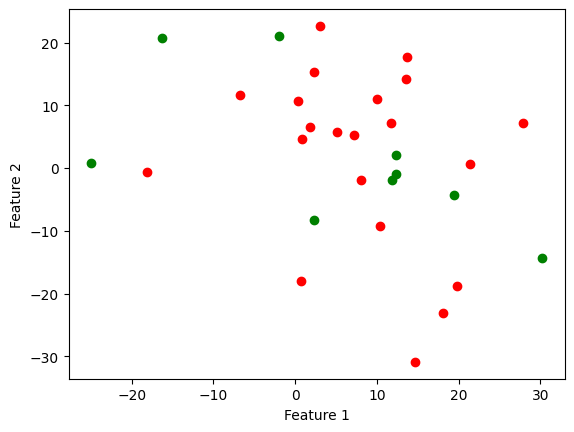

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# Generate sample data
animals_index = [836,693,18,602,303,669,216,426,560,454]
vehicles_index = [516,50,913,33,818,838,691,178,95,300,902,936,162,6,545,582,607,910,170,721,830]
sports_index = [42,689,666,532,394,932,611,610,667,654,806,17,30,310,839,612,133,414,963,157,56,823,406,457, 964]
nature_index =[102,188,184,879,600,253,480,342,386]
objects_index =[757,500,345,799,81,373,521,652,898]

np.random.seed(42)
data = train['layer_8'][vehicles_index, :2]
data2 = train['layer_8'][nature_index, :2]

dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(data)

plt.scatter(data[:, 0], data[:, 1], cmap='viridis', marker='o', color = 'red')
plt.scatter(data2[:, 0], data2[:, 1], cmap='viridis', marker='o', color = 'green')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [47]:
pip install pennylane

Step 10: cost = 0.8626891505449666
Step 20: cost = 0.8314894082077596
Step 30: cost = 0.8244134811792768
Step 40: cost = 0.8131618580463521
Step 50: cost = 0.8082214268560377
Step 60: cost = 0.8077406309126517
Step 70: cost = 0.8071521692816707
Step 80: cost = 0.8071102457867916
Step 90: cost = 0.8070480475607865
Step 100: cost = 0.8070212875298389


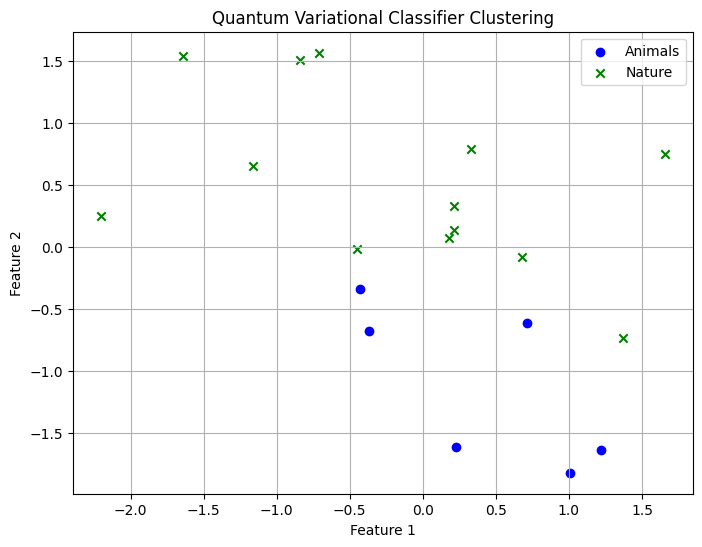

In [49]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer

# Quantum device and simulator
dev = qml.device("default.qubit", wires=2)

# Variational Quantum Circuit for Classification
def variational_circuit(weights, x):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.StronglyEntanglingLayers(weights, wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# Quantum node
@qml.qnode(dev)
def circuit(weights, x):
    return variational_circuit(weights, x)

# Loss function
def cost(weights, X, Y):
    loss = 0
    for x, y in zip(X, Y):
        pred = circuit(weights, x)
        loss += (pred - y) ** 2
    return loss / len(X)

# Specified indices
animals_index = [836, 693, 18, 602, 303, 669, 216, 426, 560, 454]
nature_index = [102, 188, 184, 879, 600, 253, 480, 342, 386]

# Prepare data subsets (using indices)
data = train['layer_8']
animals_data = data[animals_index]
nature_data = data[nature_index]

# Combine data subsets to cluster
combined_data = np.vstack((animals_data, nature_data))
combined_labels = np.array([1] * len(animals_data) + [-1] * len(nature_data))

# Normalize the data
scaler = StandardScaler()
combined_data = scaler.fit_transform(combined_data)

# Select only the first two features for clustering
combined_data = combined_data[:, :2]

# Initialize weights
num_qubits = 2
num_layers = 3
weights = np.random.randn(num_layers, num_qubits, 3)

# Optimize the variational circuit
opt = AdamOptimizer(stepsize=0.1)
max_steps = 100

for step in range(max_steps):
    # Update the weights
    weights = opt.step(lambda w: cost(w, combined_data, combined_labels), weights)

    # Compute the cost
    if (step + 1) % 10 == 0:
        cost_val = cost(weights, combined_data, combined_labels)
        print(f'Step {step+1}: cost = {cost_val}')

# Predict clusters
predictions = [circuit(weights, x) for x in combined_data]
predicted_labels = [1 if p >= 0 else -1 for p in predictions]

# Plotting the results
plt.figure(figsize=(8, 6))
for i, label in enumerate(predicted_labels):
    if label == 1:
        plt.scatter(combined_data[i, 0], combined_data[i, 1], c='blue', marker='o', label='Animals' if i == 0 else "")
    else:
        plt.scatter(combined_data[i, 0], combined_data[i, 1], c='green', marker='x', label='Nature' if i == len(animals_data) else "")

# Adding legends manually to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Quantum Variational Classifier Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

## The Quantum Approach seems to cluster better

In [50]:
num_layers = 8  # number of layers in the model
layers = []

for i in range(num_layers):
  layers.append(f"layer_{i + 1}")

model_RDMs = {}
# create RDM for each layer from activations
for j, layer in enumerate(layers):
  # activation_files = glob.glob(activations_dir + '/*' + f'{j}.npy')
  # # print(activation_files)
  # activation_files.sort()
  # activations = []
  # # Load all activations
  # for activation_file in activation_files:
  #   activations.append(np.load(activation_file))
  # activations = np.array(activations)
  # calculate Pearson's distance for all pairwise comparisons
  # DISSIMILARITY
  model_RDMs[layer] = 1- np.corrcoef(train[layer])

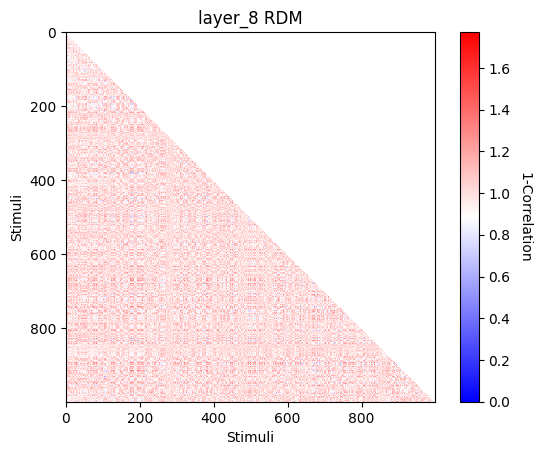

In [51]:
# @title visualize model RDMs
layer = 'layer_8'  # @param ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']

# loading layer RDM
RDM = np.array(model_RDMs[layer])

# Since the matrix is symmetric we set upper triangular values to NaN
RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan

# Visualize layer RDM
plt.imshow(RDM, cmap="bwr")
plt.title(layer + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('1-Correlation', rotation=270)
plt.show()